# Preprocessing
## General stuff
*(Loading data, prepare for future working)*

In [5]:
# IMPORTS
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing
import seaborn as sns

In [6]:
# ############LOADING BASEDATASET #########################
data_folder = "../data"
dataset = "credit_train"
file_type = "_new.csv"
df = pd.read_csv(data_folder+"/"+dataset+".csv")

In [7]:
# removing unwanted features like LOanID and CustomerID
df = df.drop(df[['Loan ID', 'Customer ID']], axis=1)

In [8]:
# Drop record if it does not have at least 'n' values that are **not** NaN out of 17 columns
# finding val of 'n', we will see how many records are dropped at each threshlod val
threshold = 0

for i in range(1, 18):
    mod_df = df.dropna(thresh=i)
    total_rows = mod_df.shape[0]
    if total_rows < 1: 
        break
    else: 
        threshold = i
        
threshold

17

In [9]:
# remove NAN values from the dataframe
df = df.dropna(thresh=threshold)

In [10]:
# Convert Loan Status to 0 or 1
df['Loan Status'] = [0 if x == 'Fully Paid' else 1 for x in  df['Loan Status']]

In [11]:
# encode features
label_encoder = preprocessing.LabelEncoder()
df['Loan Status'] = df['Loan Status'].astype(np.str)
df['Loan Status'] = label_encoder.fit_transform(df['Loan Status']).astype(np.float64)

label_encoder1 = preprocessing.LabelEncoder()
df['Term'] = label_encoder1.fit_transform(df['Term']).astype(np.float64)

encoder = preprocessing.OneHotEncoder()
encoded = pd.DataFrame(encoder.fit_transform(df[['Home Ownership', 'Purpose']]).toarray(),
                       columns=encoder.get_feature_names(['Home Ownership', 'Purpose']))
encoded.info()
#df = df.drop(df[['Home Ownership', 'Purpose']], axis=1)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36423 entries, 0 to 36422
Data columns (total 20 columns):
Home Ownership_HaveMortgage     36423 non-null float64
Home Ownership_Home Mortgage    36423 non-null float64
Home Ownership_Own Home         36423 non-null float64
Home Ownership_Rent             36423 non-null float64
Purpose_Business Loan           36423 non-null float64
Purpose_Buy House               36423 non-null float64
Purpose_Buy a Car               36423 non-null float64
Purpose_Debt Consolidation      36423 non-null float64
Purpose_Educational Expenses    36423 non-null float64
Purpose_Home Improvements       36423 non-null float64
Purpose_Medical Bills           36423 non-null float64
Purpose_Other                   36423 non-null float64
Purpose_Take a Trip             36423 non-null float64
Purpose_major_purchase          36423 non-null float64
Purpose_moving                  36423 non-null float64
Purpose_other                   36423 non-null float64
Purpose_ren

In [12]:
import importlib.util
spec = importlib.util.spec_from_file_location("module.name", "../functions.py")
functions = importlib.util.module_from_spec(spec)
spec.loader.exec_module(functions)

In [13]:
# Apply functions
df['Years in current job'] = df['Years in current job'].apply(functions.f).astype(np.float64)
# df['Credit Score'] = df['Credit Score'].apply(functions.cs)

# #fill NaN values groupby more related column
df['Credit Score'].fillna(value=df.groupby('Home Ownership')['Credit Score'].transform('median'), inplace=True)
df['Annual Income'].fillna(value=df.groupby('Purpose')['Annual Income'].transform('median'), inplace=True)
df['Years in current job'].fillna(value=df.groupby('Home Ownership')['Years in current job'].transform('median'),
                                  inplace=True)
df['Months since last delinquent'].fillna(0, inplace=True)
df['Maximum Open Credit'].fillna(value=df.groupby('Home Ownership')['Maximum Open Credit'].transform('median'),
                                 inplace=True)
df['Bankruptcies'].fillna(0, inplace=True)
df['Tax Liens'].fillna(0, inplace=True)

df["Monthly Income"] = df.apply(lambda row: functions.mi(row), axis=1)
df["Credit Ration per Year"]= df.apply(lambda row: functions.cr(row), axis=1)

df = df[df["Credit Score"] < 1000]

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 34468 entries, 2 to 99997
Data columns (total 19 columns):
Loan Status                     34468 non-null float64
Current Loan Amount             34468 non-null float64
Term                            34468 non-null float64
Credit Score                    34468 non-null float64
Annual Income                   34468 non-null float64
Years in current job            34468 non-null float64
Home Ownership                  34468 non-null object
Purpose                         34468 non-null object
Monthly Debt                    34468 non-null float64
Years of Credit History         34468 non-null float64
Months since last delinquent    34468 non-null float64
Number of Open Accounts         34468 non-null float64
Number of Credit Problems       34468 non-null float64
Current Credit Balance          34468 non-null float64
Maximum Open Credit             34468 non-null float64
Bankruptcies                    34468 non-null float64
Tax Liens    

In [14]:
# merging categorical encoded dataframe with the main dataframe and deleting unwanted features
df = df.reset_index(drop=True).merge(encoded.reset_index(drop=True), left_index=True, right_index=True)
# remove it from the dataframe so it only contains the features that our model should use
df = df.drop(df[['Home Ownership', 'Purpose']], axis=1)
df.head(10)

Loan Status  Current Loan Amount  Term  Credit Score  Annual Income  \
0          0.0           99999999.0   1.0         741.0      2231892.0   
1          0.0             217646.0   1.0         730.0      1184194.0   
2          0.0             548746.0   1.0         678.0      2559110.0   
3          0.0           99999999.0   1.0         728.0       714628.0   
4          0.0           99999999.0   1.0         740.0       776188.0   
5          0.0             234124.0   1.0         727.0       693234.0   
6          0.0             666204.0   0.0         723.0      1821967.0   
7          1.0             317108.0   0.0         687.0      1133274.0   
8          0.0             465410.0   0.0         688.0      1722654.0   
9          0.0           99999999.0   1.0         746.0      1749748.0   

   Years in current job  Monthly Debt  Years of Credit History  \
0                   8.0      29200.53                     14.9   
1                   0.0      10855.08                     19.6   
2                   2.0      18660.28                     22.6   
3                   3.0      11851.06                     16.0   
4                   0.0      11578.22                      8.5   
5                  10.0      14211.24                     24.7   
6                  10.0      17612.24                     22.0   
7                   8.0       9632.81                     17.4   
8                   3.0      15647.45                     22.3   
9                  10.0      19247.19                     20.0   

   Months since last delinquent  Number of Open Accounts  ...  \
0                          29.0                     18.0  ...   
1                          10.0                     13.0  ...   
2                          33.0                      4.0  ...   
3                          76.0                     16.0  ...   
4                          25.0                      6.0  ...   
5                          46.0                     10.0  ...   
6                          34.0                     15.0  ...   
7                          53.0                      4.0  ...   
8                          30.0                      7.0  ...   
9                          32.0                     17.0  ...   

   Purpose_Medical Bills  Purpose_Other  Purpose_Take a Trip  \
0                    0.0            0.0                  0.0   
1                    0.0            0.0                  0.0   
2                    0.0            0.0                  0.0   
3                    0.0            0.0                  0.0   
4                    0.0            0.0                  0.0   
5                    0.0            0.0                  0.0   
6                    0.0            0.0                  0.0   
7                    0.0            0.0                  0.0   
8                    0.0            0.0                  0.0   
9                    0.0            0.0                  0.0   

   Purpose_major_purchase  Purpose_moving  Purpose_other  \
0                     0.0             0.0            0.0   
1                     0.0             0.0            0.0   
2                     0.0             0.0            0.0   
3                     0.0             0.0            0.0   
4                     0.0             0.0            0.0   
5                     0.0             0.0            0.0   
6                     0.0             0.0            0.0   
7                     0.0             0.0            0.0   
8                     0.0             0.0            0.0   
9                     0.0             0.0            0.0   

   Purpose_renewable_energy  Purpose_small_business  Purpose_vacation  \
0                       0.0                     0.0               0.0   
1                       0.0                     0.0               0.0   
2                       0.0                     0.0               0.0   
3                       0.0                     0.0               0.0   
4             

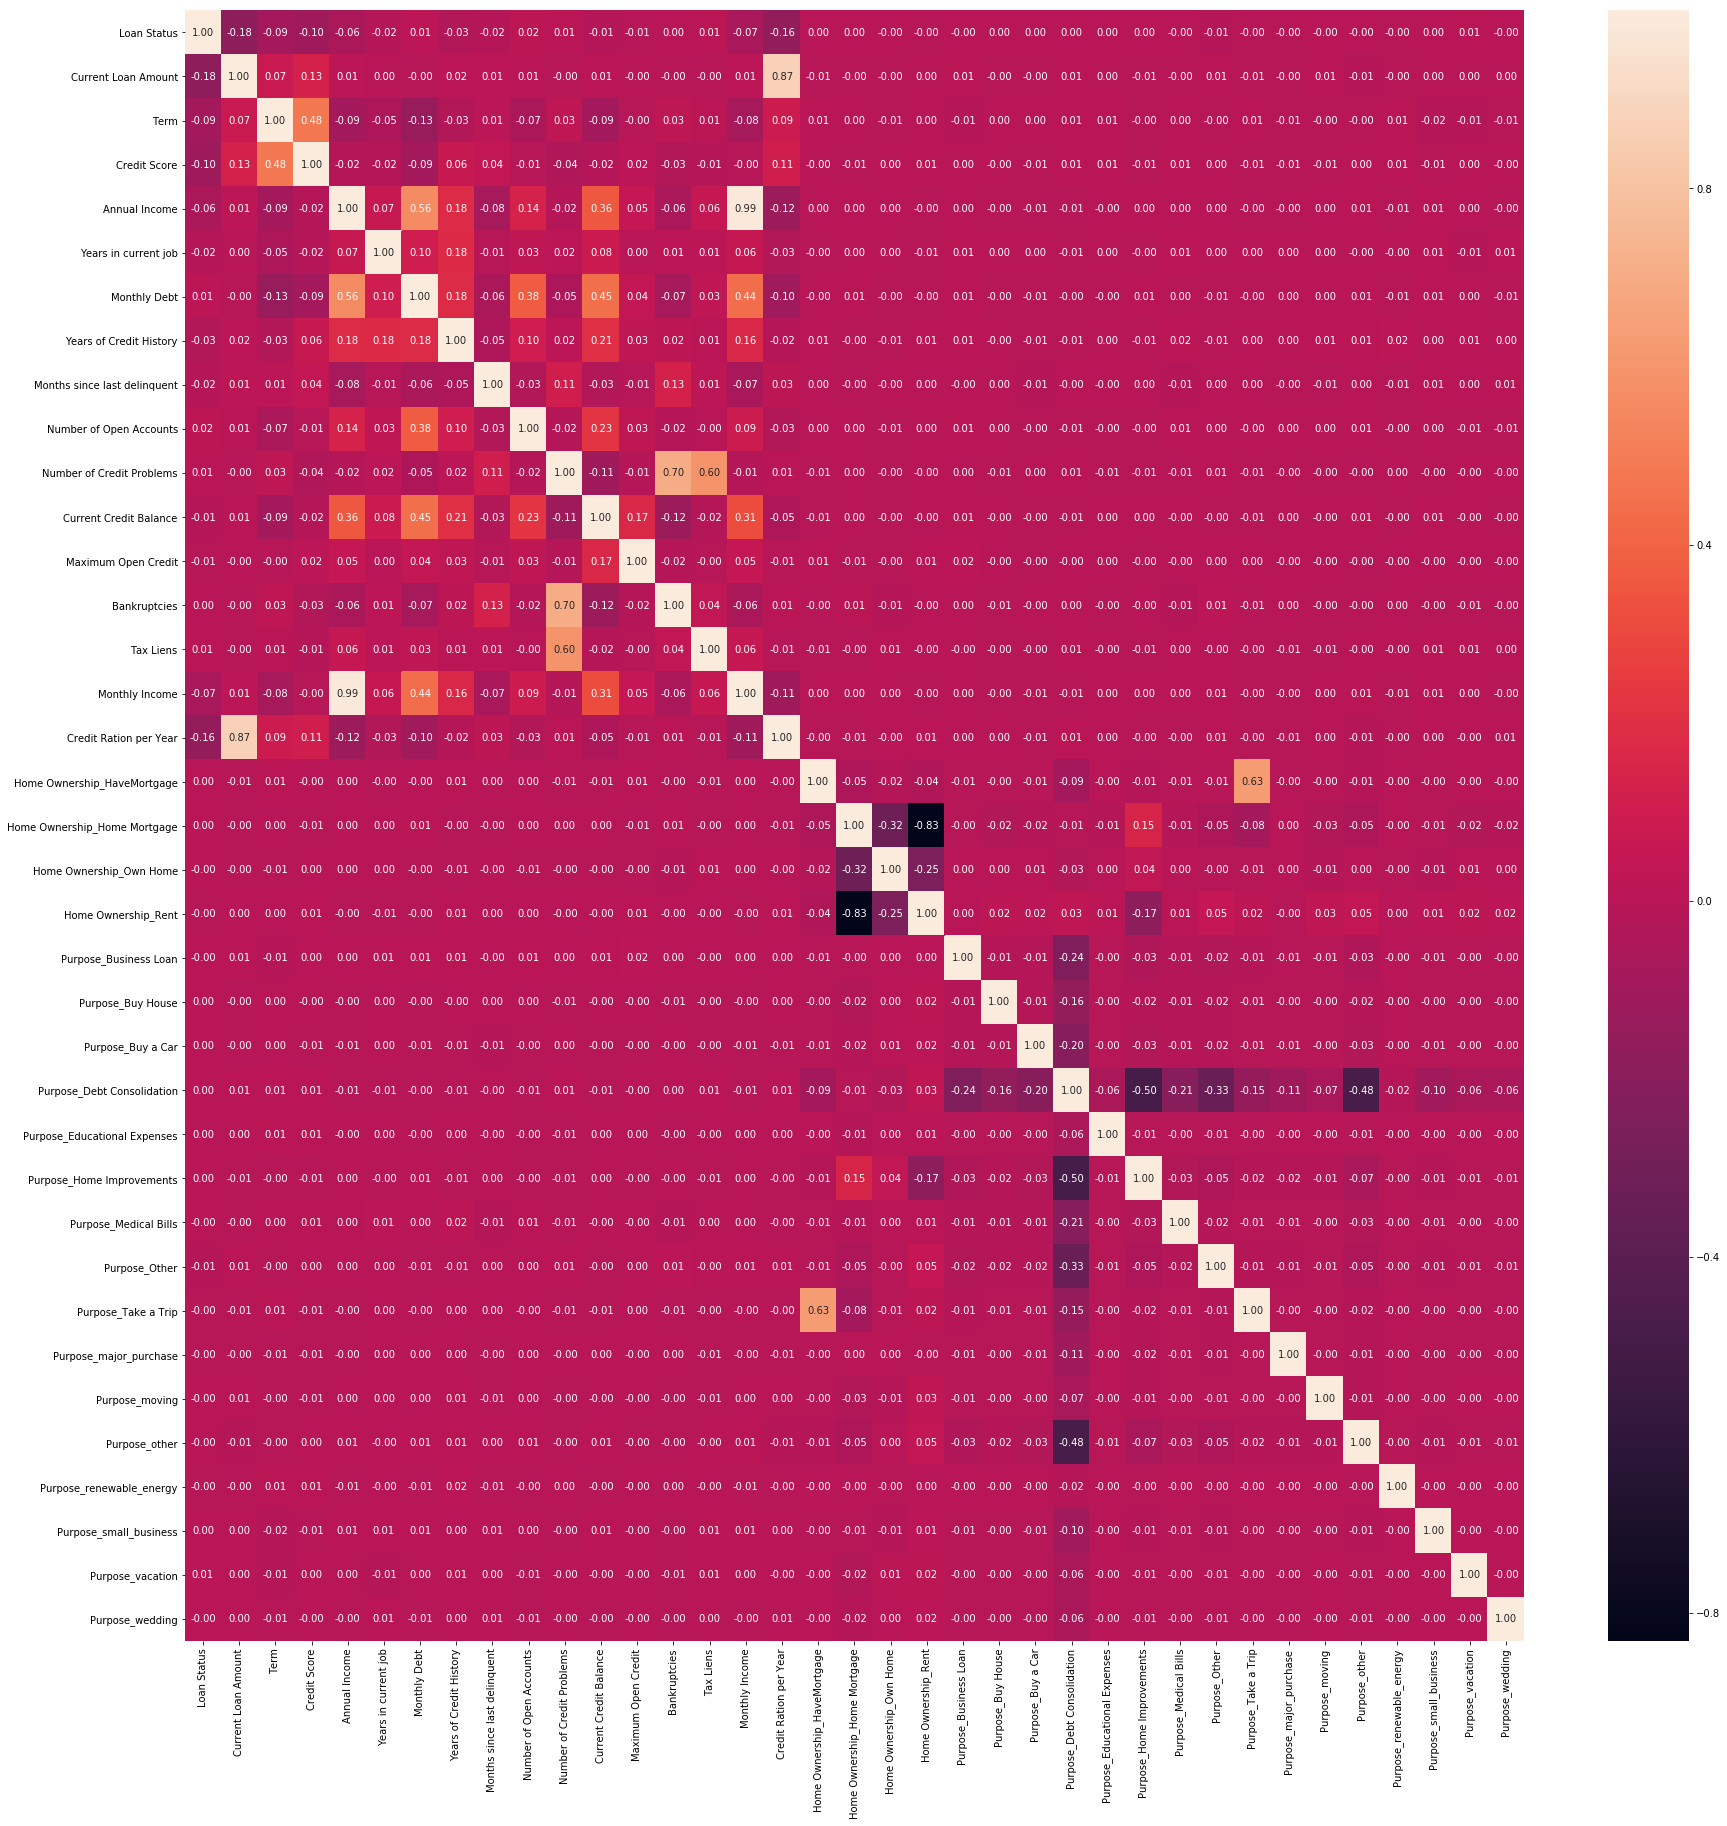

In [15]:
# show correlation matrix
plt.figure(figsize=(30, 30))
sns.heatmap(df.corr(), annot=True, fmt=".2f")
plt.show()

In [16]:
#save as processed 
df.to_csv(data_folder + "/" + dataset + "_processed" + file_type)

## Basic cleaning
*(remove outliers)*

In [13]:
#Decide which categorical variables you want to use in model

for col_name in df.columns:
        unique_cat = len(df[col_name].unique())
        print("Feature {0} has {1} unique categories".format(col_name, unique_cat))
df.info()

Feature Loan Status has 2 unique categories
Feature Current Loan Amount has 13310 unique categories
Feature Term has 2 unique categories
Feature Credit Score has 166 unique categories
Feature Annual Income has 19674 unique categories
Feature Years in current job has 11 unique categories
Feature Monthly Debt has 25439 unique categories
Feature Years of Credit History has 445 unique categories
Feature Months since last delinquent has 106 unique categories
Feature Number of Open Accounts has 46 unique categories
Feature Number of Credit Problems has 11 unique categories
Feature Current Credit Balance has 17703 unique categories
Feature Maximum Open Credit has 20994 unique categories
Feature Bankruptcies has 8 unique categories
Feature Tax Liens has 10 unique categories
Feature Monthly Income has 27342 unique categories
Feature Credit Ration per Year has 25568 unique categories
Feature Home Ownership_HaveMortgage has 2 unique categories
Feature Home Ownership_Home Mortgage has 2 unique cat

In [14]:
from sklearn.neighbors.kde import KernelDensity
def kde_sklearn(x, bandwidth=0.15, **kwargs):
    x_grid = np.linspace(x.min() - 1, x.max() + 1, 500)
    """Kernel Density Estimation with Scikit-learn"""
    kde_skl = KernelDensity(bandwidth=bandwidth, **kwargs)
    kde_skl.fit(x[:, np.newaxis])
    # score_samples() returns the log-likelihood of the samples
    log_pdf = kde_skl.score_samples(x_grid[:, np.newaxis])
    return np.exp(log_pdf), x_grid

In [15]:
def find_outliers_tukey(x):
    q1 = np.percentile(x,25)
    q3 = np.percentile(x,75)
    iqr = q3 -q1
    
    floor = q1 - 1.5*iqr
    ceiling = q3 + 1.5*iqr
    
    outlier_indices = list(x.index[(x<floor) | (x>ceiling)])
    return outlier_indices

In [16]:
def detect_outlier(col):
    threshold=3
    mean = np.mean(col.values)
    std = np.std(col.values)
    
    outlier_indices = list(col.index[(np.abs((col - mean)/std) > threshold)])
    return outlier_indices

In [17]:
import itertools
outliers = []
best = 0
best_subset = []
cols = ["Term",
"Credit Score",
"Annual Income",
"Years in current job",
"Monthly Debt",
"Years of Credit History",
"Months since last delinquent",
"Number of Open Accounts",
"Number of Credit Problems",
"Current Credit Balance",
"Maximum Open Credit",
"Bankruptcies",
"Tax Liens",
"Monthly Income",
"Credit Ration per Year"]
counter = 0
for L in range(0, len(cols)+1):
    combinations = itertools.combinations(cols, L)
    print(len(list(combinations)))
    for subset in itertools.combinations(cols, L):
        print(subset)
        outliers = []
        for col_name in df.columns:
            if col_name in subset:
                outliers.append(detect_outlier(df[col_name]))
                outliers.append(find_outliers_tukey(df[col_name]))
        outliers_list = list(itertools.chain.from_iterable(outliers))
        outliers_list = list(dict.fromkeys(outliers_list))
        print("Dataset contains {0} outliers in run {1}".format(len(outliers_list), counter+1))
        df_temp = df.drop(outliers_list)
        corr_abs = abs(df_temp.corr())
        sum = corr_abs["Loan Status"].sum(skipna=True)
        if sum > best:
            best = sum
            best_subset = subset
        counter += 1
        

1
()
Dataset contains 0 outliers in run 1
15
('Term',)
Dataset contains 0 outliers in run 2
('Credit Score',)
Dataset contains 1288 outliers in run 3
('Annual Income',)
Dataset contains 1608 outliers in run 4
('Years in current job',)
Dataset contains 0 outliers in run 5
('Monthly Debt',)
Dataset contains 1199 outliers in run 6
('Years of Credit History',)
Dataset contains 1022 outliers in run 7
('Months since last delinquent',)
Dataset contains 11 outliers in run 8
('Number of Open Accounts',)
Dataset contains 872 outliers in run 9
('Number of Credit Problems',)
Dataset contains 5091 outliers in run 10
('Current Credit Balance',)
Dataset contains 1881 outliers in run 11
('Maximum Open Credit',)
Dataset contains 1855 outliers in run 12
('Bankruptcies',)
Dataset contains 3631 outliers in run 13
('Tax Liens',)
Dataset contains 854 outliers in run 14
('Monthly Income',)
Dataset contains 1717 outliers in run 15
('Credit Ration per Year',)
Dataset contains 4923 outliers in run 16
105
('Term

Dataset contains 5091 outliers in run 104
('Number of Credit Problems', 'Monthly Income')
Dataset contains 6627 outliers in run 105
('Number of Credit Problems', 'Credit Ration per Year')
Dataset contains 9294 outliers in run 106
('Current Credit Balance', 'Maximum Open Credit')
Dataset contains 2660 outliers in run 107
('Current Credit Balance', 'Bankruptcies')
Dataset contains 5499 outliers in run 108
('Current Credit Balance', 'Tax Liens')
Dataset contains 2702 outliers in run 109
('Current Credit Balance', 'Monthly Income')
Dataset contains 3230 outliers in run 110
('Current Credit Balance', 'Credit Ration per Year')
Dataset contains 6519 outliers in run 111
('Maximum Open Credit', 'Bankruptcies')
Dataset contains 5463 outliers in run 112
('Maximum Open Credit', 'Tax Liens')
Dataset contains 2660 outliers in run 113
('Maximum Open Credit', 'Monthly Income')
Dataset contains 3226 outliers in run 114
('Maximum Open Credit', 'Credit Ration per Year')
Dataset contains 6477 outliers in 

('Term', 'Number of Credit Problems', 'Bankruptcies')
Dataset contains 5091 outliers in run 194
('Term', 'Number of Credit Problems', 'Tax Liens')
Dataset contains 5091 outliers in run 195
('Term', 'Number of Credit Problems', 'Monthly Income')
Dataset contains 6627 outliers in run 196
('Term', 'Number of Credit Problems', 'Credit Ration per Year')
Dataset contains 9294 outliers in run 197
('Term', 'Current Credit Balance', 'Maximum Open Credit')
Dataset contains 2660 outliers in run 198
('Term', 'Current Credit Balance', 'Bankruptcies')
Dataset contains 5499 outliers in run 199
('Term', 'Current Credit Balance', 'Tax Liens')
Dataset contains 2702 outliers in run 200
('Term', 'Current Credit Balance', 'Monthly Income')
Dataset contains 3230 outliers in run 201
('Term', 'Current Credit Balance', 'Credit Ration per Year')
Dataset contains 6519 outliers in run 202
('Term', 'Maximum Open Credit', 'Bankruptcies')
Dataset contains 5463 outliers in run 203
('Term', 'Maximum Open Credit', 'Tax

('Credit Score', 'Number of Credit Problems', 'Credit Ration per Year')
Dataset contains 10284 outliers in run 275
('Credit Score', 'Current Credit Balance', 'Maximum Open Credit')
Dataset contains 3860 outliers in run 276
('Credit Score', 'Current Credit Balance', 'Bankruptcies')
Dataset contains 6574 outliers in run 277
('Credit Score', 'Current Credit Balance', 'Tax Liens')
Dataset contains 3883 outliers in run 278
('Credit Score', 'Current Credit Balance', 'Monthly Income')
Dataset contains 4368 outliers in run 279
('Credit Score', 'Current Credit Balance', 'Credit Ration per Year')
Dataset contains 7633 outliers in run 280
('Credit Score', 'Maximum Open Credit', 'Bankruptcies')
Dataset contains 6549 outliers in run 281
('Credit Score', 'Maximum Open Credit', 'Tax Liens')
Dataset contains 3853 outliers in run 282
('Credit Score', 'Maximum Open Credit', 'Monthly Income')
Dataset contains 4371 outliers in run 283
('Credit Score', 'Maximum Open Credit', 'Credit Ration per Year')
Datas

('Annual Income', 'Bankruptcies', 'Credit Ration per Year')
Dataset contains 9362 outliers in run 353
('Annual Income', 'Tax Liens', 'Monthly Income')
Dataset contains 2594 outliers in run 354
('Annual Income', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 6959 outliers in run 355
('Annual Income', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 6480 outliers in run 356
('Years in current job', 'Monthly Debt', 'Years of Credit History')
Dataset contains 2145 outliers in run 357
('Years in current job', 'Monthly Debt', 'Months since last delinquent')
Dataset contains 1210 outliers in run 358
('Years in current job', 'Monthly Debt', 'Number of Open Accounts')
Dataset contains 1960 outliers in run 359
('Years in current job', 'Monthly Debt', 'Number of Credit Problems')
Dataset contains 6199 outliers in run 360
('Years in current job', 'Monthly Debt', 'Current Credit Balance')
Dataset contains 2648 outliers in run 361
('Years in current job', 'Monthly Debt', 'Maximu

('Monthly Debt', 'Number of Open Accounts', 'Number of Credit Problems')
Dataset contains 6848 outliers in run 429
('Monthly Debt', 'Number of Open Accounts', 'Current Credit Balance')
Dataset contains 3341 outliers in run 430
('Monthly Debt', 'Number of Open Accounts', 'Maximum Open Credit')
Dataset contains 3325 outliers in run 431
('Monthly Debt', 'Number of Open Accounts', 'Bankruptcies')
Dataset contains 5491 outliers in run 432
('Monthly Debt', 'Number of Open Accounts', 'Tax Liens')
Dataset contains 2746 outliers in run 433
('Monthly Debt', 'Number of Open Accounts', 'Monthly Income')
Dataset contains 3228 outliers in run 434
('Monthly Debt', 'Number of Open Accounts', 'Credit Ration per Year')
Dataset contains 6573 outliers in run 435
('Monthly Debt', 'Number of Credit Problems', 'Current Credit Balance')
Dataset contains 7597 outliers in run 436
('Monthly Debt', 'Number of Credit Problems', 'Maximum Open Credit')
Dataset contains 7654 outliers in run 437
('Monthly Debt', 'Numb

('Months since last delinquent', 'Number of Credit Problems', 'Tax Liens')
Dataset contains 5100 outliers in run 503
('Months since last delinquent', 'Number of Credit Problems', 'Monthly Income')
Dataset contains 6635 outliers in run 504
('Months since last delinquent', 'Number of Credit Problems', 'Credit Ration per Year')
Dataset contains 9301 outliers in run 505
('Months since last delinquent', 'Current Credit Balance', 'Maximum Open Credit')
Dataset contains 2670 outliers in run 506
('Months since last delinquent', 'Current Credit Balance', 'Bankruptcies')
Dataset contains 5510 outliers in run 507
('Months since last delinquent', 'Current Credit Balance', 'Tax Liens')
Dataset contains 2711 outliers in run 508
('Months since last delinquent', 'Current Credit Balance', 'Monthly Income')
Dataset contains 3240 outliers in run 509
('Months since last delinquent', 'Current Credit Balance', 'Credit Ration per Year')
Dataset contains 6527 outliers in run 510
('Months since last delinquent

('Term', 'Credit Score', 'Annual Income', 'Monthly Debt')
Dataset contains 3451 outliers in run 578
('Term', 'Credit Score', 'Annual Income', 'Years of Credit History')
Dataset contains 3689 outliers in run 579
('Term', 'Credit Score', 'Annual Income', 'Months since last delinquent')
Dataset contains 2817 outliers in run 580
('Term', 'Credit Score', 'Annual Income', 'Number of Open Accounts')
Dataset contains 3542 outliers in run 581
('Term', 'Credit Score', 'Annual Income', 'Number of Credit Problems')
Dataset contains 7545 outliers in run 582
('Term', 'Credit Score', 'Annual Income', 'Current Credit Balance')
Dataset contains 4242 outliers in run 583
('Term', 'Credit Score', 'Annual Income', 'Maximum Open Credit')
Dataset contains 4263 outliers in run 584
('Term', 'Credit Score', 'Annual Income', 'Bankruptcies')
Dataset contains 6225 outliers in run 585
('Term', 'Credit Score', 'Annual Income', 'Tax Liens')
Dataset contains 3552 outliers in run 586
('Term', 'Credit Score', 'Annual In

('Term', 'Credit Score', 'Tax Liens', 'Monthly Income')
Dataset contains 3643 outliers in run 652
('Term', 'Credit Score', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 6806 outliers in run 653
('Term', 'Credit Score', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 7465 outliers in run 654
('Term', 'Annual Income', 'Years in current job', 'Monthly Debt')
Dataset contains 2298 outliers in run 655
('Term', 'Annual Income', 'Years in current job', 'Years of Credit History')
Dataset contains 2522 outliers in run 656
('Term', 'Annual Income', 'Years in current job', 'Months since last delinquent')
Dataset contains 1618 outliers in run 657
('Term', 'Annual Income', 'Years in current job', 'Number of Open Accounts')
Dataset contains 2394 outliers in run 658
('Term', 'Annual Income', 'Years in current job', 'Number of Credit Problems')
Dataset contains 6547 outliers in run 659
('Term', 'Annual Income', 'Years in current job', 'Current Credit Balance')
Dataset contains 3

Dataset contains 6199 outliers in run 724
('Term', 'Years in current job', 'Monthly Debt', 'Current Credit Balance')
Dataset contains 2648 outliers in run 725
('Term', 'Years in current job', 'Monthly Debt', 'Maximum Open Credit')
Dataset contains 2725 outliers in run 726
('Term', 'Years in current job', 'Monthly Debt', 'Bankruptcies')
Dataset contains 4789 outliers in run 727
('Term', 'Years in current job', 'Monthly Debt', 'Tax Liens')
Dataset contains 2005 outliers in run 728
('Term', 'Years in current job', 'Monthly Debt', 'Monthly Income')
Dataset contains 2502 outliers in run 729
('Term', 'Years in current job', 'Monthly Debt', 'Credit Ration per Year')
Dataset contains 5927 outliers in run 730
('Term', 'Years in current job', 'Years of Credit History', 'Months since last delinquent')
Dataset contains 1032 outliers in run 731
('Term', 'Years in current job', 'Years of Credit History', 'Number of Open Accounts')
Dataset contains 1859 outliers in run 732
('Term', 'Years in current 

('Term', 'Monthly Debt', 'Number of Open Accounts', 'Maximum Open Credit')
Dataset contains 3325 outliers in run 795
('Term', 'Monthly Debt', 'Number of Open Accounts', 'Bankruptcies')
Dataset contains 5491 outliers in run 796
('Term', 'Monthly Debt', 'Number of Open Accounts', 'Tax Liens')
Dataset contains 2746 outliers in run 797
('Term', 'Monthly Debt', 'Number of Open Accounts', 'Monthly Income')
Dataset contains 3228 outliers in run 798
('Term', 'Monthly Debt', 'Number of Open Accounts', 'Credit Ration per Year')
Dataset contains 6573 outliers in run 799
('Term', 'Monthly Debt', 'Number of Credit Problems', 'Current Credit Balance')
Dataset contains 7597 outliers in run 800
('Term', 'Monthly Debt', 'Number of Credit Problems', 'Maximum Open Credit')
Dataset contains 7654 outliers in run 801
('Term', 'Monthly Debt', 'Number of Credit Problems', 'Bankruptcies')
Dataset contains 6199 outliers in run 802
('Term', 'Monthly Debt', 'Number of Credit Problems', 'Tax Liens')
Dataset contai

('Term', 'Months since last delinquent', 'Number of Credit Problems', 'Maximum Open Credit')
Dataset contains 6866 outliers in run 865
('Term', 'Months since last delinquent', 'Number of Credit Problems', 'Bankruptcies')
Dataset contains 5100 outliers in run 866
('Term', 'Months since last delinquent', 'Number of Credit Problems', 'Tax Liens')
Dataset contains 5100 outliers in run 867
('Term', 'Months since last delinquent', 'Number of Credit Problems', 'Monthly Income')
Dataset contains 6635 outliers in run 868
('Term', 'Months since last delinquent', 'Number of Credit Problems', 'Credit Ration per Year')
Dataset contains 9301 outliers in run 869
('Term', 'Months since last delinquent', 'Current Credit Balance', 'Maximum Open Credit')
Dataset contains 2670 outliers in run 870
('Term', 'Months since last delinquent', 'Current Credit Balance', 'Bankruptcies')
Dataset contains 5510 outliers in run 871
('Term', 'Months since last delinquent', 'Current Credit Balance', 'Tax Liens')
Dataset

('Term', 'Maximum Open Credit', 'Tax Liens', 'Monthly Income')
Dataset contains 3962 outliers in run 934
('Term', 'Maximum Open Credit', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 7173 outliers in run 935
('Term', 'Maximum Open Credit', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 7638 outliers in run 936
('Term', 'Bankruptcies', 'Tax Liens', 'Monthly Income')
Dataset contains 5877 outliers in run 937
('Term', 'Bankruptcies', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 8649 outliers in run 938
('Term', 'Bankruptcies', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 9428 outliers in run 939
('Term', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 7037 outliers in run 940
('Credit Score', 'Annual Income', 'Years in current job', 'Monthly Debt')
Dataset contains 3451 outliers in run 941
('Credit Score', 'Annual Income', 'Years in current job', 'Years of Credit History')
Dataset contains 3689 outliers in run 94

Dataset contains 6827 outliers in run 1001
('Credit Score', 'Annual Income', 'Bankruptcies', 'Monthly Income')
Dataset contains 6406 outliers in run 1002
('Credit Score', 'Annual Income', 'Bankruptcies', 'Credit Ration per Year')
Dataset contains 10332 outliers in run 1003
('Credit Score', 'Annual Income', 'Tax Liens', 'Monthly Income')
Dataset contains 3745 outliers in run 1004
('Credit Score', 'Annual Income', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 8025 outliers in run 1005
('Credit Score', 'Annual Income', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 7558 outliers in run 1006
('Credit Score', 'Years in current job', 'Monthly Debt', 'Years of Credit History')
Dataset contains 3316 outliers in run 1007
('Credit Score', 'Years in current job', 'Monthly Debt', 'Months since last delinquent')
Dataset contains 2414 outliers in run 1008
('Credit Score', 'Years in current job', 'Monthly Debt', 'Number of Open Accounts')
Dataset contains 3116 outliers in run 

('Credit Score', 'Monthly Debt', 'Years of Credit History', 'Maximum Open Credit')
Dataset contains 4698 outliers in run 1066
('Credit Score', 'Monthly Debt', 'Years of Credit History', 'Bankruptcies')
Dataset contains 6658 outliers in run 1067
('Credit Score', 'Monthly Debt', 'Years of Credit History', 'Tax Liens')
Dataset contains 4064 outliers in run 1068
('Credit Score', 'Monthly Debt', 'Years of Credit History', 'Monthly Income')
Dataset contains 4487 outliers in run 1069
('Credit Score', 'Monthly Debt', 'Years of Credit History', 'Credit Ration per Year')
Dataset contains 7809 outliers in run 1070
('Credit Score', 'Monthly Debt', 'Months since last delinquent', 'Number of Open Accounts')
Dataset contains 3127 outliers in run 1071
('Credit Score', 'Monthly Debt', 'Months since last delinquent', 'Number of Credit Problems')
Dataset contains 7208 outliers in run 1072
('Credit Score', 'Monthly Debt', 'Months since last delinquent', 'Current Credit Balance')
Dataset contains 3815 outl

('Credit Score', 'Years of Credit History', 'Current Credit Balance', 'Monthly Income')
Dataset contains 5161 outliers in run 1131
('Credit Score', 'Years of Credit History', 'Current Credit Balance', 'Credit Ration per Year')
Dataset contains 8369 outliers in run 1132
('Credit Score', 'Years of Credit History', 'Maximum Open Credit', 'Bankruptcies')
Dataset contains 7295 outliers in run 1133
('Credit Score', 'Years of Credit History', 'Maximum Open Credit', 'Tax Liens')
Dataset contains 4683 outliers in run 1134
('Credit Score', 'Years of Credit History', 'Maximum Open Credit', 'Monthly Income')
Dataset contains 5150 outliers in run 1135
('Credit Score', 'Years of Credit History', 'Maximum Open Credit', 'Credit Ration per Year')
Dataset contains 8331 outliers in run 1136
('Credit Score', 'Years of Credit History', 'Bankruptcies', 'Tax Liens')
Dataset contains 6290 outliers in run 1137
('Credit Score', 'Years of Credit History', 'Bankruptcies', 'Monthly Income')
Dataset contains 7087 o

('Credit Score', 'Number of Credit Problems', 'Current Credit Balance', 'Bankruptcies')
Dataset contains 7913 outliers in run 1193
('Credit Score', 'Number of Credit Problems', 'Current Credit Balance', 'Tax Liens')
Dataset contains 7913 outliers in run 1194
('Credit Score', 'Number of Credit Problems', 'Current Credit Balance', 'Monthly Income')
Dataset contains 9030 outliers in run 1195
('Credit Score', 'Number of Credit Problems', 'Current Credit Balance', 'Credit Ration per Year')
Dataset contains 11753 outliers in run 1196
('Credit Score', 'Number of Credit Problems', 'Maximum Open Credit', 'Bankruptcies')
Dataset contains 7876 outliers in run 1197
('Credit Score', 'Number of Credit Problems', 'Maximum Open Credit', 'Tax Liens')
Dataset contains 7876 outliers in run 1198
('Credit Score', 'Number of Credit Problems', 'Maximum Open Credit', 'Monthly Income')
Dataset contains 9014 outliers in run 1199
('Credit Score', 'Number of Credit Problems', 'Maximum Open Credit', 'Credit Ration

('Annual Income', 'Years in current job', 'Number of Open Accounts', 'Bankruptcies')
Dataset contains 5890 outliers in run 1257
('Annual Income', 'Years in current job', 'Number of Open Accounts', 'Tax Liens')
Dataset contains 3148 outliers in run 1258
('Annual Income', 'Years in current job', 'Number of Open Accounts', 'Monthly Income')
Dataset contains 2615 outliers in run 1259
('Annual Income', 'Years in current job', 'Number of Open Accounts', 'Credit Ration per Year')
Dataset contains 6967 outliers in run 1260
('Annual Income', 'Years in current job', 'Number of Credit Problems', 'Current Credit Balance')
Dataset contains 7982 outliers in run 1261
('Annual Income', 'Years in current job', 'Number of Credit Problems', 'Maximum Open Credit')
Dataset contains 7976 outliers in run 1262
('Annual Income', 'Years in current job', 'Number of Credit Problems', 'Bankruptcies')
Dataset contains 6547 outliers in run 1263
('Annual Income', 'Years in current job', 'Number of Credit Problems', '

('Annual Income', 'Monthly Debt', 'Tax Liens', 'Monthly Income')
Dataset contains 3260 outliers in run 1324
('Annual Income', 'Monthly Debt', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 7512 outliers in run 1325
('Annual Income', 'Monthly Debt', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 7056 outliers in run 1326
('Annual Income', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts')
Dataset contains 3286 outliers in run 1327
('Annual Income', 'Years of Credit History', 'Months since last delinquent', 'Number of Credit Problems')
Dataset contains 7317 outliers in run 1328
('Annual Income', 'Years of Credit History', 'Months since last delinquent', 'Current Credit Balance')
Dataset contains 3924 outliers in run 1329
('Annual Income', 'Years of Credit History', 'Months since last delinquent', 'Maximum Open Credit')
Dataset contains 3924 outliers in run 1330
('Annual Income', 'Years of Credit History', 'Months since last delinq

('Annual Income', 'Months since last delinquent', 'Bankruptcies', 'Monthly Income')
Dataset contains 5372 outliers in run 1386
('Annual Income', 'Months since last delinquent', 'Bankruptcies', 'Credit Ration per Year')
Dataset contains 9369 outliers in run 1387
('Annual Income', 'Months since last delinquent', 'Tax Liens', 'Monthly Income')
Dataset contains 2602 outliers in run 1388
('Annual Income', 'Months since last delinquent', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 6965 outliers in run 1389
('Annual Income', 'Months since last delinquent', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 6487 outliers in run 1390
('Annual Income', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance')
Dataset contains 8569 outliers in run 1391
('Annual Income', 'Number of Open Accounts', 'Number of Credit Problems', 'Maximum Open Credit')
Dataset contains 8489 outliers in run 1392
('Annual Income', 'Number of Open Accounts', 'Number of Credit

('Years in current job', 'Monthly Debt', 'Years of Credit History', 'Current Credit Balance')
Dataset contains 3502 outliers in run 1450
('Years in current job', 'Monthly Debt', 'Years of Credit History', 'Maximum Open Credit')
Dataset contains 3565 outliers in run 1451
('Years in current job', 'Monthly Debt', 'Years of Credit History', 'Bankruptcies')
Dataset contains 5625 outliers in run 1452
('Years in current job', 'Monthly Debt', 'Years of Credit History', 'Tax Liens')
Dataset contains 2923 outliers in run 1453
('Years in current job', 'Monthly Debt', 'Years of Credit History', 'Monthly Income')
Dataset contains 3380 outliers in run 1454
('Years in current job', 'Monthly Debt', 'Years of Credit History', 'Credit Ration per Year')
Dataset contains 6736 outliers in run 1455
('Years in current job', 'Monthly Debt', 'Months since last delinquent', 'Number of Open Accounts')
Dataset contains 1971 outliers in run 1456
('Years in current job', 'Monthly Debt', 'Months since last delinquen

('Years in current job', 'Years of Credit History', 'Current Credit Balance', 'Maximum Open Credit')
Dataset contains 3503 outliers in run 1513
('Years in current job', 'Years of Credit History', 'Current Credit Balance', 'Bankruptcies')
Dataset contains 6288 outliers in run 1514
('Years in current job', 'Years of Credit History', 'Current Credit Balance', 'Tax Liens')
Dataset contains 3575 outliers in run 1515
('Years in current job', 'Years of Credit History', 'Current Credit Balance', 'Monthly Income')
Dataset contains 4051 outliers in run 1516
('Years in current job', 'Years of Credit History', 'Current Credit Balance', 'Credit Ration per Year')
Dataset contains 7286 outliers in run 1517
('Years in current job', 'Years of Credit History', 'Maximum Open Credit', 'Bankruptcies')
Dataset contains 6242 outliers in run 1518
('Years in current job', 'Years of Credit History', 'Maximum Open Credit', 'Tax Liens')
Dataset contains 3524 outliers in run 1519
('Years in current job', 'Years of

('Years in current job', 'Number of Open Accounts', 'Bankruptcies', 'Tax Liens')
Dataset contains 5114 outliers in run 1571
('Years in current job', 'Number of Open Accounts', 'Bankruptcies', 'Monthly Income')
Dataset contains 5992 outliers in run 1572
('Years in current job', 'Number of Open Accounts', 'Bankruptcies', 'Credit Ration per Year')
Dataset contains 8742 outliers in run 1573
('Years in current job', 'Number of Open Accounts', 'Tax Liens', 'Monthly Income')
Dataset contains 3265 outliers in run 1574
('Years in current job', 'Number of Open Accounts', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 6382 outliers in run 1575
('Years in current job', 'Number of Open Accounts', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 7065 outliers in run 1576
('Years in current job', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit')
Dataset contains 7636 outliers in run 1577
('Years in current job', 'Number of Credit Problems', 'Current Cr

('Monthly Debt', 'Years of Credit History', 'Current Credit Balance', 'Tax Liens')
Dataset contains 4265 outliers in run 1635
('Monthly Debt', 'Years of Credit History', 'Current Credit Balance', 'Monthly Income')
Dataset contains 4562 outliers in run 1636
('Monthly Debt', 'Years of Credit History', 'Current Credit Balance', 'Credit Ration per Year')
Dataset contains 7889 outliers in run 1637
('Monthly Debt', 'Years of Credit History', 'Maximum Open Credit', 'Bankruptcies')
Dataset contains 7026 outliers in run 1638
('Monthly Debt', 'Years of Credit History', 'Maximum Open Credit', 'Tax Liens')
Dataset contains 4314 outliers in run 1639
('Monthly Debt', 'Years of Credit History', 'Maximum Open Credit', 'Monthly Income')
Dataset contains 4618 outliers in run 1640
('Monthly Debt', 'Years of Credit History', 'Maximum Open Credit', 'Credit Ration per Year')
Dataset contains 7928 outliers in run 1641
('Monthly Debt', 'Years of Credit History', 'Bankruptcies', 'Tax Liens')
Dataset contains 6

('Monthly Debt', 'Number of Credit Problems', 'Current Credit Balance', 'Tax Liens')
Dataset contains 7597 outliers in run 1699
('Monthly Debt', 'Number of Credit Problems', 'Current Credit Balance', 'Monthly Income')
Dataset contains 8564 outliers in run 1700
('Monthly Debt', 'Number of Credit Problems', 'Current Credit Balance', 'Credit Ration per Year')
Dataset contains 11397 outliers in run 1701
('Monthly Debt', 'Number of Credit Problems', 'Maximum Open Credit', 'Bankruptcies')
Dataset contains 7654 outliers in run 1702
('Monthly Debt', 'Number of Credit Problems', 'Maximum Open Credit', 'Tax Liens')
Dataset contains 7654 outliers in run 1703
('Monthly Debt', 'Number of Credit Problems', 'Maximum Open Credit', 'Monthly Income')
Dataset contains 8619 outliers in run 1704
('Monthly Debt', 'Number of Credit Problems', 'Maximum Open Credit', 'Credit Ration per Year')
Dataset contains 11433 outliers in run 1705
('Monthly Debt', 'Number of Credit Problems', 'Bankruptcies', 'Tax Liens')


('Years of Credit History', 'Number of Open Accounts', 'Number of Credit Problems', 'Maximum Open Credit')
Dataset contains 8124 outliers in run 1761
('Years of Credit History', 'Number of Open Accounts', 'Number of Credit Problems', 'Bankruptcies')
Dataset contains 6668 outliers in run 1762
('Years of Credit History', 'Number of Open Accounts', 'Number of Credit Problems', 'Tax Liens')
Dataset contains 6668 outliers in run 1763
('Years of Credit History', 'Number of Open Accounts', 'Number of Credit Problems', 'Monthly Income')
Dataset contains 8047 outliers in run 1764
('Years of Credit History', 'Number of Open Accounts', 'Number of Credit Problems', 'Credit Ration per Year')
Dataset contains 10635 outliers in run 1765
('Years of Credit History', 'Number of Open Accounts', 'Current Credit Balance', 'Maximum Open Credit')
Dataset contains 4103 outliers in run 1766
('Years of Credit History', 'Number of Open Accounts', 'Current Credit Balance', 'Bankruptcies')
Dataset contains 6948 ou

('Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Credit Ration per Year')
Dataset contains 9943 outliers in run 1821
('Months since last delinquent', 'Number of Open Accounts', 'Current Credit Balance', 'Maximum Open Credit')
Dataset contains 3292 outliers in run 1822
('Months since last delinquent', 'Number of Open Accounts', 'Current Credit Balance', 'Bankruptcies')
Dataset contains 6197 outliers in run 1823
('Months since last delinquent', 'Number of Open Accounts', 'Current Credit Balance', 'Tax Liens')
Dataset contains 3443 outliers in run 1824
('Months since last delinquent', 'Number of Open Accounts', 'Current Credit Balance', 'Monthly Income')
Dataset contains 3945 outliers in run 1825
('Months since last delinquent', 'Number of Open Accounts', 'Current Credit Balance', 'Credit Ration per Year')
Dataset contains 7163 outliers in run 1826
('Months since last delinquent', 'Number of Open Accounts', 'Maximum Open Credit', 'Bankruptcies')
Da

('Number of Open Accounts', 'Number of Credit Problems', 'Maximum Open Credit', 'Monthly Income')
Dataset contains 8591 outliers in run 1879
('Number of Open Accounts', 'Number of Credit Problems', 'Maximum Open Credit', 'Credit Ration per Year')
Dataset contains 11244 outliers in run 1880
('Number of Open Accounts', 'Number of Credit Problems', 'Bankruptcies', 'Tax Liens')
Dataset contains 5843 outliers in run 1881
('Number of Open Accounts', 'Number of Credit Problems', 'Bankruptcies', 'Monthly Income')
Dataset contains 7312 outliers in run 1882
('Number of Open Accounts', 'Number of Credit Problems', 'Bankruptcies', 'Credit Ration per Year')
Dataset contains 9936 outliers in run 1883
('Number of Open Accounts', 'Number of Credit Problems', 'Tax Liens', 'Monthly Income')
Dataset contains 7312 outliers in run 1884
('Number of Open Accounts', 'Number of Credit Problems', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 9936 outliers in run 1885
('Number of Open Accounts', 'Numbe

('Bankruptcies', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 9959 outliers in run 1941
3003
('Term', 'Credit Score', 'Annual Income', 'Years in current job', 'Monthly Debt')
Dataset contains 3451 outliers in run 1942
('Term', 'Credit Score', 'Annual Income', 'Years in current job', 'Years of Credit History')
Dataset contains 3689 outliers in run 1943
('Term', 'Credit Score', 'Annual Income', 'Years in current job', 'Months since last delinquent')
Dataset contains 2817 outliers in run 1944
('Term', 'Credit Score', 'Annual Income', 'Years in current job', 'Number of Open Accounts')
Dataset contains 3542 outliers in run 1945
('Term', 'Credit Score', 'Annual Income', 'Years in current job', 'Number of Credit Problems')
Dataset contains 7545 outliers in run 1946
('Term', 'Credit Score', 'Annual Income', 'Years in current job', 'Current Credit Balance')
Dataset contains 4242 outliers in run 1947
('Term', 'Credit Score', 'Annual Income', 'Years in current job', '

('Term', 'Credit Score', 'Annual Income', 'Bankruptcies', 'Credit Ration per Year')
Dataset contains 10332 outliers in run 2004
('Term', 'Credit Score', 'Annual Income', 'Tax Liens', 'Monthly Income')
Dataset contains 3745 outliers in run 2005
('Term', 'Credit Score', 'Annual Income', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 8025 outliers in run 2006
('Term', 'Credit Score', 'Annual Income', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 7558 outliers in run 2007
('Term', 'Credit Score', 'Years in current job', 'Monthly Debt', 'Years of Credit History')
Dataset contains 3316 outliers in run 2008
('Term', 'Credit Score', 'Years in current job', 'Monthly Debt', 'Months since last delinquent')
Dataset contains 2414 outliers in run 2009
('Term', 'Credit Score', 'Years in current job', 'Monthly Debt', 'Number of Open Accounts')
Dataset contains 3116 outliers in run 2010
('Term', 'Credit Score', 'Years in current job', 'Monthly Debt', 'Number of Credit Problems')

('Term', 'Credit Score', 'Monthly Debt', 'Years of Credit History', 'Number of Open Accounts')
Dataset contains 4000 outliers in run 2064
('Term', 'Credit Score', 'Monthly Debt', 'Years of Credit History', 'Number of Credit Problems')
Dataset contains 7959 outliers in run 2065
('Term', 'Credit Score', 'Monthly Debt', 'Years of Credit History', 'Current Credit Balance')
Dataset contains 4629 outliers in run 2066
('Term', 'Credit Score', 'Monthly Debt', 'Years of Credit History', 'Maximum Open Credit')
Dataset contains 4698 outliers in run 2067
('Term', 'Credit Score', 'Monthly Debt', 'Years of Credit History', 'Bankruptcies')
Dataset contains 6658 outliers in run 2068
('Term', 'Credit Score', 'Monthly Debt', 'Years of Credit History', 'Tax Liens')
Dataset contains 4064 outliers in run 2069
('Term', 'Credit Score', 'Monthly Debt', 'Years of Credit History', 'Monthly Income')
Dataset contains 4487 outliers in run 2070
('Term', 'Credit Score', 'Monthly Debt', 'Years of Credit History', 'Cr

Dataset contains 6997 outliers in run 2125
('Term', 'Credit Score', 'Years of Credit History', 'Number of Credit Problems', 'Tax Liens')
Dataset contains 6997 outliers in run 2126
('Term', 'Credit Score', 'Years of Credit History', 'Number of Credit Problems', 'Monthly Income')
Dataset contains 8356 outliers in run 2127
('Term', 'Credit Score', 'Years of Credit History', 'Number of Credit Problems', 'Credit Ration per Year')
Dataset contains 10981 outliers in run 2128
('Term', 'Credit Score', 'Years of Credit History', 'Current Credit Balance', 'Maximum Open Credit')
Dataset contains 4670 outliers in run 2129
('Term', 'Credit Score', 'Years of Credit History', 'Current Credit Balance', 'Bankruptcies')
Dataset contains 7333 outliers in run 2130
('Term', 'Credit Score', 'Years of Credit History', 'Current Credit Balance', 'Tax Liens')
Dataset contains 4725 outliers in run 2131
('Term', 'Credit Score', 'Years of Credit History', 'Current Credit Balance', 'Monthly Income')
Dataset contains

('Term', 'Credit Score', 'Number of Open Accounts', 'Maximum Open Credit', 'Monthly Income')
Dataset contains 4953 outliers in run 2185
('Term', 'Credit Score', 'Number of Open Accounts', 'Maximum Open Credit', 'Credit Ration per Year')
Dataset contains 8121 outliers in run 2186
('Term', 'Credit Score', 'Number of Open Accounts', 'Bankruptcies', 'Tax Liens')
Dataset contains 6166 outliers in run 2187
('Term', 'Credit Score', 'Number of Open Accounts', 'Bankruptcies', 'Monthly Income')
Dataset contains 6994 outliers in run 2188
('Term', 'Credit Score', 'Number of Open Accounts', 'Bankruptcies', 'Credit Ration per Year')
Dataset contains 9741 outliers in run 2189
('Term', 'Credit Score', 'Number of Open Accounts', 'Tax Liens', 'Monthly Income')
Dataset contains 4371 outliers in run 2190
('Term', 'Credit Score', 'Number of Open Accounts', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 7472 outliers in run 2191
('Term', 'Credit Score', 'Number of Open Accounts', 'Monthly Income', 

Dataset contains 7076 outliers in run 2246
('Term', 'Annual Income', 'Years in current job', 'Months since last delinquent', 'Number of Open Accounts')
Dataset contains 2404 outliers in run 2247
('Term', 'Annual Income', 'Years in current job', 'Months since last delinquent', 'Number of Credit Problems')
Dataset contains 6555 outliers in run 2248
('Term', 'Annual Income', 'Years in current job', 'Months since last delinquent', 'Current Credit Balance')
Dataset contains 3102 outliers in run 2249
('Term', 'Annual Income', 'Years in current job', 'Months since last delinquent', 'Maximum Open Credit')
Dataset contains 3115 outliers in run 2250
('Term', 'Annual Income', 'Years in current job', 'Months since last delinquent', 'Bankruptcies')
Dataset contains 5176 outliers in run 2251
('Term', 'Annual Income', 'Years in current job', 'Months since last delinquent', 'Tax Liens')
Dataset contains 2391 outliers in run 2252
('Term', 'Annual Income', 'Years in current job', 'Months since last deli

('Term', 'Annual Income', 'Monthly Debt', 'Number of Credit Problems', 'Current Credit Balance')
Dataset contains 8407 outliers in run 2307
('Term', 'Annual Income', 'Monthly Debt', 'Number of Credit Problems', 'Maximum Open Credit')
Dataset contains 8465 outliers in run 2308
('Term', 'Annual Income', 'Monthly Debt', 'Number of Credit Problems', 'Bankruptcies')
Dataset contains 7181 outliers in run 2309
('Term', 'Annual Income', 'Monthly Debt', 'Number of Credit Problems', 'Tax Liens')
Dataset contains 7181 outliers in run 2310
('Term', 'Annual Income', 'Monthly Debt', 'Number of Credit Problems', 'Monthly Income')
Dataset contains 7364 outliers in run 2311
('Term', 'Annual Income', 'Monthly Debt', 'Number of Credit Problems', 'Credit Ration per Year')
Dataset contains 11055 outliers in run 2312
('Term', 'Annual Income', 'Monthly Debt', 'Current Credit Balance', 'Maximum Open Credit')
Dataset contains 4229 outliers in run 2313
('Term', 'Annual Income', 'Monthly Debt', 'Current Credit B

Dataset contains 5900 outliers in run 2367
('Term', 'Annual Income', 'Months since last delinquent', 'Number of Open Accounts', 'Tax Liens')
Dataset contains 3156 outliers in run 2368
('Term', 'Annual Income', 'Months since last delinquent', 'Number of Open Accounts', 'Monthly Income')
Dataset contains 2625 outliers in run 2369
('Term', 'Annual Income', 'Months since last delinquent', 'Number of Open Accounts', 'Credit Ration per Year')
Dataset contains 6974 outliers in run 2370
('Term', 'Annual Income', 'Months since last delinquent', 'Number of Credit Problems', 'Current Credit Balance')
Dataset contains 7990 outliers in run 2371
('Term', 'Annual Income', 'Months since last delinquent', 'Number of Credit Problems', 'Maximum Open Credit')
Dataset contains 7984 outliers in run 2372
('Term', 'Annual Income', 'Months since last delinquent', 'Number of Credit Problems', 'Bankruptcies')
Dataset contains 6555 outliers in run 2373
('Term', 'Annual Income', 'Months since last delinquent', 'Nu

('Term', 'Annual Income', 'Number of Credit Problems', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 10681 outliers in run 2427
('Term', 'Annual Income', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies')
Dataset contains 7313 outliers in run 2428
('Term', 'Annual Income', 'Current Credit Balance', 'Maximum Open Credit', 'Tax Liens')
Dataset contains 4516 outliers in run 2429
('Term', 'Annual Income', 'Current Credit Balance', 'Maximum Open Credit', 'Monthly Income')
Dataset contains 3978 outliers in run 2430
('Term', 'Annual Income', 'Current Credit Balance', 'Maximum Open Credit', 'Credit Ration per Year')
Dataset contains 8122 outliers in run 2431
('Term', 'Annual Income', 'Current Credit Balance', 'Bankruptcies', 'Tax Liens')
Dataset contains 7252 outliers in run 2432
('Term', 'Annual Income', 'Current Credit Balance', 'Bankruptcies', 'Monthly Income')
Dataset contains 6823 outliers in run 2433
('Term', 'Annual Income', 'Current Credit Balance', 'Bankru

('Term', 'Years in current job', 'Monthly Debt', 'Bankruptcies', 'Monthly Income')
Dataset contains 6006 outliers in run 2488
('Term', 'Years in current job', 'Monthly Debt', 'Bankruptcies', 'Credit Ration per Year')
Dataset contains 9017 outliers in run 2489
('Term', 'Years in current job', 'Monthly Debt', 'Tax Liens', 'Monthly Income')
Dataset contains 3243 outliers in run 2490
('Term', 'Years in current job', 'Monthly Debt', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 6619 outliers in run 2491
('Term', 'Years in current job', 'Monthly Debt', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 7041 outliers in run 2492
('Term', 'Years in current job', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts')
Dataset contains 1869 outliers in run 2493
('Term', 'Years in current job', 'Years of Credit History', 'Months since last delinquent', 'Number of Credit Problems')
Dataset contains 5959 outliers in run 2494
('Term', 'Years in curre

('Term', 'Years in current job', 'Months since last delinquent', 'Current Credit Balance', 'Tax Liens')
Dataset contains 2711 outliers in run 2544
('Term', 'Years in current job', 'Months since last delinquent', 'Current Credit Balance', 'Monthly Income')
Dataset contains 3240 outliers in run 2545
('Term', 'Years in current job', 'Months since last delinquent', 'Current Credit Balance', 'Credit Ration per Year')
Dataset contains 6527 outliers in run 2546
('Term', 'Years in current job', 'Months since last delinquent', 'Maximum Open Credit', 'Bankruptcies')
Dataset contains 5473 outliers in run 2547
('Term', 'Years in current job', 'Months since last delinquent', 'Maximum Open Credit', 'Tax Liens')
Dataset contains 2669 outliers in run 2548
('Term', 'Years in current job', 'Months since last delinquent', 'Maximum Open Credit', 'Monthly Income')
Dataset contains 3235 outliers in run 2549
('Term', 'Years in current job', 'Months since last delinquent', 'Maximum Open Credit', 'Credit Ratio

('Term', 'Years in current job', 'Current Credit Balance', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 7226 outliers in run 2601
('Term', 'Years in current job', 'Current Credit Balance', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 7669 outliers in run 2602
('Term', 'Years in current job', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens')
Dataset contains 6114 outliers in run 2603
('Term', 'Years in current job', 'Maximum Open Credit', 'Bankruptcies', 'Monthly Income')
Dataset contains 6743 outliers in run 2604
('Term', 'Years in current job', 'Maximum Open Credit', 'Bankruptcies', 'Credit Ration per Year')
Dataset contains 9584 outliers in run 2605
('Term', 'Years in current job', 'Maximum Open Credit', 'Tax Liens', 'Monthly Income')
Dataset contains 3962 outliers in run 2606
('Term', 'Years in current job', 'Maximum Open Credit', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 7173 outliers in run 2607
('Term', 'Years in current job', 'Maximum O

('Term', 'Monthly Debt', 'Months since last delinquent', 'Number of Credit Problems', 'Tax Liens')
Dataset contains 6208 outliers in run 2659
('Term', 'Monthly Debt', 'Months since last delinquent', 'Number of Credit Problems', 'Monthly Income')
Dataset contains 7357 outliers in run 2660
('Term', 'Monthly Debt', 'Months since last delinquent', 'Number of Credit Problems', 'Credit Ration per Year')
Dataset contains 10221 outliers in run 2661
('Term', 'Monthly Debt', 'Months since last delinquent', 'Current Credit Balance', 'Maximum Open Credit')
Dataset contains 3385 outliers in run 2662
('Term', 'Monthly Debt', 'Months since last delinquent', 'Current Credit Balance', 'Bankruptcies')
Dataset contains 6238 outliers in run 2663
('Term', 'Monthly Debt', 'Months since last delinquent', 'Current Credit Balance', 'Tax Liens')
Dataset contains 3445 outliers in run 2664
('Term', 'Monthly Debt', 'Months since last delinquent', 'Current Credit Balance', 'Monthly Income')
Dataset contains 3774 ou

('Term', 'Monthly Debt', 'Current Credit Balance', 'Bankruptcies', 'Credit Ration per Year')
Dataset contains 10236 outliers in run 2719
('Term', 'Monthly Debt', 'Current Credit Balance', 'Tax Liens', 'Monthly Income')
Dataset contains 4490 outliers in run 2720
('Term', 'Monthly Debt', 'Current Credit Balance', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 7833 outliers in run 2721
('Term', 'Monthly Debt', 'Current Credit Balance', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 8114 outliers in run 2722
('Term', 'Monthly Debt', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens')
Dataset contains 6916 outliers in run 2723
('Term', 'Monthly Debt', 'Maximum Open Credit', 'Bankruptcies', 'Monthly Income')
Dataset contains 7321 outliers in run 2724
('Term', 'Monthly Debt', 'Maximum Open Credit', 'Bankruptcies', 'Credit Ration per Year')
Dataset contains 10278 outliers in run 2725
('Term', 'Monthly Debt', 'Maximum Open Credit', 'Tax Liens', 'Monthly Income')
Dataset c

('Term', 'Years of Credit History', 'Number of Open Accounts', 'Maximum Open Credit', 'Credit Ration per Year')
Dataset contains 7782 outliers in run 2775
('Term', 'Years of Credit History', 'Number of Open Accounts', 'Bankruptcies', 'Tax Liens')
Dataset contains 5963 outliers in run 2776
('Term', 'Years of Credit History', 'Number of Open Accounts', 'Bankruptcies', 'Monthly Income')
Dataset contains 6772 outliers in run 2777
('Term', 'Years of Credit History', 'Number of Open Accounts', 'Bankruptcies', 'Credit Ration per Year')
Dataset contains 9486 outliers in run 2778
('Term', 'Years of Credit History', 'Number of Open Accounts', 'Tax Liens', 'Monthly Income')
Dataset contains 4129 outliers in run 2779
('Term', 'Years of Credit History', 'Number of Open Accounts', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 7196 outliers in run 2780
('Term', 'Years of Credit History', 'Number of Open Accounts', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 7823 outliers in

('Term', 'Months since last delinquent', 'Number of Open Accounts', 'Maximum Open Credit', 'Credit Ration per Year')
Dataset contains 7046 outliers in run 2831
('Term', 'Months since last delinquent', 'Number of Open Accounts', 'Bankruptcies', 'Tax Liens')
Dataset contains 5123 outliers in run 2832
('Term', 'Months since last delinquent', 'Number of Open Accounts', 'Bankruptcies', 'Monthly Income')
Dataset contains 6002 outliers in run 2833
('Term', 'Months since last delinquent', 'Number of Open Accounts', 'Bankruptcies', 'Credit Ration per Year')
Dataset contains 8750 outliers in run 2834
('Term', 'Months since last delinquent', 'Number of Open Accounts', 'Tax Liens', 'Monthly Income')
Dataset contains 3273 outliers in run 2835
('Term', 'Months since last delinquent', 'Number of Open Accounts', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 6389 outliers in run 2836
('Term', 'Months since last delinquent', 'Number of Open Accounts', 'Monthly Income', 'Credit Ration per Year'

('Term', 'Number of Open Accounts', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies')
Dataset contains 6825 outliers in run 2888
('Term', 'Number of Open Accounts', 'Current Credit Balance', 'Maximum Open Credit', 'Tax Liens')
Dataset contains 4067 outliers in run 2889
('Term', 'Number of Open Accounts', 'Current Credit Balance', 'Maximum Open Credit', 'Monthly Income')
Dataset contains 4499 outliers in run 2890
('Term', 'Number of Open Accounts', 'Current Credit Balance', 'Maximum Open Credit', 'Credit Ration per Year')
Dataset contains 7694 outliers in run 2891
('Term', 'Number of Open Accounts', 'Current Credit Balance', 'Bankruptcies', 'Tax Liens')
Dataset contains 6834 outliers in run 2892
('Term', 'Number of Open Accounts', 'Current Credit Balance', 'Bankruptcies', 'Monthly Income')
Dataset contains 7399 outliers in run 2893
('Term', 'Number of Open Accounts', 'Current Credit Balance', 'Bankruptcies', 'Credit Ration per Year')
Dataset contains 10218 outliers in run

('Credit Score', 'Annual Income', 'Years in current job', 'Monthly Debt', 'Current Credit Balance')
Dataset contains 4682 outliers in run 2947
('Credit Score', 'Annual Income', 'Years in current job', 'Monthly Debt', 'Maximum Open Credit')
Dataset contains 4764 outliers in run 2948
('Credit Score', 'Annual Income', 'Years in current job', 'Monthly Debt', 'Bankruptcies')
Dataset contains 6841 outliers in run 2949
('Credit Score', 'Annual Income', 'Years in current job', 'Monthly Debt', 'Tax Liens')
Dataset contains 4174 outliers in run 2950
('Credit Score', 'Annual Income', 'Years in current job', 'Monthly Debt', 'Monthly Income')
Dataset contains 3655 outliers in run 2951
('Credit Score', 'Annual Income', 'Years in current job', 'Monthly Debt', 'Credit Ration per Year')
Dataset contains 7927 outliers in run 2952
('Credit Score', 'Annual Income', 'Years in current job', 'Years of Credit History', 'Months since last delinquent')
Dataset contains 3698 outliers in run 2953
('Credit Score',

('Credit Score', 'Annual Income', 'Monthly Debt', 'Years of Credit History', 'Tax Liens')
Dataset contains 5007 outliers in run 3004
('Credit Score', 'Annual Income', 'Monthly Debt', 'Years of Credit History', 'Monthly Income')
Dataset contains 4505 outliers in run 3005
('Credit Score', 'Annual Income', 'Monthly Debt', 'Years of Credit History', 'Credit Ration per Year')
Dataset contains 8658 outliers in run 3006
('Credit Score', 'Annual Income', 'Monthly Debt', 'Months since last delinquent', 'Number of Open Accounts')
Dataset contains 4144 outliers in run 3007
('Credit Score', 'Annual Income', 'Monthly Debt', 'Months since last delinquent', 'Number of Credit Problems')
Dataset contains 8146 outliers in run 3008
('Credit Score', 'Annual Income', 'Monthly Debt', 'Months since last delinquent', 'Current Credit Balance')
Dataset contains 4692 outliers in run 3009
('Credit Score', 'Annual Income', 'Monthly Debt', 'Months since last delinquent', 'Maximum Open Credit')
Dataset contains 4773

('Credit Score', 'Annual Income', 'Years of Credit History', 'Number of Credit Problems', 'Tax Liens')
Dataset contains 8280 outliers in run 3061
('Credit Score', 'Annual Income', 'Years of Credit History', 'Number of Credit Problems', 'Monthly Income')
Dataset contains 8443 outliers in run 3062
('Credit Score', 'Annual Income', 'Years of Credit History', 'Number of Credit Problems', 'Credit Ration per Year')
Dataset contains 12064 outliers in run 3063
('Credit Score', 'Annual Income', 'Years of Credit History', 'Current Credit Balance', 'Maximum Open Credit')
Dataset contains 5659 outliers in run 3064
('Credit Score', 'Annual Income', 'Years of Credit History', 'Current Credit Balance', 'Bankruptcies')
Dataset contains 8345 outliers in run 3065
('Credit Score', 'Annual Income', 'Years of Credit History', 'Current Credit Balance', 'Tax Liens')
Dataset contains 5745 outliers in run 3066
('Credit Score', 'Annual Income', 'Years of Credit History', 'Current Credit Balance', 'Monthly Incom

Dataset contains 5602 outliers in run 3115
('Credit Score', 'Annual Income', 'Number of Open Accounts', 'Current Credit Balance', 'Monthly Income')
Dataset contains 5080 outliers in run 3116
('Credit Score', 'Annual Income', 'Number of Open Accounts', 'Current Credit Balance', 'Credit Ration per Year')
Dataset contains 9156 outliers in run 3117
('Credit Score', 'Annual Income', 'Number of Open Accounts', 'Maximum Open Credit', 'Bankruptcies')
Dataset contains 8179 outliers in run 3118
('Credit Score', 'Annual Income', 'Number of Open Accounts', 'Maximum Open Credit', 'Tax Liens')
Dataset contains 5537 outliers in run 3119
('Credit Score', 'Annual Income', 'Number of Open Accounts', 'Maximum Open Credit', 'Monthly Income')
Dataset contains 5021 outliers in run 3120
('Credit Score', 'Annual Income', 'Number of Open Accounts', 'Maximum Open Credit', 'Credit Ration per Year')
Dataset contains 9087 outliers in run 3121
('Credit Score', 'Annual Income', 'Number of Open Accounts', 'Bankruptci

('Credit Score', 'Years in current job', 'Monthly Debt', 'Months since last delinquent', 'Number of Credit Problems')
Dataset contains 7208 outliers in run 3173
('Credit Score', 'Years in current job', 'Monthly Debt', 'Months since last delinquent', 'Current Credit Balance')
Dataset contains 3815 outliers in run 3174
('Credit Score', 'Years in current job', 'Monthly Debt', 'Months since last delinquent', 'Maximum Open Credit')
Dataset contains 3900 outliers in run 3175
('Credit Score', 'Years in current job', 'Monthly Debt', 'Months since last delinquent', 'Bankruptcies')
Dataset contains 5863 outliers in run 3176
('Credit Score', 'Years in current job', 'Monthly Debt', 'Months since last delinquent', 'Tax Liens')
Dataset contains 3186 outliers in run 3177
('Credit Score', 'Years in current job', 'Monthly Debt', 'Months since last delinquent', 'Monthly Income')
Dataset contains 3647 outliers in run 3178
('Credit Score', 'Years in current job', 'Monthly Debt', 'Months since last delinqu

('Credit Score', 'Years in current job', 'Years of Credit History', 'Number of Credit Problems', 'Monthly Income')
Dataset contains 8356 outliers in run 3227
('Credit Score', 'Years in current job', 'Years of Credit History', 'Number of Credit Problems', 'Credit Ration per Year')
Dataset contains 10981 outliers in run 3228
('Credit Score', 'Years in current job', 'Years of Credit History', 'Current Credit Balance', 'Maximum Open Credit')
Dataset contains 4670 outliers in run 3229
('Credit Score', 'Years in current job', 'Years of Credit History', 'Current Credit Balance', 'Bankruptcies')
Dataset contains 7333 outliers in run 3230
('Credit Score', 'Years in current job', 'Years of Credit History', 'Current Credit Balance', 'Tax Liens')
Dataset contains 4725 outliers in run 3231
('Credit Score', 'Years in current job', 'Years of Credit History', 'Current Credit Balance', 'Monthly Income')
Dataset contains 5161 outliers in run 3232
('Credit Score', 'Years in current job', 'Years of Credit

('Credit Score', 'Years in current job', 'Number of Open Accounts', 'Current Credit Balance', 'Bankruptcies')
Dataset contains 7210 outliers in run 3279
('Credit Score', 'Years in current job', 'Number of Open Accounts', 'Current Credit Balance', 'Tax Liens')
Dataset contains 4561 outliers in run 3280
('Credit Score', 'Years in current job', 'Number of Open Accounts', 'Current Credit Balance', 'Monthly Income')
Dataset contains 5024 outliers in run 3281
('Credit Score', 'Years in current job', 'Number of Open Accounts', 'Current Credit Balance', 'Credit Ration per Year')
Dataset contains 8220 outliers in run 3282
('Credit Score', 'Years in current job', 'Number of Open Accounts', 'Maximum Open Credit', 'Bankruptcies')
Dataset contains 7104 outliers in run 3283
('Credit Score', 'Years in current job', 'Number of Open Accounts', 'Maximum Open Credit', 'Tax Liens')
Dataset contains 4452 outliers in run 3284
('Credit Score', 'Years in current job', 'Number of Open Accounts', 'Maximum Open 

Dataset contains 4496 outliers in run 3334
('Credit Score', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Credit Ration per Year')
Dataset contains 7816 outliers in run 3335
('Credit Score', 'Monthly Debt', 'Years of Credit History', 'Number of Open Accounts', 'Number of Credit Problems')
Dataset contains 8540 outliers in run 3336
('Credit Score', 'Monthly Debt', 'Years of Credit History', 'Number of Open Accounts', 'Current Credit Balance')
Dataset contains 5254 outliers in run 3337
('Credit Score', 'Monthly Debt', 'Years of Credit History', 'Number of Open Accounts', 'Maximum Open Credit')
Dataset contains 5239 outliers in run 3338
('Credit Score', 'Monthly Debt', 'Years of Credit History', 'Number of Open Accounts', 'Bankruptcies')
Dataset contains 7287 outliers in run 3339
('Credit Score', 'Monthly Debt', 'Years of Credit History', 'Number of Open Accounts', 'Tax Liens')
Dataset contains 4729 outliers in run 3340
('Credit Score', 'Monthly Debt', 'Years

('Credit Score', 'Monthly Debt', 'Months since last delinquent', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 8085 outliers in run 3391
('Credit Score', 'Monthly Debt', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance')
Dataset contains 9103 outliers in run 3392
('Credit Score', 'Monthly Debt', 'Number of Open Accounts', 'Number of Credit Problems', 'Maximum Open Credit')
Dataset contains 9085 outliers in run 3393
('Credit Score', 'Monthly Debt', 'Number of Open Accounts', 'Number of Credit Problems', 'Bankruptcies')
Dataset contains 7809 outliers in run 3394
('Credit Score', 'Monthly Debt', 'Number of Open Accounts', 'Number of Credit Problems', 'Tax Liens')
Dataset contains 7809 outliers in run 3395
('Credit Score', 'Monthly Debt', 'Number of Open Accounts', 'Number of Credit Problems', 'Monthly Income')
Dataset contains 8873 outliers in run 3396
('Credit Score', 'Monthly Debt', 'Number of Open Accounts', 'Number of Credit Problems', 'Cr

('Credit Score', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Bankruptcies')
Dataset contains 6378 outliers in run 3451
('Credit Score', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Tax Liens')
Dataset contains 3826 outliers in run 3452
('Credit Score', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Monthly Income')
Dataset contains 4518 outliers in run 3453
('Credit Score', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Credit Ration per Year')
Dataset contains 7605 outliers in run 3454
('Credit Score', 'Years of Credit History', 'Months since last delinquent', 'Number of Credit Problems', 'Current Credit Balance')
Dataset contains 8636 outliers in run 3455
('Credit Score', 'Years of Credit History', 'Months since last delinquent', 'Number of Credit Problems', 'Maximum Open Credit')
Dataset contains 8587 outliers in run 345

('Credit Score', 'Years of Credit History', 'Number of Credit Problems', 'Maximum Open Credit', 'Monthly Income')
Dataset contains 9651 outliers in run 3504
('Credit Score', 'Years of Credit History', 'Number of Credit Problems', 'Maximum Open Credit', 'Credit Ration per Year')
Dataset contains 12301 outliers in run 3505
('Credit Score', 'Years of Credit History', 'Number of Credit Problems', 'Bankruptcies', 'Tax Liens')
Dataset contains 6997 outliers in run 3506
('Credit Score', 'Years of Credit History', 'Number of Credit Problems', 'Bankruptcies', 'Monthly Income')
Dataset contains 8356 outliers in run 3507
('Credit Score', 'Years of Credit History', 'Number of Credit Problems', 'Bankruptcies', 'Credit Ration per Year')
Dataset contains 10981 outliers in run 3508
('Credit Score', 'Years of Credit History', 'Number of Credit Problems', 'Tax Liens', 'Monthly Income')
Dataset contains 8356 outliers in run 3509
('Credit Score', 'Years of Credit History', 'Number of Credit Problems', 'Ta

Dataset contains 11760 outliers in run 3557
('Credit Score', 'Months since last delinquent', 'Number of Credit Problems', 'Maximum Open Credit', 'Bankruptcies')
Dataset contains 7885 outliers in run 3558
('Credit Score', 'Months since last delinquent', 'Number of Credit Problems', 'Maximum Open Credit', 'Tax Liens')
Dataset contains 7885 outliers in run 3559
('Credit Score', 'Months since last delinquent', 'Number of Credit Problems', 'Maximum Open Credit', 'Monthly Income')
Dataset contains 9022 outliers in run 3560
('Credit Score', 'Months since last delinquent', 'Number of Credit Problems', 'Maximum Open Credit', 'Credit Ration per Year')
Dataset contains 11715 outliers in run 3561
('Credit Score', 'Months since last delinquent', 'Number of Credit Problems', 'Bankruptcies', 'Tax Liens')
Dataset contains 6177 outliers in run 3562
('Credit Score', 'Months since last delinquent', 'Number of Credit Problems', 'Bankruptcies', 'Monthly Income')
Dataset contains 7625 outliers in run 3563
(

Dataset contains 5728 outliers in run 3610
('Credit Score', 'Number of Open Accounts', 'Current Credit Balance', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 8878 outliers in run 3611
('Credit Score', 'Number of Open Accounts', 'Current Credit Balance', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 9263 outliers in run 3612
('Credit Score', 'Number of Open Accounts', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens')
Dataset contains 7711 outliers in run 3613
('Credit Score', 'Number of Open Accounts', 'Maximum Open Credit', 'Bankruptcies', 'Monthly Income')
Dataset contains 8279 outliers in run 3614
('Credit Score', 'Number of Open Accounts', 'Maximum Open Credit', 'Bankruptcies', 'Credit Ration per Year')
Dataset contains 11053 outliers in run 3615
('Credit Score', 'Number of Open Accounts', 'Maximum Open Credit', 'Tax Liens', 'Monthly Income')
Dataset contains 5648 outliers in run 3616
('Credit Score', 'Number of Open Accounts', 'Maximum Open Credit', 'Tax

('Annual Income', 'Years in current job', 'Monthly Debt', 'Months since last delinquent', 'Number of Open Accounts')
Dataset contains 3035 outliers in run 3667
('Annual Income', 'Years in current job', 'Monthly Debt', 'Months since last delinquent', 'Number of Credit Problems')
Dataset contains 7189 outliers in run 3668
('Annual Income', 'Years in current job', 'Monthly Debt', 'Months since last delinquent', 'Current Credit Balance')
Dataset contains 3581 outliers in run 3669
('Annual Income', 'Years in current job', 'Monthly Debt', 'Months since last delinquent', 'Maximum Open Credit')
Dataset contains 3655 outliers in run 3670
('Annual Income', 'Years in current job', 'Monthly Debt', 'Months since last delinquent', 'Bankruptcies')
Dataset contains 5835 outliers in run 3671
('Annual Income', 'Years in current job', 'Monthly Debt', 'Months since last delinquent', 'Tax Liens')
Dataset contains 3057 outliers in run 3672
('Annual Income', 'Years in current job', 'Monthly Debt', 'Months si

Dataset contains 7309 outliers in run 3721
('Annual Income', 'Years in current job', 'Years of Credit History', 'Number of Credit Problems', 'Monthly Income')
Dataset contains 7487 outliers in run 3722
('Annual Income', 'Years in current job', 'Years of Credit History', 'Number of Credit Problems', 'Credit Ration per Year')
Dataset contains 11177 outliers in run 3723
('Annual Income', 'Years in current job', 'Years of Credit History', 'Current Credit Balance', 'Maximum Open Credit')
Dataset contains 4553 outliers in run 3724
('Annual Income', 'Years in current job', 'Years of Credit History', 'Current Credit Balance', 'Bankruptcies')
Dataset contains 7358 outliers in run 3725
('Annual Income', 'Years in current job', 'Years of Credit History', 'Current Credit Balance', 'Tax Liens')
Dataset contains 4653 outliers in run 3726
('Annual Income', 'Years in current job', 'Years of Credit History', 'Current Credit Balance', 'Monthly Income')
Dataset contains 4120 outliers in run 3727
('Annual

('Annual Income', 'Years in current job', 'Number of Open Accounts', 'Current Credit Balance', 'Tax Liens')
Dataset contains 4530 outliers in run 3775
('Annual Income', 'Years in current job', 'Number of Open Accounts', 'Current Credit Balance', 'Monthly Income')
Dataset contains 3996 outliers in run 3776
('Annual Income', 'Years in current job', 'Number of Open Accounts', 'Current Credit Balance', 'Credit Ration per Year')
Dataset contains 8151 outliers in run 3777
('Annual Income', 'Years in current job', 'Number of Open Accounts', 'Maximum Open Credit', 'Bankruptcies')
Dataset contains 7201 outliers in run 3778
('Annual Income', 'Years in current job', 'Number of Open Accounts', 'Maximum Open Credit', 'Tax Liens')
Dataset contains 4453 outliers in run 3779
('Annual Income', 'Years in current job', 'Number of Open Accounts', 'Maximum Open Credit', 'Monthly Income')
Dataset contains 3925 outliers in run 3780
('Annual Income', 'Years in current job', 'Number of Open Accounts', 'Maximum

Dataset contains 7637 outliers in run 3830
('Annual Income', 'Monthly Debt', 'Years of Credit History', 'Number of Open Accounts', 'Number of Credit Problems')
Dataset contains 8504 outliers in run 3831
('Annual Income', 'Monthly Debt', 'Years of Credit History', 'Number of Open Accounts', 'Current Credit Balance')
Dataset contains 5016 outliers in run 3832
('Annual Income', 'Monthly Debt', 'Years of Credit History', 'Number of Open Accounts', 'Maximum Open Credit')
Dataset contains 4994 outliers in run 3833
('Annual Income', 'Monthly Debt', 'Years of Credit History', 'Number of Open Accounts', 'Bankruptcies')
Dataset contains 7245 outliers in run 3834
('Annual Income', 'Monthly Debt', 'Years of Credit History', 'Number of Open Accounts', 'Tax Liens')
Dataset contains 4591 outliers in run 3835
('Annual Income', 'Monthly Debt', 'Years of Credit History', 'Number of Open Accounts', 'Monthly Income')
Dataset contains 4097 outliers in run 3836
('Annual Income', 'Monthly Debt', 'Years of Cr

('Annual Income', 'Monthly Debt', 'Months since last delinquent', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 7063 outliers in run 3886
('Annual Income', 'Monthly Debt', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance')
Dataset contains 8968 outliers in run 3887
('Annual Income', 'Monthly Debt', 'Number of Open Accounts', 'Number of Credit Problems', 'Maximum Open Credit')
Dataset contains 8946 outliers in run 3888
('Annual Income', 'Monthly Debt', 'Number of Open Accounts', 'Number of Credit Problems', 'Bankruptcies')
Dataset contains 7798 outliers in run 3889
('Annual Income', 'Monthly Debt', 'Number of Open Accounts', 'Number of Credit Problems', 'Tax Liens')
Dataset contains 7798 outliers in run 3890
('Annual Income', 'Monthly Debt', 'Number of Open Accounts', 'Number of Credit Problems', 'Monthly Income')
Dataset contains 7981 outliers in run 3891
('Annual Income', 'Monthly Debt', 'Number of Open Accounts', 'Number of Credit Problem

('Annual Income', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems')
Dataset contains 7956 outliers in run 3943
('Annual Income', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Current Credit Balance')
Dataset contains 4596 outliers in run 3944
('Annual Income', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Maximum Open Credit')
Dataset contains 4519 outliers in run 3945
('Annual Income', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Bankruptcies')
Dataset contains 6676 outliers in run 3946
('Annual Income', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Tax Liens')
Dataset contains 4017 outliers in run 3947
('Annual Income', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Monthly Income')
Dataset contains 3502 outliers in ru

('Annual Income', 'Years of Credit History', 'Number of Credit Problems', 'Current Credit Balance', 'Tax Liens')
Dataset contains 8656 outliers in run 3994
('Annual Income', 'Years of Credit History', 'Number of Credit Problems', 'Current Credit Balance', 'Monthly Income')
Dataset contains 8822 outliers in run 3995
('Annual Income', 'Years of Credit History', 'Number of Credit Problems', 'Current Credit Balance', 'Credit Ration per Year')
Dataset contains 12320 outliers in run 3996
('Annual Income', 'Years of Credit History', 'Number of Credit Problems', 'Maximum Open Credit', 'Bankruptcies')
Dataset contains 8638 outliers in run 3997
('Annual Income', 'Years of Credit History', 'Number of Credit Problems', 'Maximum Open Credit', 'Tax Liens')
Dataset contains 8638 outliers in run 3998
('Annual Income', 'Years of Credit History', 'Number of Credit Problems', 'Maximum Open Credit', 'Monthly Income')
Dataset contains 8802 outliers in run 3999
('Annual Income', 'Years of Credit History', '

Dataset contains 7617 outliers in run 4046
('Annual Income', 'Months since last delinquent', 'Number of Open Accounts', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 7157 outliers in run 4047
('Annual Income', 'Months since last delinquent', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit')
Dataset contains 8633 outliers in run 4048
('Annual Income', 'Months since last delinquent', 'Number of Credit Problems', 'Current Credit Balance', 'Bankruptcies')
Dataset contains 7990 outliers in run 4049
('Annual Income', 'Months since last delinquent', 'Number of Credit Problems', 'Current Credit Balance', 'Tax Liens')
Dataset contains 7990 outliers in run 4050
('Annual Income', 'Months since last delinquent', 'Number of Credit Problems', 'Current Credit Balance', 'Monthly Income')
Dataset contains 8160 outliers in run 4051
('Annual Income', 'Months since last delinquent', 'Number of Credit Problems', 'Current Credit Balance', 'Credit Ration per Year')


('Annual Income', 'Number of Open Accounts', 'Current Credit Balance', 'Maximum Open Credit', 'Tax Liens')
Dataset contains 5088 outliers in run 4099
('Annual Income', 'Number of Open Accounts', 'Current Credit Balance', 'Maximum Open Credit', 'Monthly Income')
Dataset contains 4559 outliers in run 4100
('Annual Income', 'Number of Open Accounts', 'Current Credit Balance', 'Maximum Open Credit', 'Credit Ration per Year')
Dataset contains 8622 outliers in run 4101
('Annual Income', 'Number of Open Accounts', 'Current Credit Balance', 'Bankruptcies', 'Tax Liens')
Dataset contains 7871 outliers in run 4102
('Annual Income', 'Number of Open Accounts', 'Current Credit Balance', 'Bankruptcies', 'Monthly Income')
Dataset contains 7456 outliers in run 4103
('Annual Income', 'Number of Open Accounts', 'Current Credit Balance', 'Bankruptcies', 'Credit Ration per Year')
Dataset contains 11153 outliers in run 4104
('Annual Income', 'Number of Open Accounts', 'Current Credit Balance', 'Tax Liens', 

('Years in current job', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Bankruptcies')
Dataset contains 5635 outliers in run 4157
('Years in current job', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Tax Liens')
Dataset contains 2932 outliers in run 4158
('Years in current job', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Monthly Income')
Dataset contains 3389 outliers in run 4159
('Years in current job', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Credit Ration per Year')
Dataset contains 6743 outliers in run 4160
('Years in current job', 'Monthly Debt', 'Years of Credit History', 'Number of Open Accounts', 'Number of Credit Problems')
Dataset contains 7605 outliers in run 4161
('Years in current job', 'Monthly Debt', 'Years of Credit History', 'Number of Open Accounts', 'Current Credit Balance')
Dataset contains 4173 outliers in run 4162
('Years in current job',

('Years in current job', 'Monthly Debt', 'Months since last delinquent', 'Maximum Open Credit', 'Credit Ration per Year')
Dataset contains 7214 outliers in run 4210
('Years in current job', 'Monthly Debt', 'Months since last delinquent', 'Bankruptcies', 'Tax Liens')
Dataset contains 5450 outliers in run 4211
('Years in current job', 'Monthly Debt', 'Months since last delinquent', 'Bankruptcies', 'Monthly Income')
Dataset contains 6016 outliers in run 4212
('Years in current job', 'Monthly Debt', 'Months since last delinquent', 'Bankruptcies', 'Credit Ration per Year')
Dataset contains 9025 outliers in run 4213
('Years in current job', 'Monthly Debt', 'Months since last delinquent', 'Tax Liens', 'Monthly Income')
Dataset contains 3251 outliers in run 4214
('Years in current job', 'Monthly Debt', 'Months since last delinquent', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 6626 outliers in run 4215
('Years in current job', 'Monthly Debt', 'Months since last delinquent', 'Monthl

Dataset contains 10278 outliers in run 4265
('Years in current job', 'Monthly Debt', 'Maximum Open Credit', 'Tax Liens', 'Monthly Income')
Dataset contains 4549 outliers in run 4266
('Years in current job', 'Monthly Debt', 'Maximum Open Credit', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 7873 outliers in run 4267
('Years in current job', 'Monthly Debt', 'Maximum Open Credit', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 8157 outliers in run 4268
('Years in current job', 'Monthly Debt', 'Bankruptcies', 'Tax Liens', 'Monthly Income')
Dataset contains 6605 outliers in run 4269
('Years in current job', 'Monthly Debt', 'Bankruptcies', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 9574 outliers in run 4270
('Years in current job', 'Monthly Debt', 'Bankruptcies', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 10058 outliers in run 4271
('Years in current job', 'Monthly Debt', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset 

('Years in current job', 'Years of Credit History', 'Number of Open Accounts', 'Bankruptcies', 'Monthly Income')
Dataset contains 6772 outliers in run 4317
('Years in current job', 'Years of Credit History', 'Number of Open Accounts', 'Bankruptcies', 'Credit Ration per Year')
Dataset contains 9486 outliers in run 4318
('Years in current job', 'Years of Credit History', 'Number of Open Accounts', 'Tax Liens', 'Monthly Income')
Dataset contains 4129 outliers in run 4319
('Years in current job', 'Years of Credit History', 'Number of Open Accounts', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 7196 outliers in run 4320
('Years in current job', 'Years of Credit History', 'Number of Open Accounts', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 7823 outliers in run 4321
('Years in current job', 'Years of Credit History', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit')
Dataset contains 8322 outliers in run 4322
('Years in current job', 'Y

('Years in current job', 'Months since last delinquent', 'Number of Open Accounts', 'Maximum Open Credit', 'Monthly Income')
Dataset contains 3861 outliers in run 4370
('Years in current job', 'Months since last delinquent', 'Number of Open Accounts', 'Maximum Open Credit', 'Credit Ration per Year')
Dataset contains 7046 outliers in run 4371
('Years in current job', 'Months since last delinquent', 'Number of Open Accounts', 'Bankruptcies', 'Tax Liens')
Dataset contains 5123 outliers in run 4372
('Years in current job', 'Months since last delinquent', 'Number of Open Accounts', 'Bankruptcies', 'Monthly Income')
Dataset contains 6002 outliers in run 4373
('Years in current job', 'Months since last delinquent', 'Number of Open Accounts', 'Bankruptcies', 'Credit Ration per Year')
Dataset contains 8750 outliers in run 4374
('Years in current job', 'Months since last delinquent', 'Number of Open Accounts', 'Tax Liens', 'Monthly Income')
Dataset contains 3273 outliers in run 4375
('Years in c

('Years in current job', 'Number of Open Accounts', 'Number of Credit Problems', 'Maximum Open Credit', 'Credit Ration per Year')
Dataset contains 11244 outliers in run 4421
('Years in current job', 'Number of Open Accounts', 'Number of Credit Problems', 'Bankruptcies', 'Tax Liens')
Dataset contains 5843 outliers in run 4422
('Years in current job', 'Number of Open Accounts', 'Number of Credit Problems', 'Bankruptcies', 'Monthly Income')
Dataset contains 7312 outliers in run 4423
('Years in current job', 'Number of Open Accounts', 'Number of Credit Problems', 'Bankruptcies', 'Credit Ration per Year')
Dataset contains 9936 outliers in run 4424
('Years in current job', 'Number of Open Accounts', 'Number of Credit Problems', 'Tax Liens', 'Monthly Income')
Dataset contains 7312 outliers in run 4425
('Years in current job', 'Number of Open Accounts', 'Number of Credit Problems', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 9936 outliers in run 4426
('Years in current job', 'Numbe

('Years in current job', 'Current Credit Balance', 'Bankruptcies', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 10205 outliers in run 4475
('Years in current job', 'Current Credit Balance', 'Bankruptcies', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 10706 outliers in run 4476
('Years in current job', 'Current Credit Balance', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 8307 outliers in run 4477
('Years in current job', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens', 'Monthly Income')
Dataset contains 7336 outliers in run 4478
('Years in current job', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 10145 outliers in run 4479
('Years in current job', 'Maximum Open Credit', 'Bankruptcies', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 10667 outliers in run 4480
('Years in current job', 'Maximum Open Credit', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Da

('Monthly Debt', 'Years of Credit History', 'Number of Open Accounts', 'Bankruptcies', 'Monthly Income')
Dataset contains 7420 outliers in run 4527
('Monthly Debt', 'Years of Credit History', 'Number of Open Accounts', 'Bankruptcies', 'Credit Ration per Year')
Dataset contains 10302 outliers in run 4528
('Monthly Debt', 'Years of Credit History', 'Number of Open Accounts', 'Tax Liens', 'Monthly Income')
Dataset contains 4779 outliers in run 4529
('Monthly Debt', 'Years of Credit History', 'Number of Open Accounts', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 8006 outliers in run 4530
('Monthly Debt', 'Years of Credit History', 'Number of Open Accounts', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 8392 outliers in run 4531
('Monthly Debt', 'Years of Credit History', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit')
Dataset contains 8927 outliers in run 4532
('Monthly Debt', 'Years of Credit History', 'Number of Credit Problems', '

('Monthly Debt', 'Months since last delinquent', 'Number of Open Accounts', 'Maximum Open Credit', 'Credit Ration per Year')
Dataset contains 7725 outliers in run 4581
('Monthly Debt', 'Months since last delinquent', 'Number of Open Accounts', 'Bankruptcies', 'Tax Liens')
Dataset contains 6133 outliers in run 4582
('Monthly Debt', 'Months since last delinquent', 'Number of Open Accounts', 'Bankruptcies', 'Monthly Income')
Dataset contains 6684 outliers in run 4583
('Monthly Debt', 'Months since last delinquent', 'Number of Open Accounts', 'Bankruptcies', 'Credit Ration per Year')
Dataset contains 9622 outliers in run 4584
('Monthly Debt', 'Months since last delinquent', 'Number of Open Accounts', 'Tax Liens', 'Monthly Income')
Dataset contains 3958 outliers in run 4585
('Monthly Debt', 'Months since last delinquent', 'Number of Open Accounts', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 7255 outliers in run 4586
('Monthly Debt', 'Months since last delinquent', 'Number of Op

Dataset contains 7966 outliers in run 4633
('Monthly Debt', 'Number of Open Accounts', 'Number of Credit Problems', 'Bankruptcies', 'Credit Ration per Year')
Dataset contains 10766 outliers in run 4634
('Monthly Debt', 'Number of Open Accounts', 'Number of Credit Problems', 'Tax Liens', 'Monthly Income')
Dataset contains 7966 outliers in run 4635
('Monthly Debt', 'Number of Open Accounts', 'Number of Credit Problems', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 10766 outliers in run 4636
('Monthly Debt', 'Number of Open Accounts', 'Number of Credit Problems', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 11719 outliers in run 4637
('Monthly Debt', 'Number of Open Accounts', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies')
Dataset contains 7463 outliers in run 4638
('Monthly Debt', 'Number of Open Accounts', 'Current Credit Balance', 'Maximum Open Credit', 'Tax Liens')
Dataset contains 4709 outliers in run 4639
('Monthly Debt', 'Number of Open 

('Monthly Debt', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 10811 outliers in run 4689
('Monthly Debt', 'Maximum Open Credit', 'Bankruptcies', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 11157 outliers in run 4690
('Monthly Debt', 'Maximum Open Credit', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 8766 outliers in run 4691
('Monthly Debt', 'Bankruptcies', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 10565 outliers in run 4692
('Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance')
Dataset contains 8266 outliers in run 4693
('Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Maximum Open Credit')
Dataset contains 8133 outliers in run 4694
('Years of Credit History', 'Months since last delinquent', 'Number of Open 

('Years of Credit History', 'Months since last delinquent', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens')
Dataset contains 6879 outliers in run 4739
('Years of Credit History', 'Months since last delinquent', 'Maximum Open Credit', 'Bankruptcies', 'Monthly Income')
Dataset contains 7457 outliers in run 4740
('Years of Credit History', 'Months since last delinquent', 'Maximum Open Credit', 'Bankruptcies', 'Credit Ration per Year')
Dataset contains 10254 outliers in run 4741
('Years of Credit History', 'Months since last delinquent', 'Maximum Open Credit', 'Tax Liens', 'Monthly Income')
Dataset contains 4762 outliers in run 4742
('Years of Credit History', 'Months since last delinquent', 'Maximum Open Credit', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 7915 outliers in run 4743
('Years of Credit History', 'Months since last delinquent', 'Maximum Open Credit', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 8338 outliers in run 4744
('Years of Credit Histor

('Years of Credit History', 'Number of Credit Problems', 'Current Credit Balance', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 11456 outliers in run 4792
('Years of Credit History', 'Number of Credit Problems', 'Current Credit Balance', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 12403 outliers in run 4793
('Years of Credit History', 'Number of Credit Problems', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens')
Dataset contains 7588 outliers in run 4794
('Years of Credit History', 'Number of Credit Problems', 'Maximum Open Credit', 'Bankruptcies', 'Monthly Income')
Dataset contains 8729 outliers in run 4795
('Years of Credit History', 'Number of Credit Problems', 'Maximum Open Credit', 'Bankruptcies', 'Credit Ration per Year')
Dataset contains 11392 outliers in run 4796
('Years of Credit History', 'Number of Credit Problems', 'Maximum Open Credit', 'Tax Liens', 'Monthly Income')
Dataset contains 8729 outliers in run 4797
('Years of Credit History', 'Numbe

('Months since last delinquent', 'Number of Open Accounts', 'Maximum Open Credit', 'Bankruptcies', 'Monthly Income')
Dataset contains 7319 outliers in run 4845
('Months since last delinquent', 'Number of Open Accounts', 'Maximum Open Credit', 'Bankruptcies', 'Credit Ration per Year')
Dataset contains 10102 outliers in run 4846
('Months since last delinquent', 'Number of Open Accounts', 'Maximum Open Credit', 'Tax Liens', 'Monthly Income')
Dataset contains 4584 outliers in run 4847
('Months since last delinquent', 'Number of Open Accounts', 'Maximum Open Credit', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 7730 outliers in run 4848
('Months since last delinquent', 'Number of Open Accounts', 'Maximum Open Credit', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 8178 outliers in run 4849
('Months since last delinquent', 'Number of Open Accounts', 'Bankruptcies', 'Tax Liens', 'Monthly Income')
Dataset contains 6604 outliers in run 4850
('Months since last delinquen

('Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 11372 outliers in run 4897
('Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 12341 outliers in run 4898
('Number of Open Accounts', 'Number of Credit Problems', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens')
Dataset contains 7415 outliers in run 4899
('Number of Open Accounts', 'Number of Credit Problems', 'Maximum Open Credit', 'Bankruptcies', 'Monthly Income')
Dataset contains 8591 outliers in run 4900
('Number of Open Accounts', 'Number of Credit Problems', 'Maximum Open Credit', 'Bankruptcies', 'Credit Ration per Year')
Dataset contains 11244 outliers in run 4901
('Number of Open Accounts', 'Number of Credit Problems', 'Maximum Open Credit', 'Tax Liens', 'Monthly Income')
Dataset contains 8591 outliers in run 4902
('Number of Open Accounts', 'Numbe

('Term', 'Credit Score', 'Annual Income', 'Years in current job', 'Monthly Debt', 'Monthly Income')
Dataset contains 3655 outliers in run 4953
('Term', 'Credit Score', 'Annual Income', 'Years in current job', 'Monthly Debt', 'Credit Ration per Year')
Dataset contains 7927 outliers in run 4954
('Term', 'Credit Score', 'Annual Income', 'Years in current job', 'Years of Credit History', 'Months since last delinquent')
Dataset contains 3698 outliers in run 4955
('Term', 'Credit Score', 'Annual Income', 'Years in current job', 'Years of Credit History', 'Number of Open Accounts')
Dataset contains 4395 outliers in run 4956
('Term', 'Credit Score', 'Annual Income', 'Years in current job', 'Years of Credit History', 'Number of Credit Problems')
Dataset contains 8280 outliers in run 4957
('Term', 'Credit Score', 'Annual Income', 'Years in current job', 'Years of Credit History', 'Current Credit Balance')
Dataset contains 5037 outliers in run 4958
('Term', 'Credit Score', 'Annual Income', 'Years

('Term', 'Credit Score', 'Annual Income', 'Monthly Debt', 'Years of Credit History', 'Monthly Income')
Dataset contains 4505 outliers in run 5007
('Term', 'Credit Score', 'Annual Income', 'Monthly Debt', 'Years of Credit History', 'Credit Ration per Year')
Dataset contains 8658 outliers in run 5008
('Term', 'Credit Score', 'Annual Income', 'Monthly Debt', 'Months since last delinquent', 'Number of Open Accounts')
Dataset contains 4144 outliers in run 5009
('Term', 'Credit Score', 'Annual Income', 'Monthly Debt', 'Months since last delinquent', 'Number of Credit Problems')
Dataset contains 8146 outliers in run 5010
('Term', 'Credit Score', 'Annual Income', 'Monthly Debt', 'Months since last delinquent', 'Current Credit Balance')
Dataset contains 4692 outliers in run 5011
('Term', 'Credit Score', 'Annual Income', 'Monthly Debt', 'Months since last delinquent', 'Maximum Open Credit')
Dataset contains 4773 outliers in run 5012
('Term', 'Credit Score', 'Annual Income', 'Monthly Debt', 'Mont

('Term', 'Credit Score', 'Annual Income', 'Years of Credit History', 'Number of Credit Problems', 'Maximum Open Credit')
Dataset contains 9569 outliers in run 5061
('Term', 'Credit Score', 'Annual Income', 'Years of Credit History', 'Number of Credit Problems', 'Bankruptcies')
Dataset contains 8280 outliers in run 5062
('Term', 'Credit Score', 'Annual Income', 'Years of Credit History', 'Number of Credit Problems', 'Tax Liens')
Dataset contains 8280 outliers in run 5063
('Term', 'Credit Score', 'Annual Income', 'Years of Credit History', 'Number of Credit Problems', 'Monthly Income')
Dataset contains 8443 outliers in run 5064
('Term', 'Credit Score', 'Annual Income', 'Years of Credit History', 'Number of Credit Problems', 'Credit Ration per Year')
Dataset contains 12064 outliers in run 5065
('Term', 'Credit Score', 'Annual Income', 'Years of Credit History', 'Current Credit Balance', 'Maximum Open Credit')
Dataset contains 5659 outliers in run 5066
('Term', 'Credit Score', 'Annual Inco

Dataset contains 8340 outliers in run 5113
('Term', 'Credit Score', 'Annual Income', 'Number of Open Accounts', 'Number of Credit Problems', 'Credit Ration per Year')
Dataset contains 11978 outliers in run 5114
('Term', 'Credit Score', 'Annual Income', 'Number of Open Accounts', 'Current Credit Balance', 'Maximum Open Credit')
Dataset contains 5453 outliers in run 5115
('Term', 'Credit Score', 'Annual Income', 'Number of Open Accounts', 'Current Credit Balance', 'Bankruptcies')
Dataset contains 8241 outliers in run 5116
('Term', 'Credit Score', 'Annual Income', 'Number of Open Accounts', 'Current Credit Balance', 'Tax Liens')
Dataset contains 5602 outliers in run 5117
('Term', 'Credit Score', 'Annual Income', 'Number of Open Accounts', 'Current Credit Balance', 'Monthly Income')
Dataset contains 5080 outliers in run 5118
('Term', 'Credit Score', 'Annual Income', 'Number of Open Accounts', 'Current Credit Balance', 'Credit Ration per Year')
Dataset contains 9156 outliers in run 5119
('T

('Term', 'Credit Score', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Maximum Open Credit')
Dataset contains 4698 outliers in run 5169
('Term', 'Credit Score', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Bankruptcies')
Dataset contains 6658 outliers in run 5170
('Term', 'Credit Score', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Tax Liens')
Dataset contains 4064 outliers in run 5171
('Term', 'Credit Score', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Monthly Income')
Dataset contains 4487 outliers in run 5172
('Term', 'Credit Score', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Credit Ration per Year')
Dataset contains 7809 outliers in run 5173
('Term', 'Credit Score', 'Years in current job', 'Monthly Debt', 'Months since last delinquent', 'Number of Open Accounts')
Dataset contains 3127 outliers in run 5174
('Term', 'Credit Score', 'Years in current job', 'Monthly Debt

('Term', 'Credit Score', 'Years in current job', 'Years of Credit History', 'Number of Open Accounts', 'Bankruptcies')
Dataset contains 6368 outliers in run 5221
('Term', 'Credit Score', 'Years in current job', 'Years of Credit History', 'Number of Open Accounts', 'Tax Liens')
Dataset contains 3817 outliers in run 5222
('Term', 'Credit Score', 'Years in current job', 'Years of Credit History', 'Number of Open Accounts', 'Monthly Income')
Dataset contains 4509 outliers in run 5223
('Term', 'Credit Score', 'Years in current job', 'Years of Credit History', 'Number of Open Accounts', 'Credit Ration per Year')
Dataset contains 7598 outliers in run 5224
('Term', 'Credit Score', 'Years in current job', 'Years of Credit History', 'Number of Credit Problems', 'Current Credit Balance')
Dataset contains 8627 outliers in run 5225
('Term', 'Credit Score', 'Years in current job', 'Years of Credit History', 'Number of Credit Problems', 'Maximum Open Credit')
Dataset contains 8578 outliers in run 522

('Term', 'Credit Score', 'Years in current job', 'Months since last delinquent', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 6813 outliers in run 5272
('Term', 'Credit Score', 'Years in current job', 'Months since last delinquent', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 7472 outliers in run 5273
('Term', 'Credit Score', 'Years in current job', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance')
Dataset contains 8505 outliers in run 5274
('Term', 'Credit Score', 'Years in current job', 'Number of Open Accounts', 'Number of Credit Problems', 'Maximum Open Credit')
Dataset contains 8392 outliers in run 5275
('Term', 'Credit Score', 'Years in current job', 'Number of Open Accounts', 'Number of Credit Problems', 'Bankruptcies')
Dataset contains 6865 outliers in run 5276
('Term', 'Credit Score', 'Years in current job', 'Number of Open Accounts', 'Number of Credit Problems', 'Tax Liens')
Dataset contains 6865 outliers in run 5277

('Term', 'Credit Score', 'Years in current job', 'Maximum Open Credit', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 8683 outliers in run 5325
('Term', 'Credit Score', 'Years in current job', 'Bankruptcies', 'Tax Liens', 'Monthly Income')
Dataset contains 6901 outliers in run 5326
('Term', 'Credit Score', 'Years in current job', 'Bankruptcies', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 9670 outliers in run 5327
('Term', 'Credit Score', 'Years in current job', 'Bankruptcies', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 10390 outliers in run 5328
('Term', 'Credit Score', 'Years in current job', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 8092 outliers in run 5329
('Term', 'Credit Score', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts')
Dataset contains 4010 outliers in run 5330
('Term', 'Credit Score', 'Monthly Debt', 'Years of Credit History', 'Months since l

Dataset contains 11141 outliers in run 5378
('Term', 'Credit Score', 'Monthly Debt', 'Months since last delinquent', 'Current Credit Balance', 'Maximum Open Credit')
Dataset contains 4528 outliers in run 5379
('Term', 'Credit Score', 'Monthly Debt', 'Months since last delinquent', 'Current Credit Balance', 'Bankruptcies')
Dataset contains 7255 outliers in run 5380
('Term', 'Credit Score', 'Monthly Debt', 'Months since last delinquent', 'Current Credit Balance', 'Tax Liens')
Dataset contains 4569 outliers in run 5381
('Term', 'Credit Score', 'Monthly Debt', 'Months since last delinquent', 'Current Credit Balance', 'Monthly Income')
Dataset contains 4868 outliers in run 5382
('Term', 'Credit Score', 'Monthly Debt', 'Months since last delinquent', 'Current Credit Balance', 'Credit Ration per Year')
Dataset contains 8223 outliers in run 5383
('Term', 'Credit Score', 'Monthly Debt', 'Months since last delinquent', 'Maximum Open Credit', 'Bankruptcies')
Dataset contains 7329 outliers in run 

Dataset contains 8806 outliers in run 5433
('Term', 'Credit Score', 'Monthly Debt', 'Current Credit Balance', 'Bankruptcies', 'Tax Liens')
Dataset contains 7849 outliers in run 5434
('Term', 'Credit Score', 'Monthly Debt', 'Current Credit Balance', 'Bankruptcies', 'Monthly Income')
Dataset contains 8220 outliers in run 5435
('Term', 'Credit Score', 'Monthly Debt', 'Current Credit Balance', 'Bankruptcies', 'Credit Ration per Year')
Dataset contains 11170 outliers in run 5436
('Term', 'Credit Score', 'Monthly Debt', 'Current Credit Balance', 'Tax Liens', 'Monthly Income')
Dataset contains 5556 outliers in run 5437
('Term', 'Credit Score', 'Monthly Debt', 'Current Credit Balance', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 8860 outliers in run 5438
('Term', 'Credit Score', 'Monthly Debt', 'Current Credit Balance', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 9111 outliers in run 5439
('Term', 'Credit Score', 'Monthly Debt', 'Maximum Open Credit', 'Bankruptcies

('Term', 'Credit Score', 'Years of Credit History', 'Number of Open Accounts', 'Current Credit Balance', 'Bankruptcies')
Dataset contains 7944 outliers in run 5485
('Term', 'Credit Score', 'Years of Credit History', 'Number of Open Accounts', 'Current Credit Balance', 'Tax Liens')
Dataset contains 5378 outliers in run 5486
('Term', 'Credit Score', 'Years of Credit History', 'Number of Open Accounts', 'Current Credit Balance', 'Monthly Income')
Dataset contains 5794 outliers in run 5487
('Term', 'Credit Score', 'Years of Credit History', 'Number of Open Accounts', 'Current Credit Balance', 'Credit Ration per Year')
Dataset contains 8936 outliers in run 5488
('Term', 'Credit Score', 'Years of Credit History', 'Number of Open Accounts', 'Maximum Open Credit', 'Bankruptcies')
Dataset contains 7829 outliers in run 5489
('Term', 'Credit Score', 'Years of Credit History', 'Number of Open Accounts', 'Maximum Open Credit', 'Tax Liens')
Dataset contains 5261 outliers in run 5490
('Term', 'Credit

('Term', 'Credit Score', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Bankruptcies')
Dataset contains 6874 outliers in run 5536
('Term', 'Credit Score', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Tax Liens')
Dataset contains 6874 outliers in run 5537
('Term', 'Credit Score', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Monthly Income')
Dataset contains 8266 outliers in run 5538
('Term', 'Credit Score', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Credit Ration per Year')
Dataset contains 10883 outliers in run 5539
('Term', 'Credit Score', 'Months since last delinquent', 'Number of Open Accounts', 'Current Credit Balance', 'Maximum Open Credit')
Dataset contains 4444 outliers in run 5540
('Term', 'Credit Score', 'Months since last delinquent', 'Number of Open Accounts', 'Current Credit Balance', 'Bankruptcies')


('Term', 'Credit Score', 'Months since last delinquent', 'Maximum Open Credit', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 8689 outliers in run 5585
('Term', 'Credit Score', 'Months since last delinquent', 'Bankruptcies', 'Tax Liens', 'Monthly Income')
Dataset contains 6909 outliers in run 5586
('Term', 'Credit Score', 'Months since last delinquent', 'Bankruptcies', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 9677 outliers in run 5587
('Term', 'Credit Score', 'Months since last delinquent', 'Bankruptcies', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 10397 outliers in run 5588
('Term', 'Credit Score', 'Months since last delinquent', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 8098 outliers in run 5589
('Term', 'Credit Score', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit')
Dataset contains 9111 outliers in run 5590
('Term', 'Credit Score', 'Number of Open

Dataset contains 9014 outliers in run 5636
('Term', 'Credit Score', 'Number of Credit Problems', 'Maximum Open Credit', 'Bankruptcies', 'Credit Ration per Year')
Dataset contains 11708 outliers in run 5637
('Term', 'Credit Score', 'Number of Credit Problems', 'Maximum Open Credit', 'Tax Liens', 'Monthly Income')
Dataset contains 9014 outliers in run 5638
('Term', 'Credit Score', 'Number of Credit Problems', 'Maximum Open Credit', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 11708 outliers in run 5639
('Term', 'Credit Score', 'Number of Credit Problems', 'Maximum Open Credit', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 12655 outliers in run 5640
('Term', 'Credit Score', 'Number of Credit Problems', 'Bankruptcies', 'Tax Liens', 'Monthly Income')
Dataset contains 7617 outliers in run 5641
('Term', 'Credit Score', 'Number of Credit Problems', 'Bankruptcies', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 10284 outliers in run 5642
('Term', 'Credit Scor

('Term', 'Annual Income', 'Years in current job', 'Monthly Debt', 'Current Credit Balance', 'Tax Liens')
Dataset contains 4307 outliers in run 5692
('Term', 'Annual Income', 'Years in current job', 'Monthly Debt', 'Current Credit Balance', 'Monthly Income')
Dataset contains 3780 outliers in run 5693
('Term', 'Annual Income', 'Years in current job', 'Monthly Debt', 'Current Credit Balance', 'Credit Ration per Year')
Dataset contains 7955 outliers in run 5694
('Term', 'Annual Income', 'Years in current job', 'Monthly Debt', 'Maximum Open Credit', 'Bankruptcies')
Dataset contains 7155 outliers in run 5695
('Term', 'Annual Income', 'Years in current job', 'Monthly Debt', 'Maximum Open Credit', 'Tax Liens')
Dataset contains 4370 outliers in run 5696
('Term', 'Annual Income', 'Years in current job', 'Monthly Debt', 'Maximum Open Credit', 'Monthly Income')
Dataset contains 3851 outliers in run 5697
('Term', 'Annual Income', 'Years in current job', 'Monthly Debt', 'Maximum Open Credit', 'Credi

('Term', 'Annual Income', 'Years in current job', 'Months since last delinquent', 'Number of Open Accounts', 'Bankruptcies')
Dataset contains 5900 outliers in run 5744
('Term', 'Annual Income', 'Years in current job', 'Months since last delinquent', 'Number of Open Accounts', 'Tax Liens')
Dataset contains 3156 outliers in run 5745
('Term', 'Annual Income', 'Years in current job', 'Months since last delinquent', 'Number of Open Accounts', 'Monthly Income')
Dataset contains 2625 outliers in run 5746
('Term', 'Annual Income', 'Years in current job', 'Months since last delinquent', 'Number of Open Accounts', 'Credit Ration per Year')
Dataset contains 6974 outliers in run 5747
('Term', 'Annual Income', 'Years in current job', 'Months since last delinquent', 'Number of Credit Problems', 'Current Credit Balance')
Dataset contains 7990 outliers in run 5748
('Term', 'Annual Income', 'Years in current job', 'Months since last delinquent', 'Number of Credit Problems', 'Maximum Open Credit')
Datas

Dataset contains 8152 outliers in run 5793
('Term', 'Annual Income', 'Years in current job', 'Number of Credit Problems', 'Current Credit Balance', 'Credit Ration per Year')
Dataset contains 11746 outliers in run 5794
('Term', 'Annual Income', 'Years in current job', 'Number of Credit Problems', 'Maximum Open Credit', 'Bankruptcies')
Dataset contains 7976 outliers in run 5795
('Term', 'Annual Income', 'Years in current job', 'Number of Credit Problems', 'Maximum Open Credit', 'Tax Liens')
Dataset contains 7976 outliers in run 5796
('Term', 'Annual Income', 'Years in current job', 'Number of Credit Problems', 'Maximum Open Credit', 'Monthly Income')
Dataset contains 8143 outliers in run 5797
('Term', 'Annual Income', 'Years in current job', 'Number of Credit Problems', 'Maximum Open Credit', 'Credit Ration per Year')
Dataset contains 11719 outliers in run 5798
('Term', 'Annual Income', 'Years in current job', 'Number of Credit Problems', 'Bankruptcies', 'Tax Liens')
Dataset contains 654

('Term', 'Annual Income', 'Monthly Debt', 'Years of Credit History', 'Current Credit Balance', 'Maximum Open Credit')
Dataset contains 4984 outliers in run 5846
('Term', 'Annual Income', 'Monthly Debt', 'Years of Credit History', 'Current Credit Balance', 'Bankruptcies')
Dataset contains 7786 outliers in run 5847
('Term', 'Annual Income', 'Monthly Debt', 'Years of Credit History', 'Current Credit Balance', 'Tax Liens')
Dataset contains 5089 outliers in run 5848
('Term', 'Annual Income', 'Monthly Debt', 'Years of Credit History', 'Current Credit Balance', 'Monthly Income')
Dataset contains 4578 outliers in run 5849
('Term', 'Annual Income', 'Monthly Debt', 'Years of Credit History', 'Current Credit Balance', 'Credit Ration per Year')
Dataset contains 8646 outliers in run 5850
('Term', 'Annual Income', 'Monthly Debt', 'Years of Credit History', 'Maximum Open Credit', 'Bankruptcies')
Dataset contains 7837 outliers in run 5851
('Term', 'Annual Income', 'Monthly Debt', 'Years of Credit Hist

('Term', 'Annual Income', 'Monthly Debt', 'Number of Open Accounts', 'Maximum Open Credit', 'Bankruptcies')
Dataset contains 7678 outliers in run 5900
('Term', 'Annual Income', 'Monthly Debt', 'Number of Open Accounts', 'Maximum Open Credit', 'Tax Liens')
Dataset contains 4936 outliers in run 5901
('Term', 'Annual Income', 'Monthly Debt', 'Number of Open Accounts', 'Maximum Open Credit', 'Monthly Income')
Dataset contains 4428 outliers in run 5902
('Term', 'Annual Income', 'Monthly Debt', 'Number of Open Accounts', 'Maximum Open Credit', 'Credit Ration per Year')
Dataset contains 8495 outliers in run 5903
('Term', 'Annual Income', 'Monthly Debt', 'Number of Open Accounts', 'Bankruptcies', 'Tax Liens')
Dataset contains 7083 outliers in run 5904
('Term', 'Annual Income', 'Monthly Debt', 'Number of Open Accounts', 'Bankruptcies', 'Monthly Income')
Dataset contains 6689 outliers in run 5905
('Term', 'Annual Income', 'Monthly Debt', 'Number of Open Accounts', 'Bankruptcies', 'Credit Ration 

('Term', 'Annual Income', 'Years of Credit History', 'Months since last delinquent', 'Number of Credit Problems', 'Bankruptcies')
Dataset contains 7317 outliers in run 5954
('Term', 'Annual Income', 'Years of Credit History', 'Months since last delinquent', 'Number of Credit Problems', 'Tax Liens')
Dataset contains 7317 outliers in run 5955
('Term', 'Annual Income', 'Years of Credit History', 'Months since last delinquent', 'Number of Credit Problems', 'Monthly Income')
Dataset contains 7495 outliers in run 5956
('Term', 'Annual Income', 'Years of Credit History', 'Months since last delinquent', 'Number of Credit Problems', 'Credit Ration per Year')
Dataset contains 11183 outliers in run 5957
('Term', 'Annual Income', 'Years of Credit History', 'Months since last delinquent', 'Current Credit Balance', 'Maximum Open Credit')
Dataset contains 4562 outliers in run 5958
('Term', 'Annual Income', 'Years of Credit History', 'Months since last delinquent', 'Current Credit Balance', 'Bankruptc

('Term', 'Annual Income', 'Years of Credit History', 'Number of Credit Problems', 'Bankruptcies', 'Monthly Income')
Dataset contains 7487 outliers in run 6004
('Term', 'Annual Income', 'Years of Credit History', 'Number of Credit Problems', 'Bankruptcies', 'Credit Ration per Year')
Dataset contains 11177 outliers in run 6005
('Term', 'Annual Income', 'Years of Credit History', 'Number of Credit Problems', 'Tax Liens', 'Monthly Income')
Dataset contains 7487 outliers in run 6006
('Term', 'Annual Income', 'Years of Credit History', 'Number of Credit Problems', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 11177 outliers in run 6007
('Term', 'Annual Income', 'Years of Credit History', 'Number of Credit Problems', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 11323 outliers in run 6008
('Term', 'Annual Income', 'Years of Credit History', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies')
Dataset contains 7982 outliers in run 6009
('Term', 'Annual Inco

('Term', 'Annual Income', 'Months since last delinquent', 'Number of Credit Problems', 'Current Credit Balance', 'Credit Ration per Year')
Dataset contains 11752 outliers in run 6054
('Term', 'Annual Income', 'Months since last delinquent', 'Number of Credit Problems', 'Maximum Open Credit', 'Bankruptcies')
Dataset contains 7984 outliers in run 6055
('Term', 'Annual Income', 'Months since last delinquent', 'Number of Credit Problems', 'Maximum Open Credit', 'Tax Liens')
Dataset contains 7984 outliers in run 6056
('Term', 'Annual Income', 'Months since last delinquent', 'Number of Credit Problems', 'Maximum Open Credit', 'Monthly Income')
Dataset contains 8151 outliers in run 6057
('Term', 'Annual Income', 'Months since last delinquent', 'Number of Credit Problems', 'Maximum Open Credit', 'Credit Ration per Year')
Dataset contains 11725 outliers in run 6058
('Term', 'Annual Income', 'Months since last delinquent', 'Number of Credit Problems', 'Bankruptcies', 'Tax Liens')
Dataset contain

('Term', 'Annual Income', 'Number of Open Accounts', 'Current Credit Balance', 'Bankruptcies', 'Tax Liens')
Dataset contains 7871 outliers in run 6104
('Term', 'Annual Income', 'Number of Open Accounts', 'Current Credit Balance', 'Bankruptcies', 'Monthly Income')
Dataset contains 7456 outliers in run 6105
('Term', 'Annual Income', 'Number of Open Accounts', 'Current Credit Balance', 'Bankruptcies', 'Credit Ration per Year')
Dataset contains 11153 outliers in run 6106
('Term', 'Annual Income', 'Number of Open Accounts', 'Current Credit Balance', 'Tax Liens', 'Monthly Income')
Dataset contains 4727 outliers in run 6107
('Term', 'Annual Income', 'Number of Open Accounts', 'Current Credit Balance', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 8784 outliers in run 6108
('Term', 'Annual Income', 'Number of Open Accounts', 'Current Credit Balance', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 8324 outliers in run 6109
('Term', 'Annual Income', 'Number of Open Accoun

('Term', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Current Credit Balance')
Dataset contains 3512 outliers in run 6157
('Term', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Maximum Open Credit')
Dataset contains 3575 outliers in run 6158
('Term', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Bankruptcies')
Dataset contains 5635 outliers in run 6159
('Term', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Tax Liens')
Dataset contains 2932 outliers in run 6160
('Term', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Monthly Income')
Dataset contains 3389 outliers in run 6161
('Term', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Credit Ration per Year')
Dataset contain

Dataset contains 3445 outliers in run 6206
('Term', 'Years in current job', 'Monthly Debt', 'Months since last delinquent', 'Current Credit Balance', 'Monthly Income')
Dataset contains 3774 outliers in run 6207
('Term', 'Years in current job', 'Monthly Debt', 'Months since last delinquent', 'Current Credit Balance', 'Credit Ration per Year')
Dataset contains 7165 outliers in run 6208
('Term', 'Years in current job', 'Monthly Debt', 'Months since last delinquent', 'Maximum Open Credit', 'Bankruptcies')
Dataset contains 6305 outliers in run 6209
('Term', 'Years in current job', 'Monthly Debt', 'Months since last delinquent', 'Maximum Open Credit', 'Tax Liens')
Dataset contains 3507 outliers in run 6210
('Term', 'Years in current job', 'Monthly Debt', 'Months since last delinquent', 'Maximum Open Credit', 'Monthly Income')
Dataset contains 3844 outliers in run 6211
('Term', 'Years in current job', 'Monthly Debt', 'Months since last delinquent', 'Maximum Open Credit', 'Credit Ration per Ye

('Term', 'Years in current job', 'Monthly Debt', 'Current Credit Balance', 'Bankruptcies', 'Tax Liens')
Dataset contains 6861 outliers in run 6259
('Term', 'Years in current job', 'Monthly Debt', 'Current Credit Balance', 'Bankruptcies', 'Monthly Income')
Dataset contains 7258 outliers in run 6260
('Term', 'Years in current job', 'Monthly Debt', 'Current Credit Balance', 'Bankruptcies', 'Credit Ration per Year')
Dataset contains 10236 outliers in run 6261
('Term', 'Years in current job', 'Monthly Debt', 'Current Credit Balance', 'Tax Liens', 'Monthly Income')
Dataset contains 4490 outliers in run 6262
('Term', 'Years in current job', 'Monthly Debt', 'Current Credit Balance', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 7833 outliers in run 6263
('Term', 'Years in current job', 'Monthly Debt', 'Current Credit Balance', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 8114 outliers in run 6264
('Term', 'Years in current job', 'Monthly Debt', 'Maximum Open Credit', 

('Term', 'Years in current job', 'Years of Credit History', 'Number of Open Accounts', 'Current Credit Balance', 'Bankruptcies')
Dataset contains 6948 outliers in run 6310
('Term', 'Years in current job', 'Years of Credit History', 'Number of Open Accounts', 'Current Credit Balance', 'Tax Liens')
Dataset contains 4280 outliers in run 6311
('Term', 'Years in current job', 'Years of Credit History', 'Number of Open Accounts', 'Current Credit Balance', 'Monthly Income')
Dataset contains 4731 outliers in run 6312
('Term', 'Years in current job', 'Years of Credit History', 'Number of Open Accounts', 'Current Credit Balance', 'Credit Ration per Year')
Dataset contains 7901 outliers in run 6313
('Term', 'Years in current job', 'Years of Credit History', 'Number of Open Accounts', 'Maximum Open Credit', 'Bankruptcies')
Dataset contains 6821 outliers in run 6314
('Term', 'Years in current job', 'Years of Credit History', 'Number of Open Accounts', 'Maximum Open Credit', 'Tax Liens')
Dataset con

('Term', 'Years in current job', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance')
Dataset contains 7552 outliers in run 6359
('Term', 'Years in current job', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Maximum Open Credit')
Dataset contains 7424 outliers in run 6360
('Term', 'Years in current job', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Bankruptcies')
Dataset contains 5852 outliers in run 6361
('Term', 'Years in current job', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Tax Liens')
Dataset contains 5852 outliers in run 6362
('Term', 'Years in current job', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Monthly Income')
Dataset contains 7320 outliers in run 6363
('Term', 'Years in current job', 'Months since last delinquent', 'Number of Open Acc

('Term', 'Years in current job', 'Months since last delinquent', 'Maximum Open Credit', 'Bankruptcies', 'Credit Ration per Year')
Dataset contains 9591 outliers in run 6407
('Term', 'Years in current job', 'Months since last delinquent', 'Maximum Open Credit', 'Tax Liens', 'Monthly Income')
Dataset contains 3970 outliers in run 6408
('Term', 'Years in current job', 'Months since last delinquent', 'Maximum Open Credit', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 7180 outliers in run 6409
('Term', 'Years in current job', 'Months since last delinquent', 'Maximum Open Credit', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 7644 outliers in run 6410
('Term', 'Years in current job', 'Months since last delinquent', 'Bankruptcies', 'Tax Liens', 'Monthly Income')
Dataset contains 5885 outliers in run 6411
('Term', 'Years in current job', 'Months since last delinquent', 'Bankruptcies', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 8656 outliers in run 6412
('

('Term', 'Years in current job', 'Number of Credit Problems', 'Current Credit Balance', 'Bankruptcies', 'Credit Ration per Year')
Dataset contains 10829 outliers in run 6456
('Term', 'Years in current job', 'Number of Credit Problems', 'Current Credit Balance', 'Tax Liens', 'Monthly Income')
Dataset contains 8088 outliers in run 6457
('Term', 'Years in current job', 'Number of Credit Problems', 'Current Credit Balance', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 10829 outliers in run 6458
('Term', 'Years in current job', 'Number of Credit Problems', 'Current Credit Balance', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 11831 outliers in run 6459
('Term', 'Years in current job', 'Number of Credit Problems', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens')
Dataset contains 6857 outliers in run 6460
('Term', 'Years in current job', 'Number of Credit Problems', 'Maximum Open Credit', 'Bankruptcies', 'Monthly Income')
Dataset contains 8066 outliers in run 646

('Term', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Bankruptcies', 'Tax Liens')
Dataset contains 6260 outliers in run 6507
('Term', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Bankruptcies', 'Monthly Income')
Dataset contains 6788 outliers in run 6508
('Term', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Bankruptcies', 'Credit Ration per Year')
Dataset contains 9736 outliers in run 6509
('Term', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Tax Liens', 'Monthly Income')
Dataset contains 4107 outliers in run 6510
('Term', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 7408 outliers in run 6511
('Term', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 7801 outliers in run 6512
('Term', 'Monthly D

Dataset contains 8802 outliers in run 6558
('Term', 'Monthly Debt', 'Years of Credit History', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens')
Dataset contains 7625 outliers in run 6559
('Term', 'Monthly Debt', 'Years of Credit History', 'Maximum Open Credit', 'Bankruptcies', 'Monthly Income')
Dataset contains 8000 outliers in run 6560
('Term', 'Monthly Debt', 'Years of Credit History', 'Maximum Open Credit', 'Bankruptcies', 'Credit Ration per Year')
Dataset contains 10903 outliers in run 6561
('Term', 'Monthly Debt', 'Years of Credit History', 'Maximum Open Credit', 'Tax Liens', 'Monthly Income')
Dataset contains 5314 outliers in run 6562
('Term', 'Monthly Debt', 'Years of Credit History', 'Maximum Open Credit', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 8570 outliers in run 6563
('Term', 'Monthly Debt', 'Years of Credit History', 'Maximum Open Credit', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 8832 outliers in run 6564
('Term', 'Monthly Debt', 'Yea

('Term', 'Monthly Debt', 'Months since last delinquent', 'Current Credit Balance', 'Bankruptcies', 'Credit Ration per Year')
Dataset contains 10244 outliers in run 6611
('Term', 'Monthly Debt', 'Months since last delinquent', 'Current Credit Balance', 'Tax Liens', 'Monthly Income')
Dataset contains 4498 outliers in run 6612
('Term', 'Monthly Debt', 'Months since last delinquent', 'Current Credit Balance', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 7840 outliers in run 6613
('Term', 'Monthly Debt', 'Months since last delinquent', 'Current Credit Balance', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 8121 outliers in run 6614
('Term', 'Monthly Debt', 'Months since last delinquent', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens')
Dataset contains 6925 outliers in run 6615
('Term', 'Monthly Debt', 'Months since last delinquent', 'Maximum Open Credit', 'Bankruptcies', 'Monthly Income')
Dataset contains 7330 outliers in run 6616
('Term', 'Monthly Debt', 'Mont

('Term', 'Monthly Debt', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Credit Ration per Year')
Dataset contains 11962 outliers in run 6663
('Term', 'Monthly Debt', 'Number of Credit Problems', 'Current Credit Balance', 'Bankruptcies', 'Tax Liens')
Dataset contains 7597 outliers in run 6664
('Term', 'Monthly Debt', 'Number of Credit Problems', 'Current Credit Balance', 'Bankruptcies', 'Monthly Income')
Dataset contains 8564 outliers in run 6665
('Term', 'Monthly Debt', 'Number of Credit Problems', 'Current Credit Balance', 'Bankruptcies', 'Credit Ration per Year')
Dataset contains 11397 outliers in run 6666
('Term', 'Monthly Debt', 'Number of Credit Problems', 'Current Credit Balance', 'Tax Liens', 'Monthly Income')
Dataset contains 8564 outliers in run 6667
('Term', 'Monthly Debt', 'Number of Credit Problems', 'Current Credit Balance', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 11397 outliers in run 6668
('Term', 'Monthly Debt', 'Number of

('Term', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 7203 outliers in run 6714
('Term', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 7829 outliers in run 6715
('Term', 'Years of Credit History', 'Months since last delinquent', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit')
Dataset contains 8331 outliers in run 6716
('Term', 'Years of Credit History', 'Months since last delinquent', 'Number of Credit Problems', 'Current Credit Balance', 'Bankruptcies')
Dataset contains 7654 outliers in run 6717
('Term', 'Years of Credit History', 'Months since last delinquent', 'Number of Credit Problems', 'Current Credit Balance', 'Tax Liens')
Dataset contains 7654 outliers in run 6718
('Term', 'Years of Credit History', 'Months since last delinquent', 'Number of Credit Probl

Dataset contains 6668 outliers in run 6760
('Term', 'Years of Credit History', 'Number of Open Accounts', 'Number of Credit Problems', 'Bankruptcies', 'Monthly Income')
Dataset contains 8047 outliers in run 6761
('Term', 'Years of Credit History', 'Number of Open Accounts', 'Number of Credit Problems', 'Bankruptcies', 'Credit Ration per Year')
Dataset contains 10635 outliers in run 6762
('Term', 'Years of Credit History', 'Number of Open Accounts', 'Number of Credit Problems', 'Tax Liens', 'Monthly Income')
Dataset contains 8047 outliers in run 6763
('Term', 'Years of Credit History', 'Number of Open Accounts', 'Number of Credit Problems', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 10635 outliers in run 6764
('Term', 'Years of Credit History', 'Number of Open Accounts', 'Number of Credit Problems', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 11802 outliers in run 6765
('Term', 'Years of Credit History', 'Number of Open Accounts', 'Current Credit Balance', 

('Term', 'Years of Credit History', 'Current Credit Balance', 'Bankruptcies', 'Tax Liens', 'Monthly Income')
Dataset contains 8058 outliers in run 6812
('Term', 'Years of Credit History', 'Current Credit Balance', 'Bankruptcies', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 10851 outliers in run 6813
('Term', 'Years of Credit History', 'Current Credit Balance', 'Bankruptcies', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 11316 outliers in run 6814
('Term', 'Years of Credit History', 'Current Credit Balance', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 8990 outliers in run 6815
('Term', 'Years of Credit History', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens', 'Monthly Income')
Dataset contains 8024 outliers in run 6816
('Term', 'Years of Credit History', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 10785 outliers in run 6817
('Term', 'Years of Credit History', 'Maximum Open Cr

('Term', 'Months since last delinquent', 'Number of Credit Problems', 'Current Credit Balance', 'Bankruptcies', 'Monthly Income')
Dataset contains 8096 outliers in run 6861
('Term', 'Months since last delinquent', 'Number of Credit Problems', 'Current Credit Balance', 'Bankruptcies', 'Credit Ration per Year')
Dataset contains 10836 outliers in run 6862
('Term', 'Months since last delinquent', 'Number of Credit Problems', 'Current Credit Balance', 'Tax Liens', 'Monthly Income')
Dataset contains 8096 outliers in run 6863
('Term', 'Months since last delinquent', 'Number of Credit Problems', 'Current Credit Balance', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 10836 outliers in run 6864
('Term', 'Months since last delinquent', 'Number of Credit Problems', 'Current Credit Balance', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 11837 outliers in run 6865
('Term', 'Months since last delinquent', 'Number of Credit Problems', 'Maximum Open Credit', 'Bankruptcies', 'Ta

('Term', 'Number of Open Accounts', 'Number of Credit Problems', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 11177 outliers in run 6910
('Term', 'Number of Open Accounts', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens')
Dataset contains 7457 outliers in run 6911
('Term', 'Number of Open Accounts', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies', 'Monthly Income')
Dataset contains 7952 outliers in run 6912
('Term', 'Number of Open Accounts', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies', 'Credit Ration per Year')
Dataset contains 10745 outliers in run 6913
('Term', 'Number of Open Accounts', 'Current Credit Balance', 'Maximum Open Credit', 'Tax Liens', 'Monthly Income')
Dataset contains 5217 outliers in run 6914
('Term', 'Number of Open Accounts', 'Current Credit Balance', 'Maximum Open Credit', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 8371 outliers in run 6915
('Term', 'Number o

('Credit Score', 'Annual Income', 'Years in current job', 'Monthly Debt', 'Months since last delinquent', 'Monthly Income')
Dataset contains 3665 outliers in run 6962
('Credit Score', 'Annual Income', 'Years in current job', 'Monthly Debt', 'Months since last delinquent', 'Credit Ration per Year')
Dataset contains 7934 outliers in run 6963
('Credit Score', 'Annual Income', 'Years in current job', 'Monthly Debt', 'Number of Open Accounts', 'Number of Credit Problems')
Dataset contains 8720 outliers in run 6964
('Credit Score', 'Annual Income', 'Years in current job', 'Monthly Debt', 'Number of Open Accounts', 'Current Credit Balance')
Dataset contains 5301 outliers in run 6965
('Credit Score', 'Annual Income', 'Years in current job', 'Monthly Debt', 'Number of Open Accounts', 'Maximum Open Credit')
Dataset contains 5303 outliers in run 6966
('Credit Score', 'Annual Income', 'Years in current job', 'Monthly Debt', 'Number of Open Accounts', 'Bankruptcies')
Dataset contains 7470 outliers 

('Credit Score', 'Annual Income', 'Years in current job', 'Years of Credit History', 'Number of Credit Problems', 'Monthly Income')
Dataset contains 8443 outliers in run 7011
('Credit Score', 'Annual Income', 'Years in current job', 'Years of Credit History', 'Number of Credit Problems', 'Credit Ration per Year')
Dataset contains 12064 outliers in run 7012
('Credit Score', 'Annual Income', 'Years in current job', 'Years of Credit History', 'Current Credit Balance', 'Maximum Open Credit')
Dataset contains 5659 outliers in run 7013
('Credit Score', 'Annual Income', 'Years in current job', 'Years of Credit History', 'Current Credit Balance', 'Bankruptcies')
Dataset contains 8345 outliers in run 7014
('Credit Score', 'Annual Income', 'Years in current job', 'Years of Credit History', 'Current Credit Balance', 'Tax Liens')
Dataset contains 5745 outliers in run 7015
('Credit Score', 'Annual Income', 'Years in current job', 'Years of Credit History', 'Current Credit Balance', 'Monthly Income'

Dataset contains 8172 outliers in run 7058
('Credit Score', 'Annual Income', 'Years in current job', 'Number of Open Accounts', 'Number of Credit Problems', 'Tax Liens')
Dataset contains 8172 outliers in run 7059
('Credit Score', 'Annual Income', 'Years in current job', 'Number of Open Accounts', 'Number of Credit Problems', 'Monthly Income')
Dataset contains 8340 outliers in run 7060
('Credit Score', 'Annual Income', 'Years in current job', 'Number of Open Accounts', 'Number of Credit Problems', 'Credit Ration per Year')
Dataset contains 11978 outliers in run 7061
('Credit Score', 'Annual Income', 'Years in current job', 'Number of Open Accounts', 'Current Credit Balance', 'Maximum Open Credit')
Dataset contains 5453 outliers in run 7062
('Credit Score', 'Annual Income', 'Years in current job', 'Number of Open Accounts', 'Current Credit Balance', 'Bankruptcies')
Dataset contains 8241 outliers in run 7063
('Credit Score', 'Annual Income', 'Years in current job', 'Number of Open Account

('Credit Score', 'Annual Income', 'Years in current job', 'Bankruptcies', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 10841 outliers in run 7109
('Credit Score', 'Annual Income', 'Years in current job', 'Bankruptcies', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 10479 outliers in run 7110
('Credit Score', 'Annual Income', 'Years in current job', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 8181 outliers in run 7111
('Credit Score', 'Annual Income', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts')
Dataset contains 4971 outliers in run 7112
('Credit Score', 'Annual Income', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Number of Credit Problems')
Dataset contains 8856 outliers in run 7113
('Credit Score', 'Annual Income', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Current Credit Balance')
Dataset contains 5469 outlie

Dataset contains 8314 outliers in run 7159
('Credit Score', 'Annual Income', 'Monthly Debt', 'Months since last delinquent', 'Number of Credit Problems', 'Credit Ration per Year')
Dataset contains 11938 outliers in run 7160
('Credit Score', 'Annual Income', 'Monthly Debt', 'Months since last delinquent', 'Current Credit Balance', 'Maximum Open Credit')
Dataset contains 5336 outliers in run 7161
('Credit Score', 'Annual Income', 'Monthly Debt', 'Months since last delinquent', 'Current Credit Balance', 'Bankruptcies')
Dataset contains 8074 outliers in run 7162
('Credit Score', 'Annual Income', 'Monthly Debt', 'Months since last delinquent', 'Current Credit Balance', 'Tax Liens')
Dataset contains 5398 outliers in run 7163
('Credit Score', 'Annual Income', 'Monthly Debt', 'Months since last delinquent', 'Current Credit Balance', 'Monthly Income')
Dataset contains 4884 outliers in run 7164
('Credit Score', 'Annual Income', 'Monthly Debt', 'Months since last delinquent', 'Current Credit Bala

Dataset contains 11932 outliers in run 7210
('Credit Score', 'Annual Income', 'Monthly Debt', 'Number of Credit Problems', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 12068 outliers in run 7211
('Credit Score', 'Annual Income', 'Monthly Debt', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies')
Dataset contains 8696 outliers in run 7212
('Credit Score', 'Annual Income', 'Monthly Debt', 'Current Credit Balance', 'Maximum Open Credit', 'Tax Liens')
Dataset contains 6016 outliers in run 7213
('Credit Score', 'Annual Income', 'Monthly Debt', 'Current Credit Balance', 'Maximum Open Credit', 'Monthly Income')
Dataset contains 5509 outliers in run 7214
('Credit Score', 'Annual Income', 'Monthly Debt', 'Current Credit Balance', 'Maximum Open Credit', 'Credit Ration per Year')
Dataset contains 9501 outliers in run 7215
('Credit Score', 'Annual Income', 'Monthly Debt', 'Current Credit Balance', 'Bankruptcies', 'Tax Liens')
Dataset contains 8631 outliers in run 7216


('Credit Score', 'Annual Income', 'Years of Credit History', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance')
Dataset contains 10110 outliers in run 7260
('Credit Score', 'Annual Income', 'Years of Credit History', 'Number of Open Accounts', 'Number of Credit Problems', 'Maximum Open Credit')
Dataset contains 10030 outliers in run 7261
('Credit Score', 'Annual Income', 'Years of Credit History', 'Number of Open Accounts', 'Number of Credit Problems', 'Bankruptcies')
Dataset contains 8879 outliers in run 7262
('Credit Score', 'Annual Income', 'Years of Credit History', 'Number of Open Accounts', 'Number of Credit Problems', 'Tax Liens')
Dataset contains 8879 outliers in run 7263
('Credit Score', 'Annual Income', 'Years of Credit History', 'Number of Open Accounts', 'Number of Credit Problems', 'Monthly Income')
Dataset contains 9042 outliers in run 7264
('Credit Score', 'Annual Income', 'Years of Credit History', 'Number of Open Accounts', 'Number of Cre

Dataset contains 5911 outliers in run 7309
('Credit Score', 'Annual Income', 'Years of Credit History', 'Maximum Open Credit', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 9856 outliers in run 7310
('Credit Score', 'Annual Income', 'Years of Credit History', 'Maximum Open Credit', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 9417 outliers in run 7311
('Credit Score', 'Annual Income', 'Years of Credit History', 'Bankruptcies', 'Tax Liens', 'Monthly Income')
Dataset contains 7753 outliers in run 7312
('Credit Score', 'Annual Income', 'Years of Credit History', 'Bankruptcies', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 11479 outliers in run 7313
('Credit Score', 'Annual Income', 'Years of Credit History', 'Bankruptcies', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 11133 outliers in run 7314
('Credit Score', 'Annual Income', 'Years of Credit History', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 8905 outl

('Credit Score', 'Annual Income', 'Months since last delinquent', 'Current Credit Balance', 'Bankruptcies', 'Monthly Income')
Dataset contains 7831 outliers in run 7357
('Credit Score', 'Annual Income', 'Months since last delinquent', 'Current Credit Balance', 'Bankruptcies', 'Credit Ration per Year')
Dataset contains 11545 outliers in run 7358
('Credit Score', 'Annual Income', 'Months since last delinquent', 'Current Credit Balance', 'Tax Liens', 'Monthly Income')
Dataset contains 5159 outliers in run 7359
('Credit Score', 'Annual Income', 'Months since last delinquent', 'Current Credit Balance', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 9229 outliers in run 7360
('Credit Score', 'Annual Income', 'Months since last delinquent', 'Current Credit Balance', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 8770 outliers in run 7361
('Credit Score', 'Annual Income', 'Months since last delinquent', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens')
Dataset contains

('Credit Score', 'Annual Income', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies')
Dataset contains 9561 outliers in run 7407
('Credit Score', 'Annual Income', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Tax Liens')
Dataset contains 9561 outliers in run 7408
('Credit Score', 'Annual Income', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Monthly Income')
Dataset contains 9708 outliers in run 7409
('Credit Score', 'Annual Income', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Credit Ration per Year')
Dataset contains 13128 outliers in run 7410
('Credit Score', 'Annual Income', 'Number of Credit Problems', 'Current Credit Balance', 'Bankruptcies', 'Tax Liens')
Dataset contains 8933 outliers in run 7411
('Credit Score', 'Annual Income', 'Number of Credit Problems', 'Current Credit Balance', 'Bankruptcies', 'Monthly Income')
Dataset contains 9089 

('Credit Score', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Number of Open Accounts', 'Credit Ration per Year')
Dataset contains 8387 outliers in run 7456
('Credit Score', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Number of Credit Problems', 'Current Credit Balance')
Dataset contains 9227 outliers in run 7457
('Credit Score', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Number of Credit Problems', 'Maximum Open Credit')
Dataset contains 9275 outliers in run 7458
('Credit Score', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Number of Credit Problems', 'Bankruptcies')
Dataset contains 7959 outliers in run 7459
('Credit Score', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Number of Credit Problems', 'Tax Liens')
Dataset contains 7959 outliers in run 7460
('Credit Score', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Number of Credit Problems', 'Mont

('Credit Score', 'Years in current job', 'Monthly Debt', 'Months since last delinquent', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 8085 outliers in run 7505
('Credit Score', 'Years in current job', 'Monthly Debt', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance')
Dataset contains 9103 outliers in run 7506
('Credit Score', 'Years in current job', 'Monthly Debt', 'Number of Open Accounts', 'Number of Credit Problems', 'Maximum Open Credit')
Dataset contains 9085 outliers in run 7507
('Credit Score', 'Years in current job', 'Monthly Debt', 'Number of Open Accounts', 'Number of Credit Problems', 'Bankruptcies')
Dataset contains 7809 outliers in run 7508
('Credit Score', 'Years in current job', 'Monthly Debt', 'Number of Open Accounts', 'Number of Credit Problems', 'Tax Liens')
Dataset contains 7809 outliers in run 7509
('Credit Score', 'Years in current job', 'Monthly Debt', 'Number of Open Accounts', 'Number of Credit Problems', 'Monthly 

Dataset contains 11220 outliers in run 7554
('Credit Score', 'Years in current job', 'Monthly Debt', 'Maximum Open Credit', 'Tax Liens', 'Monthly Income')
Dataset contains 5622 outliers in run 7555
('Credit Score', 'Years in current job', 'Monthly Debt', 'Maximum Open Credit', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 8910 outliers in run 7556
('Credit Score', 'Years in current job', 'Monthly Debt', 'Maximum Open Credit', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 9162 outliers in run 7557
('Credit Score', 'Years in current job', 'Monthly Debt', 'Bankruptcies', 'Tax Liens', 'Monthly Income')
Dataset contains 7581 outliers in run 7558
('Credit Score', 'Years in current job', 'Monthly Debt', 'Bankruptcies', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 10525 outliers in run 7559
('Credit Score', 'Years in current job', 'Monthly Debt', 'Bankruptcies', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 10976 outliers in run 7560
('Credit 

Dataset contains 5794 outliers in run 7599
('Credit Score', 'Years in current job', 'Years of Credit History', 'Number of Open Accounts', 'Current Credit Balance', 'Credit Ration per Year')
Dataset contains 8936 outliers in run 7600
('Credit Score', 'Years in current job', 'Years of Credit History', 'Number of Open Accounts', 'Maximum Open Credit', 'Bankruptcies')
Dataset contains 7829 outliers in run 7601
('Credit Score', 'Years in current job', 'Years of Credit History', 'Number of Open Accounts', 'Maximum Open Credit', 'Tax Liens')
Dataset contains 5261 outliers in run 7602
('Credit Score', 'Years in current job', 'Years of Credit History', 'Number of Open Accounts', 'Maximum Open Credit', 'Monthly Income')
Dataset contains 5713 outliers in run 7603
('Credit Score', 'Years in current job', 'Years of Credit History', 'Number of Open Accounts', 'Maximum Open Credit', 'Credit Ration per Year')
Dataset contains 8831 outliers in run 7604
('Credit Score', 'Years in current job', 'Years of

Dataset contains 8401 outliers in run 7647
('Credit Score', 'Years in current job', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Bankruptcies')
Dataset contains 6874 outliers in run 7648
('Credit Score', 'Years in current job', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Tax Liens')
Dataset contains 6874 outliers in run 7649
('Credit Score', 'Years in current job', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Monthly Income')
Dataset contains 8266 outliers in run 7650
('Credit Score', 'Years in current job', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Credit Ration per Year')
Dataset contains 10883 outliers in run 7651
('Credit Score', 'Years in current job', 'Months since last delinquent', 'Number of Open Accounts', 'Current Credit Balance', 'Maximum Open Credit')
Dataset contains 4444 outliers in run 7652
('C

('Credit Score', 'Years in current job', 'Months since last delinquent', 'Maximum Open Credit', 'Bankruptcies', 'Monthly Income')
Dataset contains 7761 outliers in run 7693
('Credit Score', 'Years in current job', 'Months since last delinquent', 'Maximum Open Credit', 'Bankruptcies', 'Credit Ration per Year')
Dataset contains 10591 outliers in run 7694
('Credit Score', 'Years in current job', 'Months since last delinquent', 'Maximum Open Credit', 'Tax Liens', 'Monthly Income')
Dataset contains 5085 outliers in run 7695
('Credit Score', 'Years in current job', 'Months since last delinquent', 'Maximum Open Credit', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 8273 outliers in run 7696
('Credit Score', 'Years in current job', 'Months since last delinquent', 'Maximum Open Credit', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 8689 outliers in run 7697
('Credit Score', 'Years in current job', 'Months since last delinquent', 'Bankruptcies', 'Tax Liens', 'Monthly Inc

('Credit Score', 'Years in current job', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Credit Ration per Year')
Dataset contains 12341 outliers in run 7740
('Credit Score', 'Years in current job', 'Number of Credit Problems', 'Current Credit Balance', 'Bankruptcies', 'Tax Liens')
Dataset contains 7913 outliers in run 7741
('Credit Score', 'Years in current job', 'Number of Credit Problems', 'Current Credit Balance', 'Bankruptcies', 'Monthly Income')
Dataset contains 9030 outliers in run 7742
('Credit Score', 'Years in current job', 'Number of Credit Problems', 'Current Credit Balance', 'Bankruptcies', 'Credit Ration per Year')
Dataset contains 11753 outliers in run 7743
('Credit Score', 'Years in current job', 'Number of Credit Problems', 'Current Credit Balance', 'Tax Liens', 'Monthly Income')
Dataset contains 9030 outliers in run 7744
('Credit Score', 'Years in current job', 'Number of Credit Problems', 'Current Credit Balance', 'Tax Liens', 'Credit R

('Credit Score', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Current Credit Balance', 'Tax Liens')
Dataset contains 5371 outliers in run 7787
('Credit Score', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Current Credit Balance', 'Monthly Income')
Dataset contains 5641 outliers in run 7788
('Credit Score', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Current Credit Balance', 'Credit Ration per Year')
Dataset contains 8926 outliers in run 7789
('Credit Score', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Maximum Open Credit', 'Bankruptcies')
Dataset contains 8031 outliers in run 7790
('Credit Score', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Maximum Open Credit', 'Tax Liens')
Dataset contains 5426 outliers in run 7791
('Credit Score', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Maximum Open Credit', 

Dataset contains 8611 outliers in run 7836
('Credit Score', 'Monthly Debt', 'Years of Credit History', 'Current Credit Balance', 'Maximum Open Credit', 'Tax Liens')
Dataset contains 6003 outliers in run 7837
('Credit Score', 'Monthly Debt', 'Years of Credit History', 'Current Credit Balance', 'Maximum Open Credit', 'Monthly Income')
Dataset contains 6221 outliers in run 7838
('Credit Score', 'Monthly Debt', 'Years of Credit History', 'Current Credit Balance', 'Maximum Open Credit', 'Credit Ration per Year')
Dataset contains 9468 outliers in run 7839
('Credit Score', 'Monthly Debt', 'Years of Credit History', 'Current Credit Balance', 'Bankruptcies', 'Tax Liens')
Dataset contains 8547 outliers in run 7840
('Credit Score', 'Monthly Debt', 'Years of Credit History', 'Current Credit Balance', 'Bankruptcies', 'Monthly Income')
Dataset contains 8893 outliers in run 7841
('Credit Score', 'Monthly Debt', 'Years of Credit History', 'Current Credit Balance', 'Bankruptcies', 'Credit Ration per Ye

('Credit Score', 'Monthly Debt', 'Months since last delinquent', 'Number of Credit Problems', 'Maximum Open Credit', 'Credit Ration per Year')
Dataset contains 12323 outliers in run 7885
('Credit Score', 'Monthly Debt', 'Months since last delinquent', 'Number of Credit Problems', 'Bankruptcies', 'Tax Liens')
Dataset contains 7208 outliers in run 7886
('Credit Score', 'Monthly Debt', 'Months since last delinquent', 'Number of Credit Problems', 'Bankruptcies', 'Monthly Income')
Dataset contains 8299 outliers in run 7887
('Credit Score', 'Monthly Debt', 'Months since last delinquent', 'Number of Credit Problems', 'Bankruptcies', 'Credit Ration per Year')
Dataset contains 11141 outliers in run 7888
('Credit Score', 'Monthly Debt', 'Months since last delinquent', 'Number of Credit Problems', 'Tax Liens', 'Monthly Income')
Dataset contains 8299 outliers in run 7889
('Credit Score', 'Monthly Debt', 'Months since last delinquent', 'Number of Credit Problems', 'Tax Liens', 'Credit Ration per Ye

Dataset contains 11672 outliers in run 7933
('Credit Score', 'Monthly Debt', 'Number of Open Accounts', 'Current Credit Balance', 'Tax Liens', 'Monthly Income')
Dataset contains 6161 outliers in run 7934
('Credit Score', 'Monthly Debt', 'Number of Open Accounts', 'Current Credit Balance', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 9396 outliers in run 7935
('Credit Score', 'Monthly Debt', 'Number of Open Accounts', 'Current Credit Balance', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 9636 outliers in run 7936
('Credit Score', 'Monthly Debt', 'Number of Open Accounts', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens')
Dataset contains 8408 outliers in run 7937
('Credit Score', 'Monthly Debt', 'Number of Open Accounts', 'Maximum Open Credit', 'Bankruptcies', 'Monthly Income')
Dataset contains 8775 outliers in run 7938
('Credit Score', 'Monthly Debt', 'Number of Open Accounts', 'Maximum Open Credit', 'Bankruptcies', 'Credit Ration per Year')
Dataset contain

('Credit Score', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Tax Liens')
Dataset contains 7671 outliers in run 7985
('Credit Score', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Monthly Income')
Dataset contains 8976 outliers in run 7986
('Credit Score', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Credit Ration per Year')
Dataset contains 11554 outliers in run 7987
('Credit Score', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Current Credit Balance', 'Maximum Open Credit')
Dataset contains 5234 outliers in run 7988
('Credit Score', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Current Credit Balance', 'Bankruptcies')
Dataset contains 7954 outliers in run 7989
('Credit Score', 'Years of Credit 

('Credit Score', 'Years of Credit History', 'Months since last delinquent', 'Maximum Open Credit', 'Bankruptcies', 'Credit Ration per Year')
Dataset contains 11223 outliers in run 8030
('Credit Score', 'Years of Credit History', 'Months since last delinquent', 'Maximum Open Credit', 'Tax Liens', 'Monthly Income')
Dataset contains 5846 outliers in run 8031
('Credit Score', 'Years of Credit History', 'Months since last delinquent', 'Maximum Open Credit', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 8976 outliers in run 8032
('Credit Score', 'Years of Credit History', 'Months since last delinquent', 'Maximum Open Credit', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 9354 outliers in run 8033
('Credit Score', 'Years of Credit History', 'Months since last delinquent', 'Bankruptcies', 'Tax Liens', 'Monthly Income')
Dataset contains 7671 outliers in run 8034
('Credit Score', 'Years of Credit History', 'Months since last delinquent', 'Bankruptcies', 'Tax Liens', 'Cre

('Credit Score', 'Years of Credit History', 'Number of Credit Problems', 'Current Credit Balance', 'Bankruptcies', 'Tax Liens')
Dataset contains 8627 outliers in run 8077
('Credit Score', 'Years of Credit History', 'Number of Credit Problems', 'Current Credit Balance', 'Bankruptcies', 'Monthly Income')
Dataset contains 9679 outliers in run 8078
('Credit Score', 'Years of Credit History', 'Number of Credit Problems', 'Current Credit Balance', 'Bankruptcies', 'Credit Ration per Year')
Dataset contains 12355 outliers in run 8079
('Credit Score', 'Years of Credit History', 'Number of Credit Problems', 'Current Credit Balance', 'Tax Liens', 'Monthly Income')
Dataset contains 9679 outliers in run 8080
('Credit Score', 'Years of Credit History', 'Number of Credit Problems', 'Current Credit Balance', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 12355 outliers in run 8081
('Credit Score', 'Years of Credit History', 'Number of Credit Problems', 'Current Credit Balance', 'Monthly Incom

('Credit Score', 'Months since last delinquent', 'Number of Open Accounts', 'Current Credit Balance', 'Maximum Open Credit', 'Monthly Income')
Dataset contains 5588 outliers in run 8125
('Credit Score', 'Months since last delinquent', 'Number of Open Accounts', 'Current Credit Balance', 'Maximum Open Credit', 'Credit Ration per Year')
Dataset contains 8757 outliers in run 8126
('Credit Score', 'Months since last delinquent', 'Number of Open Accounts', 'Current Credit Balance', 'Bankruptcies', 'Tax Liens')
Dataset contains 7835 outliers in run 8127
('Credit Score', 'Months since last delinquent', 'Number of Open Accounts', 'Current Credit Balance', 'Bankruptcies', 'Monthly Income')
Dataset contains 8367 outliers in run 8128
('Credit Score', 'Months since last delinquent', 'Number of Open Accounts', 'Current Credit Balance', 'Bankruptcies', 'Credit Ration per Year')
Dataset contains 11168 outliers in run 8129
('Credit Score', 'Months since last delinquent', 'Number of Open Accounts', 'Cu

('Credit Score', 'Months since last delinquent', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens', 'Monthly Income')
Dataset contains 8326 outliers in run 8173
('Credit Score', 'Months since last delinquent', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 11120 outliers in run 8174
('Credit Score', 'Months since last delinquent', 'Maximum Open Credit', 'Bankruptcies', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 11597 outliers in run 8175
('Credit Score', 'Months since last delinquent', 'Maximum Open Credit', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 9290 outliers in run 8176
('Credit Score', 'Months since last delinquent', 'Bankruptcies', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 10901 outliers in run 8177
('Credit Score', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies')
Dataset contain

('Credit Score', 'Number of Credit Problems', 'Current Credit Balance', 'Bankruptcies', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 12690 outliers in run 8221
('Credit Score', 'Number of Credit Problems', 'Current Credit Balance', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 12690 outliers in run 8222
('Credit Score', 'Number of Credit Problems', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens', 'Monthly Income')
Dataset contains 9014 outliers in run 8223
('Credit Score', 'Number of Credit Problems', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 11708 outliers in run 8224
('Credit Score', 'Number of Credit Problems', 'Maximum Open Credit', 'Bankruptcies', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 12655 outliers in run 8225
('Credit Score', 'Number of Credit Problems', 'Maximum Open Credit', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 12655 ou

('Annual Income', 'Years in current job', 'Monthly Debt', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems')
Dataset contains 7806 outliers in run 8270
('Annual Income', 'Years in current job', 'Monthly Debt', 'Months since last delinquent', 'Number of Open Accounts', 'Current Credit Balance')
Dataset contains 4244 outliers in run 8271
('Annual Income', 'Years in current job', 'Monthly Debt', 'Months since last delinquent', 'Number of Open Accounts', 'Maximum Open Credit')
Dataset contains 4233 outliers in run 8272
('Annual Income', 'Years in current job', 'Monthly Debt', 'Months since last delinquent', 'Number of Open Accounts', 'Bankruptcies')
Dataset contains 6504 outliers in run 8273
('Annual Income', 'Years in current job', 'Monthly Debt', 'Months since last delinquent', 'Number of Open Accounts', 'Tax Liens')
Dataset contains 3765 outliers in run 8274
('Annual Income', 'Years in current job', 'Monthly Debt', 'Months since last delinquent', 'Nu

('Annual Income', 'Years in current job', 'Monthly Debt', 'Number of Open Accounts', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 7675 outliers in run 8318
('Annual Income', 'Years in current job', 'Monthly Debt', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit')
Dataset contains 9024 outliers in run 8319
('Annual Income', 'Years in current job', 'Monthly Debt', 'Number of Credit Problems', 'Current Credit Balance', 'Bankruptcies')
Dataset contains 8407 outliers in run 8320
('Annual Income', 'Years in current job', 'Monthly Debt', 'Number of Credit Problems', 'Current Credit Balance', 'Tax Liens')
Dataset contains 8407 outliers in run 8321
('Annual Income', 'Years in current job', 'Monthly Debt', 'Number of Credit Problems', 'Current Credit Balance', 'Monthly Income')
Dataset contains 8577 outliers in run 8322
('Annual Income', 'Years in current job', 'Monthly Debt', 'Number of Credit Problems', 'Current Credit Balance', 'Credit Ration per Ye

Dataset contains 4562 outliers in run 8367
('Annual Income', 'Years in current job', 'Years of Credit History', 'Months since last delinquent', 'Current Credit Balance', 'Bankruptcies')
Dataset contains 7367 outliers in run 8368
('Annual Income', 'Years in current job', 'Years of Credit History', 'Months since last delinquent', 'Current Credit Balance', 'Tax Liens')
Dataset contains 4661 outliers in run 8369
('Annual Income', 'Years in current job', 'Years of Credit History', 'Months since last delinquent', 'Current Credit Balance', 'Monthly Income')
Dataset contains 4129 outliers in run 8370
('Annual Income', 'Years in current job', 'Years of Credit History', 'Months since last delinquent', 'Current Credit Balance', 'Credit Ration per Year')
Dataset contains 8269 outliers in run 8371
('Annual Income', 'Years in current job', 'Years of Credit History', 'Months since last delinquent', 'Maximum Open Credit', 'Bankruptcies')
Dataset contains 7358 outliers in run 8372
('Annual Income', 'Ye

('Annual Income', 'Years in current job', 'Years of Credit History', 'Number of Credit Problems', 'Bankruptcies', 'Monthly Income')
Dataset contains 7487 outliers in run 8413
('Annual Income', 'Years in current job', 'Years of Credit History', 'Number of Credit Problems', 'Bankruptcies', 'Credit Ration per Year')
Dataset contains 11177 outliers in run 8414
('Annual Income', 'Years in current job', 'Years of Credit History', 'Number of Credit Problems', 'Tax Liens', 'Monthly Income')
Dataset contains 7487 outliers in run 8415
('Annual Income', 'Years in current job', 'Years of Credit History', 'Number of Credit Problems', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 11177 outliers in run 8416
('Annual Income', 'Years in current job', 'Years of Credit History', 'Number of Credit Problems', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 11323 outliers in run 8417
('Annual Income', 'Years in current job', 'Years of Credit History', 'Current Credit Balance', 'Maximu

('Annual Income', 'Years in current job', 'Months since last delinquent', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit')
Dataset contains 8633 outliers in run 8459
('Annual Income', 'Years in current job', 'Months since last delinquent', 'Number of Credit Problems', 'Current Credit Balance', 'Bankruptcies')
Dataset contains 7990 outliers in run 8460
('Annual Income', 'Years in current job', 'Months since last delinquent', 'Number of Credit Problems', 'Current Credit Balance', 'Tax Liens')
Dataset contains 7990 outliers in run 8461
('Annual Income', 'Years in current job', 'Months since last delinquent', 'Number of Credit Problems', 'Current Credit Balance', 'Monthly Income')
Dataset contains 8160 outliers in run 8462
('Annual Income', 'Years in current job', 'Months since last delinquent', 'Number of Credit Problems', 'Current Credit Balance', 'Credit Ration per Year')
Dataset contains 11752 outliers in run 8463
('Annual Income', 'Years in current job', '

('Annual Income', 'Years in current job', 'Number of Open Accounts', 'Number of Credit Problems', 'Bankruptcies', 'Credit Ration per Year')
Dataset contains 11102 outliers in run 8505
('Annual Income', 'Years in current job', 'Number of Open Accounts', 'Number of Credit Problems', 'Tax Liens', 'Monthly Income')
Dataset contains 7399 outliers in run 8506
('Annual Income', 'Years in current job', 'Number of Open Accounts', 'Number of Credit Problems', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 11102 outliers in run 8507
('Annual Income', 'Years in current job', 'Number of Open Accounts', 'Number of Credit Problems', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 11252 outliers in run 8508
('Annual Income', 'Years in current job', 'Number of Open Accounts', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies')
Dataset contains 7836 outliers in run 8509
('Annual Income', 'Years in current job', 'Number of Open Accounts', 'Current Credit Balance', 'Maxi

('Annual Income', 'Years in current job', 'Current Credit Balance', 'Maximum Open Credit', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 8752 outliers in run 8553
('Annual Income', 'Years in current job', 'Current Credit Balance', 'Maximum Open Credit', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 8286 outliers in run 8554
('Annual Income', 'Years in current job', 'Current Credit Balance', 'Bankruptcies', 'Tax Liens', 'Monthly Income')
Dataset contains 7427 outliers in run 8555
('Annual Income', 'Years in current job', 'Current Credit Balance', 'Bankruptcies', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 11132 outliers in run 8556
('Annual Income', 'Years in current job', 'Current Credit Balance', 'Bankruptcies', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 10764 outliers in run 8557
('Annual Income', 'Years in current job', 'Current Credit Balance', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 8367 outli

('Annual Income', 'Monthly Debt', 'Years of Credit History', 'Number of Open Accounts', 'Current Credit Balance', 'Tax Liens')
Dataset contains 5718 outliers in run 8600
('Annual Income', 'Monthly Debt', 'Years of Credit History', 'Number of Open Accounts', 'Current Credit Balance', 'Monthly Income')
Dataset contains 5220 outliers in run 8601
('Annual Income', 'Monthly Debt', 'Years of Credit History', 'Number of Open Accounts', 'Current Credit Balance', 'Credit Ration per Year')
Dataset contains 9194 outliers in run 8602
('Annual Income', 'Monthly Debt', 'Years of Credit History', 'Number of Open Accounts', 'Maximum Open Credit', 'Bankruptcies')
Dataset contains 8344 outliers in run 8603
('Annual Income', 'Monthly Debt', 'Years of Credit History', 'Number of Open Accounts', 'Maximum Open Credit', 'Tax Liens')
Dataset contains 5688 outliers in run 8604
('Annual Income', 'Monthly Debt', 'Years of Credit History', 'Number of Open Accounts', 'Maximum Open Credit', 'Monthly Income')
Datase

Dataset contains 8954 outliers in run 8649
('Annual Income', 'Monthly Debt', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Bankruptcies')
Dataset contains 7806 outliers in run 8650
('Annual Income', 'Monthly Debt', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Tax Liens')
Dataset contains 7806 outliers in run 8651
('Annual Income', 'Monthly Debt', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Monthly Income')
Dataset contains 7989 outliers in run 8652
('Annual Income', 'Monthly Debt', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Credit Ration per Year')
Dataset contains 11587 outliers in run 8653
('Annual Income', 'Monthly Debt', 'Months since last delinquent', 'Number of Open Accounts', 'Current Credit Balance', 'Maximum Open Credit')
Dataset contains 4797 outliers in run 8654
('Annual Income', 'Monthly Debt', 'Mon

('Annual Income', 'Monthly Debt', 'Months since last delinquent', 'Maximum Open Credit', 'Tax Liens', 'Monthly Income')
Dataset contains 4572 outliers in run 8697
('Annual Income', 'Monthly Debt', 'Months since last delinquent', 'Maximum Open Credit', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 8626 outliers in run 8698
('Annual Income', 'Monthly Debt', 'Months since last delinquent', 'Maximum Open Credit', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 8177 outliers in run 8699
('Annual Income', 'Monthly Debt', 'Months since last delinquent', 'Bankruptcies', 'Tax Liens', 'Monthly Income')
Dataset contains 6628 outliers in run 8700
('Annual Income', 'Monthly Debt', 'Months since last delinquent', 'Bankruptcies', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 10429 outliers in run 8701
('Annual Income', 'Monthly Debt', 'Months since last delinquent', 'Bankruptcies', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 10077 outliers in run 8702

Dataset contains 12093 outliers in run 8747
('Annual Income', 'Monthly Debt', 'Number of Credit Problems', 'Current Credit Balance', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 12233 outliers in run 8748
('Annual Income', 'Monthly Debt', 'Number of Credit Problems', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens')
Dataset contains 8465 outliers in run 8749
('Annual Income', 'Monthly Debt', 'Number of Credit Problems', 'Maximum Open Credit', 'Bankruptcies', 'Monthly Income')
Dataset contains 8632 outliers in run 8750
('Annual Income', 'Monthly Debt', 'Number of Credit Problems', 'Maximum Open Credit', 'Bankruptcies', 'Credit Ration per Year')
Dataset contains 12129 outliers in run 8751
('Annual Income', 'Monthly Debt', 'Number of Credit Problems', 'Maximum Open Credit', 'Tax Liens', 'Monthly Income')
Dataset contains 8632 outliers in run 8752
('Annual Income', 'Monthly Debt', 'Number of Credit Problems', 'Maximum Open Credit', 'Tax Liens', 'Credit Ration per Year')
D

('Annual Income', 'Years of Credit History', 'Months since last delinquent', 'Number of Credit Problems', 'Current Credit Balance', 'Tax Liens')
Dataset contains 8664 outliers in run 8797
('Annual Income', 'Years of Credit History', 'Months since last delinquent', 'Number of Credit Problems', 'Current Credit Balance', 'Monthly Income')
Dataset contains 8830 outliers in run 8798
('Annual Income', 'Years of Credit History', 'Months since last delinquent', 'Number of Credit Problems', 'Current Credit Balance', 'Credit Ration per Year')
Dataset contains 12326 outliers in run 8799
('Annual Income', 'Years of Credit History', 'Months since last delinquent', 'Number of Credit Problems', 'Maximum Open Credit', 'Bankruptcies')
Dataset contains 8646 outliers in run 8800
('Annual Income', 'Years of Credit History', 'Months since last delinquent', 'Number of Credit Problems', 'Maximum Open Credit', 'Tax Liens')
Dataset contains 8646 outliers in run 8801
('Annual Income', 'Years of Credit History',

('Annual Income', 'Years of Credit History', 'Number of Open Accounts', 'Number of Credit Problems', 'Tax Liens', 'Monthly Income')
Dataset contains 8126 outliers in run 8842
('Annual Income', 'Years of Credit History', 'Number of Open Accounts', 'Number of Credit Problems', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 11724 outliers in run 8843
('Annual Income', 'Years of Credit History', 'Number of Open Accounts', 'Number of Credit Problems', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 11870 outliers in run 8844
('Annual Income', 'Years of Credit History', 'Number of Open Accounts', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies')
Dataset contains 8486 outliers in run 8845
('Annual Income', 'Years of Credit History', 'Number of Open Accounts', 'Current Credit Balance', 'Maximum Open Credit', 'Tax Liens')
Dataset contains 5825 outliers in run 8846
('Annual Income', 'Years of Credit History', 'Number of Open Accounts', 'Current Credit Balance

('Annual Income', 'Years of Credit History', 'Current Credit Balance', 'Bankruptcies', 'Tax Liens', 'Monthly Income')
Dataset contains 8122 outliers in run 8891
('Annual Income', 'Years of Credit History', 'Current Credit Balance', 'Bankruptcies', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 11725 outliers in run 8892
('Annual Income', 'Years of Credit History', 'Current Credit Balance', 'Bankruptcies', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 11373 outliers in run 8893
('Annual Income', 'Years of Credit History', 'Current Credit Balance', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 9049 outliers in run 8894
('Annual Income', 'Years of Credit History', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens', 'Monthly Income')
Dataset contains 8099 outliers in run 8895
('Annual Income', 'Years of Credit History', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 11686 outliers in run 889

('Annual Income', 'Months since last delinquent', 'Number of Credit Problems', 'Current Credit Balance', 'Bankruptcies', 'Tax Liens')
Dataset contains 7990 outliers in run 8939
('Annual Income', 'Months since last delinquent', 'Number of Credit Problems', 'Current Credit Balance', 'Bankruptcies', 'Monthly Income')
Dataset contains 8160 outliers in run 8940
('Annual Income', 'Months since last delinquent', 'Number of Credit Problems', 'Current Credit Balance', 'Bankruptcies', 'Credit Ration per Year')
Dataset contains 11752 outliers in run 8941
('Annual Income', 'Months since last delinquent', 'Number of Credit Problems', 'Current Credit Balance', 'Tax Liens', 'Monthly Income')
Dataset contains 8160 outliers in run 8942
('Annual Income', 'Months since last delinquent', 'Number of Credit Problems', 'Current Credit Balance', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 11752 outliers in run 8943
('Annual Income', 'Months since last delinquent', 'Number of Credit Problems', 'Cur

('Annual Income', 'Number of Open Accounts', 'Number of Credit Problems', 'Maximum Open Credit', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 12292 outliers in run 8985
('Annual Income', 'Number of Open Accounts', 'Number of Credit Problems', 'Bankruptcies', 'Tax Liens', 'Monthly Income')
Dataset contains 7399 outliers in run 8986
('Annual Income', 'Number of Open Accounts', 'Number of Credit Problems', 'Bankruptcies', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 11102 outliers in run 8987
('Annual Income', 'Number of Open Accounts', 'Number of Credit Problems', 'Bankruptcies', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 11252 outliers in run 8988
('Annual Income', 'Number of Open Accounts', 'Number of Credit Problems', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 11252 outliers in run 8989
('Annual Income', 'Number of Open Accounts', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens')
Da

('Years in current job', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Number of Credit Problems', 'Current Credit Balance')
Dataset contains 8304 outliers in run 9033
('Years in current job', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Number of Credit Problems', 'Maximum Open Credit')
Dataset contains 8348 outliers in run 9034
('Years in current job', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Number of Credit Problems', 'Bankruptcies')
Dataset contains 6994 outliers in run 9035
('Years in current job', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Number of Credit Problems', 'Tax Liens')
Dataset contains 6994 outliers in run 9036
('Years in current job', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Number of Credit Problems', 'Monthly Income')
Dataset contains 8085 outliers in run 9037
('Years in current job', 'Monthly Debt', 'Ye

('Years in current job', 'Monthly Debt', 'Years of Credit History', 'Number of Credit Problems', 'Maximum Open Credit', 'Bankruptcies')
Dataset contains 8339 outliers in run 9080
('Years in current job', 'Monthly Debt', 'Years of Credit History', 'Number of Credit Problems', 'Maximum Open Credit', 'Tax Liens')
Dataset contains 8339 outliers in run 9081
('Years in current job', 'Monthly Debt', 'Years of Credit History', 'Number of Credit Problems', 'Maximum Open Credit', 'Monthly Income')
Dataset contains 9257 outliers in run 9082
('Years in current job', 'Monthly Debt', 'Years of Credit History', 'Number of Credit Problems', 'Maximum Open Credit', 'Credit Ration per Year')
Dataset contains 12017 outliers in run 9083
('Years in current job', 'Monthly Debt', 'Years of Credit History', 'Number of Credit Problems', 'Bankruptcies', 'Tax Liens')
Dataset contains 6985 outliers in run 9084
('Years in current job', 'Monthly Debt', 'Years of Credit History', 'Number of Credit Problems', 'Bankrup

('Years in current job', 'Monthly Debt', 'Months since last delinquent', 'Number of Open Accounts', 'Bankruptcies', 'Monthly Income')
Dataset contains 6684 outliers in run 9126
('Years in current job', 'Monthly Debt', 'Months since last delinquent', 'Number of Open Accounts', 'Bankruptcies', 'Credit Ration per Year')
Dataset contains 9622 outliers in run 9127
('Years in current job', 'Monthly Debt', 'Months since last delinquent', 'Number of Open Accounts', 'Tax Liens', 'Monthly Income')
Dataset contains 3958 outliers in run 9128
('Years in current job', 'Monthly Debt', 'Months since last delinquent', 'Number of Open Accounts', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 7255 outliers in run 9129
('Years in current job', 'Monthly Debt', 'Months since last delinquent', 'Number of Open Accounts', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 7667 outliers in run 9130
('Years in current job', 'Monthly Debt', 'Months since last delinquent', 'Number of Credit Prob

Dataset contains 9100 outliers in run 9173
('Years in current job', 'Monthly Debt', 'Number of Open Accounts', 'Number of Credit Problems', 'Maximum Open Credit', 'Credit Ration per Year')
Dataset contains 11860 outliers in run 9174
('Years in current job', 'Monthly Debt', 'Number of Open Accounts', 'Number of Credit Problems', 'Bankruptcies', 'Tax Liens')
Dataset contains 6848 outliers in run 9175
('Years in current job', 'Monthly Debt', 'Number of Open Accounts', 'Number of Credit Problems', 'Bankruptcies', 'Monthly Income')
Dataset contains 7966 outliers in run 9176
('Years in current job', 'Monthly Debt', 'Number of Open Accounts', 'Number of Credit Problems', 'Bankruptcies', 'Credit Ration per Year')
Dataset contains 10766 outliers in run 9177
('Years in current job', 'Monthly Debt', 'Number of Open Accounts', 'Number of Credit Problems', 'Tax Liens', 'Monthly Income')
Dataset contains 7966 outliers in run 9178
('Years in current job', 'Monthly Debt', 'Number of Open Accounts', 'N

Dataset contains 7553 outliers in run 9221
('Years in current job', 'Monthly Debt', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies', 'Monthly Income')
Dataset contains 7893 outliers in run 9222
('Years in current job', 'Monthly Debt', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies', 'Credit Ration per Year')
Dataset contains 10826 outliers in run 9223
('Years in current job', 'Monthly Debt', 'Current Credit Balance', 'Maximum Open Credit', 'Tax Liens', 'Monthly Income')
Dataset contains 5119 outliers in run 9224
('Years in current job', 'Monthly Debt', 'Current Credit Balance', 'Maximum Open Credit', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 8418 outliers in run 9225
('Years in current job', 'Monthly Debt', 'Current Credit Balance', 'Maximum Open Credit', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 8650 outliers in run 9226
('Years in current job', 'Monthly Debt', 'Current Credit Balance', 'Bankruptcies', 'Tax Liens', 'Mont

('Years in current job', 'Years of Credit History', 'Months since last delinquent', 'Number of Credit Problems', 'Bankruptcies', 'Monthly Income')
Dataset contains 7401 outliers in run 9267
('Years in current job', 'Years of Credit History', 'Months since last delinquent', 'Number of Credit Problems', 'Bankruptcies', 'Credit Ration per Year')
Dataset contains 10027 outliers in run 9268
('Years in current job', 'Years of Credit History', 'Months since last delinquent', 'Number of Credit Problems', 'Tax Liens', 'Monthly Income')
Dataset contains 7401 outliers in run 9269
('Years in current job', 'Years of Credit History', 'Months since last delinquent', 'Number of Credit Problems', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 10027 outliers in run 9270
('Years in current job', 'Years of Credit History', 'Months since last delinquent', 'Number of Credit Problems', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 11247 outliers in run 9271
('Years in current job', 'Y

('Years in current job', 'Years of Credit History', 'Number of Open Accounts', 'Current Credit Balance', 'Bankruptcies', 'Tax Liens')
Dataset contains 7572 outliers in run 9311
('Years in current job', 'Years of Credit History', 'Number of Open Accounts', 'Current Credit Balance', 'Bankruptcies', 'Monthly Income')
Dataset contains 8090 outliers in run 9312
('Years in current job', 'Years of Credit History', 'Number of Open Accounts', 'Current Credit Balance', 'Bankruptcies', 'Credit Ration per Year')
Dataset contains 10867 outliers in run 9313
('Years in current job', 'Years of Credit History', 'Number of Open Accounts', 'Current Credit Balance', 'Tax Liens', 'Monthly Income')
Dataset contains 5444 outliers in run 9314
('Years in current job', 'Years of Credit History', 'Number of Open Accounts', 'Current Credit Balance', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 8567 outliers in run 9315
('Years in current job', 'Years of Credit History', 'Number of Open Accounts', 'Curr

('Years in current job', 'Years of Credit History', 'Current Credit Balance', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 8990 outliers in run 9356
('Years in current job', 'Years of Credit History', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens', 'Monthly Income')
Dataset contains 8024 outliers in run 9357
('Years in current job', 'Years of Credit History', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 10785 outliers in run 9358
('Years in current job', 'Years of Credit History', 'Maximum Open Credit', 'Bankruptcies', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 11268 outliers in run 9359
('Years in current job', 'Years of Credit History', 'Maximum Open Credit', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 8944 outliers in run 9360
('Years in current job', 'Years of Credit History', 'Bankruptcies', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Data

Dataset contains 8731 outliers in run 9399
('Years in current job', 'Months since last delinquent', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Credit Ration per Year')
Dataset contains 11438 outliers in run 9400
('Years in current job', 'Months since last delinquent', 'Number of Credit Problems', 'Current Credit Balance', 'Bankruptcies', 'Tax Liens')
Dataset contains 6914 outliers in run 9401
('Years in current job', 'Months since last delinquent', 'Number of Credit Problems', 'Current Credit Balance', 'Bankruptcies', 'Monthly Income')
Dataset contains 8096 outliers in run 9402
('Years in current job', 'Months since last delinquent', 'Number of Credit Problems', 'Current Credit Balance', 'Bankruptcies', 'Credit Ration per Year')
Dataset contains 10836 outliers in run 9403
('Years in current job', 'Months since last delinquent', 'Number of Credit Problems', 'Current Credit Balance', 'Tax Liens', 'Monthly Income')
Dataset contains 8096 outliers in run 

('Years in current job', 'Number of Open Accounts', 'Number of Credit Problems', 'Maximum Open Credit', 'Tax Liens', 'Monthly Income')
Dataset contains 8591 outliers in run 9445
('Years in current job', 'Number of Open Accounts', 'Number of Credit Problems', 'Maximum Open Credit', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 11244 outliers in run 9446
('Years in current job', 'Number of Open Accounts', 'Number of Credit Problems', 'Maximum Open Credit', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 12234 outliers in run 9447
('Years in current job', 'Number of Open Accounts', 'Number of Credit Problems', 'Bankruptcies', 'Tax Liens', 'Monthly Income')
Dataset contains 7312 outliers in run 9448
('Years in current job', 'Number of Open Accounts', 'Number of Credit Problems', 'Bankruptcies', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 9936 outliers in run 9449
('Years in current job', 'Number of Open Accounts', 'Number of Credit Problems', 'Bankruptcie

('Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Monthly Income')
Dataset contains 8675 outliers in run 9492
('Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Credit Ration per Year')
Dataset contains 11417 outliers in run 9493
('Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Current Credit Balance', 'Maximum Open Credit')
Dataset contains 4749 outliers in run 9494
('Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Current Credit Balance', 'Bankruptcies')
Dataset contains 7594 outliers in run 9495
('Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Current Credit Balance', 'Tax Liens')
Dataset contains 4930 outliers in run 9496
('Monthly Debt', 'Years of Credit His

('Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Maximum Open Credit', 'Bankruptcies', 'Credit Ration per Year')
Dataset contains 10910 outliers in run 9536
('Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Maximum Open Credit', 'Tax Liens', 'Monthly Income')
Dataset contains 5322 outliers in run 9537
('Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Maximum Open Credit', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 8577 outliers in run 9538
('Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Maximum Open Credit', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 8838 outliers in run 9539
('Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Bankruptcies', 'Tax Liens', 'Monthly Income')
Dataset contains 7365 outliers in run 9540
('Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Bankruptcies', 'Tax Liens', 'Cre

Dataset contains 8295 outliers in run 9583
('Monthly Debt', 'Years of Credit History', 'Number of Credit Problems', 'Current Credit Balance', 'Bankruptcies', 'Monthly Income')
Dataset contains 9215 outliers in run 9584
('Monthly Debt', 'Years of Credit History', 'Number of Credit Problems', 'Current Credit Balance', 'Bankruptcies', 'Credit Ration per Year')
Dataset contains 11991 outliers in run 9585
('Monthly Debt', 'Years of Credit History', 'Number of Credit Problems', 'Current Credit Balance', 'Tax Liens', 'Monthly Income')
Dataset contains 9215 outliers in run 9586
('Monthly Debt', 'Years of Credit History', 'Number of Credit Problems', 'Current Credit Balance', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 11991 outliers in run 9587
('Monthly Debt', 'Years of Credit History', 'Number of Credit Problems', 'Current Credit Balance', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 12780 outliers in run 9588
('Monthly Debt', 'Years of Credit History', 'Number of

('Monthly Debt', 'Months since last delinquent', 'Number of Open Accounts', 'Current Credit Balance', 'Maximum Open Credit', 'Tax Liens')
Dataset contains 4718 outliers in run 9630
('Monthly Debt', 'Months since last delinquent', 'Number of Open Accounts', 'Current Credit Balance', 'Maximum Open Credit', 'Monthly Income')
Dataset contains 4979 outliers in run 9631
('Monthly Debt', 'Months since last delinquent', 'Number of Open Accounts', 'Current Credit Balance', 'Maximum Open Credit', 'Credit Ration per Year')
Dataset contains 8264 outliers in run 9632
('Monthly Debt', 'Months since last delinquent', 'Number of Open Accounts', 'Current Credit Balance', 'Bankruptcies', 'Tax Liens')
Dataset contains 7490 outliers in run 9633
('Monthly Debt', 'Months since last delinquent', 'Number of Open Accounts', 'Current Credit Balance', 'Bankruptcies', 'Monthly Income')
Dataset contains 7872 outliers in run 9634
('Monthly Debt', 'Months since last delinquent', 'Number of Open Accounts', 'Current C

('Monthly Debt', 'Months since last delinquent', 'Current Credit Balance', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 8736 outliers in run 9678
('Monthly Debt', 'Months since last delinquent', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens', 'Monthly Income')
Dataset contains 7902 outliers in run 9679
('Monthly Debt', 'Months since last delinquent', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 10818 outliers in run 9680
('Monthly Debt', 'Months since last delinquent', 'Maximum Open Credit', 'Bankruptcies', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 11163 outliers in run 9681
('Monthly Debt', 'Months since last delinquent', 'Maximum Open Credit', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 8772 outliers in run 9682
('Monthly Debt', 'Months since last delinquent', 'Bankruptcies', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 10571

Dataset contains 8564 outliers in run 9725
('Monthly Debt', 'Number of Credit Problems', 'Current Credit Balance', 'Bankruptcies', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 11397 outliers in run 9726
('Monthly Debt', 'Number of Credit Problems', 'Current Credit Balance', 'Bankruptcies', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 12222 outliers in run 9727
('Monthly Debt', 'Number of Credit Problems', 'Current Credit Balance', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 12222 outliers in run 9728
('Monthly Debt', 'Number of Credit Problems', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens', 'Monthly Income')
Dataset contains 8619 outliers in run 9729
('Monthly Debt', 'Number of Credit Problems', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 11433 outliers in run 9730
('Monthly Debt', 'Number of Credit Problems', 'Maximum Open Credit', 'Bankruptcies', 'Monthly Income', 'Credit

('Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Bankruptcies', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 10045 outliers in run 9772
('Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Bankruptcies', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 10729 outliers in run 9773
('Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 8446 outliers in run 9774
('Years of Credit History', 'Months since last delinquent', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies')
Dataset contains 8331 outliers in run 9775
('Years of Credit History', 'Months since last delinquent', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Tax Liens')
Dataset contains 8331 outliers in run 9776
('Years of Credit History', 'Months since las

Dataset contains 9333 outliers in run 9815
('Years of Credit History', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Bankruptcies', 'Credit Ration per Year')
Dataset contains 11978 outliers in run 9816
('Years of Credit History', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Tax Liens', 'Monthly Income')
Dataset contains 9333 outliers in run 9817
('Years of Credit History', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 11978 outliers in run 9818
('Years of Credit History', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 12894 outliers in run 9819
('Years of Credit History', 'Number of Open Accounts', 'Number of Credit Problems', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens')
Dataset contains 8124 outliers in run 9820
('Years

('Years of Credit History', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 11419 outliers in run 9861
('Years of Credit History', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 11820 outliers in run 9862
('Years of Credit History', 'Current Credit Balance', 'Maximum Open Credit', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 9493 outliers in run 9863
('Years of Credit History', 'Current Credit Balance', 'Bankruptcies', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 11810 outliers in run 9864
('Years of Credit History', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 11757 outliers in run 9865
('Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Ope

Dataset contains 8731 outliers in run 9904
('Months since last delinquent', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 11438 outliers in run 9905
('Months since last delinquent', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 12357 outliers in run 9906
('Months since last delinquent', 'Number of Credit Problems', 'Current Credit Balance', 'Bankruptcies', 'Tax Liens', 'Monthly Income')
Dataset contains 8096 outliers in run 9907
('Months since last delinquent', 'Number of Credit Problems', 'Current Credit Balance', 'Bankruptcies', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 10836 outliers in run 9908
('Months since last delinquent', 'Number of Credit Problems', 'Current Credit Balance', 'Bankruptcies', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 11837 outliers in run 9909
('Month

Dataset contains 4962 outliers in run 9951
('Term', 'Credit Score', 'Annual Income', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Number of Credit Problems')
Dataset contains 8848 outliers in run 9952
('Term', 'Credit Score', 'Annual Income', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Current Credit Balance')
Dataset contains 5460 outliers in run 9953
('Term', 'Credit Score', 'Annual Income', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Maximum Open Credit')
Dataset contains 5523 outliers in run 9954
('Term', 'Credit Score', 'Annual Income', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Bankruptcies')
Dataset contains 7594 outliers in run 9955
('Term', 'Credit Score', 'Annual Income', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Tax Liens')
Dataset contains 5007 outliers in run 9956
('Term', 'Credit Score', 'Annual Income', 'Years in current job', 'Monthly Debt', 'Years o

('Term', 'Credit Score', 'Annual Income', 'Years in current job', 'Years of Credit History', 'Months since last delinquent', 'Tax Liens')
Dataset contains 4420 outliers in run 10000
('Term', 'Credit Score', 'Annual Income', 'Years in current job', 'Years of Credit History', 'Months since last delinquent', 'Monthly Income')
Dataset contains 3897 outliers in run 10001
('Term', 'Credit Score', 'Annual Income', 'Years in current job', 'Years of Credit History', 'Months since last delinquent', 'Credit Ration per Year')
Dataset contains 8147 outliers in run 10002
('Term', 'Credit Score', 'Annual Income', 'Years in current job', 'Years of Credit History', 'Number of Open Accounts', 'Number of Credit Problems')
Dataset contains 8879 outliers in run 10003
('Term', 'Credit Score', 'Annual Income', 'Years in current job', 'Years of Credit History', 'Number of Open Accounts', 'Current Credit Balance')
Dataset contains 5662 outliers in run 10004
('Term', 'Credit Score', 'Annual Income', 'Years in c

('Term', 'Credit Score', 'Annual Income', 'Years in current job', 'Months since last delinquent', 'Current Credit Balance', 'Bankruptcies')
Dataset contains 7662 outliers in run 10045
('Term', 'Credit Score', 'Annual Income', 'Years in current job', 'Months since last delinquent', 'Current Credit Balance', 'Tax Liens')
Dataset contains 4978 outliers in run 10046
('Term', 'Credit Score', 'Annual Income', 'Years in current job', 'Months since last delinquent', 'Current Credit Balance', 'Monthly Income')
Dataset contains 4444 outliers in run 10047
('Term', 'Credit Score', 'Annual Income', 'Years in current job', 'Months since last delinquent', 'Current Credit Balance', 'Credit Ration per Year')
Dataset contains 8613 outliers in run 10048
('Term', 'Credit Score', 'Annual Income', 'Years in current job', 'Months since last delinquent', 'Maximum Open Credit', 'Bankruptcies')
Dataset contains 7672 outliers in run 10049
('Term', 'Credit Score', 'Annual Income', 'Years in current job', 'Months 

Dataset contains 7713 outliers in run 10090
('Term', 'Credit Score', 'Annual Income', 'Years in current job', 'Number of Credit Problems', 'Bankruptcies', 'Credit Ration per Year')
Dataset contains 11444 outliers in run 10091
('Term', 'Credit Score', 'Annual Income', 'Years in current job', 'Number of Credit Problems', 'Tax Liens', 'Monthly Income')
Dataset contains 7713 outliers in run 10092
('Term', 'Credit Score', 'Annual Income', 'Years in current job', 'Number of Credit Problems', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 11444 outliers in run 10093
('Term', 'Credit Score', 'Annual Income', 'Years in current job', 'Number of Credit Problems', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 11580 outliers in run 10094
('Term', 'Credit Score', 'Annual Income', 'Years in current job', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies')
Dataset contains 8310 outliers in run 10095
('Term', 'Credit Score', 'Annual Income', 'Years in current job', 

('Term', 'Credit Score', 'Annual Income', 'Monthly Debt', 'Years of Credit History', 'Current Credit Balance', 'Monthly Income')
Dataset contains 5648 outliers in run 10139
('Term', 'Credit Score', 'Annual Income', 'Monthly Debt', 'Years of Credit History', 'Current Credit Balance', 'Credit Ration per Year')
Dataset contains 9636 outliers in run 10140
('Term', 'Credit Score', 'Annual Income', 'Monthly Debt', 'Years of Credit History', 'Maximum Open Credit', 'Bankruptcies')
Dataset contains 8794 outliers in run 10141
('Term', 'Credit Score', 'Annual Income', 'Monthly Debt', 'Years of Credit History', 'Maximum Open Credit', 'Tax Liens')
Dataset contains 6201 outliers in run 10142
('Term', 'Credit Score', 'Annual Income', 'Monthly Debt', 'Years of Credit History', 'Maximum Open Credit', 'Monthly Income')
Dataset contains 5708 outliers in run 10143
('Term', 'Credit Score', 'Annual Income', 'Monthly Debt', 'Years of Credit History', 'Maximum Open Credit', 'Credit Ration per Year')
Dataset c

Dataset contains 5847 outliers in run 10185
('Term', 'Credit Score', 'Annual Income', 'Monthly Debt', 'Number of Open Accounts', 'Current Credit Balance', 'Bankruptcies')
Dataset contains 8629 outliers in run 10186
('Term', 'Credit Score', 'Annual Income', 'Monthly Debt', 'Number of Open Accounts', 'Current Credit Balance', 'Tax Liens')
Dataset contains 5996 outliers in run 10187
('Term', 'Credit Score', 'Annual Income', 'Monthly Debt', 'Number of Open Accounts', 'Current Credit Balance', 'Monthly Income')
Dataset contains 5492 outliers in run 10188
('Term', 'Credit Score', 'Annual Income', 'Monthly Debt', 'Number of Open Accounts', 'Current Credit Balance', 'Credit Ration per Year')
Dataset contains 9493 outliers in run 10189
('Term', 'Credit Score', 'Annual Income', 'Monthly Debt', 'Number of Open Accounts', 'Maximum Open Credit', 'Bankruptcies')
Dataset contains 8624 outliers in run 10190
('Term', 'Credit Score', 'Annual Income', 'Monthly Debt', 'Number of Open Accounts', 'Maximum O

('Term', 'Credit Score', 'Annual Income', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Current Credit Balance')
Dataset contains 5671 outliers in run 10236
('Term', 'Credit Score', 'Annual Income', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Maximum Open Credit')
Dataset contains 5603 outliers in run 10237
('Term', 'Credit Score', 'Annual Income', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Bankruptcies')
Dataset contains 7661 outliers in run 10238
('Term', 'Credit Score', 'Annual Income', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Tax Liens')
Dataset contains 5106 outliers in run 10239
('Term', 'Credit Score', 'Annual Income', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Monthly Income')
Dataset contains 4602 outliers in run 10240
('Term', 'Credit Score', 'Annual Income', 'Y

('Term', 'Credit Score', 'Annual Income', 'Years of Credit History', 'Number of Open Accounts', 'Bankruptcies', 'Credit Ration per Year')
Dataset contains 11543 outliers in run 10280
('Term', 'Credit Score', 'Annual Income', 'Years of Credit History', 'Number of Open Accounts', 'Tax Liens', 'Monthly Income')
Dataset contains 5285 outliers in run 10281
('Term', 'Credit Score', 'Annual Income', 'Years of Credit History', 'Number of Open Accounts', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 9338 outliers in run 10282
('Term', 'Credit Score', 'Annual Income', 'Years of Credit History', 'Number of Open Accounts', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 8905 outliers in run 10283
('Term', 'Credit Score', 'Annual Income', 'Years of Credit History', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit')
Dataset contains 10165 outliers in run 10284
('Term', 'Credit Score', 'Annual Income', 'Years of Credit History', 'Number of Credit Prob

('Term', 'Credit Score', 'Annual Income', 'Months since last delinquent', 'Number of Open Accounts', 'Current Credit Balance', 'Bankruptcies')
Dataset contains 8251 outliers in run 10326
('Term', 'Credit Score', 'Annual Income', 'Months since last delinquent', 'Number of Open Accounts', 'Current Credit Balance', 'Tax Liens')
Dataset contains 5610 outliers in run 10327
('Term', 'Credit Score', 'Annual Income', 'Months since last delinquent', 'Number of Open Accounts', 'Current Credit Balance', 'Monthly Income')
Dataset contains 5090 outliers in run 10328
('Term', 'Credit Score', 'Annual Income', 'Months since last delinquent', 'Number of Open Accounts', 'Current Credit Balance', 'Credit Ration per Year')
Dataset contains 9163 outliers in run 10329
('Term', 'Credit Score', 'Annual Income', 'Months since last delinquent', 'Number of Open Accounts', 'Maximum Open Credit', 'Bankruptcies')
Dataset contains 8188 outliers in run 10330
('Term', 'Credit Score', 'Annual Income', 'Months since las

Dataset contains 7008 outliers in run 10371
('Term', 'Credit Score', 'Annual Income', 'Months since last delinquent', 'Bankruptcies', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 10847 outliers in run 10372
('Term', 'Credit Score', 'Annual Income', 'Months since last delinquent', 'Bankruptcies', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 10486 outliers in run 10373
('Term', 'Credit Score', 'Annual Income', 'Months since last delinquent', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 8187 outliers in run 10374
('Term', 'Credit Score', 'Annual Income', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit')
Dataset contains 10012 outliers in run 10375
('Term', 'Credit Score', 'Annual Income', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Bankruptcies')
Dataset contains 9480 outliers in run 10376
('Term', 'Credit Score', 'Annual Income', 'Number of

('Term', 'Credit Score', 'Annual Income', 'Number of Credit Problems', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens')
Dataset contains 8933 outliers in run 10420
('Term', 'Credit Score', 'Annual Income', 'Number of Credit Problems', 'Maximum Open Credit', 'Bankruptcies', 'Monthly Income')
Dataset contains 9086 outliers in run 10421
('Term', 'Credit Score', 'Annual Income', 'Number of Credit Problems', 'Maximum Open Credit', 'Bankruptcies', 'Credit Ration per Year')
Dataset contains 12595 outliers in run 10422
('Term', 'Credit Score', 'Annual Income', 'Number of Credit Problems', 'Maximum Open Credit', 'Tax Liens', 'Monthly Income')
Dataset contains 9086 outliers in run 10423
('Term', 'Credit Score', 'Annual Income', 'Number of Credit Problems', 'Maximum Open Credit', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 12595 outliers in run 10424
('Term', 'Credit Score', 'Annual Income', 'Number of Credit Problems', 'Maximum Open Credit', 'Monthly Income', 'Credit Ration per Ye

('Term', 'Credit Score', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Current Credit Balance', 'Bankruptcies')
Dataset contains 7963 outliers in run 10467
('Term', 'Credit Score', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Current Credit Balance', 'Tax Liens')
Dataset contains 5362 outliers in run 10468
('Term', 'Credit Score', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Current Credit Balance', 'Monthly Income')
Dataset contains 5632 outliers in run 10469
('Term', 'Credit Score', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Current Credit Balance', 'Credit Ration per Year')
Dataset contains 8919 outliers in run 10470
('Term', 'Credit Score', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Maximum Open Credit', 'Bankruptcies')
Dataset contains 8021 outliers in run 10471
('Term', 'Credit Score', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Maximum Ope

Dataset contains 8873 outliers in run 10513
('Term', 'Credit Score', 'Years in current job', 'Monthly Debt', 'Number of Open Accounts', 'Number of Credit Problems', 'Credit Ration per Year')
Dataset contains 11650 outliers in run 10514
('Term', 'Credit Score', 'Years in current job', 'Monthly Debt', 'Number of Open Accounts', 'Current Credit Balance', 'Maximum Open Credit')
Dataset contains 5056 outliers in run 10515
('Term', 'Credit Score', 'Years in current job', 'Monthly Debt', 'Number of Open Accounts', 'Current Credit Balance', 'Bankruptcies')
Dataset contains 7836 outliers in run 10516
('Term', 'Credit Score', 'Years in current job', 'Monthly Debt', 'Number of Open Accounts', 'Current Credit Balance', 'Tax Liens')
Dataset contains 5193 outliers in run 10517
('Term', 'Credit Score', 'Years in current job', 'Monthly Debt', 'Number of Open Accounts', 'Current Credit Balance', 'Monthly Income')
Dataset contains 5476 outliers in run 10518
('Term', 'Credit Score', 'Years in current job

Dataset contains 10525 outliers in run 10562
('Term', 'Credit Score', 'Years in current job', 'Monthly Debt', 'Bankruptcies', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 10976 outliers in run 10563
('Term', 'Credit Score', 'Years in current job', 'Monthly Debt', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 8681 outliers in run 10564
('Term', 'Credit Score', 'Years in current job', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems')
Dataset contains 7671 outliers in run 10565
('Term', 'Credit Score', 'Years in current job', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Current Credit Balance')
Dataset contains 4644 outliers in run 10566
('Term', 'Credit Score', 'Years in current job', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Maximum Open Credit')
Dataset contains 4537 outliers in run 10567
('Te

('Term', 'Credit Score', 'Years in current job', 'Years of Credit History', 'Number of Open Accounts', 'Maximum Open Credit', 'Tax Liens')
Dataset contains 5261 outliers in run 10605
('Term', 'Credit Score', 'Years in current job', 'Years of Credit History', 'Number of Open Accounts', 'Maximum Open Credit', 'Monthly Income')
Dataset contains 5713 outliers in run 10606
('Term', 'Credit Score', 'Years in current job', 'Years of Credit History', 'Number of Open Accounts', 'Maximum Open Credit', 'Credit Ration per Year')
Dataset contains 8831 outliers in run 10607
('Term', 'Credit Score', 'Years in current job', 'Years of Credit History', 'Number of Open Accounts', 'Bankruptcies', 'Tax Liens')
Dataset contains 6985 outliers in run 10608
('Term', 'Credit Score', 'Years in current job', 'Years of Credit History', 'Number of Open Accounts', 'Bankruptcies', 'Monthly Income')
Dataset contains 7747 outliers in run 10609
('Term', 'Credit Score', 'Years in current job', 'Years of Credit History', 

Dataset contains 8401 outliers in run 10650
('Term', 'Credit Score', 'Years in current job', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Bankruptcies')
Dataset contains 6874 outliers in run 10651
('Term', 'Credit Score', 'Years in current job', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Tax Liens')
Dataset contains 6874 outliers in run 10652
('Term', 'Credit Score', 'Years in current job', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Monthly Income')
Dataset contains 8266 outliers in run 10653
('Term', 'Credit Score', 'Years in current job', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Credit Ration per Year')
Dataset contains 10883 outliers in run 10654
('Term', 'Credit Score', 'Years in current job', 'Months since last delinquent', 'Number of Open Accounts', 'Current Credit Balance', 'Maximum Open Credit')
D

('Term', 'Credit Score', 'Years in current job', 'Months since last delinquent', 'Current Credit Balance', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 8712 outliers in run 10694
('Term', 'Credit Score', 'Years in current job', 'Months since last delinquent', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens')
Dataset contains 7176 outliers in run 10695
('Term', 'Credit Score', 'Years in current job', 'Months since last delinquent', 'Maximum Open Credit', 'Bankruptcies', 'Monthly Income')
Dataset contains 7761 outliers in run 10696
('Term', 'Credit Score', 'Years in current job', 'Months since last delinquent', 'Maximum Open Credit', 'Bankruptcies', 'Credit Ration per Year')
Dataset contains 10591 outliers in run 10697
('Term', 'Credit Score', 'Years in current job', 'Months since last delinquent', 'Maximum Open Credit', 'Tax Liens', 'Monthly Income')
Dataset contains 5085 outliers in run 10698
('Term', 'Credit Score', 'Years in current job', 'Months since last delinque

('Term', 'Credit Score', 'Years in current job', 'Number of Open Accounts', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 8712 outliers in run 10739
('Term', 'Credit Score', 'Years in current job', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies')
Dataset contains 8628 outliers in run 10740
('Term', 'Credit Score', 'Years in current job', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Tax Liens')
Dataset contains 8628 outliers in run 10741
('Term', 'Credit Score', 'Years in current job', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Monthly Income')
Dataset contains 9650 outliers in run 10742
('Term', 'Credit Score', 'Years in current job', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Credit Ration per Year')
Dataset contains 12341 outliers in run 10743
('Term', 'Credit Score', 'Years in current job', 'Number of Credi

('Term', 'Credit Score', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Number of Credit Problems', 'Tax Liens')
Dataset contains 7968 outliers in run 10785
('Term', 'Credit Score', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Number of Credit Problems', 'Monthly Income')
Dataset contains 9004 outliers in run 10786
('Term', 'Credit Score', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Number of Credit Problems', 'Credit Ration per Year')
Dataset contains 11783 outliers in run 10787
('Term', 'Credit Score', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Current Credit Balance', 'Maximum Open Credit')
Dataset contains 5301 outliers in run 10788
('Term', 'Credit Score', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Current Credit Balance', 'Bankruptcies')
Dataset contains 7973 outliers in run 10789
('Term', 'Credit Score', 'Monthly Debt', 'Ye

('Term', 'Credit Score', 'Monthly Debt', 'Years of Credit History', 'Number of Credit Problems', 'Maximum Open Credit', 'Monthly Income')
Dataset contains 10143 outliers in run 10831
('Term', 'Credit Score', 'Monthly Debt', 'Years of Credit History', 'Number of Credit Problems', 'Maximum Open Credit', 'Credit Ration per Year')
Dataset contains 12875 outliers in run 10832
('Term', 'Credit Score', 'Monthly Debt', 'Years of Credit History', 'Number of Credit Problems', 'Bankruptcies', 'Tax Liens')
Dataset contains 7959 outliers in run 10833
('Term', 'Credit Score', 'Monthly Debt', 'Years of Credit History', 'Number of Credit Problems', 'Bankruptcies', 'Monthly Income')
Dataset contains 8996 outliers in run 10834
('Term', 'Credit Score', 'Monthly Debt', 'Years of Credit History', 'Number of Credit Problems', 'Bankruptcies', 'Credit Ration per Year')
Dataset contains 11776 outliers in run 10835
('Term', 'Credit Score', 'Monthly Debt', 'Years of Credit History', 'Number of Credit Problems', 

Dataset contains 10561 outliers in run 10876
('Term', 'Credit Score', 'Monthly Debt', 'Months since last delinquent', 'Number of Open Accounts', 'Tax Liens', 'Monthly Income')
Dataset contains 5022 outliers in run 10877
('Term', 'Credit Score', 'Monthly Debt', 'Months since last delinquent', 'Number of Open Accounts', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 8286 outliers in run 10878
('Term', 'Credit Score', 'Monthly Debt', 'Months since last delinquent', 'Number of Open Accounts', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 8664 outliers in run 10879
('Term', 'Credit Score', 'Monthly Debt', 'Months since last delinquent', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit')
Dataset contains 9229 outliers in run 10880
('Term', 'Credit Score', 'Monthly Debt', 'Months since last delinquent', 'Number of Credit Problems', 'Current Credit Balance', 'Bankruptcies')
Dataset contains 8560 outliers in run 10881
('Term', 'Credit Score', '

Dataset contains 12714 outliers in run 10923
('Term', 'Credit Score', 'Monthly Debt', 'Number of Open Accounts', 'Number of Credit Problems', 'Bankruptcies', 'Tax Liens')
Dataset contains 7809 outliers in run 10924
('Term', 'Credit Score', 'Monthly Debt', 'Number of Open Accounts', 'Number of Credit Problems', 'Bankruptcies', 'Monthly Income')
Dataset contains 8873 outliers in run 10925
('Term', 'Credit Score', 'Monthly Debt', 'Number of Open Accounts', 'Number of Credit Problems', 'Bankruptcies', 'Credit Ration per Year')
Dataset contains 11650 outliers in run 10926
('Term', 'Credit Score', 'Monthly Debt', 'Number of Open Accounts', 'Number of Credit Problems', 'Tax Liens', 'Monthly Income')
Dataset contains 8873 outliers in run 10927
('Term', 'Credit Score', 'Monthly Debt', 'Number of Open Accounts', 'Number of Credit Problems', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 11650 outliers in run 10928
('Term', 'Credit Score', 'Monthly Debt', 'Number of Open Accounts', 'Numb

('Term', 'Credit Score', 'Monthly Debt', 'Current Credit Balance', 'Maximum Open Credit', 'Tax Liens', 'Monthly Income')
Dataset contains 6172 outliers in run 10973
('Term', 'Credit Score', 'Monthly Debt', 'Current Credit Balance', 'Maximum Open Credit', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 9433 outliers in run 10974
('Term', 'Credit Score', 'Monthly Debt', 'Current Credit Balance', 'Maximum Open Credit', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 9635 outliers in run 10975
('Term', 'Credit Score', 'Monthly Debt', 'Current Credit Balance', 'Bankruptcies', 'Tax Liens', 'Monthly Income')
Dataset contains 8779 outliers in run 10976
('Term', 'Credit Score', 'Monthly Debt', 'Current Credit Balance', 'Bankruptcies', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 11683 outliers in run 10977
('Term', 'Credit Score', 'Monthly Debt', 'Current Credit Balance', 'Bankruptcies', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 12001 outliers 

Dataset contains 10988 outliers in run 11017
('Term', 'Credit Score', 'Years of Credit History', 'Months since last delinquent', 'Number of Credit Problems', 'Tax Liens', 'Monthly Income')
Dataset contains 8364 outliers in run 11018
('Term', 'Credit Score', 'Years of Credit History', 'Months since last delinquent', 'Number of Credit Problems', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 10988 outliers in run 11019
('Term', 'Credit Score', 'Years of Credit History', 'Months since last delinquent', 'Number of Credit Problems', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 12126 outliers in run 11020
('Term', 'Credit Score', 'Years of Credit History', 'Months since last delinquent', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies')
Dataset contains 8035 outliers in run 11021
('Term', 'Credit Score', 'Years of Credit History', 'Months since last delinquent', 'Current Credit Balance', 'Maximum Open Credit', 'Tax Liens')
Dataset contains 5417 outlier

Dataset contains 9025 outliers in run 11061
('Term', 'Credit Score', 'Years of Credit History', 'Number of Open Accounts', 'Current Credit Balance', 'Bankruptcies', 'Credit Ration per Year')
Dataset contains 11782 outliers in run 11062
('Term', 'Credit Score', 'Years of Credit History', 'Number of Open Accounts', 'Current Credit Balance', 'Tax Liens', 'Monthly Income')
Dataset contains 6478 outliers in run 11063
('Term', 'Credit Score', 'Years of Credit History', 'Number of Open Accounts', 'Current Credit Balance', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 9570 outliers in run 11064
('Term', 'Credit Score', 'Years of Credit History', 'Number of Open Accounts', 'Current Credit Balance', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 9922 outliers in run 11065
('Term', 'Credit Score', 'Years of Credit History', 'Number of Open Accounts', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens')
Dataset contains 8415 outliers in run 11066
('Term', 'Credit Score', 'Ye

Dataset contains 12166 outliers in run 11108
('Term', 'Credit Score', 'Years of Credit History', 'Maximum Open Credit', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 9931 outliers in run 11109
('Term', 'Credit Score', 'Years of Credit History', 'Bankruptcies', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 11536 outliers in run 11110
('Term', 'Credit Score', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit')
Dataset contains 9120 outliers in run 11111
('Term', 'Credit Score', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Bankruptcies')
Dataset contains 8514 outliers in run 11112
('Term', 'Credit Score', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Tax Liens')
Dataset contains 8514 outliers in run 11113
('Term',

Dataset contains 9038 outliers in run 11153
('Term', 'Credit Score', 'Months since last delinquent', 'Number of Credit Problems', 'Current Credit Balance', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 11760 outliers in run 11154
('Term', 'Credit Score', 'Months since last delinquent', 'Number of Credit Problems', 'Current Credit Balance', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 12696 outliers in run 11155
('Term', 'Credit Score', 'Months since last delinquent', 'Number of Credit Problems', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens')
Dataset contains 7885 outliers in run 11156
('Term', 'Credit Score', 'Months since last delinquent', 'Number of Credit Problems', 'Maximum Open Credit', 'Bankruptcies', 'Monthly Income')
Dataset contains 9022 outliers in run 11157
('Term', 'Credit Score', 'Months since last delinquent', 'Number of Credit Problems', 'Maximum Open Credit', 'Bankruptcies', 'Credit Ration per Year')
Dataset contains 11715 outliers in run 

Dataset contains 12043 outliers in run 11199
('Term', 'Credit Score', 'Number of Open Accounts', 'Number of Credit Problems', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 12043 outliers in run 11200
('Term', 'Credit Score', 'Number of Open Accounts', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens')
Dataset contains 8440 outliers in run 11201
('Term', 'Credit Score', 'Number of Open Accounts', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies', 'Monthly Income')
Dataset contains 8902 outliers in run 11202
('Term', 'Credit Score', 'Number of Open Accounts', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies', 'Credit Ration per Year')
Dataset contains 11679 outliers in run 11203
('Term', 'Credit Score', 'Number of Open Accounts', 'Current Credit Balance', 'Maximum Open Credit', 'Tax Liens', 'Monthly Income')
Dataset contains 6268 outliers in run 11204
('Term', 'Credit Score', 'Number of Open Accounts', 'Cu

('Term', 'Annual Income', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Number of Open Accounts', 'Maximum Open Credit')
Dataset contains 4994 outliers in run 11247
('Term', 'Annual Income', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Number of Open Accounts', 'Bankruptcies')
Dataset contains 7245 outliers in run 11248
('Term', 'Annual Income', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Number of Open Accounts', 'Tax Liens')
Dataset contains 4591 outliers in run 11249
('Term', 'Annual Income', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Number of Open Accounts', 'Monthly Income')
Dataset contains 4097 outliers in run 11250
('Term', 'Annual Income', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Number of Open Accounts', 'Credit Ration per Year')
Dataset contains 8228 outliers in run 11251
('Term', 'Annual Income', 'Years in current job', 'Monthly Debt', 'Years of Credit H

('Term', 'Annual Income', 'Years in current job', 'Monthly Debt', 'Months since last delinquent', 'Maximum Open Credit', 'Monthly Income')
Dataset contains 3860 outliers in run 11293
('Term', 'Annual Income', 'Years in current job', 'Monthly Debt', 'Months since last delinquent', 'Maximum Open Credit', 'Credit Ration per Year')
Dataset contains 8008 outliers in run 11294
('Term', 'Annual Income', 'Years in current job', 'Monthly Debt', 'Months since last delinquent', 'Bankruptcies', 'Tax Liens')
Dataset contains 6440 outliers in run 11295
('Term', 'Annual Income', 'Years in current job', 'Monthly Debt', 'Months since last delinquent', 'Bankruptcies', 'Monthly Income')
Dataset contains 6031 outliers in run 11296
('Term', 'Annual Income', 'Years in current job', 'Monthly Debt', 'Months since last delinquent', 'Bankruptcies', 'Credit Ration per Year')
Dataset contains 9916 outliers in run 11297
('Term', 'Annual Income', 'Years in current job', 'Monthly Debt', 'Months since last delinquent

Dataset contains 4428 outliers in run 11339
('Term', 'Annual Income', 'Years in current job', 'Monthly Debt', 'Current Credit Balance', 'Maximum Open Credit', 'Credit Ration per Year')
Dataset contains 8500 outliers in run 11340
('Term', 'Annual Income', 'Years in current job', 'Monthly Debt', 'Current Credit Balance', 'Bankruptcies', 'Tax Liens')
Dataset contains 7680 outliers in run 11341
('Term', 'Annual Income', 'Years in current job', 'Monthly Debt', 'Current Credit Balance', 'Bankruptcies', 'Monthly Income')
Dataset contains 7271 outliers in run 11342
('Term', 'Annual Income', 'Years in current job', 'Monthly Debt', 'Current Credit Balance', 'Bankruptcies', 'Credit Ration per Year')
Dataset contains 10981 outliers in run 11343
('Term', 'Annual Income', 'Years in current job', 'Monthly Debt', 'Current Credit Balance', 'Tax Liens', 'Monthly Income')
Dataset contains 4505 outliers in run 11344
('Term', 'Annual Income', 'Years in current job', 'Monthly Debt', 'Current Credit Balance'

Dataset contains 9220 outliers in run 11385
('Term', 'Annual Income', 'Years in current job', 'Years of Credit History', 'Number of Open Accounts', 'Number of Credit Problems', 'Maximum Open Credit')
Dataset contains 9132 outliers in run 11386
('Term', 'Annual Income', 'Years in current job', 'Years of Credit History', 'Number of Open Accounts', 'Number of Credit Problems', 'Bankruptcies')
Dataset contains 7948 outliers in run 11387
('Term', 'Annual Income', 'Years in current job', 'Years of Credit History', 'Number of Open Accounts', 'Number of Credit Problems', 'Tax Liens')
Dataset contains 7948 outliers in run 11388
('Term', 'Annual Income', 'Years in current job', 'Years of Credit History', 'Number of Open Accounts', 'Number of Credit Problems', 'Monthly Income')
Dataset contains 8126 outliers in run 11389
('Term', 'Annual Income', 'Years in current job', 'Years of Credit History', 'Number of Open Accounts', 'Number of Credit Problems', 'Credit Ration per Year')
Dataset contains 11

Dataset contains 8889 outliers in run 11429
('Term', 'Annual Income', 'Years in current job', 'Years of Credit History', 'Current Credit Balance', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 8433 outliers in run 11430
('Term', 'Annual Income', 'Years in current job', 'Years of Credit History', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens')
Dataset contains 7931 outliers in run 11431
('Term', 'Annual Income', 'Years in current job', 'Years of Credit History', 'Maximum Open Credit', 'Bankruptcies', 'Monthly Income')
Dataset contains 7525 outliers in run 11432
('Term', 'Annual Income', 'Years in current job', 'Years of Credit History', 'Maximum Open Credit', 'Bankruptcies', 'Credit Ration per Year')
Dataset contains 11192 outliers in run 11433
('Term', 'Annual Income', 'Years in current job', 'Years of Credit History', 'Maximum Open Credit', 'Tax Liens', 'Monthly Income')
Dataset contains 4832 outliers in run 11434
('Term', 'Annual Income', 'Years in current job', 'Y

('Term', 'Annual Income', 'Years in current job', 'Months since last delinquent', 'Number of Credit Problems', 'Tax Liens', 'Monthly Income')
Dataset contains 6738 outliers in run 11474
('Term', 'Annual Income', 'Years in current job', 'Months since last delinquent', 'Number of Credit Problems', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 10537 outliers in run 11475
('Term', 'Annual Income', 'Years in current job', 'Months since last delinquent', 'Number of Credit Problems', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 10687 outliers in run 11476
('Term', 'Annual Income', 'Years in current job', 'Months since last delinquent', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies')
Dataset contains 7322 outliers in run 11477
('Term', 'Annual Income', 'Years in current job', 'Months since last delinquent', 'Current Credit Balance', 'Maximum Open Credit', 'Tax Liens')
Dataset contains 4524 outliers in run 11478
('Term', 'Annual Income', 'Years in curr

('Term', 'Annual Income', 'Years in current job', 'Number of Open Accounts', 'Current Credit Balance', 'Bankruptcies', 'Credit Ration per Year')
Dataset contains 11153 outliers in run 11518
('Term', 'Annual Income', 'Years in current job', 'Number of Open Accounts', 'Current Credit Balance', 'Tax Liens', 'Monthly Income')
Dataset contains 4727 outliers in run 11519
('Term', 'Annual Income', 'Years in current job', 'Number of Open Accounts', 'Current Credit Balance', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 8784 outliers in run 11520
('Term', 'Annual Income', 'Years in current job', 'Number of Open Accounts', 'Current Credit Balance', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 8324 outliers in run 11521
('Term', 'Annual Income', 'Years in current job', 'Number of Open Accounts', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens')
Dataset contains 7789 outliers in run 11522
('Term', 'Annual Income', 'Years in current job', 'Number of Open Accounts', 'Maxi

('Term', 'Annual Income', 'Years in current job', 'Maximum Open Credit', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 8341 outliers in run 11565
('Term', 'Annual Income', 'Years in current job', 'Bankruptcies', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 10051 outliers in run 11566
('Term', 'Annual Income', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems')
Dataset contains 8512 outliers in run 11567
('Term', 'Annual Income', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Current Credit Balance')
Dataset contains 5025 outliers in run 11568
('Term', 'Annual Income', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Maximum Open Credit')
Dataset contains 5003 outliers in run 11569
('Term', 'Annual Income', 'Monthly Debt', 'Years of Credit Histo

Dataset contains 9159 outliers in run 11609
('Term', 'Annual Income', 'Monthly Debt', 'Years of Credit History', 'Number of Open Accounts', 'Bankruptcies', 'Tax Liens')
Dataset contains 7813 outliers in run 11610
('Term', 'Annual Income', 'Monthly Debt', 'Years of Credit History', 'Number of Open Accounts', 'Bankruptcies', 'Monthly Income')
Dataset contains 7435 outliers in run 11611
('Term', 'Annual Income', 'Monthly Debt', 'Years of Credit History', 'Number of Open Accounts', 'Bankruptcies', 'Credit Ration per Year')
Dataset contains 11122 outliers in run 11612
('Term', 'Annual Income', 'Monthly Debt', 'Years of Credit History', 'Number of Open Accounts', 'Tax Liens', 'Monthly Income')
Dataset contains 4796 outliers in run 11613
('Term', 'Annual Income', 'Monthly Debt', 'Years of Credit History', 'Number of Open Accounts', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 8830 outliers in run 11614
('Term', 'Annual Income', 'Monthly Debt', 'Years of Credit History', 'Number of 

('Term', 'Annual Income', 'Monthly Debt', 'Months since last delinquent', 'Number of Open Accounts', 'Current Credit Balance', 'Maximum Open Credit')
Dataset contains 4797 outliers in run 11657
('Term', 'Annual Income', 'Monthly Debt', 'Months since last delinquent', 'Number of Open Accounts', 'Current Credit Balance', 'Bankruptcies')
Dataset contains 7703 outliers in run 11658
('Term', 'Annual Income', 'Monthly Debt', 'Months since last delinquent', 'Number of Open Accounts', 'Current Credit Balance', 'Tax Liens')
Dataset contains 4964 outliers in run 11659
('Term', 'Annual Income', 'Monthly Debt', 'Months since last delinquent', 'Number of Open Accounts', 'Current Credit Balance', 'Monthly Income')
Dataset contains 4452 outliers in run 11660
('Term', 'Annual Income', 'Monthly Debt', 'Months since last delinquent', 'Number of Open Accounts', 'Current Credit Balance', 'Credit Ration per Year')
Dataset contains 8527 outliers in run 11661
('Term', 'Annual Income', 'Monthly Debt', 'Months

('Term', 'Annual Income', 'Monthly Debt', 'Months since last delinquent', 'Maximum Open Credit', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 8177 outliers in run 11702
('Term', 'Annual Income', 'Monthly Debt', 'Months since last delinquent', 'Bankruptcies', 'Tax Liens', 'Monthly Income')
Dataset contains 6628 outliers in run 11703
('Term', 'Annual Income', 'Monthly Debt', 'Months since last delinquent', 'Bankruptcies', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 10429 outliers in run 11704
('Term', 'Annual Income', 'Monthly Debt', 'Months since last delinquent', 'Bankruptcies', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 10077 outliers in run 11705
('Term', 'Annual Income', 'Monthly Debt', 'Months since last delinquent', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 7691 outliers in run 11706
('Term', 'Annual Income', 'Monthly Debt', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance'

('Term', 'Annual Income', 'Monthly Debt', 'Number of Credit Problems', 'Current Credit Balance', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 12093 outliers in run 11750
('Term', 'Annual Income', 'Monthly Debt', 'Number of Credit Problems', 'Current Credit Balance', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 12233 outliers in run 11751
('Term', 'Annual Income', 'Monthly Debt', 'Number of Credit Problems', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens')
Dataset contains 8465 outliers in run 11752
('Term', 'Annual Income', 'Monthly Debt', 'Number of Credit Problems', 'Maximum Open Credit', 'Bankruptcies', 'Monthly Income')
Dataset contains 8632 outliers in run 11753
('Term', 'Annual Income', 'Monthly Debt', 'Number of Credit Problems', 'Maximum Open Credit', 'Bankruptcies', 'Credit Ration per Year')
Dataset contains 12129 outliers in run 11754
('Term', 'Annual Income', 'Monthly Debt', 'Number of Credit Problems', 'Maximum Open Credit', 'Tax Liens', 'Month

('Term', 'Annual Income', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 8351 outliers in run 11796
('Term', 'Annual Income', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 7907 outliers in run 11797
('Term', 'Annual Income', 'Years of Credit History', 'Months since last delinquent', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit')
Dataset contains 9260 outliers in run 11798
('Term', 'Annual Income', 'Years of Credit History', 'Months since last delinquent', 'Number of Credit Problems', 'Current Credit Balance', 'Bankruptcies')
Dataset contains 8664 outliers in run 11799
('Term', 'Annual Income', 'Years of Credit History', 'Months since last delinquent', 'Number of Credit Problems', 'Current Credit Balance', 'Tax Liens')
Dataset contains 8664 outliers in run 11800
(

('Term', 'Annual Income', 'Years of Credit History', 'Number of Open Accounts', 'Number of Credit Problems', 'Maximum Open Credit', 'Monthly Income')
Dataset contains 9296 outliers in run 11840
('Term', 'Annual Income', 'Years of Credit History', 'Number of Open Accounts', 'Number of Credit Problems', 'Maximum Open Credit', 'Credit Ration per Year')
Dataset contains 12704 outliers in run 11841
('Term', 'Annual Income', 'Years of Credit History', 'Number of Open Accounts', 'Number of Credit Problems', 'Bankruptcies', 'Tax Liens')
Dataset contains 7948 outliers in run 11842
('Term', 'Annual Income', 'Years of Credit History', 'Number of Open Accounts', 'Number of Credit Problems', 'Bankruptcies', 'Monthly Income')
Dataset contains 8126 outliers in run 11843
('Term', 'Annual Income', 'Years of Credit History', 'Number of Open Accounts', 'Number of Credit Problems', 'Bankruptcies', 'Credit Ration per Year')
Dataset contains 11724 outliers in run 11844
('Term', 'Annual Income', 'Years of Cr

('Term', 'Annual Income', 'Years of Credit History', 'Number of Credit Problems', 'Bankruptcies', 'Tax Liens', 'Monthly Income')
Dataset contains 7487 outliers in run 11884
('Term', 'Annual Income', 'Years of Credit History', 'Number of Credit Problems', 'Bankruptcies', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 11177 outliers in run 11885
('Term', 'Annual Income', 'Years of Credit History', 'Number of Credit Problems', 'Bankruptcies', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 11323 outliers in run 11886
('Term', 'Annual Income', 'Years of Credit History', 'Number of Credit Problems', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 11323 outliers in run 11887
('Term', 'Annual Income', 'Years of Credit History', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens')
Dataset contains 8557 outliers in run 11888
('Term', 'Annual Income', 'Years of Credit History', 'Current Credit Balance', 'Maximum Open Credit

('Term', 'Annual Income', 'Months since last delinquent', 'Number of Open Accounts', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens')
Dataset contains 7797 outliers in run 11928
('Term', 'Annual Income', 'Months since last delinquent', 'Number of Open Accounts', 'Maximum Open Credit', 'Bankruptcies', 'Monthly Income')
Dataset contains 7388 outliers in run 11929
('Term', 'Annual Income', 'Months since last delinquent', 'Number of Open Accounts', 'Maximum Open Credit', 'Bankruptcies', 'Credit Ration per Year')
Dataset contains 11071 outliers in run 11930
('Term', 'Annual Income', 'Months since last delinquent', 'Number of Open Accounts', 'Maximum Open Credit', 'Tax Liens', 'Monthly Income')
Dataset contains 4654 outliers in run 11931
('Term', 'Annual Income', 'Months since last delinquent', 'Number of Open Accounts', 'Maximum Open Credit', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 8701 outliers in run 11932
('Term', 'Annual Income', 'Months since last delinquent', 'Numbe

('Term', 'Annual Income', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies')
Dataset contains 9109 outliers in run 11973
('Term', 'Annual Income', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Tax Liens')
Dataset contains 9109 outliers in run 11974
('Term', 'Annual Income', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Monthly Income')
Dataset contains 9270 outliers in run 11975
('Term', 'Annual Income', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Credit Ration per Year')
Dataset contains 12689 outliers in run 11976
('Term', 'Annual Income', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Bankruptcies', 'Tax Liens')
Dataset contains 8569 outliers in run 11977
('Term', 'Annual Income', 'Number of Open Acc

('Term', 'Annual Income', 'Number of Credit Problems', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens', 'Monthly Income')
Dataset contains 8143 outliers in run 12018
('Term', 'Annual Income', 'Number of Credit Problems', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 11719 outliers in run 12019
('Term', 'Annual Income', 'Number of Credit Problems', 'Maximum Open Credit', 'Bankruptcies', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 11856 outliers in run 12020
('Term', 'Annual Income', 'Number of Credit Problems', 'Maximum Open Credit', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 11856 outliers in run 12021
('Term', 'Annual Income', 'Number of Credit Problems', 'Bankruptcies', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 10681 outliers in run 12022
('Term', 'Annual Income', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens', 'Monthly Inco

('Term', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Number of Open Accounts', 'Current Credit Balance', 'Maximum Open Credit')
Dataset contains 4739 outliers in run 12063
('Term', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Number of Open Accounts', 'Current Credit Balance', 'Bankruptcies')
Dataset contains 7584 outliers in run 12064
('Term', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Number of Open Accounts', 'Current Credit Balance', 'Tax Liens')
Dataset contains 4921 outliers in run 12065
('Term', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Number of Open Accounts', 'Current Credit Balance', 'Monthly Income')
Dataset contains 5204 outliers in run 12066
('Term', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Number of Open Accounts', 'Current Credit Balance', 'Credit Ration per Year')
Dataset contains 8459 outliers in run 12067
('Term', 'Years in current job', 'Month

('Term', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Maximum Open Credit', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 8832 outliers in run 12108
('Term', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Bankruptcies', 'Tax Liens', 'Monthly Income')
Dataset contains 7357 outliers in run 12109
('Term', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Bankruptcies', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 10261 outliers in run 12110
('Term', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Bankruptcies', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 10719 outliers in run 12111
('Term', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 8404 outliers in run 12112
('Term', 'Years in current job', 'Monthly Debt', 'Months since last delinquent', 'Number of Open Accounts', 'Num

('Term', 'Years in current job', 'Monthly Debt', 'Months since last delinquent', 'Current Credit Balance', 'Maximum Open Credit', 'Monthly Income')
Dataset contains 4421 outliers in run 12151
('Term', 'Years in current job', 'Monthly Debt', 'Months since last delinquent', 'Current Credit Balance', 'Maximum Open Credit', 'Credit Ration per Year')
Dataset contains 7767 outliers in run 12152
('Term', 'Years in current job', 'Monthly Debt', 'Months since last delinquent', 'Current Credit Balance', 'Bankruptcies', 'Tax Liens')
Dataset contains 6870 outliers in run 12153
('Term', 'Years in current job', 'Monthly Debt', 'Months since last delinquent', 'Current Credit Balance', 'Bankruptcies', 'Monthly Income')
Dataset contains 7268 outliers in run 12154
('Term', 'Years in current job', 'Monthly Debt', 'Months since last delinquent', 'Current Credit Balance', 'Bankruptcies', 'Credit Ration per Year')
Dataset contains 10244 outliers in run 12155
('Term', 'Years in current job', 'Monthly Debt', 

('Term', 'Years in current job', 'Monthly Debt', 'Number of Open Accounts', 'Maximum Open Credit', 'Bankruptcies', 'Monthly Income')
Dataset contains 7843 outliers in run 12195
('Term', 'Years in current job', 'Monthly Debt', 'Number of Open Accounts', 'Maximum Open Credit', 'Bankruptcies', 'Credit Ration per Year')
Dataset contains 10742 outliers in run 12196
('Term', 'Years in current job', 'Monthly Debt', 'Number of Open Accounts', 'Maximum Open Credit', 'Tax Liens', 'Monthly Income')
Dataset contains 5114 outliers in run 12197
('Term', 'Years in current job', 'Monthly Debt', 'Number of Open Accounts', 'Maximum Open Credit', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 8373 outliers in run 12198
('Term', 'Years in current job', 'Monthly Debt', 'Number of Open Accounts', 'Maximum Open Credit', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 8650 outliers in run 12199
('Term', 'Years in current job', 'Monthly Debt', 'Number of Open Accounts', 'Bankruptcies', 'T

('Term', 'Years in current job', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Tax Liens')
Dataset contains 6677 outliers in run 12242
('Term', 'Years in current job', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Monthly Income')
Dataset contains 8055 outliers in run 12243
('Term', 'Years in current job', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Credit Ration per Year')
Dataset contains 10642 outliers in run 12244
('Term', 'Years in current job', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Current Credit Balance', 'Maximum Open Credit')
Dataset contains 4113 outliers in run 12245
('Term', 'Years in current job', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Current Credit Balance', 'Bankrupt

('Term', 'Years in current job', 'Years of Credit History', 'Months since last delinquent', 'Current Credit Balance', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 7974 outliers in run 12283
('Term', 'Years in current job', 'Years of Credit History', 'Months since last delinquent', 'Current Credit Balance', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 8378 outliers in run 12284
('Term', 'Years in current job', 'Years of Credit History', 'Months since last delinquent', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens')
Dataset contains 6879 outliers in run 12285
('Term', 'Years in current job', 'Years of Credit History', 'Months since last delinquent', 'Maximum Open Credit', 'Bankruptcies', 'Monthly Income')
Dataset contains 7457 outliers in run 12286
('Term', 'Years in current job', 'Years of Credit History', 'Months since last delinquent', 'Maximum Open Credit', 'Bankruptcies', 'Credit Ration per Year')
Dataset contains 10254 outliers in run 12287
('Term', '

('Term', 'Years in current job', 'Years of Credit History', 'Number of Open Accounts', 'Maximum Open Credit', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 8851 outliers in run 12325
('Term', 'Years in current job', 'Years of Credit History', 'Number of Open Accounts', 'Bankruptcies', 'Tax Liens', 'Monthly Income')
Dataset contains 7355 outliers in run 12326
('Term', 'Years in current job', 'Years of Credit History', 'Number of Open Accounts', 'Bankruptcies', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 10038 outliers in run 12327
('Term', 'Years in current job', 'Years of Credit History', 'Number of Open Accounts', 'Bankruptcies', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 10723 outliers in run 12328
('Term', 'Years in current job', 'Years of Credit History', 'Number of Open Accounts', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 8440 outliers in run 12329
('Term', 'Years in current job', 'Years of Credit History

Dataset contains 7552 outliers in run 12367
('Term', 'Years in current job', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Monthly Income')
Dataset contains 8693 outliers in run 12368
('Term', 'Years in current job', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Credit Ration per Year')
Dataset contains 11379 outliers in run 12369
('Term', 'Years in current job', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Maximum Open Credit', 'Bankruptcies')
Dataset contains 7424 outliers in run 12370
('Term', 'Years in current job', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Maximum Open Credit', 'Tax Liens')
Dataset contains 7424 outliers in run 12371
('Term', 'Years in current job', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Ma

('Term', 'Years in current job', 'Months since last delinquent', 'Number of Credit Problems', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens')
Dataset contains 6866 outliers in run 12410
('Term', 'Years in current job', 'Months since last delinquent', 'Number of Credit Problems', 'Maximum Open Credit', 'Bankruptcies', 'Monthly Income')
Dataset contains 8074 outliers in run 12411
('Term', 'Years in current job', 'Months since last delinquent', 'Number of Credit Problems', 'Maximum Open Credit', 'Bankruptcies', 'Credit Ration per Year')
Dataset contains 10778 outliers in run 12412
('Term', 'Years in current job', 'Months since last delinquent', 'Number of Credit Problems', 'Maximum Open Credit', 'Tax Liens', 'Monthly Income')
Dataset contains 8074 outliers in run 12413
('Term', 'Years in current job', 'Months since last delinquent', 'Number of Credit Problems', 'Maximum Open Credit', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 10778 outliers in run 12414
('Term', 'Years in

('Term', 'Years in current job', 'Number of Open Accounts', 'Number of Credit Problems', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 11177 outliers in run 12454
('Term', 'Years in current job', 'Number of Open Accounts', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens')
Dataset contains 7457 outliers in run 12455
('Term', 'Years in current job', 'Number of Open Accounts', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies', 'Monthly Income')
Dataset contains 7952 outliers in run 12456
('Term', 'Years in current job', 'Number of Open Accounts', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies', 'Credit Ration per Year')
Dataset contains 10745 outliers in run 12457
('Term', 'Years in current job', 'Number of Open Accounts', 'Current Credit Balance', 'Maximum Open Credit', 'Tax Liens', 'Monthly Income')
Dataset contains 5217 outliers in run 12458
('Term', 'Years in current job', 'Number of Open Accounts', 

('Term', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Current Credit Balance', 'Tax Liens')
Dataset contains 4930 outliers in run 12499
('Term', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Current Credit Balance', 'Monthly Income')
Dataset contains 5213 outliers in run 12500
('Term', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Current Credit Balance', 'Credit Ration per Year')
Dataset contains 8466 outliers in run 12501
('Term', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Maximum Open Credit', 'Bankruptcies')
Dataset contains 7562 outliers in run 12502
('Term', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Maximum Open Credit', 'Tax Liens')
Dataset contains 4893 outliers in run 12503
('Term', 'Month

('Term', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Maximum Open Credit', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 8838 outliers in run 12542
('Term', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Bankruptcies', 'Tax Liens', 'Monthly Income')
Dataset contains 7365 outliers in run 12543
('Term', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Bankruptcies', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 10268 outliers in run 12544
('Term', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Bankruptcies', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 10725 outliers in run 12545
('Term', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 8410 outliers in run 12546
('Term', 'Monthly Debt', 'Years of Credit History', 'Number of Open Acco

Dataset contains 12516 outliers in run 12585
('Term', 'Monthly Debt', 'Years of Credit History', 'Number of Credit Problems', 'Current Credit Balance', 'Bankruptcies', 'Tax Liens')
Dataset contains 8295 outliers in run 12586
('Term', 'Monthly Debt', 'Years of Credit History', 'Number of Credit Problems', 'Current Credit Balance', 'Bankruptcies', 'Monthly Income')
Dataset contains 9215 outliers in run 12587
('Term', 'Monthly Debt', 'Years of Credit History', 'Number of Credit Problems', 'Current Credit Balance', 'Bankruptcies', 'Credit Ration per Year')
Dataset contains 11991 outliers in run 12588
('Term', 'Monthly Debt', 'Years of Credit History', 'Number of Credit Problems', 'Current Credit Balance', 'Tax Liens', 'Monthly Income')
Dataset contains 9215 outliers in run 12589
('Term', 'Monthly Debt', 'Years of Credit History', 'Number of Credit Problems', 'Current Credit Balance', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 11991 outliers in run 12590
('Term', 'Monthly Debt'

('Term', 'Monthly Debt', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 10773 outliers in run 12630
('Term', 'Monthly Debt', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 11725 outliers in run 12631
('Term', 'Monthly Debt', 'Months since last delinquent', 'Number of Open Accounts', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies')
Dataset contains 7473 outliers in run 12632
('Term', 'Monthly Debt', 'Months since last delinquent', 'Number of Open Accounts', 'Current Credit Balance', 'Maximum Open Credit', 'Tax Liens')
Dataset contains 4718 outliers in run 12633
('Term', 'Monthly Debt', 'Months since last delinquent', 'Number of Open Accounts', 'Current Credit Balance', 'Maximum Open Credit', 'Monthly Income')
Dataset contains 4979 outliers in run 12634
('Term', 'Monthly Debt'

Dataset contains 7902 outliers in run 12673
('Term', 'Monthly Debt', 'Months since last delinquent', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies', 'Credit Ration per Year')
Dataset contains 10833 outliers in run 12674
('Term', 'Monthly Debt', 'Months since last delinquent', 'Current Credit Balance', 'Maximum Open Credit', 'Tax Liens', 'Monthly Income')
Dataset contains 5127 outliers in run 12675
('Term', 'Monthly Debt', 'Months since last delinquent', 'Current Credit Balance', 'Maximum Open Credit', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 8425 outliers in run 12676
('Term', 'Monthly Debt', 'Months since last delinquent', 'Current Credit Balance', 'Maximum Open Credit', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 8656 outliers in run 12677
('Term', 'Monthly Debt', 'Months since last delinquent', 'Current Credit Balance', 'Bankruptcies', 'Tax Liens', 'Monthly Income')
Dataset contains 7850 outliers in run 12678
('Term', 'Monthly Debt', 

('Term', 'Monthly Debt', 'Number of Open Accounts', 'Bankruptcies', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 11120 outliers in run 12721
('Term', 'Monthly Debt', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens')
Dataset contains 8279 outliers in run 12722
('Term', 'Monthly Debt', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies', 'Monthly Income')
Dataset contains 9172 outliers in run 12723
('Term', 'Monthly Debt', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies', 'Credit Ration per Year')
Dataset contains 11962 outliers in run 12724
('Term', 'Monthly Debt', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Tax Liens', 'Monthly Income')
Dataset contains 9172 outliers in run 12725
('Term', 'Monthly Debt', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'T

Dataset contains 8099 outliers in run 12763
('Term', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Current Credit Balance', 'Bankruptcies', 'Credit Ration per Year')
Dataset contains 10874 outliers in run 12764
('Term', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Current Credit Balance', 'Tax Liens', 'Monthly Income')
Dataset contains 5452 outliers in run 12765
('Term', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Current Credit Balance', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 8574 outliers in run 12766
('Term', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Current Credit Balance', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 8960 outliers in run 12767
('Term', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Maximum Open Credit', 'Bankruptcies', 'Tax 

Dataset contains 10858 outliers in run 12805
('Term', 'Years of Credit History', 'Months since last delinquent', 'Current Credit Balance', 'Bankruptcies', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 11322 outliers in run 12806
('Term', 'Years of Credit History', 'Months since last delinquent', 'Current Credit Balance', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 8996 outliers in run 12807
('Term', 'Years of Credit History', 'Months since last delinquent', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens', 'Monthly Income')
Dataset contains 8032 outliers in run 12808
('Term', 'Years of Credit History', 'Months since last delinquent', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 10792 outliers in run 12809
('Term', 'Years of Credit History', 'Months since last delinquent', 'Maximum Open Credit', 'Bankruptcies', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 11274 outliers in ru

Dataset contains 8322 outliers in run 12848
('Term', 'Years of Credit History', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies', 'Monthly Income')
Dataset contains 9349 outliers in run 12849
('Term', 'Years of Credit History', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies', 'Credit Ration per Year')
Dataset contains 12015 outliers in run 12850
('Term', 'Years of Credit History', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Tax Liens', 'Monthly Income')
Dataset contains 9349 outliers in run 12851
('Term', 'Years of Credit History', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 12015 outliers in run 12852
('Term', 'Years of Credit History', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 1

('Term', 'Months since last delinquent', 'Number of Open Accounts', 'Current Credit Balance', 'Maximum Open Credit', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 8378 outliers in run 12893
('Term', 'Months since last delinquent', 'Number of Open Accounts', 'Current Credit Balance', 'Maximum Open Credit', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 8739 outliers in run 12894
('Term', 'Months since last delinquent', 'Number of Open Accounts', 'Current Credit Balance', 'Bankruptcies', 'Tax Liens', 'Monthly Income')
Dataset contains 7997 outliers in run 12895
('Term', 'Months since last delinquent', 'Number of Open Accounts', 'Current Credit Balance', 'Bankruptcies', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 10781 outliers in run 12896
('Term', 'Months since last delinquent', 'Number of Open Accounts', 'Current Credit Balance', 'Bankruptcies', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 11261 outliers in run 12897
('Term', 'Months 

Dataset contains 11244 outliers in run 12936
('Term', 'Number of Open Accounts', 'Number of Credit Problems', 'Maximum Open Credit', 'Bankruptcies', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 12234 outliers in run 12937
('Term', 'Number of Open Accounts', 'Number of Credit Problems', 'Maximum Open Credit', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 12234 outliers in run 12938
('Term', 'Number of Open Accounts', 'Number of Credit Problems', 'Bankruptcies', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 11177 outliers in run 12939
('Term', 'Number of Open Accounts', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens', 'Monthly Income')
Dataset contains 8528 outliers in run 12940
('Term', 'Number of Open Accounts', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 11288 outliers in run 12941
('Term', 'Number of Open Acc

('Credit Score', 'Annual Income', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Maximum Open Credit', 'Monthly Income')
Dataset contains 5708 outliers in run 12981
('Credit Score', 'Annual Income', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Maximum Open Credit', 'Credit Ration per Year')
Dataset contains 9674 outliers in run 12982
('Credit Score', 'Annual Income', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Bankruptcies', 'Tax Liens')
Dataset contains 8155 outliers in run 12983
('Credit Score', 'Annual Income', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Bankruptcies', 'Monthly Income')
Dataset contains 7770 outliers in run 12984
('Credit Score', 'Annual Income', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Bankruptcies', 'Credit Ration per Year')
Dataset contains 11482 outliers in run 12985
('Credit Score', 'Annual Income', 'Years in current job', 'Monthly Debt', 'Year

Dataset contains 5847 outliers in run 13023
('Credit Score', 'Annual Income', 'Years in current job', 'Monthly Debt', 'Number of Open Accounts', 'Current Credit Balance', 'Bankruptcies')
Dataset contains 8629 outliers in run 13024
('Credit Score', 'Annual Income', 'Years in current job', 'Monthly Debt', 'Number of Open Accounts', 'Current Credit Balance', 'Tax Liens')
Dataset contains 5996 outliers in run 13025
('Credit Score', 'Annual Income', 'Years in current job', 'Monthly Debt', 'Number of Open Accounts', 'Current Credit Balance', 'Monthly Income')
Dataset contains 5492 outliers in run 13026
('Credit Score', 'Annual Income', 'Years in current job', 'Monthly Debt', 'Number of Open Accounts', 'Current Credit Balance', 'Credit Ration per Year')
Dataset contains 9493 outliers in run 13027
('Credit Score', 'Annual Income', 'Years in current job', 'Monthly Debt', 'Number of Open Accounts', 'Maximum Open Credit', 'Bankruptcies')
Dataset contains 8624 outliers in run 13028
('Credit Score'

Dataset contains 7596 outliers in run 13069
('Credit Score', 'Annual Income', 'Years in current job', 'Monthly Debt', 'Bankruptcies', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 11331 outliers in run 13070
('Credit Score', 'Annual Income', 'Years in current job', 'Monthly Debt', 'Bankruptcies', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 10988 outliers in run 13071
('Credit Score', 'Annual Income', 'Years in current job', 'Monthly Debt', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 8695 outliers in run 13072
('Credit Score', 'Annual Income', 'Years in current job', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems')
Dataset contains 8887 outliers in run 13073
('Credit Score', 'Annual Income', 'Years in current job', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Current Credit Balance')
Dataset contains 5671 outliers in run 130

('Credit Score', 'Annual Income', 'Years in current job', 'Years of Credit History', 'Number of Open Accounts', 'Current Credit Balance', 'Credit Ration per Year')
Dataset contains 9817 outliers in run 13111
('Credit Score', 'Annual Income', 'Years in current job', 'Years of Credit History', 'Number of Open Accounts', 'Maximum Open Credit', 'Bankruptcies')
Dataset contains 8837 outliers in run 13112
('Credit Score', 'Annual Income', 'Years in current job', 'Years of Credit History', 'Number of Open Accounts', 'Maximum Open Credit', 'Tax Liens')
Dataset contains 6279 outliers in run 13113
('Credit Score', 'Annual Income', 'Years in current job', 'Years of Credit History', 'Number of Open Accounts', 'Maximum Open Credit', 'Monthly Income')
Dataset contains 5778 outliers in run 13114
('Credit Score', 'Annual Income', 'Years in current job', 'Years of Credit History', 'Number of Open Accounts', 'Maximum Open Credit', 'Credit Ration per Year')
Dataset contains 9737 outliers in run 13115
('C

('Credit Score', 'Annual Income', 'Years in current job', 'Years of Credit History', 'Bankruptcies', 'Tax Liens', 'Monthly Income')
Dataset contains 7753 outliers in run 13153
('Credit Score', 'Annual Income', 'Years in current job', 'Years of Credit History', 'Bankruptcies', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 11479 outliers in run 13154
('Credit Score', 'Annual Income', 'Years in current job', 'Years of Credit History', 'Bankruptcies', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 11133 outliers in run 13155
('Credit Score', 'Annual Income', 'Years in current job', 'Years of Credit History', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 8905 outliers in run 13156
('Credit Score', 'Annual Income', 'Years in current job', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance')
Dataset contains 9488 outliers in run 13157
('Credit Score', 'Annual Income', 'Years in cur

Dataset contains 5104 outliers in run 13195
('Credit Score', 'Annual Income', 'Years in current job', 'Months since last delinquent', 'Current Credit Balance', 'Maximum Open Credit', 'Credit Ration per Year')
Dataset contains 9162 outliers in run 13196
('Credit Score', 'Annual Income', 'Years in current job', 'Months since last delinquent', 'Current Credit Balance', 'Bankruptcies', 'Tax Liens')
Dataset contains 8245 outliers in run 13197
('Credit Score', 'Annual Income', 'Years in current job', 'Months since last delinquent', 'Current Credit Balance', 'Bankruptcies', 'Monthly Income')
Dataset contains 7831 outliers in run 13198
('Credit Score', 'Annual Income', 'Years in current job', 'Months since last delinquent', 'Current Credit Balance', 'Bankruptcies', 'Credit Ration per Year')
Dataset contains 11545 outliers in run 13199
('Credit Score', 'Annual Income', 'Years in current job', 'Months since last delinquent', 'Current Credit Balance', 'Tax Liens', 'Monthly Income')
Dataset contai

('Credit Score', 'Annual Income', 'Years in current job', 'Number of Open Accounts', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens')
Dataset contains 8741 outliers in run 13238
('Credit Score', 'Annual Income', 'Years in current job', 'Number of Open Accounts', 'Maximum Open Credit', 'Bankruptcies', 'Monthly Income')
Dataset contains 8343 outliers in run 13239
('Credit Score', 'Annual Income', 'Years in current job', 'Number of Open Accounts', 'Maximum Open Credit', 'Bankruptcies', 'Credit Ration per Year')
Dataset contains 11963 outliers in run 13240
('Credit Score', 'Annual Income', 'Years in current job', 'Number of Open Accounts', 'Maximum Open Credit', 'Tax Liens', 'Monthly Income')
Dataset contains 5713 outliers in run 13241
('Credit Score', 'Annual Income', 'Years in current job', 'Number of Open Accounts', 'Maximum Open Credit', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 9685 outliers in run 13242
('Credit Score', 'Annual Income', 'Years in current job', 'Numbe

('Credit Score', 'Annual Income', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems')
Dataset contains 9411 outliers in run 13283
('Credit Score', 'Annual Income', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Current Credit Balance')
Dataset contains 6068 outliers in run 13284
('Credit Score', 'Annual Income', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Maximum Open Credit')
Dataset contains 6055 outliers in run 13285
('Credit Score', 'Annual Income', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Bankruptcies')
Dataset contains 8205 outliers in run 13286
('Credit Score', 'Annual Income', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Tax Liens')
Dataset contains 5653 outliers in run

Dataset contains 6230 outliers in run 13324
('Credit Score', 'Annual Income', 'Monthly Debt', 'Years of Credit History', 'Number of Open Accounts', 'Maximum Open Credit', 'Credit Ration per Year')
Dataset contains 10119 outliers in run 13325
('Credit Score', 'Annual Income', 'Monthly Debt', 'Years of Credit History', 'Number of Open Accounts', 'Bankruptcies', 'Tax Liens')
Dataset contains 8740 outliers in run 13326
('Credit Score', 'Annual Income', 'Monthly Debt', 'Years of Credit History', 'Number of Open Accounts', 'Bankruptcies', 'Monthly Income')
Dataset contains 8371 outliers in run 13327
('Credit Score', 'Annual Income', 'Monthly Debt', 'Years of Credit History', 'Number of Open Accounts', 'Bankruptcies', 'Credit Ration per Year')
Dataset contains 11994 outliers in run 13328
('Credit Score', 'Annual Income', 'Monthly Debt', 'Years of Credit History', 'Number of Open Accounts', 'Tax Liens', 'Monthly Income')
Dataset contains 5832 outliers in run 13329
('Credit Score', 'Annual Inco

('Credit Score', 'Annual Income', 'Monthly Debt', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Bankruptcies')
Dataset contains 8728 outliers in run 13369
('Credit Score', 'Annual Income', 'Monthly Debt', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Tax Liens')
Dataset contains 8728 outliers in run 13370
('Credit Score', 'Annual Income', 'Monthly Debt', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Monthly Income')
Dataset contains 8896 outliers in run 13371
('Credit Score', 'Annual Income', 'Monthly Debt', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Credit Ration per Year')
Dataset contains 12432 outliers in run 13372
('Credit Score', 'Annual Income', 'Monthly Debt', 'Months since last delinquent', 'Number of Open Accounts', 'Current Credit Balance', 'Maximum Open Credit')
Dataset contains 5856 outliers in run 13

('Credit Score', 'Annual Income', 'Monthly Debt', 'Months since last delinquent', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens')
Dataset contains 8700 outliers in run 13413
('Credit Score', 'Annual Income', 'Monthly Debt', 'Months since last delinquent', 'Maximum Open Credit', 'Bankruptcies', 'Monthly Income')
Dataset contains 8310 outliers in run 13414
('Credit Score', 'Annual Income', 'Monthly Debt', 'Months since last delinquent', 'Maximum Open Credit', 'Bankruptcies', 'Credit Ration per Year')
Dataset contains 11926 outliers in run 13415
('Credit Score', 'Annual Income', 'Monthly Debt', 'Months since last delinquent', 'Maximum Open Credit', 'Tax Liens', 'Monthly Income')
Dataset contains 5645 outliers in run 13416
('Credit Score', 'Annual Income', 'Monthly Debt', 'Months since last delinquent', 'Maximum Open Credit', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 9620 outliers in run 13417
('Credit Score', 'Annual Income', 'Monthly Debt', 'Months since last delinquent

('Credit Score', 'Annual Income', 'Monthly Debt', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies')
Dataset contains 9928 outliers in run 13458
('Credit Score', 'Annual Income', 'Monthly Debt', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Tax Liens')
Dataset contains 9928 outliers in run 13459
('Credit Score', 'Annual Income', 'Monthly Debt', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Monthly Income')
Dataset contains 10075 outliers in run 13460
('Credit Score', 'Annual Income', 'Monthly Debt', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Credit Ration per Year')
Dataset contains 13430 outliers in run 13461
('Credit Score', 'Annual Income', 'Monthly Debt', 'Number of Credit Problems', 'Current Credit Balance', 'Bankruptcies', 'Tax Liens')
Dataset contains 9324 outliers in run 13462
('Credit Score', 'Annual Income', 'Monthly Debt', 'Number o

('Credit Score', 'Annual Income', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Current Credit Balance', 'Credit Ration per Year')
Dataset contains 9823 outliers in run 13503
('Credit Score', 'Annual Income', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Maximum Open Credit', 'Bankruptcies')
Dataset contains 8846 outliers in run 13504
('Credit Score', 'Annual Income', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Maximum Open Credit', 'Tax Liens')
Dataset contains 6287 outliers in run 13505
('Credit Score', 'Annual Income', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Maximum Open Credit', 'Monthly Income')
Dataset contains 5787 outliers in run 13506
('Credit Score', 'Annual Income', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Maximum Open Credit', 'Credit Ration per Year')
Dataset

('Credit Score', 'Annual Income', 'Years of Credit History', 'Months since last delinquent', 'Maximum Open Credit', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 9423 outliers in run 13544
('Credit Score', 'Annual Income', 'Years of Credit History', 'Months since last delinquent', 'Bankruptcies', 'Tax Liens', 'Monthly Income')
Dataset contains 7761 outliers in run 13545
('Credit Score', 'Annual Income', 'Years of Credit History', 'Months since last delinquent', 'Bankruptcies', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 11485 outliers in run 13546
('Credit Score', 'Annual Income', 'Years of Credit History', 'Months since last delinquent', 'Bankruptcies', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 11139 outliers in run 13547
('Credit Score', 'Annual Income', 'Years of Credit History', 'Months since last delinquent', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 8911 outliers in run 13548
('Credit Score', 'Annual In

('Credit Score', 'Annual Income', 'Years of Credit History', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Monthly Income')
Dataset contains 10309 outliers in run 13586
('Credit Score', 'Annual Income', 'Years of Credit History', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Credit Ration per Year')
Dataset contains 13642 outliers in run 13587
('Credit Score', 'Annual Income', 'Years of Credit History', 'Number of Credit Problems', 'Current Credit Balance', 'Bankruptcies', 'Tax Liens')
Dataset contains 9584 outliers in run 13588
('Credit Score', 'Annual Income', 'Years of Credit History', 'Number of Credit Problems', 'Current Credit Balance', 'Bankruptcies', 'Monthly Income')
Dataset contains 9736 outliers in run 13589
('Credit Score', 'Annual Income', 'Years of Credit History', 'Number of Credit Problems', 'Current Credit Balance', 'Bankruptcies', 'Credit Ration per Year')
Dataset contains 13166 outliers in run 13590
('

('Credit Score', 'Annual Income', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Bankruptcies', 'Credit Ration per Year')
Dataset contains 11984 outliers in run 13630
('Credit Score', 'Annual Income', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Tax Liens', 'Monthly Income')
Dataset contains 8348 outliers in run 13631
('Credit Score', 'Annual Income', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 11984 outliers in run 13632
('Credit Score', 'Annual Income', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 12120 outliers in run 13633
('Credit Score', 'Annual Income', 'Months since last delinquent', 'Number of Open Accounts', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies')
Dataset contains 88

('Credit Score', 'Annual Income', 'Months since last delinquent', 'Number of Credit Problems', 'Bankruptcies', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 11450 outliers in run 13671
('Credit Score', 'Annual Income', 'Months since last delinquent', 'Number of Credit Problems', 'Bankruptcies', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 11586 outliers in run 13672
('Credit Score', 'Annual Income', 'Months since last delinquent', 'Number of Credit Problems', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 11586 outliers in run 13673
('Credit Score', 'Annual Income', 'Months since last delinquent', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens')
Dataset contains 8883 outliers in run 13674
('Credit Score', 'Annual Income', 'Months since last delinquent', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies', 'Monthly Income')
Dataset contains 8478 outliers in run 13675
('Credit Score', 'Annual In

('Credit Score', 'Annual Income', 'Number of Open Accounts', 'Current Credit Balance', 'Bankruptcies', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 12521 outliers in run 13716
('Credit Score', 'Annual Income', 'Number of Open Accounts', 'Current Credit Balance', 'Bankruptcies', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 12177 outliers in run 13717
('Credit Score', 'Annual Income', 'Number of Open Accounts', 'Current Credit Balance', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 9908 outliers in run 13718
('Credit Score', 'Annual Income', 'Number of Open Accounts', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens', 'Monthly Income')
Dataset contains 8897 outliers in run 13719
('Credit Score', 'Annual Income', 'Number of Open Accounts', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 12439 outliers in run 13720
('Credit Score', 'Annual Income', 'Number of Open Accounts', 'Maximum Open

('Credit Score', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Current Credit Balance', 'Bankruptcies')
Dataset contains 7973 outliers in run 13759
('Credit Score', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Current Credit Balance', 'Tax Liens')
Dataset contains 5371 outliers in run 13760
('Credit Score', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Current Credit Balance', 'Monthly Income')
Dataset contains 5641 outliers in run 13761
('Credit Score', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Current Credit Balance', 'Credit Ration per Year')
Dataset contains 8926 outliers in run 13762
('Credit Score', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Maximum Open Credit', 'Bankruptcies')
Dataset contains 8031 outlie

('Credit Score', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Number of Credit Problems', 'Maximum Open Credit', 'Credit Ration per Year')
Dataset contains 12875 outliers in run 13802
('Credit Score', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Number of Credit Problems', 'Bankruptcies', 'Tax Liens')
Dataset contains 7959 outliers in run 13803
('Credit Score', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Number of Credit Problems', 'Bankruptcies', 'Monthly Income')
Dataset contains 8996 outliers in run 13804
('Credit Score', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Number of Credit Problems', 'Bankruptcies', 'Credit Ration per Year')
Dataset contains 11776 outliers in run 13805
('Credit Score', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Number of Credit Problems', 'Tax Liens', 'Monthly Income')
Dataset contains 8996 outliers in run 13806
('Credit Score', 'Years in c

Dataset contains 8756 outliers in run 13843
('Credit Score', 'Years in current job', 'Monthly Debt', 'Months since last delinquent', 'Number of Open Accounts', 'Bankruptcies', 'Tax Liens')
Dataset contains 7124 outliers in run 13844
('Credit Score', 'Years in current job', 'Monthly Debt', 'Months since last delinquent', 'Number of Open Accounts', 'Bankruptcies', 'Monthly Income')
Dataset contains 7645 outliers in run 13845
('Credit Score', 'Years in current job', 'Monthly Debt', 'Months since last delinquent', 'Number of Open Accounts', 'Bankruptcies', 'Credit Ration per Year')
Dataset contains 10561 outliers in run 13846
('Credit Score', 'Years in current job', 'Monthly Debt', 'Months since last delinquent', 'Number of Open Accounts', 'Tax Liens', 'Monthly Income')
Dataset contains 5022 outliers in run 13847
('Credit Score', 'Years in current job', 'Monthly Debt', 'Months since last delinquent', 'Number of Open Accounts', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 8286 ou

Dataset contains 9673 outliers in run 13885
('Credit Score', 'Years in current job', 'Monthly Debt', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Bankruptcies')
Dataset contains 9103 outliers in run 13886
('Credit Score', 'Years in current job', 'Monthly Debt', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Tax Liens')
Dataset contains 9103 outliers in run 13887
('Credit Score', 'Years in current job', 'Monthly Debt', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Monthly Income')
Dataset contains 9993 outliers in run 13888
('Credit Score', 'Years in current job', 'Monthly Debt', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Credit Ration per Year')
Dataset contains 12741 outliers in run 13889
('Credit Score', 'Years in current job', 'Monthly Debt', 'Number of Open Accounts', 'Number of Credit Problems', 'Maximum Open Credit', 'Bankruptcies'

('Credit Score', 'Years in current job', 'Monthly Debt', 'Number of Credit Problems', 'Maximum Open Credit', 'Bankruptcies', 'Monthly Income')
Dataset contains 9527 outliers in run 13931
('Credit Score', 'Years in current job', 'Monthly Debt', 'Number of Credit Problems', 'Maximum Open Credit', 'Bankruptcies', 'Credit Ration per Year')
Dataset contains 12316 outliers in run 13932
('Credit Score', 'Years in current job', 'Monthly Debt', 'Number of Credit Problems', 'Maximum Open Credit', 'Tax Liens', 'Monthly Income')
Dataset contains 9527 outliers in run 13933
('Credit Score', 'Years in current job', 'Monthly Debt', 'Number of Credit Problems', 'Maximum Open Credit', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 12316 outliers in run 13934
('Credit Score', 'Years in current job', 'Monthly Debt', 'Number of Credit Problems', 'Maximum Open Credit', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 13086 outliers in run 13935
('Credit Score', 'Years in current job', '

('Credit Score', 'Years in current job', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Tax Liens', 'Monthly Income')
Dataset contains 5213 outliers in run 13973
('Credit Score', 'Years in current job', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 8261 outliers in run 13974
('Credit Score', 'Years in current job', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 8837 outliers in run 13975
('Credit Score', 'Years in current job', 'Years of Credit History', 'Months since last delinquent', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit')
Dataset contains 9297 outliers in run 13976
('Credit Score', 'Years in current job', 'Years of Credit History', 'Months since last delinquent', 'Number of Credit Problems', 'Current Credit Balanc

('Credit Score', 'Years in current job', 'Years of Credit History', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Credit Ration per Year')
Dataset contains 12837 outliers in run 14015
('Credit Score', 'Years in current job', 'Years of Credit History', 'Number of Open Accounts', 'Number of Credit Problems', 'Maximum Open Credit', 'Bankruptcies')
Dataset contains 9074 outliers in run 14016
('Credit Score', 'Years in current job', 'Years of Credit History', 'Number of Open Accounts', 'Number of Credit Problems', 'Maximum Open Credit', 'Tax Liens')
Dataset contains 9074 outliers in run 14017
('Credit Score', 'Years in current job', 'Years of Credit History', 'Number of Open Accounts', 'Number of Credit Problems', 'Maximum Open Credit', 'Monthly Income')
Dataset contains 10123 outliers in run 14018
('Credit Score', 'Years in current job', 'Years of Credit History', 'Number of Open Accounts', 'Number of Credit Problems', 'Maximum Open Credit', 'Credit Rat

('Credit Score', 'Years in current job', 'Years of Credit History', 'Number of Credit Problems', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens')
Dataset contains 8578 outliers in run 14056
('Credit Score', 'Years in current job', 'Years of Credit History', 'Number of Credit Problems', 'Maximum Open Credit', 'Bankruptcies', 'Monthly Income')
Dataset contains 9651 outliers in run 14057
('Credit Score', 'Years in current job', 'Years of Credit History', 'Number of Credit Problems', 'Maximum Open Credit', 'Bankruptcies', 'Credit Ration per Year')
Dataset contains 12301 outliers in run 14058
('Credit Score', 'Years in current job', 'Years of Credit History', 'Number of Credit Problems', 'Maximum Open Credit', 'Tax Liens', 'Monthly Income')
Dataset contains 9651 outliers in run 14059
('Credit Score', 'Years in current job', 'Years of Credit History', 'Number of Credit Problems', 'Maximum Open Credit', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 12301 outliers in run 14060
('C

('Credit Score', 'Years in current job', 'Months since last delinquent', 'Number of Open Accounts', 'Current Credit Balance', 'Maximum Open Credit', 'Monthly Income')
Dataset contains 5588 outliers in run 14098
('Credit Score', 'Years in current job', 'Months since last delinquent', 'Number of Open Accounts', 'Current Credit Balance', 'Maximum Open Credit', 'Credit Ration per Year')
Dataset contains 8757 outliers in run 14099
('Credit Score', 'Years in current job', 'Months since last delinquent', 'Number of Open Accounts', 'Current Credit Balance', 'Bankruptcies', 'Tax Liens')
Dataset contains 7835 outliers in run 14100
('Credit Score', 'Years in current job', 'Months since last delinquent', 'Number of Open Accounts', 'Current Credit Balance', 'Bankruptcies', 'Monthly Income')
Dataset contains 8367 outliers in run 14101
('Credit Score', 'Years in current job', 'Months since last delinquent', 'Number of Open Accounts', 'Current Credit Balance', 'Bankruptcies', 'Credit Ration per Year')

('Credit Score', 'Years in current job', 'Months since last delinquent', 'Current Credit Balance', 'Maximum Open Credit', 'Tax Liens', 'Monthly Income')
Dataset contains 5736 outliers in run 14139
('Credit Score', 'Years in current job', 'Months since last delinquent', 'Current Credit Balance', 'Maximum Open Credit', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 8920 outliers in run 14140
('Credit Score', 'Years in current job', 'Months since last delinquent', 'Current Credit Balance', 'Maximum Open Credit', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 9253 outliers in run 14141
('Credit Score', 'Years in current job', 'Months since last delinquent', 'Current Credit Balance', 'Bankruptcies', 'Tax Liens', 'Monthly Income')
Dataset contains 8345 outliers in run 14142
('Credit Score', 'Years in current job', 'Months since last delinquent', 'Current Credit Balance', 'Bankruptcies', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 11167 outliers in run 14143

('Credit Score', 'Years in current job', 'Number of Open Accounts', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens', 'Monthly Income')
Dataset contains 8835 outliers in run 14181
('Credit Score', 'Years in current job', 'Number of Open Accounts', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 11572 outliers in run 14182
('Credit Score', 'Years in current job', 'Number of Open Accounts', 'Maximum Open Credit', 'Bankruptcies', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 12039 outliers in run 14183
('Credit Score', 'Years in current job', 'Number of Open Accounts', 'Maximum Open Credit', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 9769 outliers in run 14184
('Credit Score', 'Years in current job', 'Number of Open Accounts', 'Bankruptcies', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 11467 outliers in run 14185
('Credit Score', 'Years in current job', 'Number of C

('Credit Score', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Bankruptcies', 'Monthly Income')
Dataset contains 8365 outliers in run 14223
('Credit Score', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Bankruptcies', 'Credit Ration per Year')
Dataset contains 11219 outliers in run 14224
('Credit Score', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Tax Liens', 'Monthly Income')
Dataset contains 5823 outliers in run 14225
('Credit Score', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 9014 outliers in run 14226
('Credit Score', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 9368 outliers in run 

Dataset contains 10282 outliers in run 14263
('Credit Score', 'Monthly Debt', 'Years of Credit History', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Bankruptcies')
Dataset contains 9757 outliers in run 14264
('Credit Score', 'Monthly Debt', 'Years of Credit History', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Tax Liens')
Dataset contains 9757 outliers in run 14265
('Credit Score', 'Monthly Debt', 'Years of Credit History', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Monthly Income')
Dataset contains 10605 outliers in run 14266
('Credit Score', 'Monthly Debt', 'Years of Credit History', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Credit Ration per Year')
Dataset contains 13294 outliers in run 14267
('Credit Score', 'Monthly Debt', 'Years of Credit History', 'Number of Open Accounts', 'Number of Credit Problems', 'Maximum Open Credit

('Credit Score', 'Monthly Debt', 'Years of Credit History', 'Number of Credit Problems', 'Current Credit Balance', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 12844 outliers in run 14306
('Credit Score', 'Monthly Debt', 'Years of Credit History', 'Number of Credit Problems', 'Current Credit Balance', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 13586 outliers in run 14307
('Credit Score', 'Monthly Debt', 'Years of Credit History', 'Number of Credit Problems', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens')
Dataset contains 9275 outliers in run 14308
('Credit Score', 'Monthly Debt', 'Years of Credit History', 'Number of Credit Problems', 'Maximum Open Credit', 'Bankruptcies', 'Monthly Income')
Dataset contains 10143 outliers in run 14309
('Credit Score', 'Monthly Debt', 'Years of Credit History', 'Number of Credit Problems', 'Maximum Open Credit', 'Bankruptcies', 'Credit Ration per Year')
Dataset contains 12875 outliers in run 14310
('Credit Score', 'Mont

Dataset contains 5789 outliers in run 14349
('Credit Score', 'Monthly Debt', 'Months since last delinquent', 'Number of Open Accounts', 'Current Credit Balance', 'Maximum Open Credit', 'Monthly Income')
Dataset contains 6021 outliers in run 14350
('Credit Score', 'Monthly Debt', 'Months since last delinquent', 'Number of Open Accounts', 'Current Credit Balance', 'Maximum Open Credit', 'Credit Ration per Year')
Dataset contains 9273 outliers in run 14351
('Credit Score', 'Monthly Debt', 'Months since last delinquent', 'Number of Open Accounts', 'Current Credit Balance', 'Bankruptcies', 'Tax Liens')
Dataset contains 8437 outliers in run 14352
('Credit Score', 'Monthly Debt', 'Months since last delinquent', 'Number of Open Accounts', 'Current Credit Balance', 'Bankruptcies', 'Monthly Income')
Dataset contains 8794 outliers in run 14353
('Credit Score', 'Monthly Debt', 'Months since last delinquent', 'Number of Open Accounts', 'Current Credit Balance', 'Bankruptcies', 'Credit Ration per Ye

('Credit Score', 'Monthly Debt', 'Months since last delinquent', 'Current Credit Balance', 'Maximum Open Credit', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 9440 outliers in run 14392
('Credit Score', 'Monthly Debt', 'Months since last delinquent', 'Current Credit Balance', 'Maximum Open Credit', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 9641 outliers in run 14393
('Credit Score', 'Monthly Debt', 'Months since last delinquent', 'Current Credit Balance', 'Bankruptcies', 'Tax Liens', 'Monthly Income')
Dataset contains 8787 outliers in run 14394
('Credit Score', 'Monthly Debt', 'Months since last delinquent', 'Current Credit Balance', 'Bankruptcies', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 11690 outliers in run 14395
('Credit Score', 'Monthly Debt', 'Months since last delinquent', 'Current Credit Balance', 'Bankruptcies', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 12008 outliers in run 14396
('Credit Score', 'Monthly Debt',

('Credit Score', 'Monthly Debt', 'Number of Open Accounts', 'Maximum Open Credit', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 10192 outliers in run 14436
('Credit Score', 'Monthly Debt', 'Number of Open Accounts', 'Bankruptcies', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 11979 outliers in run 14437
('Credit Score', 'Monthly Debt', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens')
Dataset contains 9220 outliers in run 14438
('Credit Score', 'Monthly Debt', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies', 'Monthly Income')
Dataset contains 10062 outliers in run 14439
('Credit Score', 'Monthly Debt', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies', 'Credit Ration per Year')
Dataset contains 12825 outliers in run 14440
('Credit Score', 'Monthly Debt', 'Number of Credit Problems', 'Cu

('Credit Score', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Current Credit Balance', 'Bankruptcies', 'Monthly Income')
Dataset contains 9034 outliers in run 14479
('Credit Score', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Current Credit Balance', 'Bankruptcies', 'Credit Ration per Year')
Dataset contains 11789 outliers in run 14480
('Credit Score', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Current Credit Balance', 'Tax Liens', 'Monthly Income')
Dataset contains 6486 outliers in run 14481
('Credit Score', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Current Credit Balance', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 9577 outliers in run 14482
('Credit Score', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Current Credit Balance', 'Monthly Income', 'Credit Ration

('Credit Score', 'Years of Credit History', 'Months since last delinquent', 'Current Credit Balance', 'Bankruptcies', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 11787 outliers in run 14521
('Credit Score', 'Years of Credit History', 'Months since last delinquent', 'Current Credit Balance', 'Bankruptcies', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 12215 outliers in run 14522
('Credit Score', 'Years of Credit History', 'Months since last delinquent', 'Current Credit Balance', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 9977 outliers in run 14523
('Credit Score', 'Years of Credit History', 'Months since last delinquent', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens', 'Monthly Income')
Dataset contains 8986 outliers in run 14524
('Credit Score', 'Years of Credit History', 'Months since last delinquent', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 11731 outliers in run 14525

('Credit Score', 'Years of Credit History', 'Number of Open Accounts', 'Maximum Open Credit', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 10402 outliers in run 14562
('Credit Score', 'Years of Credit History', 'Number of Open Accounts', 'Bankruptcies', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 12085 outliers in run 14563
('Credit Score', 'Years of Credit History', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens')
Dataset contains 9288 outliers in run 14564
('Credit Score', 'Years of Credit History', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies', 'Monthly Income')
Dataset contains 10253 outliers in run 14565
('Credit Score', 'Years of Credit History', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies', 'Credit Ration per Year')
Dataset contains 12900 outliers in run 14566
('Credit S

('Credit Score', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Bankruptcies', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 12049 outliers in run 14603
('Credit Score', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 12049 outliers in run 14604
('Credit Score', 'Months since last delinquent', 'Number of Open Accounts', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens')
Dataset contains 8449 outliers in run 14605
('Credit Score', 'Months since last delinquent', 'Number of Open Accounts', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies', 'Monthly Income')
Dataset contains 8911 outliers in run 14606
('Credit Score', 'Months since last delinquent', 'Number of Open Accounts', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies', 'Credit Ration per Year')
Dataset contain

('Credit Score', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Tax Liens', 'Monthly Income')
Dataset contains 10111 outliers in run 14644
('Credit Score', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 12753 outliers in run 14645
('Credit Score', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 13592 outliers in run 14646
('Credit Score', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Bankruptcies', 'Tax Liens', 'Monthly Income')
Dataset contains 9587 outliers in run 14647
('Credit Score', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Bankruptcies', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 12255 outliers in run 14

('Annual Income', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Current Credit Balance', 'Monthly Income')
Dataset contains 4587 outliers in run 14685
('Annual Income', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Current Credit Balance', 'Credit Ration per Year')
Dataset contains 8652 outliers in run 14686
('Annual Income', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Maximum Open Credit', 'Bankruptcies')
Dataset contains 7846 outliers in run 14687
('Annual Income', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Maximum Open Credit', 'Tax Liens')
Dataset contains 5146 outliers in run 14688
('Annual Income', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Maximum Open Credit', 'Monthly Income')
Dataset contains 4643 outli

('Annual Income', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Number of Credit Problems', 'Maximum Open Credit', 'Credit Ration per Year')
Dataset contains 12678 outliers in run 14726
('Annual Income', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Number of Credit Problems', 'Bankruptcies', 'Tax Liens')
Dataset contains 7914 outliers in run 14727
('Annual Income', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Number of Credit Problems', 'Bankruptcies', 'Monthly Income')
Dataset contains 8092 outliers in run 14728
('Annual Income', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Number of Credit Problems', 'Bankruptcies', 'Credit Ration per Year')
Dataset contains 11681 outliers in run 14729
('Annual Income', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Number of Credit Problems', 'Tax Liens', 'Monthly Income')
Dataset contains 8092 outliers in run 14730
('Annual Income', 'Year

Dataset contains 8501 outliers in run 14767
('Annual Income', 'Years in current job', 'Monthly Debt', 'Months since last delinquent', 'Number of Open Accounts', 'Bankruptcies', 'Tax Liens')
Dataset contains 7091 outliers in run 14768
('Annual Income', 'Years in current job', 'Monthly Debt', 'Months since last delinquent', 'Number of Open Accounts', 'Bankruptcies', 'Monthly Income')
Dataset contains 6699 outliers in run 14769
('Annual Income', 'Years in current job', 'Monthly Debt', 'Months since last delinquent', 'Number of Open Accounts', 'Bankruptcies', 'Credit Ration per Year')
Dataset contains 10486 outliers in run 14770
('Annual Income', 'Years in current job', 'Monthly Debt', 'Months since last delinquent', 'Number of Open Accounts', 'Tax Liens', 'Monthly Income')
Dataset contains 3975 outliers in run 14771
('Annual Income', 'Years in current job', 'Monthly Debt', 'Months since last delinquent', 'Number of Open Accounts', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 81

('Annual Income', 'Years in current job', 'Monthly Debt', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit')
Dataset contains 9490 outliers in run 14809
('Annual Income', 'Years in current job', 'Monthly Debt', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Bankruptcies')
Dataset contains 8968 outliers in run 14810
('Annual Income', 'Years in current job', 'Monthly Debt', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Tax Liens')
Dataset contains 8968 outliers in run 14811
('Annual Income', 'Years in current job', 'Monthly Debt', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Monthly Income')
Dataset contains 9138 outliers in run 14812
('Annual Income', 'Years in current job', 'Monthly Debt', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Credit Ration per Year')
Dataset contains 12573 outli

('Annual Income', 'Years in current job', 'Monthly Debt', 'Number of Credit Problems', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens')
Dataset contains 8465 outliers in run 14854
('Annual Income', 'Years in current job', 'Monthly Debt', 'Number of Credit Problems', 'Maximum Open Credit', 'Bankruptcies', 'Monthly Income')
Dataset contains 8632 outliers in run 14855
('Annual Income', 'Years in current job', 'Monthly Debt', 'Number of Credit Problems', 'Maximum Open Credit', 'Bankruptcies', 'Credit Ration per Year')
Dataset contains 12129 outliers in run 14856
('Annual Income', 'Years in current job', 'Monthly Debt', 'Number of Credit Problems', 'Maximum Open Credit', 'Tax Liens', 'Monthly Income')
Dataset contains 8632 outliers in run 14857
('Annual Income', 'Years in current job', 'Monthly Debt', 'Number of Credit Problems', 'Maximum Open Credit', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 12129 outliers in run 14858
('Annual Income', 'Years in current job', 'Monthly De

('Annual Income', 'Years in current job', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 8351 outliers in run 14898
('Annual Income', 'Years in current job', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 7907 outliers in run 14899
('Annual Income', 'Years in current job', 'Years of Credit History', 'Months since last delinquent', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit')
Dataset contains 9260 outliers in run 14900
('Annual Income', 'Years in current job', 'Years of Credit History', 'Months since last delinquent', 'Number of Credit Problems', 'Current Credit Balance', 'Bankruptcies')
Dataset contains 8664 outliers in run 14901
('Annual Income', 'Years in current job', 'Years of Credit History', 'Months since last delinquent', 'Number of Credit Problems', 'Cur

('Annual Income', 'Years in current job', 'Years of Credit History', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Credit Ration per Year')
Dataset contains 12803 outliers in run 14939
('Annual Income', 'Years in current job', 'Years of Credit History', 'Number of Open Accounts', 'Number of Credit Problems', 'Maximum Open Credit', 'Bankruptcies')
Dataset contains 9132 outliers in run 14940
('Annual Income', 'Years in current job', 'Years of Credit History', 'Number of Open Accounts', 'Number of Credit Problems', 'Maximum Open Credit', 'Tax Liens')
Dataset contains 9132 outliers in run 14941
('Annual Income', 'Years in current job', 'Years of Credit History', 'Number of Open Accounts', 'Number of Credit Problems', 'Maximum Open Credit', 'Monthly Income')
Dataset contains 9296 outliers in run 14942
('Annual Income', 'Years in current job', 'Years of Credit History', 'Number of Open Accounts', 'Number of Credit Problems', 'Maximum Open Credit', 'Credit

('Annual Income', 'Years in current job', 'Years of Credit History', 'Number of Credit Problems', 'Maximum Open Credit', 'Bankruptcies', 'Monthly Income')
Dataset contains 8802 outliers in run 14981
('Annual Income', 'Years in current job', 'Years of Credit History', 'Number of Credit Problems', 'Maximum Open Credit', 'Bankruptcies', 'Credit Ration per Year')
Dataset contains 12283 outliers in run 14982
('Annual Income', 'Years in current job', 'Years of Credit History', 'Number of Credit Problems', 'Maximum Open Credit', 'Tax Liens', 'Monthly Income')
Dataset contains 8802 outliers in run 14983
('Annual Income', 'Years in current job', 'Years of Credit History', 'Number of Credit Problems', 'Maximum Open Credit', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 12283 outliers in run 14984
('Annual Income', 'Years in current job', 'Years of Credit History', 'Number of Credit Problems', 'Maximum Open Credit', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 12418 outl

('Annual Income', 'Years in current job', 'Months since last delinquent', 'Number of Open Accounts', 'Current Credit Balance', 'Maximum Open Credit', 'Credit Ration per Year')
Dataset contains 8628 outliers in run 15023
('Annual Income', 'Years in current job', 'Months since last delinquent', 'Number of Open Accounts', 'Current Credit Balance', 'Bankruptcies', 'Tax Liens')
Dataset contains 7879 outliers in run 15024
('Annual Income', 'Years in current job', 'Months since last delinquent', 'Number of Open Accounts', 'Current Credit Balance', 'Bankruptcies', 'Monthly Income')
Dataset contains 7466 outliers in run 15025
('Annual Income', 'Years in current job', 'Months since last delinquent', 'Number of Open Accounts', 'Current Credit Balance', 'Bankruptcies', 'Credit Ration per Year')
Dataset contains 11160 outliers in run 15026
('Annual Income', 'Years in current job', 'Months since last delinquent', 'Number of Open Accounts', 'Current Credit Balance', 'Tax Liens', 'Monthly Income')
Dat

('Annual Income', 'Years in current job', 'Months since last delinquent', 'Current Credit Balance', 'Maximum Open Credit', 'Tax Liens', 'Monthly Income')
Dataset contains 4712 outliers in run 15063
('Annual Income', 'Years in current job', 'Months since last delinquent', 'Current Credit Balance', 'Maximum Open Credit', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 8758 outliers in run 15064
('Annual Income', 'Years in current job', 'Months since last delinquent', 'Current Credit Balance', 'Maximum Open Credit', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 8292 outliers in run 15065
('Annual Income', 'Years in current job', 'Months since last delinquent', 'Current Credit Balance', 'Bankruptcies', 'Tax Liens', 'Monthly Income')
Dataset contains 7435 outliers in run 15066
('Annual Income', 'Years in current job', 'Months since last delinquent', 'Current Credit Balance', 'Bankruptcies', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 11138 outliers in run 

('Annual Income', 'Years in current job', 'Number of Open Accounts', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens', 'Monthly Income')
Dataset contains 7959 outliers in run 15105
('Annual Income', 'Years in current job', 'Number of Open Accounts', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 11566 outliers in run 15106
('Annual Income', 'Years in current job', 'Number of Open Accounts', 'Maximum Open Credit', 'Bankruptcies', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 11212 outliers in run 15107
('Annual Income', 'Years in current job', 'Number of Open Accounts', 'Maximum Open Credit', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 8854 outliers in run 15108
('Annual Income', 'Years in current job', 'Number of Open Accounts', 'Bankruptcies', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 10651 outliers in run 15109
('Annual Income', 'Years in current job', 'Numbe

Dataset contains 7444 outliers in run 15147
('Annual Income', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Bankruptcies', 'Credit Ration per Year')
Dataset contains 11128 outliers in run 15148
('Annual Income', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Tax Liens', 'Monthly Income')
Dataset contains 4804 outliers in run 15149
('Annual Income', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 8836 outliers in run 15150
('Annual Income', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 8413 outliers in run 15151
('Annual Income', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Number of Credit Problems', 'Current Credit Balan

('Annual Income', 'Monthly Debt', 'Years of Credit History', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Monthly Income')
Dataset contains 9769 outliers in run 15190
('Annual Income', 'Monthly Debt', 'Years of Credit History', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Credit Ration per Year')
Dataset contains 13117 outliers in run 15191
('Annual Income', 'Monthly Debt', 'Years of Credit History', 'Number of Open Accounts', 'Number of Credit Problems', 'Maximum Open Credit', 'Bankruptcies')
Dataset contains 9571 outliers in run 15192
('Annual Income', 'Monthly Debt', 'Years of Credit History', 'Number of Open Accounts', 'Number of Credit Problems', 'Maximum Open Credit', 'Tax Liens')
Dataset contains 9571 outliers in run 15193
('Annual Income', 'Monthly Debt', 'Years of Credit History', 'Number of Open Accounts', 'Number of Credit Problems', 'Maximum Open Credit', 'Monthly Income')
Dataset contains 9735 outl

('Annual Income', 'Monthly Debt', 'Years of Credit History', 'Number of Credit Problems', 'Maximum Open Credit', 'Bankruptcies', 'Credit Ration per Year')
Dataset contains 12678 outliers in run 15234
('Annual Income', 'Monthly Debt', 'Years of Credit History', 'Number of Credit Problems', 'Maximum Open Credit', 'Tax Liens', 'Monthly Income')
Dataset contains 9270 outliers in run 15235
('Annual Income', 'Monthly Debt', 'Years of Credit History', 'Number of Credit Problems', 'Maximum Open Credit', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 12678 outliers in run 15236
('Annual Income', 'Monthly Debt', 'Years of Credit History', 'Number of Credit Problems', 'Maximum Open Credit', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 12813 outliers in run 15237
('Annual Income', 'Monthly Debt', 'Years of Credit History', 'Number of Credit Problems', 'Bankruptcies', 'Tax Liens', 'Monthly Income')
Dataset contains 8092 outliers in run 15238
('Annual Income', 'Monthly Debt'

('Annual Income', 'Monthly Debt', 'Months since last delinquent', 'Number of Open Accounts', 'Current Credit Balance', 'Bankruptcies', 'Tax Liens')
Dataset contains 8280 outliers in run 15276
('Annual Income', 'Monthly Debt', 'Months since last delinquent', 'Number of Open Accounts', 'Current Credit Balance', 'Bankruptcies', 'Monthly Income')
Dataset contains 7885 outliers in run 15277
('Annual Income', 'Monthly Debt', 'Months since last delinquent', 'Number of Open Accounts', 'Current Credit Balance', 'Bankruptcies', 'Credit Ration per Year')
Dataset contains 11504 outliers in run 15278
('Annual Income', 'Monthly Debt', 'Months since last delinquent', 'Number of Open Accounts', 'Current Credit Balance', 'Tax Liens', 'Monthly Income')
Dataset contains 5161 outliers in run 15279
('Annual Income', 'Monthly Debt', 'Months since last delinquent', 'Number of Open Accounts', 'Current Credit Balance', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 9140 outliers in run 15280
('Annual 

('Annual Income', 'Monthly Debt', 'Months since last delinquent', 'Current Credit Balance', 'Bankruptcies', 'Tax Liens', 'Monthly Income')
Dataset contains 7863 outliers in run 15318
('Annual Income', 'Monthly Debt', 'Months since last delinquent', 'Current Credit Balance', 'Bankruptcies', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 11487 outliers in run 15319
('Annual Income', 'Monthly Debt', 'Months since last delinquent', 'Current Credit Balance', 'Bankruptcies', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 11139 outliers in run 15320
('Annual Income', 'Monthly Debt', 'Months since last delinquent', 'Current Credit Balance', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 8749 outliers in run 15321
('Annual Income', 'Monthly Debt', 'Months since last delinquent', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens', 'Monthly Income')
Dataset contains 7915 outliers in run 15322
('Annual Income', 'Monthly Debt', 'Months since last de

('Annual Income', 'Monthly Debt', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens')
Dataset contains 9024 outliers in run 15362
('Annual Income', 'Monthly Debt', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies', 'Monthly Income')
Dataset contains 9185 outliers in run 15363
('Annual Income', 'Monthly Debt', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies', 'Credit Ration per Year')
Dataset contains 12604 outliers in run 15364
('Annual Income', 'Monthly Debt', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Tax Liens', 'Monthly Income')
Dataset contains 9185 outliers in run 15365
('Annual Income', 'Monthly Debt', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 12604 outliers in run 15366
('Annual Income', 'Monthly Debt', 'Number o

('Annual Income', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Current Credit Balance', 'Bankruptcies', 'Credit Ration per Year')
Dataset contains 11752 outliers in run 15404
('Annual Income', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Current Credit Balance', 'Tax Liens', 'Monthly Income')
Dataset contains 5510 outliers in run 15405
('Annual Income', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Current Credit Balance', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 9456 outliers in run 15406
('Annual Income', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Current Credit Balance', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 9013 outliers in run 15407
('Annual Income', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Maximum Open Credit', 'Bankruptcies', 'Tax

('Annual Income', 'Years of Credit History', 'Months since last delinquent', 'Current Credit Balance', 'Bankruptcies', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 11731 outliers in run 15445
('Annual Income', 'Years of Credit History', 'Months since last delinquent', 'Current Credit Balance', 'Bankruptcies', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 11379 outliers in run 15446
('Annual Income', 'Years of Credit History', 'Months since last delinquent', 'Current Credit Balance', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 9055 outliers in run 15447
('Annual Income', 'Years of Credit History', 'Months since last delinquent', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens', 'Monthly Income')
Dataset contains 8107 outliers in run 15448
('Annual Income', 'Years of Credit History', 'Months since last delinquent', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 11692 outliers in run 

Dataset contains 11795 outliers in run 15485
('Annual Income', 'Years of Credit History', 'Number of Open Accounts', 'Maximum Open Credit', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 9512 outliers in run 15486
('Annual Income', 'Years of Credit History', 'Number of Open Accounts', 'Bankruptcies', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 11288 outliers in run 15487
('Annual Income', 'Years of Credit History', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens')
Dataset contains 9252 outliers in run 15488
('Annual Income', 'Years of Credit History', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies', 'Monthly Income')
Dataset contains 9410 outliers in run 15489
('Annual Income', 'Years of Credit History', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies', 'Credit Ration per Year')
Dataset

Dataset contains 11258 outliers in run 15528
('Annual Income', 'Months since last delinquent', 'Number of Open Accounts', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens')
Dataset contains 8427 outliers in run 15529
('Annual Income', 'Months since last delinquent', 'Number of Open Accounts', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies', 'Monthly Income')
Dataset contains 8017 outliers in run 15530
('Annual Income', 'Months since last delinquent', 'Number of Open Accounts', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies', 'Credit Ration per Year')
Dataset contains 11619 outliers in run 15531
('Annual Income', 'Months since last delinquent', 'Number of Open Accounts', 'Current Credit Balance', 'Maximum Open Credit', 'Tax Liens', 'Monthly Income')
Dataset contains 5283 outliers in run 15532
('Annual Income', 'Months since last delinquent', 'Number of Open Accounts', 'Current Credit Balance', 'Maximum Open Credit', 'Tax Liens',

('Annual Income', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Bankruptcies', 'Tax Liens', 'Monthly Income')
Dataset contains 8739 outliers in run 15571
('Annual Income', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Bankruptcies', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 12248 outliers in run 15572
('Annual Income', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Bankruptcies', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 12388 outliers in run 15573
('Annual Income', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 12388 outliers in run 15574
('Annual Income', 'Number of Open Accounts', 'Number of Credit Problems', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens', 'Monthly Income')
Dataset contains 8656 outliers in run 15575
('Annual Incom

('Years in current job', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 8013 outliers in run 15612
('Years in current job', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 8398 outliers in run 15613
('Years in current job', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit')
Dataset contains 8936 outliers in run 15614
('Years in current job', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Number of Credit Problems', 'Current Credit Balance', 'Bankruptcies')
Dataset contains 8304 outliers in run 15615
('Years in current job', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Number of Credit Problems', 'Current 

('Years in current job', 'Monthly Debt', 'Years of Credit History', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Monthly Income')
Dataset contains 9756 outliers in run 15652
('Years in current job', 'Monthly Debt', 'Years of Credit History', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Credit Ration per Year')
Dataset contains 12475 outliers in run 15653
('Years in current job', 'Monthly Debt', 'Years of Credit History', 'Number of Open Accounts', 'Number of Credit Problems', 'Maximum Open Credit', 'Bankruptcies')
Dataset contains 8823 outliers in run 15654
('Years in current job', 'Monthly Debt', 'Years of Credit History', 'Number of Open Accounts', 'Number of Credit Problems', 'Maximum Open Credit', 'Tax Liens')
Dataset contains 8823 outliers in run 15655
('Years in current job', 'Monthly Debt', 'Years of Credit History', 'Number of Open Accounts', 'Number of Credit Problems', 'Maximum Open Credit', 'Monthly 

('Years in current job', 'Monthly Debt', 'Years of Credit History', 'Number of Credit Problems', 'Maximum Open Credit', 'Bankruptcies', 'Monthly Income')
Dataset contains 9257 outliers in run 15695
('Years in current job', 'Monthly Debt', 'Years of Credit History', 'Number of Credit Problems', 'Maximum Open Credit', 'Bankruptcies', 'Credit Ration per Year')
Dataset contains 12017 outliers in run 15696
('Years in current job', 'Monthly Debt', 'Years of Credit History', 'Number of Credit Problems', 'Maximum Open Credit', 'Tax Liens', 'Monthly Income')
Dataset contains 9257 outliers in run 15697
('Years in current job', 'Monthly Debt', 'Years of Credit History', 'Number of Credit Problems', 'Maximum Open Credit', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 12017 outliers in run 15698
('Years in current job', 'Monthly Debt', 'Years of Credit History', 'Number of Credit Problems', 'Maximum Open Credit', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 12802 outliers 

('Years in current job', 'Monthly Debt', 'Months since last delinquent', 'Number of Open Accounts', 'Current Credit Balance', 'Maximum Open Credit', 'Monthly Income')
Dataset contains 4979 outliers in run 15736
('Years in current job', 'Monthly Debt', 'Months since last delinquent', 'Number of Open Accounts', 'Current Credit Balance', 'Maximum Open Credit', 'Credit Ration per Year')
Dataset contains 8264 outliers in run 15737
('Years in current job', 'Monthly Debt', 'Months since last delinquent', 'Number of Open Accounts', 'Current Credit Balance', 'Bankruptcies', 'Tax Liens')
Dataset contains 7490 outliers in run 15738
('Years in current job', 'Monthly Debt', 'Months since last delinquent', 'Number of Open Accounts', 'Current Credit Balance', 'Bankruptcies', 'Monthly Income')
Dataset contains 7872 outliers in run 15739
('Years in current job', 'Monthly Debt', 'Months since last delinquent', 'Number of Open Accounts', 'Current Credit Balance', 'Bankruptcies', 'Credit Ration per Year')

('Years in current job', 'Monthly Debt', 'Months since last delinquent', 'Current Credit Balance', 'Maximum Open Credit', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 8425 outliers in run 15778
('Years in current job', 'Monthly Debt', 'Months since last delinquent', 'Current Credit Balance', 'Maximum Open Credit', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 8656 outliers in run 15779
('Years in current job', 'Monthly Debt', 'Months since last delinquent', 'Current Credit Balance', 'Bankruptcies', 'Tax Liens', 'Monthly Income')
Dataset contains 7850 outliers in run 15780
('Years in current job', 'Monthly Debt', 'Months since last delinquent', 'Current Credit Balance', 'Bankruptcies', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 10784 outliers in run 15781
('Years in current job', 'Monthly Debt', 'Months since last delinquent', 'Current Credit Balance', 'Bankruptcies', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 11128 outliers in ru

('Years in current job', 'Monthly Debt', 'Number of Open Accounts', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 11265 outliers in run 15820
('Years in current job', 'Monthly Debt', 'Number of Open Accounts', 'Maximum Open Credit', 'Bankruptcies', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 11603 outliers in run 15821
('Years in current job', 'Monthly Debt', 'Number of Open Accounts', 'Maximum Open Credit', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 9248 outliers in run 15822
('Years in current job', 'Monthly Debt', 'Number of Open Accounts', 'Bankruptcies', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 11120 outliers in run 15823
('Years in current job', 'Monthly Debt', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens')
Dataset contains 8279 outliers in run 15824
('Years in current job', 'Monthly Debt', 'N

('Years in current job', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Current Credit Balance', 'Maximum Open Credit', 'Tax Liens')
Dataset contains 4873 outliers in run 15861
('Years in current job', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Current Credit Balance', 'Maximum Open Credit', 'Monthly Income')
Dataset contains 5261 outliers in run 15862
('Years in current job', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Current Credit Balance', 'Maximum Open Credit', 'Credit Ration per Year')
Dataset contains 8406 outliers in run 15863
('Years in current job', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Current Credit Balance', 'Bankruptcies', 'Tax Liens')
Dataset contains 7581 outliers in run 15864
('Years in current job', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Current C

('Years in current job', 'Years of Credit History', 'Months since last delinquent', 'Number of Credit Problems', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 11247 outliers in run 15899
('Years in current job', 'Years of Credit History', 'Months since last delinquent', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens')
Dataset contains 7625 outliers in run 15900
('Years in current job', 'Years of Credit History', 'Months since last delinquent', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies', 'Monthly Income')
Dataset contains 8097 outliers in run 15901
('Years in current job', 'Years of Credit History', 'Months since last delinquent', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies', 'Credit Ration per Year')
Dataset contains 10896 outliers in run 15902
('Years in current job', 'Years of Credit History', 'Months since last delinquent', 'Current Credit Balance', 'Maximum Open Credit', 'Tax Liens', 'M

('Years in current job', 'Years of Credit History', 'Number of Open Accounts', 'Current Credit Balance', 'Maximum Open Credit', 'Tax Liens', 'Monthly Income')
Dataset contains 5952 outliers in run 15938
('Years in current job', 'Years of Credit History', 'Number of Open Accounts', 'Current Credit Balance', 'Maximum Open Credit', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 9052 outliers in run 15939
('Years in current job', 'Years of Credit History', 'Number of Open Accounts', 'Current Credit Balance', 'Maximum Open Credit', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 9382 outliers in run 15940
('Years in current job', 'Years of Credit History', 'Number of Open Accounts', 'Current Credit Balance', 'Bankruptcies', 'Tax Liens', 'Monthly Income')
Dataset contains 8661 outliers in run 15941
('Years in current job', 'Years of Credit History', 'Number of Open Accounts', 'Current Credit Balance', 'Bankruptcies', 'Tax Liens', 'Credit Ration per Year')
Dataset contai

('Years in current job', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 12347 outliers in run 15980
('Years in current job', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens')
Dataset contains 7424 outliers in run 15981
('Years in current job', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Maximum Open Credit', 'Bankruptcies', 'Monthly Income')
Dataset contains 8599 outliers in run 15982
('Years in current job', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Maximum Open Credit', 'Bankruptcies', 'Credit Ration per Year')
Dataset contains 11251 outliers in run 15983
('Years in current job', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Maximum Open

('Years in current job', 'Months since last delinquent', 'Number of Credit Problems', 'Maximum Open Credit', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 11794 outliers in run 16019
('Years in current job', 'Months since last delinquent', 'Number of Credit Problems', 'Bankruptcies', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 10598 outliers in run 16020
('Years in current job', 'Months since last delinquent', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens', 'Monthly Income')
Dataset contains 8013 outliers in run 16021
('Years in current job', 'Months since last delinquent', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 10823 outliers in run 16022
('Years in current job', 'Months since last delinquent', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies', 'Monthly Income', 'Credit Ration per Year')
Dataset contains

('Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Maximum Open Credit', 'Tax Liens')
Dataset contains 8832 outliers in run 16061
('Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Maximum Open Credit', 'Monthly Income')
Dataset contains 9730 outliers in run 16062
('Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Maximum Open Credit', 'Credit Ration per Year')
Dataset contains 12436 outliers in run 16063
('Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Bankruptcies', 'Tax Liens')
Dataset contains 7614 outliers in run 16064
('Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Bankrup

('Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Number of Credit Problems', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens')
Dataset contains 8348 outliers in run 16100
('Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Number of Credit Problems', 'Maximum Open Credit', 'Bankruptcies', 'Monthly Income')
Dataset contains 9265 outliers in run 16101
('Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Number of Credit Problems', 'Maximum Open Credit', 'Bankruptcies', 'Credit Ration per Year')
Dataset contains 12024 outliers in run 16102
('Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Number of Credit Problems', 'Maximum Open Credit', 'Tax Liens', 'Monthly Income')
Dataset contains 9265 outliers in run 16103
('Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Number of Credit Problems', 'Maximum Open Credit', 'Tax Liens', 'Credit Ration per Year')
Dataset 

('Monthly Debt', 'Years of Credit History', 'Number of Open Accounts', 'Number of Credit Problems', 'Bankruptcies', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 11410 outliers in run 16142
('Monthly Debt', 'Years of Credit History', 'Number of Open Accounts', 'Number of Credit Problems', 'Bankruptcies', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 12319 outliers in run 16143
('Monthly Debt', 'Years of Credit History', 'Number of Open Accounts', 'Number of Credit Problems', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 12319 outliers in run 16144
('Monthly Debt', 'Years of Credit History', 'Number of Open Accounts', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens')
Dataset contains 8722 outliers in run 16145
('Monthly Debt', 'Years of Credit History', 'Number of Open Accounts', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies', 'Monthly Income')
Dataset contains 9029 outliers in run 16146
('

('Monthly Debt', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Credit Ration per Year')
Dataset contains 12386 outliers in run 16184
('Monthly Debt', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Bankruptcies', 'Tax Liens')
Dataset contains 8195 outliers in run 16185
('Monthly Debt', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Bankruptcies', 'Monthly Income')
Dataset contains 9133 outliers in run 16186
('Monthly Debt', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Bankruptcies', 'Credit Ration per Year')
Dataset contains 11907 outliers in run 16187
('Monthly Debt', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Tax Liens', 

('Monthly Debt', 'Months since last delinquent', 'Number of Credit Problems', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens', 'Monthly Income')
Dataset contains 8627 outliers in run 16226
('Monthly Debt', 'Months since last delinquent', 'Number of Credit Problems', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 11440 outliers in run 16227
('Monthly Debt', 'Months since last delinquent', 'Number of Credit Problems', 'Maximum Open Credit', 'Bankruptcies', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 12261 outliers in run 16228
('Monthly Debt', 'Months since last delinquent', 'Number of Credit Problems', 'Maximum Open Credit', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 12261 outliers in run 16229
('Monthly Debt', 'Months since last delinquent', 'Number of Credit Problems', 'Bankruptcies', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 11199 outliers in run 16230
('

('Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Bankruptcies', 'Tax Liens')
Dataset contains 8266 outliers in run 16269
('Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Bankruptcies', 'Monthly Income')
Dataset contains 9341 outliers in run 16270
('Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Bankruptcies', 'Credit Ration per Year')
Dataset contains 11985 outliers in run 16271
('Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Tax Liens', 'Monthly Income')
Dataset contains 9341 outliers in run 16272
('Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Cu

Dataset contains 12409 outliers in run 16308
('Years of Credit History', 'Months since last delinquent', 'Number of Credit Problems', 'Current Credit Balance', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 12409 outliers in run 16309
('Years of Credit History', 'Months since last delinquent', 'Number of Credit Problems', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens', 'Monthly Income')
Dataset contains 8737 outliers in run 16310
('Years of Credit History', 'Months since last delinquent', 'Number of Credit Problems', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 11399 outliers in run 16311
('Years of Credit History', 'Months since last delinquent', 'Number of Credit Problems', 'Maximum Open Credit', 'Bankruptcies', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 12359 outliers in run 16312
('Years of Credit History', 'Months since last delinquent', 'Number of Credit Problems', 'Maximum Open Cre

('Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies', 'Monthly Income')
Dataset contains 9225 outliers in run 16350
('Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies', 'Credit Ration per Year')
Dataset contains 11885 outliers in run 16351
('Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Tax Liens', 'Monthly Income')
Dataset contains 9225 outliers in run 16352
('Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 11885 outliers in run 16353
('Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum 

('Term', 'Credit Score', 'Annual Income', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Monthly Income')
Dataset contains 4514 outliers in run 16391
('Term', 'Credit Score', 'Annual Income', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Credit Ration per Year')
Dataset contains 8664 outliers in run 16392
('Term', 'Credit Score', 'Annual Income', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Number of Open Accounts', 'Number of Credit Problems')
Dataset contains 9403 outliers in run 16393
('Term', 'Credit Score', 'Annual Income', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Number of Open Accounts', 'Current Credit Balance')
Dataset contains 6059 outliers in run 16394
('Term', 'Credit Score', 'Annual Income', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Number of Open Accounts', 'Maximum Open Credit')
Dataset cont

Dataset contains 11938 outliers in run 16433
('Term', 'Credit Score', 'Annual Income', 'Years in current job', 'Monthly Debt', 'Months since last delinquent', 'Current Credit Balance', 'Maximum Open Credit')
Dataset contains 5336 outliers in run 16434
('Term', 'Credit Score', 'Annual Income', 'Years in current job', 'Monthly Debt', 'Months since last delinquent', 'Current Credit Balance', 'Bankruptcies')
Dataset contains 8074 outliers in run 16435
('Term', 'Credit Score', 'Annual Income', 'Years in current job', 'Monthly Debt', 'Months since last delinquent', 'Current Credit Balance', 'Tax Liens')
Dataset contains 5398 outliers in run 16436
('Term', 'Credit Score', 'Annual Income', 'Years in current job', 'Monthly Debt', 'Months since last delinquent', 'Current Credit Balance', 'Monthly Income')
Dataset contains 4884 outliers in run 16437
('Term', 'Credit Score', 'Annual Income', 'Years in current job', 'Monthly Debt', 'Months since last delinquent', 'Current Credit Balance', 'Credit R

('Term', 'Credit Score', 'Annual Income', 'Years in current job', 'Monthly Debt', 'Number of Credit Problems', 'Maximum Open Credit', 'Tax Liens')
Dataset contains 9387 outliers in run 16476
('Term', 'Credit Score', 'Annual Income', 'Years in current job', 'Monthly Debt', 'Number of Credit Problems', 'Maximum Open Credit', 'Monthly Income')
Dataset contains 9540 outliers in run 16477
('Term', 'Credit Score', 'Annual Income', 'Years in current job', 'Monthly Debt', 'Number of Credit Problems', 'Maximum Open Credit', 'Credit Ration per Year')
Dataset contains 12973 outliers in run 16478
('Term', 'Credit Score', 'Annual Income', 'Years in current job', 'Monthly Debt', 'Number of Credit Problems', 'Bankruptcies', 'Tax Liens')
Dataset contains 8138 outliers in run 16479
('Term', 'Credit Score', 'Annual Income', 'Years in current job', 'Monthly Debt', 'Number of Credit Problems', 'Bankruptcies', 'Monthly Income')
Dataset contains 8306 outliers in run 16480
('Term', 'Credit Score', 'Annual In

('Term', 'Credit Score', 'Annual Income', 'Years in current job', 'Years of Credit History', 'Months since last delinquent', 'Current Credit Balance', 'Bankruptcies')
Dataset contains 8354 outliers in run 16519
('Term', 'Credit Score', 'Annual Income', 'Years in current job', 'Years of Credit History', 'Months since last delinquent', 'Current Credit Balance', 'Tax Liens')
Dataset contains 5753 outliers in run 16520
('Term', 'Credit Score', 'Annual Income', 'Years in current job', 'Years of Credit History', 'Months since last delinquent', 'Current Credit Balance', 'Monthly Income')
Dataset contains 5234 outliers in run 16521
('Term', 'Credit Score', 'Annual Income', 'Years in current job', 'Years of Credit History', 'Months since last delinquent', 'Current Credit Balance', 'Credit Ration per Year')
Dataset contains 9291 outliers in run 16522
('Term', 'Credit Score', 'Annual Income', 'Years in current job', 'Years of Credit History', 'Months since last delinquent', 'Maximum Open Credit',

('Term', 'Credit Score', 'Annual Income', 'Years in current job', 'Years of Credit History', 'Number of Credit Problems', 'Maximum Open Credit', 'Bankruptcies')
Dataset contains 9569 outliers in run 16559
('Term', 'Credit Score', 'Annual Income', 'Years in current job', 'Years of Credit History', 'Number of Credit Problems', 'Maximum Open Credit', 'Tax Liens')
Dataset contains 9569 outliers in run 16560
('Term', 'Credit Score', 'Annual Income', 'Years in current job', 'Years of Credit History', 'Number of Credit Problems', 'Maximum Open Credit', 'Monthly Income')
Dataset contains 9719 outliers in run 16561
('Term', 'Credit Score', 'Annual Income', 'Years in current job', 'Years of Credit History', 'Number of Credit Problems', 'Maximum Open Credit', 'Credit Ration per Year')
Dataset contains 13134 outliers in run 16562
('Term', 'Credit Score', 'Annual Income', 'Years in current job', 'Years of Credit History', 'Number of Credit Problems', 'Bankruptcies', 'Tax Liens')
Dataset contains 82

Dataset contains 5545 outliers in run 16601
('Term', 'Credit Score', 'Annual Income', 'Years in current job', 'Months since last delinquent', 'Number of Open Accounts', 'Maximum Open Credit', 'Monthly Income')
Dataset contains 5030 outliers in run 16602
('Term', 'Credit Score', 'Annual Income', 'Years in current job', 'Months since last delinquent', 'Number of Open Accounts', 'Maximum Open Credit', 'Credit Ration per Year')
Dataset contains 9093 outliers in run 16603
('Term', 'Credit Score', 'Annual Income', 'Years in current job', 'Months since last delinquent', 'Number of Open Accounts', 'Bankruptcies', 'Tax Liens')
Dataset contains 7493 outliers in run 16604
('Term', 'Credit Score', 'Annual Income', 'Years in current job', 'Months since last delinquent', 'Number of Open Accounts', 'Bankruptcies', 'Monthly Income')
Dataset contains 7092 outliers in run 16605
('Term', 'Credit Score', 'Annual Income', 'Years in current job', 'Months since last delinquent', 'Number of Open Accounts', 'B

Dataset contains 10486 outliers in run 16643
('Term', 'Credit Score', 'Annual Income', 'Years in current job', 'Months since last delinquent', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 8187 outliers in run 16644
('Term', 'Credit Score', 'Annual Income', 'Years in current job', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit')
Dataset contains 10012 outliers in run 16645
('Term', 'Credit Score', 'Annual Income', 'Years in current job', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Bankruptcies')
Dataset contains 9480 outliers in run 16646
('Term', 'Credit Score', 'Annual Income', 'Years in current job', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Tax Liens')
Dataset contains 9480 outliers in run 16647
('Term', 'Credit Score', 'Annual Income', 'Years in current job', 'Number of Open Accounts', 'Number of Credit Problems', 'Curr

('Term', 'Credit Score', 'Annual Income', 'Years in current job', 'Number of Credit Problems', 'Current Credit Balance', 'Bankruptcies', 'Credit Ration per Year')
Dataset contains 12614 outliers in run 16686
('Term', 'Credit Score', 'Annual Income', 'Years in current job', 'Number of Credit Problems', 'Current Credit Balance', 'Tax Liens', 'Monthly Income')
Dataset contains 9089 outliers in run 16687
('Term', 'Credit Score', 'Annual Income', 'Years in current job', 'Number of Credit Problems', 'Current Credit Balance', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 12614 outliers in run 16688
('Term', 'Credit Score', 'Annual Income', 'Years in current job', 'Number of Credit Problems', 'Current Credit Balance', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 12741 outliers in run 16689
('Term', 'Credit Score', 'Annual Income', 'Years in current job', 'Number of Credit Problems', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens')
Dataset contains 8933 outliers in 

Dataset contains 8750 outliers in run 16729
('Term', 'Credit Score', 'Annual Income', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Current Credit Balance', 'Tax Liens')
Dataset contains 6156 outliers in run 16730
('Term', 'Credit Score', 'Annual Income', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Current Credit Balance', 'Monthly Income')
Dataset contains 5657 outliers in run 16731
('Term', 'Credit Score', 'Annual Income', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Current Credit Balance', 'Credit Ration per Year')
Dataset contains 9642 outliers in run 16732
('Term', 'Credit Score', 'Annual Income', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Maximum Open Credit', 'Bankruptcies')
Dataset contains 8803 outliers in run 16733
('Term', 'Credit Score', 'Annual Income', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Maximum Open Credit'

('Term', 'Credit Score', 'Annual Income', 'Monthly Debt', 'Years of Credit History', 'Number of Credit Problems', 'Maximum Open Credit', 'Credit Ration per Year')
Dataset contains 13500 outliers in run 16772
('Term', 'Credit Score', 'Annual Income', 'Monthly Debt', 'Years of Credit History', 'Number of Credit Problems', 'Bankruptcies', 'Tax Liens')
Dataset contains 8848 outliers in run 16773
('Term', 'Credit Score', 'Annual Income', 'Monthly Debt', 'Years of Credit History', 'Number of Credit Problems', 'Bankruptcies', 'Monthly Income')
Dataset contains 9011 outliers in run 16774
('Term', 'Credit Score', 'Annual Income', 'Monthly Debt', 'Years of Credit History', 'Number of Credit Problems', 'Bankruptcies', 'Credit Ration per Year')
Dataset contains 12535 outliers in run 16775
('Term', 'Credit Score', 'Annual Income', 'Monthly Debt', 'Years of Credit History', 'Number of Credit Problems', 'Tax Liens', 'Monthly Income')
Dataset contains 9011 outliers in run 16776
('Term', 'Credit Score'

('Term', 'Credit Score', 'Annual Income', 'Monthly Debt', 'Months since last delinquent', 'Number of Open Accounts', 'Bankruptcies', 'Tax Liens')
Dataset contains 8043 outliers in run 16814
('Term', 'Credit Score', 'Annual Income', 'Monthly Debt', 'Months since last delinquent', 'Number of Open Accounts', 'Bankruptcies', 'Monthly Income')
Dataset contains 7660 outliers in run 16815
('Term', 'Credit Score', 'Annual Income', 'Monthly Debt', 'Months since last delinquent', 'Number of Open Accounts', 'Bankruptcies', 'Credit Ration per Year')
Dataset contains 11382 outliers in run 16816
('Term', 'Credit Score', 'Annual Income', 'Monthly Debt', 'Months since last delinquent', 'Number of Open Accounts', 'Tax Liens', 'Monthly Income')
Dataset contains 5039 outliers in run 16817
('Term', 'Credit Score', 'Annual Income', 'Monthly Debt', 'Months since last delinquent', 'Number of Open Accounts', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 9109 outliers in run 16818
('Term', 'Credit Sc

('Term', 'Credit Score', 'Annual Income', 'Monthly Debt', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Tax Liens')
Dataset contains 9850 outliers in run 16857
('Term', 'Credit Score', 'Annual Income', 'Monthly Debt', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Monthly Income')
Dataset contains 10006 outliers in run 16858
('Term', 'Credit Score', 'Annual Income', 'Monthly Debt', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Credit Ration per Year')
Dataset contains 13379 outliers in run 16859
('Term', 'Credit Score', 'Annual Income', 'Monthly Debt', 'Number of Open Accounts', 'Number of Credit Problems', 'Maximum Open Credit', 'Bankruptcies')
Dataset contains 9838 outliers in run 16860
('Term', 'Credit Score', 'Annual Income', 'Monthly Debt', 'Number of Open Accounts', 'Number of Credit Problems', 'Maximum Open Credit', 'Tax Liens')
Dataset contains 9838 outliers in run 1686

('Term', 'Credit Score', 'Annual Income', 'Monthly Debt', 'Number of Credit Problems', 'Maximum Open Credit', 'Bankruptcies', 'Credit Ration per Year')
Dataset contains 12973 outliers in run 16902
('Term', 'Credit Score', 'Annual Income', 'Monthly Debt', 'Number of Credit Problems', 'Maximum Open Credit', 'Tax Liens', 'Monthly Income')
Dataset contains 9540 outliers in run 16903
('Term', 'Credit Score', 'Annual Income', 'Monthly Debt', 'Number of Credit Problems', 'Maximum Open Credit', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 12973 outliers in run 16904
('Term', 'Credit Score', 'Annual Income', 'Monthly Debt', 'Number of Credit Problems', 'Maximum Open Credit', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 13097 outliers in run 16905
('Term', 'Credit Score', 'Annual Income', 'Monthly Debt', 'Number of Credit Problems', 'Bankruptcies', 'Tax Liens', 'Monthly Income')
Dataset contains 8306 outliers in run 16906
('Term', 'Credit Score', 'Annual Income', 'Mont

('Term', 'Credit Score', 'Annual Income', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 9344 outliers in run 16944
('Term', 'Credit Score', 'Annual Income', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 8911 outliers in run 16945
('Term', 'Credit Score', 'Annual Income', 'Years of Credit History', 'Months since last delinquent', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit')
Dataset contains 10173 outliers in run 16946
('Term', 'Credit Score', 'Annual Income', 'Years of Credit History', 'Months since last delinquent', 'Number of Credit Problems', 'Current Credit Balance', 'Bankruptcies')
Dataset contains 9592 outliers in run 16947
('Term', 'Credit Score', 'Annual Income', 'Years of Credit History', 'Months since last delinquent', 'Number of Credit Problems', 'Cu

('Term', 'Credit Score', 'Annual Income', 'Years of Credit History', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Monthly Income')
Dataset contains 10262 outliers in run 16984
('Term', 'Credit Score', 'Annual Income', 'Years of Credit History', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Credit Ration per Year')
Dataset contains 13615 outliers in run 16985
('Term', 'Credit Score', 'Annual Income', 'Years of Credit History', 'Number of Open Accounts', 'Number of Credit Problems', 'Maximum Open Credit', 'Bankruptcies')
Dataset contains 10030 outliers in run 16986
('Term', 'Credit Score', 'Annual Income', 'Years of Credit History', 'Number of Open Accounts', 'Number of Credit Problems', 'Maximum Open Credit', 'Tax Liens')
Dataset contains 10030 outliers in run 16987
('Term', 'Credit Score', 'Annual Income', 'Years of Credit History', 'Number of Open Accounts', 'Number of Credit Problems', 'Maximum Open Credit', '

('Term', 'Credit Score', 'Annual Income', 'Years of Credit History', 'Number of Credit Problems', 'Current Credit Balance', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 13290 outliers in run 17025
('Term', 'Credit Score', 'Annual Income', 'Years of Credit History', 'Number of Credit Problems', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens')
Dataset contains 9569 outliers in run 17026
('Term', 'Credit Score', 'Annual Income', 'Years of Credit History', 'Number of Credit Problems', 'Maximum Open Credit', 'Bankruptcies', 'Monthly Income')
Dataset contains 9719 outliers in run 17027
('Term', 'Credit Score', 'Annual Income', 'Years of Credit History', 'Number of Credit Problems', 'Maximum Open Credit', 'Bankruptcies', 'Credit Ration per Year')
Dataset contains 13134 outliers in run 17028
('Term', 'Credit Score', 'Annual Income', 'Years of Credit History', 'Number of Credit Problems', 'Maximum Open Credit', 'Tax Liens', 'Monthly Income')
Dataset contains 9719 outliers in 

Dataset contains 6159 outliers in run 17067
('Term', 'Credit Score', 'Annual Income', 'Months since last delinquent', 'Number of Open Accounts', 'Current Credit Balance', 'Maximum Open Credit', 'Monthly Income')
Dataset contains 5643 outliers in run 17068
('Term', 'Credit Score', 'Annual Income', 'Months since last delinquent', 'Number of Open Accounts', 'Current Credit Balance', 'Maximum Open Credit', 'Credit Ration per Year')
Dataset contains 9625 outliers in run 17069
('Term', 'Credit Score', 'Annual Income', 'Months since last delinquent', 'Number of Open Accounts', 'Current Credit Balance', 'Bankruptcies', 'Tax Liens')
Dataset contains 8820 outliers in run 17070
('Term', 'Credit Score', 'Annual Income', 'Months since last delinquent', 'Number of Open Accounts', 'Current Credit Balance', 'Bankruptcies', 'Monthly Income')
Dataset contains 8419 outliers in run 17071
('Term', 'Credit Score', 'Annual Income', 'Months since last delinquent', 'Number of Open Accounts', 'Current Credit Ba

Dataset contains 12082 outliers in run 17108
('Term', 'Credit Score', 'Annual Income', 'Months since last delinquent', 'Current Credit Balance', 'Maximum Open Credit', 'Tax Liens', 'Monthly Income')
Dataset contains 5799 outliers in run 17109
('Term', 'Credit Score', 'Annual Income', 'Months since last delinquent', 'Current Credit Balance', 'Maximum Open Credit', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 9763 outliers in run 17110
('Term', 'Credit Score', 'Annual Income', 'Months since last delinquent', 'Current Credit Balance', 'Maximum Open Credit', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 9310 outliers in run 17111
('Term', 'Credit Score', 'Annual Income', 'Months since last delinquent', 'Current Credit Balance', 'Bankruptcies', 'Tax Liens', 'Monthly Income')
Dataset contains 8406 outliers in run 17112
('Term', 'Credit Score', 'Annual Income', 'Months since last delinquent', 'Current Credit Balance', 'Bankruptcies', 'Tax Liens', 'Credit Ration per Y

('Term', 'Credit Score', 'Annual Income', 'Number of Open Accounts', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 12439 outliers in run 17152
('Term', 'Credit Score', 'Annual Income', 'Number of Open Accounts', 'Maximum Open Credit', 'Bankruptcies', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 12097 outliers in run 17153
('Term', 'Credit Score', 'Annual Income', 'Number of Open Accounts', 'Maximum Open Credit', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 9828 outliers in run 17154
('Term', 'Credit Score', 'Annual Income', 'Number of Open Accounts', 'Bankruptcies', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 11541 outliers in run 17155
('Term', 'Credit Score', 'Annual Income', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens')
Dataset contains 9561 outliers in run 17156
('Term', 'Credit Score', 'Annual Incom

Dataset contains 8926 outliers in run 17194
('Term', 'Credit Score', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Maximum Open Credit', 'Bankruptcies')
Dataset contains 8031 outliers in run 17195
('Term', 'Credit Score', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Maximum Open Credit', 'Tax Liens')
Dataset contains 5426 outliers in run 17196
('Term', 'Credit Score', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Maximum Open Credit', 'Monthly Income')
Dataset contains 5701 outliers in run 17197
('Term', 'Credit Score', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Maximum Open Credit', 'Credit Ration per Year')
Dataset contains 8972 outliers in run 17198
('Term', 'Credit Score', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Months since last delinque

('Term', 'Credit Score', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Number of Credit Problems', 'Bankruptcies', 'Credit Ration per Year')
Dataset contains 11776 outliers in run 17237
('Term', 'Credit Score', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Number of Credit Problems', 'Tax Liens', 'Monthly Income')
Dataset contains 8996 outliers in run 17238
('Term', 'Credit Score', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Number of Credit Problems', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 11776 outliers in run 17239
('Term', 'Credit Score', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Number of Credit Problems', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 12655 outliers in run 17240
('Term', 'Credit Score', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies')
Dataset contains 8611 ou

('Term', 'Credit Score', 'Years in current job', 'Monthly Debt', 'Months since last delinquent', 'Number of Open Accounts', 'Bankruptcies', 'Credit Ration per Year')
Dataset contains 10561 outliers in run 17278
('Term', 'Credit Score', 'Years in current job', 'Monthly Debt', 'Months since last delinquent', 'Number of Open Accounts', 'Tax Liens', 'Monthly Income')
Dataset contains 5022 outliers in run 17279
('Term', 'Credit Score', 'Years in current job', 'Monthly Debt', 'Months since last delinquent', 'Number of Open Accounts', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 8286 outliers in run 17280
('Term', 'Credit Score', 'Years in current job', 'Monthly Debt', 'Months since last delinquent', 'Number of Open Accounts', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 8664 outliers in run 17281
('Term', 'Credit Score', 'Years in current job', 'Monthly Debt', 'Months since last delinquent', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credi

('Term', 'Credit Score', 'Years in current job', 'Monthly Debt', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Monthly Income')
Dataset contains 9993 outliers in run 17320
('Term', 'Credit Score', 'Years in current job', 'Monthly Debt', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Credit Ration per Year')
Dataset contains 12741 outliers in run 17321
('Term', 'Credit Score', 'Years in current job', 'Monthly Debt', 'Number of Open Accounts', 'Number of Credit Problems', 'Maximum Open Credit', 'Bankruptcies')
Dataset contains 9085 outliers in run 17322
('Term', 'Credit Score', 'Years in current job', 'Monthly Debt', 'Number of Open Accounts', 'Number of Credit Problems', 'Maximum Open Credit', 'Tax Liens')
Dataset contains 9085 outliers in run 17323
('Term', 'Credit Score', 'Years in current job', 'Monthly Debt', 'Number of Open Accounts', 'Number of Credit Problems', 'Maximum Open Credit', 'Monthly Income')
Datase

('Term', 'Credit Score', 'Years in current job', 'Monthly Debt', 'Number of Credit Problems', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens')
Dataset contains 8615 outliers in run 17362
('Term', 'Credit Score', 'Years in current job', 'Monthly Debt', 'Number of Credit Problems', 'Maximum Open Credit', 'Bankruptcies', 'Monthly Income')
Dataset contains 9527 outliers in run 17363
('Term', 'Credit Score', 'Years in current job', 'Monthly Debt', 'Number of Credit Problems', 'Maximum Open Credit', 'Bankruptcies', 'Credit Ration per Year')
Dataset contains 12316 outliers in run 17364
('Term', 'Credit Score', 'Years in current job', 'Monthly Debt', 'Number of Credit Problems', 'Maximum Open Credit', 'Tax Liens', 'Monthly Income')
Dataset contains 9527 outliers in run 17365
('Term', 'Credit Score', 'Years in current job', 'Monthly Debt', 'Number of Credit Problems', 'Maximum Open Credit', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 12316 outliers in run 17366
('Term', 'Credit S

Dataset contains 6994 outliers in run 17402
('Term', 'Credit Score', 'Years in current job', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Bankruptcies', 'Monthly Income')
Dataset contains 7756 outliers in run 17403
('Term', 'Credit Score', 'Years in current job', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Bankruptcies', 'Credit Ration per Year')
Dataset contains 10461 outliers in run 17404
('Term', 'Credit Score', 'Years in current job', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Tax Liens', 'Monthly Income')
Dataset contains 5213 outliers in run 17405
('Term', 'Credit Score', 'Years in current job', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 8261 outliers in run 17406
('Term', 'Credit Score', 'Years in current job', 'Years of Credit History', 'Months since las

Dataset contains 11057 outliers in run 17441
('Term', 'Credit Score', 'Years in current job', 'Years of Credit History', 'Months since last delinquent', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 8829 outliers in run 17442
('Term', 'Credit Score', 'Years in current job', 'Years of Credit History', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit')
Dataset contains 9752 outliers in run 17443
('Term', 'Credit Score', 'Years in current job', 'Years of Credit History', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Bankruptcies')
Dataset contains 9195 outliers in run 17444
('Term', 'Credit Score', 'Years in current job', 'Years of Credit History', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Tax Liens')
Dataset contains 9195 outliers in run 17445
('Term', 'Credit Score', 'Years in current job', 'Years of Credit History', 'Number of O

Dataset contains 10253 outliers in run 17480
('Term', 'Credit Score', 'Years in current job', 'Years of Credit History', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Credit Ration per Year')
Dataset contains 12900 outliers in run 17481
('Term', 'Credit Score', 'Years in current job', 'Years of Credit History', 'Number of Credit Problems', 'Current Credit Balance', 'Bankruptcies', 'Tax Liens')
Dataset contains 8627 outliers in run 17482
('Term', 'Credit Score', 'Years in current job', 'Years of Credit History', 'Number of Credit Problems', 'Current Credit Balance', 'Bankruptcies', 'Monthly Income')
Dataset contains 9679 outliers in run 17483
('Term', 'Credit Score', 'Years in current job', 'Years of Credit History', 'Number of Credit Problems', 'Current Credit Balance', 'Bankruptcies', 'Credit Ration per Year')
Dataset contains 12355 outliers in run 17484
('Term', 'Credit Score', 'Years in current job', 'Years of Credit History', 'Number of Credit Probl

Dataset contains 12150 outliers in run 17521
('Term', 'Credit Score', 'Years in current job', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Bankruptcies', 'Tax Liens')
Dataset contains 6874 outliers in run 17522
('Term', 'Credit Score', 'Years in current job', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Bankruptcies', 'Monthly Income')
Dataset contains 8266 outliers in run 17523
('Term', 'Credit Score', 'Years in current job', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Bankruptcies', 'Credit Ration per Year')
Dataset contains 10883 outliers in run 17524
('Term', 'Credit Score', 'Years in current job', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Tax Liens', 'Monthly Income')
Dataset contains 8266 outliers in run 17525
('Term', 'Credit Score', 'Years in current job', 'Months since last delinquent', 'Number of Op

Dataset contains 9022 outliers in run 17561
('Term', 'Credit Score', 'Years in current job', 'Months since last delinquent', 'Number of Credit Problems', 'Maximum Open Credit', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 11715 outliers in run 17562
('Term', 'Credit Score', 'Years in current job', 'Months since last delinquent', 'Number of Credit Problems', 'Maximum Open Credit', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 12661 outliers in run 17563
('Term', 'Credit Score', 'Years in current job', 'Months since last delinquent', 'Number of Credit Problems', 'Bankruptcies', 'Tax Liens', 'Monthly Income')
Dataset contains 7625 outliers in run 17564
('Term', 'Credit Score', 'Years in current job', 'Months since last delinquent', 'Number of Credit Problems', 'Bankruptcies', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 10291 outliers in run 17565
('Term', 'Credit Score', 'Years in current job', 'Months since last delinquent', 'Number of Credit Problem

('Term', 'Credit Score', 'Years in current job', 'Number of Open Accounts', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens')
Dataset contains 8440 outliers in run 17603
('Term', 'Credit Score', 'Years in current job', 'Number of Open Accounts', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies', 'Monthly Income')
Dataset contains 8902 outliers in run 17604
('Term', 'Credit Score', 'Years in current job', 'Number of Open Accounts', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies', 'Credit Ration per Year')
Dataset contains 11679 outliers in run 17605
('Term', 'Credit Score', 'Years in current job', 'Number of Open Accounts', 'Current Credit Balance', 'Maximum Open Credit', 'Tax Liens', 'Monthly Income')
Dataset contains 6268 outliers in run 17606
('Term', 'Credit Score', 'Years in current job', 'Number of Open Accounts', 'Current Credit Balance', 'Maximum Open Credit', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 9393 o

('Term', 'Credit Score', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Credit Ration per Year')
Dataset contains 12275 outliers in run 17644
('Term', 'Credit Score', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Current Credit Balance', 'Maximum Open Credit')
Dataset contains 5822 outliers in run 17645
('Term', 'Credit Score', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Current Credit Balance', 'Bankruptcies')
Dataset contains 8543 outliers in run 17646
('Term', 'Credit Score', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Current Credit Balance', 'Tax Liens')
Dataset contains 5982 outliers in run 17647
('Term', 'Credit Score', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Cu

('Term', 'Credit Score', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Current Credit Balance', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 9548 outliers in run 17683
('Term', 'Credit Score', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Current Credit Balance', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 9782 outliers in run 17684
('Term', 'Credit Score', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens')
Dataset contains 8602 outliers in run 17685
('Term', 'Credit Score', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Maximum Open Credit', 'Bankruptcies', 'Monthly Income')
Dataset contains 8952 outliers in run 17686
('Term', 'Credit Score', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Maximum Open Credit', 'Bankruptcies', 'Credit Ration per Year')
Dataset contain

('Term', 'Credit Score', 'Monthly Debt', 'Years of Credit History', 'Number of Open Accounts', 'Maximum Open Credit', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 10256 outliers in run 17725
('Term', 'Credit Score', 'Monthly Debt', 'Years of Credit History', 'Number of Open Accounts', 'Bankruptcies', 'Tax Liens', 'Monthly Income')
Dataset contains 8892 outliers in run 17726
('Term', 'Credit Score', 'Monthly Debt', 'Years of Credit History', 'Number of Open Accounts', 'Bankruptcies', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 11703 outliers in run 17727
('Term', 'Credit Score', 'Monthly Debt', 'Years of Credit History', 'Number of Open Accounts', 'Bankruptcies', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 12125 outliers in run 17728
('Term', 'Credit Score', 'Monthly Debt', 'Years of Credit History', 'Number of Open Accounts', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 9929 outliers in run 17729
('Term', 'Credit

Dataset contains 9112 outliers in run 17767
('Term', 'Credit Score', 'Monthly Debt', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Monthly Income')
Dataset contains 10001 outliers in run 17768
('Term', 'Credit Score', 'Monthly Debt', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Credit Ration per Year')
Dataset contains 12748 outliers in run 17769
('Term', 'Credit Score', 'Monthly Debt', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Maximum Open Credit', 'Bankruptcies')
Dataset contains 9094 outliers in run 17770
('Term', 'Credit Score', 'Monthly Debt', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Maximum Open Credit', 'Tax Liens')
Dataset contains 9094 outliers in run 17771
('Term', 'Credit Score', 'Monthly Debt', 'Months since last delinquent', 'Number of Open Ac

('Term', 'Credit Score', 'Monthly Debt', 'Months since last delinquent', 'Number of Credit Problems', 'Current Credit Balance', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 12279 outliers in run 17808
('Term', 'Credit Score', 'Monthly Debt', 'Months since last delinquent', 'Number of Credit Problems', 'Current Credit Balance', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 13053 outliers in run 17809
('Term', 'Credit Score', 'Monthly Debt', 'Months since last delinquent', 'Number of Credit Problems', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens')
Dataset contains 8624 outliers in run 17810
('Term', 'Credit Score', 'Monthly Debt', 'Months since last delinquent', 'Number of Credit Problems', 'Maximum Open Credit', 'Bankruptcies', 'Monthly Income')
Dataset contains 9535 outliers in run 17811
('Term', 'Credit Score', 'Monthly Debt', 'Months since last delinquent', 'Number of Credit Problems', 'Maximum Open Credit', 'Bankruptcies', 'Credit Ration per Year')
Dat

('Term', 'Credit Score', 'Monthly Debt', 'Number of Open Accounts', 'Number of Credit Problems', 'Maximum Open Credit', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 13468 outliers in run 17850
('Term', 'Credit Score', 'Monthly Debt', 'Number of Open Accounts', 'Number of Credit Problems', 'Bankruptcies', 'Tax Liens', 'Monthly Income')
Dataset contains 8873 outliers in run 17851
('Term', 'Credit Score', 'Monthly Debt', 'Number of Open Accounts', 'Number of Credit Problems', 'Bankruptcies', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 11650 outliers in run 17852
('Term', 'Credit Score', 'Monthly Debt', 'Number of Open Accounts', 'Number of Credit Problems', 'Bankruptcies', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 12550 outliers in run 17853
('Term', 'Credit Score', 'Monthly Debt', 'Number of Open Accounts', 'Number of Credit Problems', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 12550 outliers in run 17854
('Ter

('Term', 'Credit Score', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Monthly Income')
Dataset contains 10222 outliers in run 17894
('Term', 'Credit Score', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Credit Ration per Year')
Dataset contains 12844 outliers in run 17895
('Term', 'Credit Score', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Maximum Open Credit', 'Bankruptcies')
Dataset contains 9083 outliers in run 17896
('Term', 'Credit Score', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Maximum Open Credit', 'Tax Liens')
Dataset contains 9083 outliers in run 17897
('Term', 'Credit Score', 'Years of Credit History', 'Months since last delinquent', 'Number

('Term', 'Credit Score', 'Years of Credit History', 'Months since last delinquent', 'Number of Credit Problems', 'Current Credit Balance', 'Bankruptcies', 'Credit Ration per Year')
Dataset contains 12362 outliers in run 17932
('Term', 'Credit Score', 'Years of Credit History', 'Months since last delinquent', 'Number of Credit Problems', 'Current Credit Balance', 'Tax Liens', 'Monthly Income')
Dataset contains 9687 outliers in run 17933
('Term', 'Credit Score', 'Years of Credit History', 'Months since last delinquent', 'Number of Credit Problems', 'Current Credit Balance', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 12362 outliers in run 17934
('Term', 'Credit Score', 'Years of Credit History', 'Months since last delinquent', 'Number of Credit Problems', 'Current Credit Balance', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 13246 outliers in run 17935
('Term', 'Credit Score', 'Years of Credit History', 'Months since last delinquent', 'Number of Credit Problem

('Term', 'Credit Score', 'Years of Credit History', 'Number of Open Accounts', 'Number of Credit Problems', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens')
Dataset contains 9074 outliers in run 17971
('Term', 'Credit Score', 'Years of Credit History', 'Number of Open Accounts', 'Number of Credit Problems', 'Maximum Open Credit', 'Bankruptcies', 'Monthly Income')
Dataset contains 10123 outliers in run 17972
('Term', 'Credit Score', 'Years of Credit History', 'Number of Open Accounts', 'Number of Credit Problems', 'Maximum Open Credit', 'Bankruptcies', 'Credit Ration per Year')
Dataset contains 12720 outliers in run 17973
('Term', 'Credit Score', 'Years of Credit History', 'Number of Open Accounts', 'Number of Credit Problems', 'Maximum Open Credit', 'Tax Liens', 'Monthly Income')
Dataset contains 10123 outliers in run 17974
('Term', 'Credit Score', 'Years of Credit History', 'Number of Open Accounts', 'Number of Credit Problems', 'Maximum Open Credit', 'Tax Liens', 'Credit Ration pe

('Term', 'Credit Score', 'Years of Credit History', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 12334 outliers in run 18012
('Term', 'Credit Score', 'Years of Credit History', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 12700 outliers in run 18013
('Term', 'Credit Score', 'Years of Credit History', 'Current Credit Balance', 'Maximum Open Credit', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 10460 outliers in run 18014
('Term', 'Credit Score', 'Years of Credit History', 'Current Credit Balance', 'Bankruptcies', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 12677 outliers in run 18015
('Term', 'Credit Score', 'Years of Credit History', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 12629 outliers in run 18016
(

Dataset contains 8637 outliers in run 18052
('Term', 'Credit Score', 'Months since last delinquent', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies', 'Monthly Income')
Dataset contains 9658 outliers in run 18053
('Term', 'Credit Score', 'Months since last delinquent', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies', 'Credit Ration per Year')
Dataset contains 12348 outliers in run 18054
('Term', 'Credit Score', 'Months since last delinquent', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Tax Liens', 'Monthly Income')
Dataset contains 9658 outliers in run 18055
('Term', 'Credit Score', 'Months since last delinquent', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 12348 outliers in run 18056
('Term', 'Credit Score', 'Months since last delinquent', 'Number of Credit Problems', 'Curre

('Term', 'Credit Score', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 12341 outliers in run 18095
('Term', 'Credit Score', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 13197 outliers in run 18096
('Term', 'Credit Score', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 13197 outliers in run 18097
('Term', 'Credit Score', 'Number of Credit Problems', 'Current Credit Balance', 'Bankruptcies', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 12690 outliers in run 18098
('Term', 'Credit Score', 'Number of Credit Problems', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 12655 outliers in r

('Term', 'Annual Income', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Number of Open Accounts', 'Current Credit Balance', 'Maximum Open Credit')
Dataset contains 5528 outliers in run 18135
('Term', 'Annual Income', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Number of Open Accounts', 'Current Credit Balance', 'Bankruptcies')
Dataset contains 8371 outliers in run 18136
('Term', 'Annual Income', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Number of Open Accounts', 'Current Credit Balance', 'Tax Liens')
Dataset contains 5718 outliers in run 18137
('Term', 'Annual Income', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Number of Open Accounts', 'Current Credit Balance', 'Monthly Income')
Dataset contains 5220 outliers in run 18138
('Term', 'Annual Income', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Number of Open Accounts', 'Current Credit Balance', 'Credit Ration per Year'

Dataset contains 11606 outliers in run 18177
('Term', 'Annual Income', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Maximum Open Credit', 'Tax Liens', 'Monthly Income')
Dataset contains 5329 outliers in run 18178
('Term', 'Annual Income', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Maximum Open Credit', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 9279 outliers in run 18179
('Term', 'Annual Income', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Maximum Open Credit', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 8846 outliers in run 18180
('Term', 'Annual Income', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Bankruptcies', 'Tax Liens', 'Monthly Income')
Dataset contains 7372 outliers in run 18181
('Term', 'Annual Income', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Bankruptcies', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 11068 outlie

('Term', 'Annual Income', 'Years in current job', 'Monthly Debt', 'Months since last delinquent', 'Number of Credit Problems', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 11061 outliers in run 18219
('Term', 'Annual Income', 'Years in current job', 'Monthly Debt', 'Months since last delinquent', 'Number of Credit Problems', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 11211 outliers in run 18220
('Term', 'Annual Income', 'Years in current job', 'Monthly Debt', 'Months since last delinquent', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies')
Dataset contains 7742 outliers in run 18221
('Term', 'Annual Income', 'Years in current job', 'Monthly Debt', 'Months since last delinquent', 'Current Credit Balance', 'Maximum Open Credit', 'Tax Liens')
Dataset contains 4954 outliers in run 18222
('Term', 'Annual Income', 'Years in current job', 'Monthly Debt', 'Months since last delinquent', 'Current Credit Balance', 'Maximum Open Credit', 'Monthly Income

('Term', 'Annual Income', 'Years in current job', 'Monthly Debt', 'Number of Open Accounts', 'Current Credit Balance', 'Bankruptcies', 'Monthly Income')
Dataset contains 7875 outliers in run 18261
('Term', 'Annual Income', 'Years in current job', 'Monthly Debt', 'Number of Open Accounts', 'Current Credit Balance', 'Bankruptcies', 'Credit Ration per Year')
Dataset contains 11497 outliers in run 18262
('Term', 'Annual Income', 'Years in current job', 'Monthly Debt', 'Number of Open Accounts', 'Current Credit Balance', 'Tax Liens', 'Monthly Income')
Dataset contains 5153 outliers in run 18263
('Term', 'Annual Income', 'Years in current job', 'Monthly Debt', 'Number of Open Accounts', 'Current Credit Balance', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 9134 outliers in run 18264
('Term', 'Annual Income', 'Years in current job', 'Monthly Debt', 'Number of Open Accounts', 'Current Credit Balance', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 8693 outliers in run 

('Term', 'Annual Income', 'Years in current job', 'Monthly Debt', 'Current Credit Balance', 'Bankruptcies', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 11481 outliers in run 18303
('Term', 'Annual Income', 'Years in current job', 'Monthly Debt', 'Current Credit Balance', 'Bankruptcies', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 11132 outliers in run 18304
('Term', 'Annual Income', 'Years in current job', 'Monthly Debt', 'Current Credit Balance', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 8743 outliers in run 18305
('Term', 'Annual Income', 'Years in current job', 'Monthly Debt', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens', 'Monthly Income')
Dataset contains 7907 outliers in run 18306
('Term', 'Annual Income', 'Years in current job', 'Monthly Debt', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 11515 outliers in run 18307
('Term', 'Annual Income', 'Years in current job',

('Term', 'Annual Income', 'Years in current job', 'Years of Credit History', 'Months since last delinquent', 'Number of Credit Problems', 'Bankruptcies', 'Monthly Income')
Dataset contains 7495 outliers in run 18342
('Term', 'Annual Income', 'Years in current job', 'Years of Credit History', 'Months since last delinquent', 'Number of Credit Problems', 'Bankruptcies', 'Credit Ration per Year')
Dataset contains 11183 outliers in run 18343
('Term', 'Annual Income', 'Years in current job', 'Years of Credit History', 'Months since last delinquent', 'Number of Credit Problems', 'Tax Liens', 'Monthly Income')
Dataset contains 7495 outliers in run 18344
('Term', 'Annual Income', 'Years in current job', 'Years of Credit History', 'Months since last delinquent', 'Number of Credit Problems', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 11183 outliers in run 18345
('Term', 'Annual Income', 'Years in current job', 'Years of Credit History', 'Months since last delinquent', 'Number of Cred

('Term', 'Annual Income', 'Years in current job', 'Years of Credit History', 'Number of Open Accounts', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies')
Dataset contains 8486 outliers in run 18382
('Term', 'Annual Income', 'Years in current job', 'Years of Credit History', 'Number of Open Accounts', 'Current Credit Balance', 'Maximum Open Credit', 'Tax Liens')
Dataset contains 5825 outliers in run 18383
('Term', 'Annual Income', 'Years in current job', 'Years of Credit History', 'Number of Open Accounts', 'Current Credit Balance', 'Maximum Open Credit', 'Monthly Income')
Dataset contains 5311 outliers in run 18384
('Term', 'Annual Income', 'Years in current job', 'Years of Credit History', 'Number of Open Accounts', 'Current Credit Balance', 'Maximum Open Credit', 'Credit Ration per Year')
Dataset contains 9272 outliers in run 18385
('Term', 'Annual Income', 'Years in current job', 'Years of Credit History', 'Number of Open Accounts', 'Current Credit Balance', 'Bankrupt

('Term', 'Annual Income', 'Years in current job', 'Years of Credit History', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies', 'Monthly Income')
Dataset contains 8152 outliers in run 18423
('Term', 'Annual Income', 'Years in current job', 'Years of Credit History', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies', 'Credit Ration per Year')
Dataset contains 11736 outliers in run 18424
('Term', 'Annual Income', 'Years in current job', 'Years of Credit History', 'Current Credit Balance', 'Maximum Open Credit', 'Tax Liens', 'Monthly Income')
Dataset contains 5457 outliers in run 18425
('Term', 'Annual Income', 'Years in current job', 'Years of Credit History', 'Current Credit Balance', 'Maximum Open Credit', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 9399 outliers in run 18426
('Term', 'Annual Income', 'Years in current job', 'Years of Credit History', 'Current Credit Balance', 'Maximum Open Credit', 'Monthly Income', 'Credit Ration per Year')
Dat

('Term', 'Annual Income', 'Years in current job', 'Months since last delinquent', 'Number of Open Accounts', 'Maximum Open Credit', 'Bankruptcies', 'Monthly Income')
Dataset contains 7388 outliers in run 18463
('Term', 'Annual Income', 'Years in current job', 'Months since last delinquent', 'Number of Open Accounts', 'Maximum Open Credit', 'Bankruptcies', 'Credit Ration per Year')
Dataset contains 11071 outliers in run 18464
('Term', 'Annual Income', 'Years in current job', 'Months since last delinquent', 'Number of Open Accounts', 'Maximum Open Credit', 'Tax Liens', 'Monthly Income')
Dataset contains 4654 outliers in run 18465
('Term', 'Annual Income', 'Years in current job', 'Months since last delinquent', 'Number of Open Accounts', 'Maximum Open Credit', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 8701 outliers in run 18466
('Term', 'Annual Income', 'Years in current job', 'Months since last delinquent', 'Number of Open Accounts', 'Maximum Open Credit', 'Monthly Income',

Dataset contains 11109 outliers in run 18503
('Term', 'Annual Income', 'Years in current job', 'Months since last delinquent', 'Maximum Open Credit', 'Bankruptcies', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 10745 outliers in run 18504
('Term', 'Annual Income', 'Years in current job', 'Months since last delinquent', 'Maximum Open Credit', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 8347 outliers in run 18505
('Term', 'Annual Income', 'Years in current job', 'Months since last delinquent', 'Bankruptcies', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 10057 outliers in run 18506
('Term', 'Annual Income', 'Years in current job', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies')
Dataset contains 9109 outliers in run 18507
('Term', 'Annual Income', 'Years in current job', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Ba

('Term', 'Annual Income', 'Years in current job', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies', 'Credit Ration per Year')
Dataset contains 12273 outliers in run 18544
('Term', 'Annual Income', 'Years in current job', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Tax Liens', 'Monthly Income')
Dataset contains 8786 outliers in run 18545
('Term', 'Annual Income', 'Years in current job', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 12273 outliers in run 18546
('Term', 'Annual Income', 'Years in current job', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 12405 outliers in run 18547
('Term', 'Annual Income', 'Years in current job', 'Number of Credit Problems', 'Current Credit Balance', 'Bankruptcies', 'Tax Liens', 'Monthly Income')
D

('Term', 'Annual Income', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Number of Credit Problems', 'Current Credit Balance', 'Bankruptcies')
Dataset contains 9070 outliers in run 18585
('Term', 'Annual Income', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Number of Credit Problems', 'Current Credit Balance', 'Tax Liens')
Dataset contains 9070 outliers in run 18586
('Term', 'Annual Income', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Number of Credit Problems', 'Current Credit Balance', 'Monthly Income')
Dataset contains 9236 outliers in run 18587
('Term', 'Annual Income', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Number of Credit Problems', 'Current Credit Balance', 'Credit Ration per Year')
Dataset contains 12660 outliers in run 18588
('Term', 'Annual Income', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Number of Credit Problem

('Term', 'Annual Income', 'Monthly Debt', 'Years of Credit History', 'Number of Open Accounts', 'Number of Credit Problems', 'Maximum Open Credit', 'Tax Liens')
Dataset contains 9571 outliers in run 18625
('Term', 'Annual Income', 'Monthly Debt', 'Years of Credit History', 'Number of Open Accounts', 'Number of Credit Problems', 'Maximum Open Credit', 'Monthly Income')
Dataset contains 9735 outliers in run 18626
('Term', 'Annual Income', 'Monthly Debt', 'Years of Credit History', 'Number of Open Accounts', 'Number of Credit Problems', 'Maximum Open Credit', 'Credit Ration per Year')
Dataset contains 13074 outliers in run 18627
('Term', 'Annual Income', 'Monthly Debt', 'Years of Credit History', 'Number of Open Accounts', 'Number of Credit Problems', 'Bankruptcies', 'Tax Liens')
Dataset contains 8504 outliers in run 18628
('Term', 'Annual Income', 'Monthly Debt', 'Years of Credit History', 'Number of Open Accounts', 'Number of Credit Problems', 'Bankruptcies', 'Monthly Income')
Dataset c

('Term', 'Annual Income', 'Monthly Debt', 'Years of Credit History', 'Number of Credit Problems', 'Maximum Open Credit', 'Bankruptcies', 'Credit Ration per Year')
Dataset contains 12678 outliers in run 18666
('Term', 'Annual Income', 'Monthly Debt', 'Years of Credit History', 'Number of Credit Problems', 'Maximum Open Credit', 'Tax Liens', 'Monthly Income')
Dataset contains 9270 outliers in run 18667
('Term', 'Annual Income', 'Monthly Debt', 'Years of Credit History', 'Number of Credit Problems', 'Maximum Open Credit', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 12678 outliers in run 18668
('Term', 'Annual Income', 'Monthly Debt', 'Years of Credit History', 'Number of Credit Problems', 'Maximum Open Credit', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 12813 outliers in run 18669
('Term', 'Annual Income', 'Monthly Debt', 'Years of Credit History', 'Number of Credit Problems', 'Bankruptcies', 'Tax Liens', 'Monthly Income')
Dataset contains 8092 outliers in ru

('Term', 'Annual Income', 'Monthly Debt', 'Months since last delinquent', 'Number of Open Accounts', 'Current Credit Balance', 'Maximum Open Credit', 'Credit Ration per Year')
Dataset contains 8986 outliers in run 18707
('Term', 'Annual Income', 'Monthly Debt', 'Months since last delinquent', 'Number of Open Accounts', 'Current Credit Balance', 'Bankruptcies', 'Tax Liens')
Dataset contains 8280 outliers in run 18708
('Term', 'Annual Income', 'Monthly Debt', 'Months since last delinquent', 'Number of Open Accounts', 'Current Credit Balance', 'Bankruptcies', 'Monthly Income')
Dataset contains 7885 outliers in run 18709
('Term', 'Annual Income', 'Monthly Debt', 'Months since last delinquent', 'Number of Open Accounts', 'Current Credit Balance', 'Bankruptcies', 'Credit Ration per Year')
Dataset contains 11504 outliers in run 18710
('Term', 'Annual Income', 'Monthly Debt', 'Months since last delinquent', 'Number of Open Accounts', 'Current Credit Balance', 'Tax Liens', 'Monthly Income')
Dat

Dataset contains 5142 outliers in run 18747
('Term', 'Annual Income', 'Monthly Debt', 'Months since last delinquent', 'Current Credit Balance', 'Maximum Open Credit', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 9117 outliers in run 18748
('Term', 'Annual Income', 'Monthly Debt', 'Months since last delinquent', 'Current Credit Balance', 'Maximum Open Credit', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 8670 outliers in run 18749
('Term', 'Annual Income', 'Monthly Debt', 'Months since last delinquent', 'Current Credit Balance', 'Bankruptcies', 'Tax Liens', 'Monthly Income')
Dataset contains 7863 outliers in run 18750
('Term', 'Annual Income', 'Monthly Debt', 'Months since last delinquent', 'Current Credit Balance', 'Bankruptcies', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 11487 outliers in run 18751
('Term', 'Annual Income', 'Monthly Debt', 'Months since last delinquent', 'Current Credit Balance', 'Bankruptcies', 'Monthly Income', 'Credit Ration

Dataset contains 8418 outliers in run 18789
('Term', 'Annual Income', 'Monthly Debt', 'Number of Open Accounts', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 11951 outliers in run 18790
('Term', 'Annual Income', 'Monthly Debt', 'Number of Open Accounts', 'Maximum Open Credit', 'Bankruptcies', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 11614 outliers in run 18791
('Term', 'Annual Income', 'Monthly Debt', 'Number of Open Accounts', 'Maximum Open Credit', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 9261 outliers in run 18792
('Term', 'Annual Income', 'Monthly Debt', 'Number of Open Accounts', 'Bankruptcies', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 11132 outliers in run 18793
('Term', 'Annual Income', 'Monthly Debt', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens')
Dataset contains 9024 outliers in run 

('Term', 'Annual Income', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies')
Dataset contains 8495 outliers in run 18830
('Term', 'Annual Income', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Current Credit Balance', 'Maximum Open Credit', 'Tax Liens')
Dataset contains 5833 outliers in run 18831
('Term', 'Annual Income', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Current Credit Balance', 'Maximum Open Credit', 'Monthly Income')
Dataset contains 5320 outliers in run 18832
('Term', 'Annual Income', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Current Credit Balance', 'Maximum Open Credit', 'Credit Ration per Year')
Dataset contains 9278 outliers in run 18833
('Term', 'Annual Income', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accoun

Dataset contains 11183 outliers in run 18867
('Term', 'Annual Income', 'Years of Credit History', 'Months since last delinquent', 'Number of Credit Problems', 'Bankruptcies', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 11329 outliers in run 18868
('Term', 'Annual Income', 'Years of Credit History', 'Months since last delinquent', 'Number of Credit Problems', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 11329 outliers in run 18869
('Term', 'Annual Income', 'Years of Credit History', 'Months since last delinquent', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens')
Dataset contains 8565 outliers in run 18870
('Term', 'Annual Income', 'Years of Credit History', 'Months since last delinquent', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies', 'Monthly Income')
Dataset contains 8161 outliers in run 18871
('Term', 'Annual Income', 'Years of Credit History', 'Months since last delinquent', 'Current Credit 

('Term', 'Annual Income', 'Years of Credit History', 'Number of Open Accounts', 'Current Credit Balance', 'Maximum Open Credit', 'Tax Liens', 'Monthly Income')
Dataset contains 6009 outliers in run 18908
('Term', 'Annual Income', 'Years of Credit History', 'Number of Open Accounts', 'Current Credit Balance', 'Maximum Open Credit', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 9875 outliers in run 18909
('Term', 'Annual Income', 'Years of Credit History', 'Number of Open Accounts', 'Current Credit Balance', 'Maximum Open Credit', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 9434 outliers in run 18910
('Term', 'Annual Income', 'Years of Credit History', 'Number of Open Accounts', 'Current Credit Balance', 'Bankruptcies', 'Tax Liens', 'Monthly Income')
Dataset contains 8716 outliers in run 18911
('Term', 'Annual Income', 'Years of Credit History', 'Number of Open Accounts', 'Current Credit Balance', 'Bankruptcies', 'Tax Liens', 'Credit Ration per Year')
Dataset c

('Term', 'Annual Income', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 12254 outliers in run 18949
('Term', 'Annual Income', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 12394 outliers in run 18950
('Term', 'Annual Income', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens')
Dataset contains 8497 outliers in run 18951
('Term', 'Annual Income', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Maximum Open Credit', 'Bankruptcies', 'Monthly Income')
Dataset contains 8664 outliers in run 18952
('Term', 'Annual Income', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Maximum

('Term', 'Annual Income', 'Months since last delinquent', 'Number of Credit Problems', 'Bankruptcies', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 10687 outliers in run 18990
('Term', 'Annual Income', 'Months since last delinquent', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens', 'Monthly Income')
Dataset contains 8078 outliers in run 18991
('Term', 'Annual Income', 'Months since last delinquent', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 11674 outliers in run 18992
('Term', 'Annual Income', 'Months since last delinquent', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 11312 outliers in run 18993
('Term', 'Annual Income', 'Months since last delinquent', 'Current Credit Balance', 'Maximum Open Credit', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contai

('Term', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Current Credit Balance', 'Maximum Open Credit')
Dataset contains 4749 outliers in run 19031
('Term', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Current Credit Balance', 'Bankruptcies')
Dataset contains 7594 outliers in run 19032
('Term', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Current Credit Balance', 'Tax Liens')
Dataset contains 4930 outliers in run 19033
('Term', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Current Credit Balance', 'Monthly Income')
Dataset contains 5213 outliers in run 19034
('Term', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'N

Dataset contains 8547 outliers in run 19069
('Term', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Current Credit Balance', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 8808 outliers in run 19070
('Term', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens')
Dataset contains 7634 outliers in run 19071
('Term', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Maximum Open Credit', 'Bankruptcies', 'Monthly Income')
Dataset contains 8009 outliers in run 19072
('Term', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Maximum Open Credit', 'Bankruptcies', 'Credit Ration per Year')
Dataset contains 10910 outliers in run 19073
('Term', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Months since last delinque

('Term', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Number of Open Accounts', 'Maximum Open Credit', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 9055 outliers in run 19110
('Term', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Number of Open Accounts', 'Maximum Open Credit', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 9312 outliers in run 19111
('Term', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Number of Open Accounts', 'Bankruptcies', 'Tax Liens', 'Monthly Income')
Dataset contains 7980 outliers in run 19112
('Term', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Number of Open Accounts', 'Bankruptcies', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 10818 outliers in run 19113
('Term', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Number of Open Accounts', 'Bankruptcies', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 

('Term', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Bankruptcies', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 11206 outliers in run 19150
('Term', 'Years in current job', 'Monthly Debt', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit')
Dataset contains 8773 outliers in run 19151
('Term', 'Years in current job', 'Monthly Debt', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Bankruptcies')
Dataset contains 8195 outliers in run 19152
('Term', 'Years in current job', 'Monthly Debt', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Tax Liens')
Dataset contains 8195 outliers in run 19153
('Term', 'Years in current job', 'Monthly Debt', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problem

Dataset contains 9180 outliers in run 19188
('Term', 'Years in current job', 'Monthly Debt', 'Months since last delinquent', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Credit Ration per Year')
Dataset contains 11969 outliers in run 19189
('Term', 'Years in current job', 'Monthly Debt', 'Months since last delinquent', 'Number of Credit Problems', 'Current Credit Balance', 'Bankruptcies', 'Tax Liens')
Dataset contains 7606 outliers in run 19190
('Term', 'Years in current job', 'Monthly Debt', 'Months since last delinquent', 'Number of Credit Problems', 'Current Credit Balance', 'Bankruptcies', 'Monthly Income')
Dataset contains 8572 outliers in run 19191
('Term', 'Years in current job', 'Monthly Debt', 'Months since last delinquent', 'Number of Credit Problems', 'Current Credit Balance', 'Bankruptcies', 'Credit Ration per Year')
Dataset contains 11404 outliers in run 19192
('Term', 'Years in current job', 'Monthly Debt', 'Months since last delinquent',

Dataset contains 11900 outliers in run 19227
('Term', 'Years in current job', 'Monthly Debt', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Tax Liens', 'Monthly Income')
Dataset contains 9125 outliers in run 19228
('Term', 'Years in current job', 'Monthly Debt', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 11900 outliers in run 19229
('Term', 'Years in current job', 'Monthly Debt', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 12702 outliers in run 19230
('Term', 'Years in current job', 'Monthly Debt', 'Number of Open Accounts', 'Number of Credit Problems', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens')
Dataset contains 8156 outliers in run 19231
('Term', 'Years in current job', 'Monthly Debt', 'Number of Open Accounts', 'Number of Credit Problems', 'Maximum

('Term', 'Years in current job', 'Monthly Debt', 'Number of Credit Problems', 'Bankruptcies', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 11193 outliers in run 19270
('Term', 'Years in current job', 'Monthly Debt', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens', 'Monthly Income')
Dataset contains 8459 outliers in run 19271
('Term', 'Years in current job', 'Monthly Debt', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 11351 outliers in run 19272
('Term', 'Years in current job', 'Monthly Debt', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 11645 outliers in run 19273
('Term', 'Years in current job', 'Monthly Debt', 'Current Credit Balance', 'Maximum Open Credit', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 9252 outliers in run 19274
('Term', 'Years

Dataset contains 7363 outliers in run 19308
('Term', 'Years in current job', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Bankruptcies', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 10045 outliers in run 19309
('Term', 'Years in current job', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Bankruptcies', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 10729 outliers in run 19310
('Term', 'Years in current job', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 8446 outliers in run 19311
('Term', 'Years in current job', 'Years of Credit History', 'Months since last delinquent', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies')
Dataset contains 8331 outliers in run 19312
('Term', 'Years in current job', 'Years of Credit History', 'Mo

('Term', 'Years in current job', 'Years of Credit History', 'Months since last delinquent', 'Bankruptcies', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 10633 outliers in run 19346
('Term', 'Years in current job', 'Years of Credit History', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies')
Dataset contains 8823 outliers in run 19347
('Term', 'Years in current job', 'Years of Credit History', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Tax Liens')
Dataset contains 8823 outliers in run 19348
('Term', 'Years in current job', 'Years of Credit History', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Monthly Income')
Dataset contains 9824 outliers in run 19349
('Term', 'Years in current job', 'Years of Credit History', 'Number of Open Accounts', 'Number of Credit Problems', 

('Term', 'Years in current job', 'Years of Credit History', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Tax Liens', 'Monthly Income')
Dataset contains 9349 outliers in run 19385
('Term', 'Years in current job', 'Years of Credit History', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 12015 outliers in run 19386
('Term', 'Years in current job', 'Years of Credit History', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 12886 outliers in run 19387
('Term', 'Years in current job', 'Years of Credit History', 'Number of Credit Problems', 'Current Credit Balance', 'Bankruptcies', 'Tax Liens', 'Monthly Income')
Dataset contains 8760 outliers in run 19388
('Term', 'Years in current job', 'Years of Credit History', 'Number of Credit Problems', 'Current Credit Balance', 'Bankruptcies', '

Dataset contains 11183 outliers in run 19422
('Term', 'Years in current job', 'Months since last delinquent', 'Number of Open Accounts', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens')
Dataset contains 7466 outliers in run 19423
('Term', 'Years in current job', 'Months since last delinquent', 'Number of Open Accounts', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies', 'Monthly Income')
Dataset contains 7961 outliers in run 19424
('Term', 'Years in current job', 'Months since last delinquent', 'Number of Open Accounts', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies', 'Credit Ration per Year')
Dataset contains 10752 outliers in run 19425
('Term', 'Years in current job', 'Months since last delinquent', 'Number of Open Accounts', 'Current Credit Balance', 'Maximum Open Credit', 'Tax Liens', 'Monthly Income')
Dataset contains 5225 outliers in run 19426
('Term', 'Years in current job', 'Months since last delinquent', 'Number of Op

('Term', 'Years in current job', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Tax Liens', 'Monthly Income')
Dataset contains 9217 outliers in run 19462
('Term', 'Years in current job', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 11878 outliers in run 19463
('Term', 'Years in current job', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 12775 outliers in run 19464
('Term', 'Years in current job', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Bankruptcies', 'Tax Liens', 'Monthly Income')
Dataset contains 8685 outliers in run 19465
('Term', 'Years in current job', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Bankruptcies', '

('Term', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 12325 outliers in run 19501
('Term', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies')
Dataset contains 8149 outliers in run 19502
('Term', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Current Credit Balance', 'Maximum Open Credit', 'Tax Liens')
Dataset contains 5480 outliers in run 19503
('Term', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Current Credit Balance', 'Maximum Open Credit', 'Monthly Income')
Dataset contains 5716 outliers in run 19504
('Term', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', '

('Term', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Number of Credit Problems', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 11821 outliers in run 19541
('Term', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens')
Dataset contains 8234 outliers in run 19542
('Term', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies', 'Monthly Income')
Dataset contains 8550 outliers in run 19543
('Term', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies', 'Credit Ration per Year')
Dataset contains 11427 outliers in run 19544
('Term', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Current Credit Balance', 'Maximum Open Credit', 'Tax Liens', 'M

('Term', 'Monthly Debt', 'Years of Credit History', 'Number of Open Accounts', 'Current Credit Balance', 'Maximum Open Credit', 'Tax Liens', 'Monthly Income')
Dataset contains 6386 outliers in run 19580
('Term', 'Monthly Debt', 'Years of Credit History', 'Number of Open Accounts', 'Current Credit Balance', 'Maximum Open Credit', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 9558 outliers in run 19581
('Term', 'Monthly Debt', 'Years of Credit History', 'Number of Open Accounts', 'Current Credit Balance', 'Maximum Open Credit', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 9767 outliers in run 19582
('Term', 'Monthly Debt', 'Years of Credit History', 'Number of Open Accounts', 'Current Credit Balance', 'Bankruptcies', 'Tax Liens', 'Monthly Income')
Dataset contains 9088 outliers in run 19583
('Term', 'Monthly Debt', 'Years of Credit History', 'Number of Open Accounts', 'Current Credit Balance', 'Bankruptcies', 'Tax Liens', 'Credit Ration per Year')
Dataset contai

('Term', 'Monthly Debt', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 11907 outliers in run 19621
('Term', 'Monthly Debt', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 12708 outliers in run 19622
('Term', 'Monthly Debt', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens')
Dataset contains 8165 outliers in run 19623
('Term', 'Monthly Debt', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Maximum Open Credit', 'Bankruptcies', 'Monthly Income')
Dataset contains 9108 outliers in run 19624
('Term', 'Monthly Debt', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Maximum Open

('Term', 'Monthly Debt', 'Months since last delinquent', 'Number of Credit Problems', 'Maximum Open Credit', 'Bankruptcies', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 12261 outliers in run 19660
('Term', 'Monthly Debt', 'Months since last delinquent', 'Number of Credit Problems', 'Maximum Open Credit', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 12261 outliers in run 19661
('Term', 'Monthly Debt', 'Months since last delinquent', 'Number of Credit Problems', 'Bankruptcies', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 11199 outliers in run 19662
('Term', 'Monthly Debt', 'Months since last delinquent', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens', 'Monthly Income')
Dataset contains 8467 outliers in run 19663
('Term', 'Monthly Debt', 'Months since last delinquent', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens', 'Credit Ration per Year')
Dataset conta

('Term', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Credit Ration per Year')
Dataset contains 12452 outliers in run 19700
('Term', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Bankruptcies', 'Tax Liens')
Dataset contains 8266 outliers in run 19701
('Term', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Bankruptcies', 'Monthly Income')
Dataset contains 9341 outliers in run 19702
('Term', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Bankruptcies', 'Credit Ration per Year')
Dataset contains 11985 outliers in run 19703
('Term', 'Years of Credit History', 'Months since last delinquent', 

('Term', 'Years of Credit History', 'Months since last delinquent', 'Number of Credit Problems', 'Current Credit Balance', 'Bankruptcies', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 11463 outliers in run 19739
('Term', 'Years of Credit History', 'Months since last delinquent', 'Number of Credit Problems', 'Current Credit Balance', 'Bankruptcies', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 12409 outliers in run 19740
('Term', 'Years of Credit History', 'Months since last delinquent', 'Number of Credit Problems', 'Current Credit Balance', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 12409 outliers in run 19741
('Term', 'Years of Credit History', 'Months since last delinquent', 'Number of Credit Problems', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens', 'Monthly Income')
Dataset contains 8737 outliers in run 19742
('Term', 'Years of Credit History', 'Months since last delinquent', 'Number of Credit Problems', 'Maximum Open Cr

('Term', 'Years of Credit History', 'Number of Credit Problems', 'Current Credit Balance', 'Bankruptcies', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 12403 outliers in run 19778
('Term', 'Years of Credit History', 'Number of Credit Problems', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 12353 outliers in run 19779
('Term', 'Years of Credit History', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 12301 outliers in run 19780
('Term', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens')
Dataset contains 8167 outliers in run 19781
('Term', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies', '

('Credit Score', 'Annual Income', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems')
Dataset contains 9411 outliers in run 19817
('Credit Score', 'Annual Income', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Current Credit Balance')
Dataset contains 6068 outliers in run 19818
('Credit Score', 'Annual Income', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Maximum Open Credit')
Dataset contains 6055 outliers in run 19819
('Credit Score', 'Annual Income', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Bankruptcies')
Dataset contains 8205 outliers in run 19820
('Credit Score', 'Annual Income', 'Years in current job', 'Monthly Debt', 'Years of Credit

('Credit Score', 'Annual Income', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Number of Open Accounts', 'Current Credit Balance', 'Credit Ration per Year')
Dataset contains 10144 outliers in run 19855
('Credit Score', 'Annual Income', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Number of Open Accounts', 'Maximum Open Credit', 'Bankruptcies')
Dataset contains 9266 outliers in run 19856
('Credit Score', 'Annual Income', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Number of Open Accounts', 'Maximum Open Credit', 'Tax Liens')
Dataset contains 6713 outliers in run 19857
('Credit Score', 'Annual Income', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Number of Open Accounts', 'Maximum Open Credit', 'Monthly Income')
Dataset contains 6230 outliers in run 19858
('Credit Score', 'Annual Income', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Number of Open Accounts', 'Maximum Open C

('Credit Score', 'Annual Income', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Maximum Open Credit', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 9825 outliers in run 19896
('Credit Score', 'Annual Income', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Bankruptcies', 'Tax Liens', 'Monthly Income')
Dataset contains 8323 outliers in run 19897
('Credit Score', 'Annual Income', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Bankruptcies', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 11952 outliers in run 19898
('Credit Score', 'Annual Income', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Bankruptcies', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 11625 outliers in run 19899
('Credit Score', 'Annual Income', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 9401 outliers 

('Credit Score', 'Annual Income', 'Years in current job', 'Monthly Debt', 'Months since last delinquent', 'Number of Credit Problems', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 12074 outliers in run 19936
('Credit Score', 'Annual Income', 'Years in current job', 'Monthly Debt', 'Months since last delinquent', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies')
Dataset contains 8705 outliers in run 19937
('Credit Score', 'Annual Income', 'Years in current job', 'Monthly Debt', 'Months since last delinquent', 'Current Credit Balance', 'Maximum Open Credit', 'Tax Liens')
Dataset contains 6024 outliers in run 19938
('Credit Score', 'Annual Income', 'Years in current job', 'Monthly Debt', 'Months since last delinquent', 'Current Credit Balance', 'Maximum Open Credit', 'Monthly Income')
Dataset contains 5518 outliers in run 19939
('Credit Score', 'Annual Income', 'Years in current job', 'Monthly Debt', 'Months since last delinquent', 'Current Credit Balance', 

Dataset contains 9184 outliers in run 19976
('Credit Score', 'Annual Income', 'Years in current job', 'Monthly Debt', 'Number of Open Accounts', 'Current Credit Balance', 'Bankruptcies', 'Monthly Income')
Dataset contains 8797 outliers in run 19977
('Credit Score', 'Annual Income', 'Years in current job', 'Monthly Debt', 'Number of Open Accounts', 'Current Credit Balance', 'Bankruptcies', 'Credit Ration per Year')
Dataset contains 12354 outliers in run 19978
('Credit Score', 'Annual Income', 'Years in current job', 'Monthly Debt', 'Number of Open Accounts', 'Current Credit Balance', 'Tax Liens', 'Monthly Income')
Dataset contains 6176 outliers in run 19979
('Credit Score', 'Annual Income', 'Years in current job', 'Monthly Debt', 'Number of Open Accounts', 'Current Credit Balance', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 10081 outliers in run 19980
('Credit Score', 'Annual Income', 'Years in current job', 'Monthly Debt', 'Number of Open Accounts', 'Current Credit Balance

Dataset contains 8792 outliers in run 20018
('Credit Score', 'Annual Income', 'Years in current job', 'Monthly Debt', 'Current Credit Balance', 'Bankruptcies', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 12350 outliers in run 20019
('Credit Score', 'Annual Income', 'Years in current job', 'Monthly Debt', 'Current Credit Balance', 'Bankruptcies', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 12012 outliers in run 20020
('Credit Score', 'Annual Income', 'Years in current job', 'Monthly Debt', 'Current Credit Balance', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 9713 outliers in run 20021
('Credit Score', 'Annual Income', 'Years in current job', 'Monthly Debt', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens', 'Monthly Income')
Dataset contains 8849 outliers in run 20022
('Credit Score', 'Annual Income', 'Years in current job', 'Monthly Debt', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens', 'Credit Ration per Year')
Dataset co

('Credit Score', 'Annual Income', 'Years in current job', 'Years of Credit History', 'Months since last delinquent', 'Number of Credit Problems', 'Maximum Open Credit', 'Credit Ration per Year')
Dataset contains 13140 outliers in run 20056
('Credit Score', 'Annual Income', 'Years in current job', 'Years of Credit History', 'Months since last delinquent', 'Number of Credit Problems', 'Bankruptcies', 'Tax Liens')
Dataset contains 8288 outliers in run 20057
('Credit Score', 'Annual Income', 'Years in current job', 'Years of Credit History', 'Months since last delinquent', 'Number of Credit Problems', 'Bankruptcies', 'Monthly Income')
Dataset contains 8451 outliers in run 20058
('Credit Score', 'Annual Income', 'Years in current job', 'Years of Credit History', 'Months since last delinquent', 'Number of Credit Problems', 'Bankruptcies', 'Credit Ration per Year')
Dataset contains 12070 outliers in run 20059
('Credit Score', 'Annual Income', 'Years in current job', 'Years of Credit History',

Dataset contains 12575 outliers in run 20094
('Credit Score', 'Annual Income', 'Years in current job', 'Years of Credit History', 'Number of Open Accounts', 'Number of Credit Problems', 'Tax Liens', 'Monthly Income')
Dataset contains 9042 outliers in run 20095
('Credit Score', 'Annual Income', 'Years in current job', 'Years of Credit History', 'Number of Open Accounts', 'Number of Credit Problems', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 12575 outliers in run 20096
('Credit Score', 'Annual Income', 'Years in current job', 'Years of Credit History', 'Number of Open Accounts', 'Number of Credit Problems', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 12707 outliers in run 20097
('Credit Score', 'Annual Income', 'Years in current job', 'Years of Credit History', 'Number of Open Accounts', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies')
Dataset contains 9422 outliers in run 20098
('Credit Score', 'Annual Income', 'Years in current job', 'Year

('Credit Score', 'Annual Income', 'Years in current job', 'Years of Credit History', 'Number of Credit Problems', 'Bankruptcies', 'Tax Liens', 'Monthly Income')
Dataset contains 8443 outliers in run 20134
('Credit Score', 'Annual Income', 'Years in current job', 'Years of Credit History', 'Number of Credit Problems', 'Bankruptcies', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 12064 outliers in run 20135
('Credit Score', 'Annual Income', 'Years in current job', 'Years of Credit History', 'Number of Credit Problems', 'Bankruptcies', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 12196 outliers in run 20136
('Credit Score', 'Annual Income', 'Years in current job', 'Years of Credit History', 'Number of Credit Problems', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 12196 outliers in run 20137
('Credit Score', 'Annual Income', 'Years in current job', 'Years of Credit History', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcie

('Credit Score', 'Annual Income', 'Years in current job', 'Months since last delinquent', 'Number of Open Accounts', 'Current Credit Balance', 'Bankruptcies', 'Monthly Income')
Dataset contains 8419 outliers in run 20173
('Credit Score', 'Annual Income', 'Years in current job', 'Months since last delinquent', 'Number of Open Accounts', 'Current Credit Balance', 'Bankruptcies', 'Credit Ration per Year')
Dataset contains 12046 outliers in run 20174
('Credit Score', 'Annual Income', 'Years in current job', 'Months since last delinquent', 'Number of Open Accounts', 'Current Credit Balance', 'Tax Liens', 'Monthly Income')
Dataset contains 5790 outliers in run 20175
('Credit Score', 'Annual Income', 'Years in current job', 'Months since last delinquent', 'Number of Open Accounts', 'Current Credit Balance', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 9767 outliers in run 20176
('Credit Score', 'Annual Income', 'Years in current job', 'Months since last delinquent', 'Number of Open

('Credit Score', 'Annual Income', 'Years in current job', 'Months since last delinquent', 'Current Credit Balance', 'Maximum Open Credit', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 9763 outliers in run 20212
('Credit Score', 'Annual Income', 'Years in current job', 'Months since last delinquent', 'Current Credit Balance', 'Maximum Open Credit', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 9310 outliers in run 20213
('Credit Score', 'Annual Income', 'Years in current job', 'Months since last delinquent', 'Current Credit Balance', 'Bankruptcies', 'Tax Liens', 'Monthly Income')
Dataset contains 8406 outliers in run 20214
('Credit Score', 'Annual Income', 'Years in current job', 'Months since last delinquent', 'Current Credit Balance', 'Bankruptcies', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 12037 outliers in run 20215
('Credit Score', 'Annual Income', 'Years in current job', 'Months since last delinquent', 'Current Credit Balance', 'Bankruptcie

('Credit Score', 'Annual Income', 'Years in current job', 'Number of Open Accounts', 'Current Credit Balance', 'Bankruptcies', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 12521 outliers in run 20250
('Credit Score', 'Annual Income', 'Years in current job', 'Number of Open Accounts', 'Current Credit Balance', 'Bankruptcies', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 12177 outliers in run 20251
('Credit Score', 'Annual Income', 'Years in current job', 'Number of Open Accounts', 'Current Credit Balance', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 9908 outliers in run 20252
('Credit Score', 'Annual Income', 'Years in current job', 'Number of Open Accounts', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens', 'Monthly Income')
Dataset contains 8897 outliers in run 20253
('Credit Score', 'Annual Income', 'Years in current job', 'Number of Open Accounts', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens', 'Credit Ration per Year')

Dataset contains 6255 outliers in run 20288
('Credit Score', 'Annual Income', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Current Credit Balance', 'Credit Ration per Year')
Dataset contains 10150 outliers in run 20289
('Credit Score', 'Annual Income', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Maximum Open Credit', 'Bankruptcies')
Dataset contains 9275 outliers in run 20290
('Credit Score', 'Annual Income', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Maximum Open Credit', 'Tax Liens')
Dataset contains 6721 outliers in run 20291
('Credit Score', 'Annual Income', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Maximum Open Credit', 'Monthly Income')
Dataset contains 6239 outliers in run 20292
('Credit Score', 'Annual Income', 'Monthly Debt', 'Years of Credit 

('Credit Score', 'Annual Income', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Maximum Open Credit', 'Bankruptcies', 'Credit Ration per Year')
Dataset contains 12488 outliers in run 20327
('Credit Score', 'Annual Income', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Maximum Open Credit', 'Tax Liens', 'Monthly Income')
Dataset contains 6383 outliers in run 20328
('Credit Score', 'Annual Income', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Maximum Open Credit', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 10253 outliers in run 20329
('Credit Score', 'Annual Income', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Maximum Open Credit', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 9831 outliers in run 20330
('Credit Score', 'Annual Income', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Bankruptcies', 'Tax Liens', 

Dataset contains 12450 outliers in run 20367
('Credit Score', 'Annual Income', 'Monthly Debt', 'Years of Credit History', 'Number of Open Accounts', 'Bankruptcies', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 12137 outliers in run 20368
('Credit Score', 'Annual Income', 'Monthly Debt', 'Years of Credit History', 'Number of Open Accounts', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 9943 outliers in run 20369
('Credit Score', 'Annual Income', 'Monthly Debt', 'Years of Credit History', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies')
Dataset contains 10519 outliers in run 20370
('Credit Score', 'Annual Income', 'Monthly Debt', 'Years of Credit History', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Tax Liens')
Dataset contains 10519 outliers in run 20371
('Credit Score', 'Annual Income', 'Monthly Debt', 'Years of Credit History', 'Number of Credit Problems', 'Curre

('Credit Score', 'Annual Income', 'Monthly Debt', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Tax Liens')
Dataset contains 9858 outliers in run 20407
('Credit Score', 'Annual Income', 'Monthly Debt', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Monthly Income')
Dataset contains 10014 outliers in run 20408
('Credit Score', 'Annual Income', 'Monthly Debt', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Credit Ration per Year')
Dataset contains 13385 outliers in run 20409
('Credit Score', 'Annual Income', 'Monthly Debt', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Maximum Open Credit', 'Bankruptcies')
Dataset contains 9846 outliers in run 20410
('Credit Score', 'Annual Income', 'Monthly Debt', 'Months since last delinquent', 'Number of Ope

('Credit Score', 'Annual Income', 'Monthly Debt', 'Months since last delinquent', 'Number of Credit Problems', 'Current Credit Balance', 'Bankruptcies', 'Credit Ration per Year')
Dataset contains 12937 outliers in run 20446
('Credit Score', 'Annual Income', 'Monthly Debt', 'Months since last delinquent', 'Number of Credit Problems', 'Current Credit Balance', 'Tax Liens', 'Monthly Income')
Dataset contains 9488 outliers in run 20447
('Credit Score', 'Annual Income', 'Monthly Debt', 'Months since last delinquent', 'Number of Credit Problems', 'Current Credit Balance', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 12937 outliers in run 20448
('Credit Score', 'Annual Income', 'Monthly Debt', 'Months since last delinquent', 'Number of Credit Problems', 'Current Credit Balance', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 13064 outliers in run 20449
('Credit Score', 'Annual Income', 'Monthly Debt', 'Months since last delinquent', 'Number of Credit Problems', 'Maxim

('Credit Score', 'Annual Income', 'Monthly Debt', 'Number of Open Accounts', 'Number of Credit Problems', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens')
Dataset contains 9838 outliers in run 20485
('Credit Score', 'Annual Income', 'Monthly Debt', 'Number of Open Accounts', 'Number of Credit Problems', 'Maximum Open Credit', 'Bankruptcies', 'Monthly Income')
Dataset contains 9991 outliers in run 20486
('Credit Score', 'Annual Income', 'Monthly Debt', 'Number of Open Accounts', 'Number of Credit Problems', 'Maximum Open Credit', 'Bankruptcies', 'Credit Ration per Year')
Dataset contains 13355 outliers in run 20487
('Credit Score', 'Annual Income', 'Monthly Debt', 'Number of Open Accounts', 'Number of Credit Problems', 'Maximum Open Credit', 'Tax Liens', 'Monthly Income')
Dataset contains 9991 outliers in run 20488
('Credit Score', 'Annual Income', 'Monthly Debt', 'Number of Open Accounts', 'Number of Credit Problems', 'Maximum Open Credit', 'Tax Liens', 'Credit Ration per Year')
Dat

('Credit Score', 'Annual Income', 'Monthly Debt', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 12858 outliers in run 20526
('Credit Score', 'Annual Income', 'Monthly Debt', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 12524 outliers in run 20527
('Credit Score', 'Annual Income', 'Monthly Debt', 'Current Credit Balance', 'Maximum Open Credit', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 10223 outliers in run 20528
('Credit Score', 'Annual Income', 'Monthly Debt', 'Current Credit Balance', 'Bankruptcies', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 12481 outliers in run 20529
('Credit Score', 'Annual Income', 'Monthly Debt', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 12517 outliers in run 20530
('Credit Sc

Dataset contains 12022 outliers in run 20563
('Credit Score', 'Annual Income', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Bankruptcies', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 11692 outliers in run 20564
('Credit Score', 'Annual Income', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 9496 outliers in run 20565
('Credit Score', 'Annual Income', 'Years of Credit History', 'Months since last delinquent', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies')
Dataset contains 10173 outliers in run 20566
('Credit Score', 'Annual Income', 'Years of Credit History', 'Months since last delinquent', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Tax Liens')
Dataset contains 10173 outliers in run 20567
('Credit Score', 'Annual Income', 'Years of Cred

('Credit Score', 'Annual Income', 'Years of Credit History', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Monthly Income')
Dataset contains 10744 outliers in run 20603
('Credit Score', 'Annual Income', 'Years of Credit History', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Credit Ration per Year')
Dataset contains 14015 outliers in run 20604
('Credit Score', 'Annual Income', 'Years of Credit History', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Bankruptcies', 'Tax Liens')
Dataset contains 10110 outliers in run 20605
('Credit Score', 'Annual Income', 'Years of Credit History', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Bankruptcies', 'Monthly Income')
Dataset contains 10262 outliers in run 20606
('Credit Score', 'Annual Income', 'Years of Credit History', 'Number of Open Accounts', 'Number

('Credit Score', 'Annual Income', 'Years of Credit History', 'Number of Credit Problems', 'Current Credit Balance', 'Bankruptcies', 'Tax Liens', 'Monthly Income')
Dataset contains 9736 outliers in run 20642
('Credit Score', 'Annual Income', 'Years of Credit History', 'Number of Credit Problems', 'Current Credit Balance', 'Bankruptcies', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 13166 outliers in run 20643
('Credit Score', 'Annual Income', 'Years of Credit History', 'Number of Credit Problems', 'Current Credit Balance', 'Bankruptcies', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 13290 outliers in run 20644
('Credit Score', 'Annual Income', 'Years of Credit History', 'Number of Credit Problems', 'Current Credit Balance', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 13290 outliers in run 20645
('Credit Score', 'Annual Income', 'Years of Credit History', 'Number of Credit Problems', 'Maximum Open Credit', 'Bankruptcies', 'Tax Lien

('Credit Score', 'Annual Income', 'Months since last delinquent', 'Number of Open Accounts', 'Current Credit Balance', 'Maximum Open Credit', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 10218 outliers in run 20681
('Credit Score', 'Annual Income', 'Months since last delinquent', 'Number of Open Accounts', 'Current Credit Balance', 'Maximum Open Credit', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 9773 outliers in run 20682
('Credit Score', 'Annual Income', 'Months since last delinquent', 'Number of Open Accounts', 'Current Credit Balance', 'Bankruptcies', 'Tax Liens', 'Monthly Income')
Dataset contains 8980 outliers in run 20683
('Credit Score', 'Annual Income', 'Months since last delinquent', 'Number of Open Accounts', 'Current Credit Balance', 'Bankruptcies', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 12527 outliers in run 20684
('Credit Score', 'Annual Income', 'Months since last delinquent', 'Number of Open Accounts', 'Current Credit Balanc

('Credit Score', 'Annual Income', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Bankruptcies', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 13081 outliers in run 20720
('Credit Score', 'Annual Income', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Bankruptcies', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 13208 outliers in run 20721
('Credit Score', 'Annual Income', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 13208 outliers in run 20722
('Credit Score', 'Annual Income', 'Number of Open Accounts', 'Number of Credit Problems', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens', 'Monthly Income')
Dataset contains 9564 outliers in run 20723
('Credit Score', 'Annual Income', 'Number of Open Accounts', 'Number of Credit Problems', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens',

('Credit Score', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 9014 outliers in run 20760
('Credit Score', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 9368 outliers in run 20761
('Credit Score', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit')
Dataset contains 9855 outliers in run 20762
('Credit Score', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Number of Credit Problems', 'Current Credit Balance', 'Bankruptcies')
Dataset contains 9236 outliers in run 20763
('Credit Score', 'Years in current job', 'Monthly Debt', 'Years of Credit 

('Credit Score', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Bankruptcies')
Dataset contains 9757 outliers in run 20798
('Credit Score', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Tax Liens')
Dataset contains 9757 outliers in run 20799
('Credit Score', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Monthly Income')
Dataset contains 10605 outliers in run 20800
('Credit Score', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Credit Ration per Year')
Dataset contains 13294 outliers in run 20801
('Credit Score', 'Years in current job', 'Monthly Debt', 'Years of Credit History', '

('Credit Score', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Number of Credit Problems', 'Current Credit Balance', 'Bankruptcies', 'Tax Liens')
Dataset contains 9227 outliers in run 20836
('Credit Score', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Number of Credit Problems', 'Current Credit Balance', 'Bankruptcies', 'Monthly Income')
Dataset contains 10099 outliers in run 20837
('Credit Score', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Number of Credit Problems', 'Current Credit Balance', 'Bankruptcies', 'Credit Ration per Year')
Dataset contains 12844 outliers in run 20838
('Credit Score', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Number of Credit Problems', 'Current Credit Balance', 'Tax Liens', 'Monthly Income')
Dataset contains 10099 outliers in run 20839
('Credit Score', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Number of Credit Problems', 'Current Credit 

('Credit Score', 'Years in current job', 'Monthly Debt', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Maximum Open Credit', 'Monthly Income')
Dataset contains 9986 outliers in run 20874
('Credit Score', 'Years in current job', 'Monthly Debt', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Maximum Open Credit', 'Credit Ration per Year')
Dataset contains 12721 outliers in run 20875
('Credit Score', 'Years in current job', 'Monthly Debt', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Bankruptcies', 'Tax Liens')
Dataset contains 7818 outliers in run 20876
('Credit Score', 'Years in current job', 'Monthly Debt', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Bankruptcies', 'Monthly Income')
Dataset contains 8881 outliers in run 20877
('Credit Score', 'Years in current job', 'Monthly Debt', 'Months since last delinquent', '

('Credit Score', 'Years in current job', 'Monthly Debt', 'Months since last delinquent', 'Number of Credit Problems', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens')
Dataset contains 8624 outliers in run 20912
('Credit Score', 'Years in current job', 'Monthly Debt', 'Months since last delinquent', 'Number of Credit Problems', 'Maximum Open Credit', 'Bankruptcies', 'Monthly Income')
Dataset contains 9535 outliers in run 20913
('Credit Score', 'Years in current job', 'Monthly Debt', 'Months since last delinquent', 'Number of Credit Problems', 'Maximum Open Credit', 'Bankruptcies', 'Credit Ration per Year')
Dataset contains 12323 outliers in run 20914
('Credit Score', 'Years in current job', 'Monthly Debt', 'Months since last delinquent', 'Number of Credit Problems', 'Maximum Open Credit', 'Tax Liens', 'Monthly Income')
Dataset contains 9535 outliers in run 20915
('Credit Score', 'Years in current job', 'Monthly Debt', 'Months since last delinquent', 'Number of Credit Problems', 'Maxi

('Credit Score', 'Years in current job', 'Monthly Debt', 'Number of Open Accounts', 'Number of Credit Problems', 'Maximum Open Credit', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 13468 outliers in run 20952
('Credit Score', 'Years in current job', 'Monthly Debt', 'Number of Open Accounts', 'Number of Credit Problems', 'Bankruptcies', 'Tax Liens', 'Monthly Income')
Dataset contains 8873 outliers in run 20953
('Credit Score', 'Years in current job', 'Monthly Debt', 'Number of Open Accounts', 'Number of Credit Problems', 'Bankruptcies', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 11650 outliers in run 20954
('Credit Score', 'Years in current job', 'Monthly Debt', 'Number of Open Accounts', 'Number of Credit Problems', 'Bankruptcies', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 12550 outliers in run 20955
('Credit Score', 'Years in current job', 'Monthly Debt', 'Number of Open Accounts', 'Number of Credit Problems', 'Tax Liens', 'Monthly Incom

('Credit Score', 'Years in current job', 'Monthly Debt', 'Current Credit Balance', 'Bankruptcies', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 12470 outliers in run 20991
('Credit Score', 'Years in current job', 'Monthly Debt', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 12506 outliers in run 20992
('Credit Score', 'Years in current job', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit')
Dataset contains 9761 outliers in run 20993
('Credit Score', 'Years in current job', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Bankruptcies')
Dataset contains 9204 outliers in run 20994
('Credit Score', 'Years in current job', 'Years of Credit History', 'Months since last delinquent', 'Number of

('Credit Score', 'Years in current job', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Bankruptcies', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 11622 outliers in run 21026
('Credit Score', 'Years in current job', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 9426 outliers in run 21027
('Credit Score', 'Years in current job', 'Years of Credit History', 'Months since last delinquent', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies')
Dataset contains 9297 outliers in run 21028
('Credit Score', 'Years in current job', 'Years of Credit History', 'Months since last delinquent', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Tax Liens')
Dataset contains 9297 outliers in run 21029
('Credit Score', 'Years in current job', 'Years of Credit History',

Dataset contains 9752 outliers in run 21063
('Credit Score', 'Years in current job', 'Years of Credit History', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Tax Liens')
Dataset contains 9752 outliers in run 21064
('Credit Score', 'Years in current job', 'Years of Credit History', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Monthly Income')
Dataset contains 10697 outliers in run 21065
('Credit Score', 'Years in current job', 'Years of Credit History', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Credit Ration per Year')
Dataset contains 13296 outliers in run 21066
('Credit Score', 'Years in current job', 'Years of Credit History', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Bankruptcies', 'Tax Liens')
Dataset contains 9195 outliers in run 21067
('Credit Score', 'Years

('Credit Score', 'Years in current job', 'Years of Credit History', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Tax Liens', 'Monthly Income')
Dataset contains 10253 outliers in run 21101
('Credit Score', 'Years in current job', 'Years of Credit History', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 12900 outliers in run 21102
('Credit Score', 'Years in current job', 'Years of Credit History', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 13710 outliers in run 21103
('Credit Score', 'Years in current job', 'Years of Credit History', 'Number of Credit Problems', 'Current Credit Balance', 'Bankruptcies', 'Tax Liens', 'Monthly Income')
Dataset contains 9679 outliers in run 21104
('Credit Score', 'Years in current job', 'Years of Credit History', 'Number of Credit Problems', 'C

('Credit Score', 'Years in current job', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 12049 outliers in run 21138
('Credit Score', 'Years in current job', 'Months since last delinquent', 'Number of Open Accounts', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens')
Dataset contains 8449 outliers in run 21139
('Credit Score', 'Years in current job', 'Months since last delinquent', 'Number of Open Accounts', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies', 'Monthly Income')
Dataset contains 8911 outliers in run 21140
('Credit Score', 'Years in current job', 'Months since last delinquent', 'Number of Open Accounts', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies', 'Credit Ration per Year')
Dataset contains 11686 outliers in run 21141
('Credit Score', 'Years in current job', 'Months since last delinquent', 'Number of 

Dataset contains 9111 outliers in run 21175
('Credit Score', 'Years in current job', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies', 'Monthly Income')
Dataset contains 10111 outliers in run 21176
('Credit Score', 'Years in current job', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies', 'Credit Ration per Year')
Dataset contains 12753 outliers in run 21177
('Credit Score', 'Years in current job', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Tax Liens', 'Monthly Income')
Dataset contains 10111 outliers in run 21178
('Credit Score', 'Years in current job', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 12753 outliers in run 21179
('Credit Score', 'Years in current job', 'Numb

('Credit Score', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Bankruptcies', 'Monthly Income')
Dataset contains 9559 outliers in run 21213
('Credit Score', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Bankruptcies', 'Credit Ration per Year')
Dataset contains 12275 outliers in run 21214
('Credit Score', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Tax Liens', 'Monthly Income')
Dataset contains 9559 outliers in run 21215
('Credit Score', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 12275 outliers in run 21216
('Credit Score', 'Monthly Debt', 'Years of Credit History', 'Months since last delin

('Credit Score', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Number of Credit Problems', 'Maximum Open Credit', 'Tax Liens', 'Monthly Income')
Dataset contains 10151 outliers in run 21251
('Credit Score', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Number of Credit Problems', 'Maximum Open Credit', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 12882 outliers in run 21252
('Credit Score', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Number of Credit Problems', 'Maximum Open Credit', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 13617 outliers in run 21253
('Credit Score', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Number of Credit Problems', 'Bankruptcies', 'Tax Liens', 'Monthly Income')
Dataset contains 9004 outliers in run 21254
('Credit Score', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Number of Cred

('Credit Score', 'Monthly Debt', 'Years of Credit History', 'Number of Open Accounts', 'Number of Credit Problems', 'Bankruptcies', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 12268 outliers in run 21290
('Credit Score', 'Monthly Debt', 'Years of Credit History', 'Number of Open Accounts', 'Number of Credit Problems', 'Bankruptcies', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 13127 outliers in run 21291
('Credit Score', 'Monthly Debt', 'Years of Credit History', 'Number of Open Accounts', 'Number of Credit Problems', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 13127 outliers in run 21292
('Credit Score', 'Monthly Debt', 'Years of Credit History', 'Number of Open Accounts', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens')
Dataset contains 9637 outliers in run 21293
('Credit Score', 'Monthly Debt', 'Years of Credit History', 'Number of Open Accounts', 'Current Credit Balance', 'Maximum Open Credit', 

('Credit Score', 'Monthly Debt', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies')
Dataset contains 9682 outliers in run 21329
('Credit Score', 'Monthly Debt', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Tax Liens')
Dataset contains 9682 outliers in run 21330
('Credit Score', 'Monthly Debt', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Monthly Income')
Dataset contains 10506 outliers in run 21331
('Credit Score', 'Monthly Debt', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Credit Ration per Year')
Dataset contains 13220 outliers in run 21332
('Credit Score', 'Monthly Debt', 'Months since last delinquent', 'Num

('Credit Score', 'Monthly Debt', 'Months since last delinquent', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 12832 outliers in run 21368
('Credit Score', 'Monthly Debt', 'Months since last delinquent', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 13544 outliers in run 21369
('Credit Score', 'Monthly Debt', 'Months since last delinquent', 'Number of Credit Problems', 'Current Credit Balance', 'Bankruptcies', 'Tax Liens', 'Monthly Income')
Dataset contains 9475 outliers in run 21370
('Credit Score', 'Monthly Debt', 'Months since last delinquent', 'Number of Credit Problems', 'Current Credit Balance', 'Bankruptcies', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 12279 outliers in run 21371
('Credit Score', 'Monthly Debt', 'Months since last delinquent', 'Number of Credit Problems', 'Current Credit 

('Credit Score', 'Monthly Debt', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 12825 outliers in run 21407
('Credit Score', 'Monthly Debt', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 13538 outliers in run 21408
('Credit Score', 'Monthly Debt', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 13538 outliers in run 21409
('Credit Score', 'Monthly Debt', 'Number of Credit Problems', 'Current Credit Balance', 'Bankruptcies', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 13047 outliers in run 21410
('Credit Score', 'Monthly Debt', 'Number of Credit Problems', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens', 'Monthly Income', 'Credit Ration per Yea

('Credit Score', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens', 'Monthly Income')
Dataset contains 9484 outliers in run 21443
('Credit Score', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 12174 outliers in run 21444
('Credit Score', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Maximum Open Credit', 'Bankruptcies', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 12606 outliers in run 21445
('Credit Score', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Maximum Open Credit', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 10408 outliers in run 21446
('Credit Score', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accoun

('Credit Score', 'Years of Credit History', 'Number of Open Accounts', 'Number of Credit Problems', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens', 'Monthly Income')
Dataset contains 10123 outliers in run 21479
('Credit Score', 'Years of Credit History', 'Number of Open Accounts', 'Number of Credit Problems', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 12720 outliers in run 21480
('Credit Score', 'Years of Credit History', 'Number of Open Accounts', 'Number of Credit Problems', 'Maximum Open Credit', 'Bankruptcies', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 13596 outliers in run 21481
('Credit Score', 'Years of Credit History', 'Number of Open Accounts', 'Number of Credit Problems', 'Maximum Open Credit', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 13596 outliers in run 21482
('Credit Score', 'Years of Credit History', 'Number of Open Accounts', 'Number of Credit Problems', 'Bankrupt

('Credit Score', 'Months since last delinquent', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens', 'Monthly Income')
Dataset contains 9658 outliers in run 21518
('Credit Score', 'Months since last delinquent', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 12348 outliers in run 21519
('Credit Score', 'Months since last delinquent', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 13203 outliers in run 21520
('Credit Score', 'Months since last delinquent', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 13203 outliers in run 21521
('Credit Score', 'Months since last delinquent', 'Number of Credit Problems', 'Current Credit 

Dataset contains 9642 outliers in run 21554
('Annual Income', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Number of Credit Problems', 'Current Credit Balance', 'Bankruptcies')
Dataset contains 9070 outliers in run 21555
('Annual Income', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Number of Credit Problems', 'Current Credit Balance', 'Tax Liens')
Dataset contains 9070 outliers in run 21556
('Annual Income', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Number of Credit Problems', 'Current Credit Balance', 'Monthly Income')
Dataset contains 9236 outliers in run 21557
('Annual Income', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Number of Credit Problems', 'Current Credit Balance', 'Credit Ration per Year')
Dataset contains 12660 outliers in run 21558
('Annual Income', 

('Annual Income', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Monthly Income')
Dataset contains 9769 outliers in run 21592
('Annual Income', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Credit Ration per Year')
Dataset contains 13117 outliers in run 21593
('Annual Income', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Number of Open Accounts', 'Number of Credit Problems', 'Maximum Open Credit', 'Bankruptcies')
Dataset contains 9571 outliers in run 21594
('Annual Income', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Number of Open Accounts', 'Number of Credit Problems', 'Maximum Open Credit', 'Tax Liens')
Dataset contains 9571 outliers in run 21595
('Annual Income', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Nu

('Annual Income', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Number of Credit Problems', 'Current Credit Balance', 'Bankruptcies', 'Credit Ration per Year')
Dataset contains 12654 outliers in run 21630
('Annual Income', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Number of Credit Problems', 'Current Credit Balance', 'Tax Liens', 'Monthly Income')
Dataset contains 9228 outliers in run 21631
('Annual Income', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Number of Credit Problems', 'Current Credit Balance', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 12654 outliers in run 21632
('Annual Income', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Number of Credit Problems', 'Current Credit Balance', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 12791 outliers in run 21633
('Annual Income', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Number of Credit Pr

('Annual Income', 'Years in current job', 'Monthly Debt', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Bankruptcies', 'Monthly Income')
Dataset contains 7989 outliers in run 21669
('Annual Income', 'Years in current job', 'Monthly Debt', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Bankruptcies', 'Credit Ration per Year')
Dataset contains 11587 outliers in run 21670
('Annual Income', 'Years in current job', 'Monthly Debt', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Tax Liens', 'Monthly Income')
Dataset contains 7989 outliers in run 21671
('Annual Income', 'Years in current job', 'Monthly Debt', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 11587 outliers in run 21672
('Annual Income', 'Years in current job', 'Monthly Debt', 'Months since last delinquent', 'N

('Annual Income', 'Years in current job', 'Monthly Debt', 'Months since last delinquent', 'Number of Credit Problems', 'Maximum Open Credit', 'Bankruptcies', 'Credit Ration per Year')
Dataset contains 12135 outliers in run 21706
('Annual Income', 'Years in current job', 'Monthly Debt', 'Months since last delinquent', 'Number of Credit Problems', 'Maximum Open Credit', 'Tax Liens', 'Monthly Income')
Dataset contains 8640 outliers in run 21707
('Annual Income', 'Years in current job', 'Monthly Debt', 'Months since last delinquent', 'Number of Credit Problems', 'Maximum Open Credit', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 12135 outliers in run 21708
('Annual Income', 'Years in current job', 'Monthly Debt', 'Months since last delinquent', 'Number of Credit Problems', 'Maximum Open Credit', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 12272 outliers in run 21709
('Annual Income', 'Years in current job', 'Monthly Debt', 'Months since last delinquent', 'Number

('Annual Income', 'Years in current job', 'Monthly Debt', 'Number of Open Accounts', 'Number of Credit Problems', 'Maximum Open Credit', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 12675 outliers in run 21744
('Annual Income', 'Years in current job', 'Monthly Debt', 'Number of Open Accounts', 'Number of Credit Problems', 'Bankruptcies', 'Tax Liens', 'Monthly Income')
Dataset contains 7981 outliers in run 21745
('Annual Income', 'Years in current job', 'Monthly Debt', 'Number of Open Accounts', 'Number of Credit Problems', 'Bankruptcies', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 11581 outliers in run 21746
('Annual Income', 'Years in current job', 'Monthly Debt', 'Number of Open Accounts', 'Number of Credit Problems', 'Bankruptcies', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 11731 outliers in run 21747
('Annual Income', 'Years in current job', 'Monthly Debt', 'Number of Open Accounts', 'Number of Credit Problems', 'Tax Liens', 'Monthly 

('Annual Income', 'Years in current job', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit')
Dataset contains 9726 outliers in run 21785
('Annual Income', 'Years in current job', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Bankruptcies')
Dataset contains 9228 outliers in run 21786
('Annual Income', 'Years in current job', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Tax Liens')
Dataset contains 9228 outliers in run 21787
('Annual Income', 'Years in current job', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Monthly Income')
Dataset contains 9394 outliers in run 21788
('Annual Income', 'Yea

('Annual Income', 'Years in current job', 'Years of Credit History', 'Months since last delinquent', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies')
Dataset contains 9260 outliers in run 21820
('Annual Income', 'Years in current job', 'Years of Credit History', 'Months since last delinquent', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Tax Liens')
Dataset contains 9260 outliers in run 21821
('Annual Income', 'Years in current job', 'Years of Credit History', 'Months since last delinquent', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Monthly Income')
Dataset contains 9418 outliers in run 21822
('Annual Income', 'Years in current job', 'Years of Credit History', 'Months since last delinquent', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Credit Ration per Year')
Dataset contains 12815 outliers in run 21823
('Annual Income', 'Years in curren

('Annual Income', 'Years in current job', 'Years of Credit History', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Tax Liens')
Dataset contains 9718 outliers in run 21856
('Annual Income', 'Years in current job', 'Years of Credit History', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Monthly Income')
Dataset contains 9876 outliers in run 21857
('Annual Income', 'Years in current job', 'Years of Credit History', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Credit Ration per Year')
Dataset contains 13210 outliers in run 21858
('Annual Income', 'Years in current job', 'Years of Credit History', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Bankruptcies', 'Tax Liens')
Dataset contains 9220 outliers in run 21859
('Annual Income', 'Years in current job', 'Years of Credit Histo

('Annual Income', 'Years in current job', 'Years of Credit History', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 12939 outliers in run 21895
('Annual Income', 'Years in current job', 'Years of Credit History', 'Number of Credit Problems', 'Current Credit Balance', 'Bankruptcies', 'Tax Liens', 'Monthly Income')
Dataset contains 8822 outliers in run 21896
('Annual Income', 'Years in current job', 'Years of Credit History', 'Number of Credit Problems', 'Current Credit Balance', 'Bankruptcies', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 12320 outliers in run 21897
('Annual Income', 'Years in current job', 'Years of Credit History', 'Number of Credit Problems', 'Current Credit Balance', 'Bankruptcies', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 12457 outliers in run 21898
('Annual Income', 'Years in current job', 'Years of Credit History', 'Number of Credit Problems'

('Annual Income', 'Years in current job', 'Months since last delinquent', 'Number of Open Accounts', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens')
Dataset contains 8427 outliers in run 21931
('Annual Income', 'Years in current job', 'Months since last delinquent', 'Number of Open Accounts', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies', 'Monthly Income')
Dataset contains 8017 outliers in run 21932
('Annual Income', 'Years in current job', 'Months since last delinquent', 'Number of Open Accounts', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies', 'Credit Ration per Year')
Dataset contains 11619 outliers in run 21933
('Annual Income', 'Years in current job', 'Months since last delinquent', 'Number of Open Accounts', 'Current Credit Balance', 'Maximum Open Credit', 'Tax Liens', 'Monthly Income')
Dataset contains 5283 outliers in run 21934
('Annual Income', 'Years in current job', 'Months since last delinquent', 'Number of Op

('Annual Income', 'Years in current job', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies', 'Monthly Income')
Dataset contains 9270 outliers in run 21968
('Annual Income', 'Years in current job', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies', 'Credit Ration per Year')
Dataset contains 12689 outliers in run 21969
('Annual Income', 'Years in current job', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Tax Liens', 'Monthly Income')
Dataset contains 9270 outliers in run 21970
('Annual Income', 'Years in current job', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 12689 outliers in run 21971
('Annual Income', 'Years in current job', 'Number of Open Accounts', 'Number of Credit P

Dataset contains 12191 outliers in run 22006
('Annual Income', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Tax Liens', 'Monthly Income')
Dataset contains 8690 outliers in run 22007
('Annual Income', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 12191 outliers in run 22008
('Annual Income', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 12337 outliers in run 22009
('Annual Income', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies')
Dataset contains 8882 outliers in run 22010
('Annual Income', 'Monthly Debt

('Annual Income', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Number of Credit Problems', 'Maximum Open Credit', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 12819 outliers in run 22045
('Annual Income', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Number of Credit Problems', 'Bankruptcies', 'Tax Liens', 'Monthly Income')
Dataset contains 8100 outliers in run 22046
('Annual Income', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Number of Credit Problems', 'Bankruptcies', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 11687 outliers in run 22047
('Annual Income', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Number of Credit Problems', 'Bankruptcies', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 11833 outliers in run 22048
('Annual Income', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Number of 

('Annual Income', 'Monthly Debt', 'Years of Credit History', 'Number of Open Accounts', 'Number of Credit Problems', 'Bankruptcies', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 12331 outliers in run 22083
('Annual Income', 'Monthly Debt', 'Years of Credit History', 'Number of Open Accounts', 'Number of Credit Problems', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 12331 outliers in run 22084
('Annual Income', 'Monthly Debt', 'Years of Credit History', 'Number of Open Accounts', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens')
Dataset contains 9421 outliers in run 22085
('Annual Income', 'Monthly Debt', 'Years of Credit History', 'Number of Open Accounts', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies', 'Monthly Income')
Dataset contains 9042 outliers in run 22086
('Annual Income', 'Monthly Debt', 'Years of Credit History', 'Number of Open Accounts', 'Current Credit Balance', 'Maximum Open Credit

('Annual Income', 'Monthly Debt', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Monthly Income')
Dataset contains 9659 outliers in run 22123
('Annual Income', 'Monthly Debt', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Credit Ration per Year')
Dataset contains 13010 outliers in run 22124
('Annual Income', 'Monthly Debt', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Bankruptcies', 'Tax Liens')
Dataset contains 8976 outliers in run 22125
('Annual Income', 'Monthly Debt', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Bankruptcies', 'Monthly Income')
Dataset contains 9146 outliers in run 22126
('Annual Income', 'Monthly Debt', 'Months since last delinquent', 'Number of O

Dataset contains 9193 outliers in run 22159
('Annual Income', 'Monthly Debt', 'Months since last delinquent', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 12610 outliers in run 22160
('Annual Income', 'Monthly Debt', 'Months since last delinquent', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 12742 outliers in run 22161
('Annual Income', 'Monthly Debt', 'Months since last delinquent', 'Number of Credit Problems', 'Current Credit Balance', 'Bankruptcies', 'Tax Liens', 'Monthly Income')
Dataset contains 8585 outliers in run 22162
('Annual Income', 'Monthly Debt', 'Months since last delinquent', 'Number of Credit Problems', 'Current Credit Balance', 'Bankruptcies', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 12099 outliers in run 22163
('Annual Income', 'Monthly Debt', 'Months since last delinquen

('Annual Income', 'Monthly Debt', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 12736 outliers in run 22200
('Annual Income', 'Monthly Debt', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 12736 outliers in run 22201
('Annual Income', 'Monthly Debt', 'Number of Credit Problems', 'Current Credit Balance', 'Bankruptcies', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 12233 outliers in run 22202
('Annual Income', 'Monthly Debt', 'Number of Credit Problems', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 12266 outliers in run 22203
('Annual Income', 'Monthly Debt', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Da

('Annual Income', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 12140 outliers in run 22236
('Annual Income', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Maximum Open Credit', 'Bankruptcies', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 11801 outliers in run 22237
('Annual Income', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Maximum Open Credit', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 9518 outliers in run 22238
('Annual Income', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Bankruptcies', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 11294 outliers in run 22239
('Annual Income', 'Years of Credit History', 'Months since last delinquent', 'Number of Cre

('Annual Income', 'Years of Credit History', 'Number of Open Accounts', 'Number of Credit Problems', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 12704 outliers in run 22272
('Annual Income', 'Years of Credit History', 'Number of Open Accounts', 'Number of Credit Problems', 'Maximum Open Credit', 'Bankruptcies', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 12839 outliers in run 22273
('Annual Income', 'Years of Credit History', 'Number of Open Accounts', 'Number of Credit Problems', 'Maximum Open Credit', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 12839 outliers in run 22274
('Annual Income', 'Years of Credit History', 'Number of Open Accounts', 'Number of Credit Problems', 'Bankruptcies', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 11870 outliers in run 22275
('Annual Income', 'Years of Credit History', 'Number of Open Accounts', 'Current Credit Balance', 'Max

('Annual Income', 'Months since last delinquent', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 12279 outliers in run 22311
('Annual Income', 'Months since last delinquent', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 12411 outliers in run 22312
('Annual Income', 'Months since last delinquent', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 12411 outliers in run 22313
('Annual Income', 'Months since last delinquent', 'Number of Credit Problems', 'Current Credit Balance', 'Bankruptcies', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 11892 outliers in run 22314
('Annual Income', 'Months since last delinquent', 'Number of Credit Problems', 'Maximu

('Years in current job', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Current Credit Balance', 'Tax Liens', 'Monthly Income')
Dataset contains 5904 outliers in run 22347
('Years in current job', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Current Credit Balance', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 9105 outliers in run 22348
('Years in current job', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Current Credit Balance', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 9356 outliers in run 22349
('Years in current job', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens')
Dataset contains 8149 outliers in run 22350
('Years in current job', 'Monthly Debt', 'Years of Credit History', 'Mon

Dataset contains 9092 outliers in run 22384
('Years in current job', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Current Credit Balance', 'Maximum Open Credit', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 9306 outliers in run 22385
('Years in current job', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Current Credit Balance', 'Bankruptcies', 'Tax Liens', 'Monthly Income')
Dataset contains 8525 outliers in run 22386
('Years in current job', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Current Credit Balance', 'Bankruptcies', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 11397 outliers in run 22387
('Years in current job', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Current Credit Balance', 'Bankruptcies', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 11723 outliers in run 22388
('Years in current job', 'Monthly Debt', 'Yea

('Years in current job', 'Monthly Debt', 'Years of Credit History', 'Number of Open Accounts', 'Current Credit Balance', 'Bankruptcies', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 12216 outliers in run 22423
('Years in current job', 'Monthly Debt', 'Years of Credit History', 'Number of Open Accounts', 'Current Credit Balance', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 9935 outliers in run 22424
('Years in current job', 'Monthly Debt', 'Years of Credit History', 'Number of Open Accounts', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens', 'Monthly Income')
Dataset contains 9051 outliers in run 22425
('Years in current job', 'Monthly Debt', 'Years of Credit History', 'Number of Open Accounts', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 11853 outliers in run 22426
('Years in current job', 'Monthly Debt', 'Years of Credit History', 'Number of Open Accounts', 'Maximum Open Credit', 'Bankru

('Years in current job', 'Monthly Debt', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 12708 outliers in run 22460
('Years in current job', 'Monthly Debt', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens')
Dataset contains 8165 outliers in run 22461
('Years in current job', 'Monthly Debt', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Maximum Open Credit', 'Bankruptcies', 'Monthly Income')
Dataset contains 9108 outliers in run 22462
('Years in current job', 'Monthly Debt', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Maximum Open Credit', 'Bankruptcies', 'Credit Ration per Year')
Dataset contains 11867 outliers in run 22463
('Years in current job', 'Monthly Debt', 'Months since last de

('Years in current job', 'Monthly Debt', 'Months since last delinquent', 'Number of Credit Problems', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens', 'Monthly Income')
Dataset contains 8627 outliers in run 22496
('Years in current job', 'Monthly Debt', 'Months since last delinquent', 'Number of Credit Problems', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 11440 outliers in run 22497
('Years in current job', 'Monthly Debt', 'Months since last delinquent', 'Number of Credit Problems', 'Maximum Open Credit', 'Bankruptcies', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 12261 outliers in run 22498
('Years in current job', 'Monthly Debt', 'Months since last delinquent', 'Number of Credit Problems', 'Maximum Open Credit', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 12261 outliers in run 22499
('Years in current job', 'Monthly Debt', 'Months since last delinquent', 'Number of Credit Problems', 

Dataset contains 12125 outliers in run 22534
('Years in current job', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies')
Dataset contains 8832 outliers in run 22535
('Years in current job', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Tax Liens')
Dataset contains 8832 outliers in run 22536
('Years in current job', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Monthly Income')
Dataset contains 9832 outliers in run 22537
('Years in current job', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Credit Ration per Y

Dataset contains 8331 outliers in run 22570
('Years in current job', 'Years of Credit History', 'Months since last delinquent', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies', 'Monthly Income')
Dataset contains 9357 outliers in run 22571
('Years in current job', 'Years of Credit History', 'Months since last delinquent', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies', 'Credit Ration per Year')
Dataset contains 12022 outliers in run 22572
('Years in current job', 'Years of Credit History', 'Months since last delinquent', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Tax Liens', 'Monthly Income')
Dataset contains 9357 outliers in run 22573
('Years in current job', 'Years of Credit History', 'Months since last delinquent', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 12022 outlie

Dataset contains 11802 outliers in run 22605
('Years in current job', 'Years of Credit History', 'Number of Open Accounts', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens', 'Monthly Income')
Dataset contains 9159 outliers in run 22606
('Years in current job', 'Years of Credit History', 'Number of Open Accounts', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 11874 outliers in run 22607
('Years in current job', 'Years of Credit History', 'Number of Open Accounts', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 12262 outliers in run 22608
('Years in current job', 'Years of Credit History', 'Number of Open Accounts', 'Current Credit Balance', 'Maximum Open Credit', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 9977 outliers in run 22609
('Years in current job', 'Years of Credit Hist

('Years in current job', 'Months since last delinquent', 'Number of Credit Problems', 'Current Credit Balance', 'Bankruptcies', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 11837 outliers in run 22644
('Years in current job', 'Months since last delinquent', 'Number of Credit Problems', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 11794 outliers in run 22645
('Years in current job', 'Months since last delinquent', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 11753 outliers in run 22646
('Years in current job', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens', 'Monthly Income')
Dataset contains 9217 outliers in run 22647
('Years in current job', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit B

Dataset contains 9565 outliers in run 22679
('Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Current Credit Balance', 'Maximum Open Credit', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 9773 outliers in run 22680
('Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Current Credit Balance', 'Bankruptcies', 'Tax Liens', 'Monthly Income')
Dataset contains 9096 outliers in run 22681
('Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Current Credit Balance', 'Bankruptcies', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 11907 outliers in run 22682
('Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Current Credit Balance', 'Bankruptcies', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 12222 outliers in run 22683
('Monthly Debt', 'Years of Credit

('Monthly Debt', 'Years of Credit History', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Bankruptcies', 'Tax Liens', 'Monthly Income')
Dataset contains 9756 outliers in run 22717
('Monthly Debt', 'Years of Credit History', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Bankruptcies', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 12475 outliers in run 22718
('Monthly Debt', 'Years of Credit History', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Bankruptcies', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 13243 outliers in run 22719
('Monthly Debt', 'Years of Credit History', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 13243 outliers in run 22720
('Monthly Debt', 'Years of Credit History', 'Number of Open Accounts', 'Number of Credit Problems'

Dataset contains 8961 outliers in run 22754
('Monthly Debt', 'Months since last delinquent', 'Number of Open Accounts', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 11800 outliers in run 22755
('Monthly Debt', 'Months since last delinquent', 'Number of Open Accounts', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 12084 outliers in run 22756
('Monthly Debt', 'Months since last delinquent', 'Number of Open Accounts', 'Current Credit Balance', 'Maximum Open Credit', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 9729 outliers in run 22757
('Monthly Debt', 'Months since last delinquent', 'Number of Open Accounts', 'Current Credit Balance', 'Bankruptcies', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 12126 outliers in run 22758
('Monthly Debt', 'Months since last delinquent', 'Numbe

('Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 12268 outliers in run 22792
('Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Current Credit Balance', 'Maximum Open Credit', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 9983 outliers in run 22793
('Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Current Credit Balance', 'Bankruptcies', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 12333 outliers in run 22794
('Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 12221 outliers in run 22795
('Years of Credit History', 'Months since last delinquent', 'Nu

('Term', 'Credit Score', 'Annual Income', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Number of Credit Problems', 'Bankruptcies')
Dataset contains 8856 outliers in run 22829
('Term', 'Credit Score', 'Annual Income', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Number of Credit Problems', 'Tax Liens')
Dataset contains 8856 outliers in run 22830
('Term', 'Credit Score', 'Annual Income', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Number of Credit Problems', 'Monthly Income')
Dataset contains 9019 outliers in run 22831
('Term', 'Credit Score', 'Annual Income', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Number of Credit Problems', 'Credit Ration per Year')
Dataset contains 12541 outliers in run 22832
('Term', 'Credit Score', 'Annual Income', 'Years in current job', 'Mon

Dataset contains 5832 outliers in run 22866
('Term', 'Credit Score', 'Annual Income', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Number of Open Accounts', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 9791 outliers in run 22867
('Term', 'Credit Score', 'Annual Income', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Number of Open Accounts', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 9377 outliers in run 22868
('Term', 'Credit Score', 'Annual Income', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit')
Dataset contains 10519 outliers in run 22869
('Term', 'Credit Score', 'Annual Income', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Number of Credit Problems', 'Current Credit Balance', 'Bankruptcies')
Dataset contains 9960 outliers in run 22870
('Term', 'Credit Score', 'Annual Income', 'Years in curre

Dataset contains 8728 outliers in run 22906
('Term', 'Credit Score', 'Annual Income', 'Years in current job', 'Monthly Debt', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Tax Liens')
Dataset contains 8728 outliers in run 22907
('Term', 'Credit Score', 'Annual Income', 'Years in current job', 'Monthly Debt', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Monthly Income')
Dataset contains 8896 outliers in run 22908
('Term', 'Credit Score', 'Annual Income', 'Years in current job', 'Monthly Debt', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Credit Ration per Year')
Dataset contains 12432 outliers in run 22909
('Term', 'Credit Score', 'Annual Income', 'Years in current job', 'Monthly Debt', 'Months since last delinquent', 'Number of Open Accounts', 'Current Credit Balance', 'Maximum Open Credit')
Dataset contains 5856 outliers in run 22910
('Term', 'Credit Score

Dataset contains 8639 outliers in run 22944
('Term', 'Credit Score', 'Annual Income', 'Years in current job', 'Monthly Debt', 'Months since last delinquent', 'Current Credit Balance', 'Bankruptcies', 'Monthly Income')
Dataset contains 8243 outliers in run 22945
('Term', 'Credit Score', 'Annual Income', 'Years in current job', 'Monthly Debt', 'Months since last delinquent', 'Current Credit Balance', 'Bankruptcies', 'Credit Ration per Year')
Dataset contains 11881 outliers in run 22946
('Term', 'Credit Score', 'Annual Income', 'Years in current job', 'Monthly Debt', 'Months since last delinquent', 'Current Credit Balance', 'Tax Liens', 'Monthly Income')
Dataset contains 5579 outliers in run 22947
('Term', 'Credit Score', 'Annual Income', 'Years in current job', 'Monthly Debt', 'Months since last delinquent', 'Current Credit Balance', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 9572 outliers in run 22948
('Term', 'Credit Score', 'Annual Income', 'Years in current job', 'Monthl

('Term', 'Credit Score', 'Annual Income', 'Years in current job', 'Monthly Debt', 'Number of Open Accounts', 'Current Credit Balance', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 10081 outliers in run 22983
('Term', 'Credit Score', 'Annual Income', 'Years in current job', 'Monthly Debt', 'Number of Open Accounts', 'Current Credit Balance', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 9650 outliers in run 22984
('Term', 'Credit Score', 'Annual Income', 'Years in current job', 'Monthly Debt', 'Number of Open Accounts', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens')
Dataset contains 9170 outliers in run 22985
('Term', 'Credit Score', 'Annual Income', 'Years in current job', 'Monthly Debt', 'Number of Open Accounts', 'Maximum Open Credit', 'Bankruptcies', 'Monthly Income')
Dataset contains 8788 outliers in run 22986
('Term', 'Credit Score', 'Annual Income', 'Years in current job', 'Monthly Debt', 'Number of Open Accounts', 'Maximum Open Credit', 'Bankruptci

Dataset contains 12012 outliers in run 23023
('Term', 'Credit Score', 'Annual Income', 'Years in current job', 'Monthly Debt', 'Current Credit Balance', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 9713 outliers in run 23024
('Term', 'Credit Score', 'Annual Income', 'Years in current job', 'Monthly Debt', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens', 'Monthly Income')
Dataset contains 8849 outliers in run 23025
('Term', 'Credit Score', 'Annual Income', 'Years in current job', 'Monthly Debt', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 12390 outliers in run 23026
('Term', 'Credit Score', 'Annual Income', 'Years in current job', 'Monthly Debt', 'Maximum Open Credit', 'Bankruptcies', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 12054 outliers in run 23027
('Term', 'Credit Score', 'Annual Income', 'Years in current job', 'Monthly Debt', 'Maximum Open Credit', 'Tax Liens', 'Monthly Income',

('Term', 'Credit Score', 'Annual Income', 'Years in current job', 'Years of Credit History', 'Months since last delinquent', 'Number of Credit Problems', 'Bankruptcies', 'Tax Liens')
Dataset contains 8288 outliers in run 23060
('Term', 'Credit Score', 'Annual Income', 'Years in current job', 'Years of Credit History', 'Months since last delinquent', 'Number of Credit Problems', 'Bankruptcies', 'Monthly Income')
Dataset contains 8451 outliers in run 23061
('Term', 'Credit Score', 'Annual Income', 'Years in current job', 'Years of Credit History', 'Months since last delinquent', 'Number of Credit Problems', 'Bankruptcies', 'Credit Ration per Year')
Dataset contains 12070 outliers in run 23062
('Term', 'Credit Score', 'Annual Income', 'Years in current job', 'Years of Credit History', 'Months since last delinquent', 'Number of Credit Problems', 'Tax Liens', 'Monthly Income')
Dataset contains 8451 outliers in run 23063
('Term', 'Credit Score', 'Annual Income', 'Years in current job', 'Year

Dataset contains 8879 outliers in run 23095
('Term', 'Credit Score', 'Annual Income', 'Years in current job', 'Years of Credit History', 'Number of Open Accounts', 'Number of Credit Problems', 'Bankruptcies', 'Monthly Income')
Dataset contains 9042 outliers in run 23096
('Term', 'Credit Score', 'Annual Income', 'Years in current job', 'Years of Credit History', 'Number of Open Accounts', 'Number of Credit Problems', 'Bankruptcies', 'Credit Ration per Year')
Dataset contains 12575 outliers in run 23097
('Term', 'Credit Score', 'Annual Income', 'Years in current job', 'Years of Credit History', 'Number of Open Accounts', 'Number of Credit Problems', 'Tax Liens', 'Monthly Income')
Dataset contains 9042 outliers in run 23098
('Term', 'Credit Score', 'Annual Income', 'Years in current job', 'Years of Credit History', 'Number of Open Accounts', 'Number of Credit Problems', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 12575 outliers in run 23099
('Term', 'Credit Score', 'Annual Inc

('Term', 'Credit Score', 'Annual Income', 'Years in current job', 'Years of Credit History', 'Number of Credit Problems', 'Maximum Open Credit', 'Bankruptcies', 'Credit Ration per Year')
Dataset contains 13134 outliers in run 23133
('Term', 'Credit Score', 'Annual Income', 'Years in current job', 'Years of Credit History', 'Number of Credit Problems', 'Maximum Open Credit', 'Tax Liens', 'Monthly Income')
Dataset contains 9719 outliers in run 23134
('Term', 'Credit Score', 'Annual Income', 'Years in current job', 'Years of Credit History', 'Number of Credit Problems', 'Maximum Open Credit', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 13134 outliers in run 23135
('Term', 'Credit Score', 'Annual Income', 'Years in current job', 'Years of Credit History', 'Number of Credit Problems', 'Maximum Open Credit', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 13256 outliers in run 23136
('Term', 'Credit Score', 'Annual Income', 'Years in current job', 'Years of Credit Hi

Dataset contains 8804 outliers in run 23171
('Term', 'Credit Score', 'Annual Income', 'Years in current job', 'Months since last delinquent', 'Number of Open Accounts', 'Current Credit Balance', 'Maximum Open Credit', 'Tax Liens')
Dataset contains 6159 outliers in run 23172
('Term', 'Credit Score', 'Annual Income', 'Years in current job', 'Months since last delinquent', 'Number of Open Accounts', 'Current Credit Balance', 'Maximum Open Credit', 'Monthly Income')
Dataset contains 5643 outliers in run 23173
('Term', 'Credit Score', 'Annual Income', 'Years in current job', 'Months since last delinquent', 'Number of Open Accounts', 'Current Credit Balance', 'Maximum Open Credit', 'Credit Ration per Year')
Dataset contains 9625 outliers in run 23174
('Term', 'Credit Score', 'Annual Income', 'Years in current job', 'Months since last delinquent', 'Number of Open Accounts', 'Current Credit Balance', 'Bankruptcies', 'Tax Liens')
Dataset contains 8820 outliers in run 23175
('Term', 'Credit Scor

('Term', 'Credit Score', 'Annual Income', 'Years in current job', 'Months since last delinquent', 'Number of Credit Problems', 'Bankruptcies', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 11450 outliers in run 23208
('Term', 'Credit Score', 'Annual Income', 'Years in current job', 'Months since last delinquent', 'Number of Credit Problems', 'Bankruptcies', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 11586 outliers in run 23209
('Term', 'Credit Score', 'Annual Income', 'Years in current job', 'Months since last delinquent', 'Number of Credit Problems', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 11586 outliers in run 23210
('Term', 'Credit Score', 'Annual Income', 'Years in current job', 'Months since last delinquent', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens')
Dataset contains 8883 outliers in run 23211
('Term', 'Credit Score', 'Annual Income', 'Years in current job', 'Months since last delinqu

('Term', 'Credit Score', 'Annual Income', 'Years in current job', 'Number of Open Accounts', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens')
Dataset contains 9352 outliers in run 23246
('Term', 'Credit Score', 'Annual Income', 'Years in current job', 'Number of Open Accounts', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies', 'Monthly Income')
Dataset contains 8953 outliers in run 23247
('Term', 'Credit Score', 'Annual Income', 'Years in current job', 'Number of Open Accounts', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies', 'Credit Ration per Year')
Dataset contains 12492 outliers in run 23248
('Term', 'Credit Score', 'Annual Income', 'Years in current job', 'Number of Open Accounts', 'Current Credit Balance', 'Maximum Open Credit', 'Tax Liens', 'Monthly Income')
Dataset contains 6321 outliers in run 23249
('Term', 'Credit Score', 'Annual Income', 'Years in current job', 'Number of Open Accounts', 'Current Credit Balance', 

Dataset contains 10449 outliers in run 23283
('Term', 'Credit Score', 'Annual Income', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Bankruptcies')
Dataset contains 9411 outliers in run 23284
('Term', 'Credit Score', 'Annual Income', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Tax Liens')
Dataset contains 9411 outliers in run 23285
('Term', 'Credit Score', 'Annual Income', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Monthly Income')
Dataset contains 9574 outliers in run 23286
('Term', 'Credit Score', 'Annual Income', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Credit Ration per Year')
Dataset contains 13013 outliers in run 23287
('Term', 'Cre

Dataset contains 10136 outliers in run 23321
('Term', 'Credit Score', 'Annual Income', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Current Credit Balance', 'Bankruptcies', 'Tax Liens')
Dataset contains 9297 outliers in run 23322
('Term', 'Credit Score', 'Annual Income', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Current Credit Balance', 'Bankruptcies', 'Monthly Income')
Dataset contains 8915 outliers in run 23323
('Term', 'Credit Score', 'Annual Income', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Current Credit Balance', 'Bankruptcies', 'Credit Ration per Year')
Dataset contains 12459 outliers in run 23324
('Term', 'Credit Score', 'Annual Income', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Current Credit Balance', 'Tax Liens', 'Monthly Income')
Dataset contains 6333 outliers in run 23325
('Term', 'Credit Score', 'Annual Income', 'Monthly Debt', 'Years of Cr

Dataset contains 6910 outliers in run 23360
('Term', 'Credit Score', 'Annual Income', 'Monthly Debt', 'Years of Credit History', 'Number of Open Accounts', 'Current Credit Balance', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 10712 outliers in run 23361
('Term', 'Credit Score', 'Annual Income', 'Monthly Debt', 'Years of Credit History', 'Number of Open Accounts', 'Current Credit Balance', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 10298 outliers in run 23362
('Term', 'Credit Score', 'Annual Income', 'Monthly Debt', 'Years of Credit History', 'Number of Open Accounts', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens')
Dataset contains 9795 outliers in run 23363
('Term', 'Credit Score', 'Annual Income', 'Monthly Debt', 'Years of Credit History', 'Number of Open Accounts', 'Maximum Open Credit', 'Bankruptcies', 'Monthly Income')
Dataset contains 9427 outliers in run 23364
('Term', 'Credit Score', 'Annual Income', 'Monthly Debt', 'Years of Credit History', '

Dataset contains 12910 outliers in run 23400
('Term', 'Credit Score', 'Annual Income', 'Monthly Debt', 'Years of Credit History', 'Current Credit Balance', 'Bankruptcies', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 12588 outliers in run 23401
('Term', 'Credit Score', 'Annual Income', 'Monthly Debt', 'Years of Credit History', 'Current Credit Balance', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 10358 outliers in run 23402
('Term', 'Credit Score', 'Annual Income', 'Monthly Debt', 'Years of Credit History', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens', 'Monthly Income')
Dataset contains 9487 outliers in run 23403
('Term', 'Credit Score', 'Annual Income', 'Monthly Debt', 'Years of Credit History', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 12935 outliers in run 23404
('Term', 'Credit Score', 'Annual Income', 'Monthly Debt', 'Years of Credit History', 'Maximum Open Credit', 'Bankruptci

Dataset contains 8215 outliers in run 23439
('Term', 'Credit Score', 'Annual Income', 'Monthly Debt', 'Months since last delinquent', 'Number of Open Accounts', 'Bankruptcies', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 11857 outliers in run 23440
('Term', 'Credit Score', 'Annual Income', 'Monthly Debt', 'Months since last delinquent', 'Number of Open Accounts', 'Bankruptcies', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 11529 outliers in run 23441
('Term', 'Credit Score', 'Annual Income', 'Monthly Debt', 'Months since last delinquent', 'Number of Open Accounts', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 9265 outliers in run 23442
('Term', 'Credit Score', 'Annual Income', 'Monthly Debt', 'Months since last delinquent', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies')
Dataset contains 9936 outliers in run 23443
('Term', 'Credit Score', 'Annual Income', 'Monthly Debt', 'Months since

('Term', 'Credit Score', 'Annual Income', 'Monthly Debt', 'Months since last delinquent', 'Bankruptcies', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 11477 outliers in run 23477
('Term', 'Credit Score', 'Annual Income', 'Monthly Debt', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies')
Dataset contains 10364 outliers in run 23478
('Term', 'Credit Score', 'Annual Income', 'Monthly Debt', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Tax Liens')
Dataset contains 10364 outliers in run 23479
('Term', 'Credit Score', 'Annual Income', 'Monthly Debt', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Monthly Income')
Dataset contains 10511 outliers in run 23480
('Term', 'Credit Score', 'Annual Income', 'Monthly Debt', 'Number of Open Accounts', 'Number of Credit Problems', 'Curren

Dataset contains 13430 outliers in run 23515
('Term', 'Credit Score', 'Annual Income', 'Monthly Debt', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Tax Liens', 'Monthly Income')
Dataset contains 10075 outliers in run 23516
('Term', 'Credit Score', 'Annual Income', 'Monthly Debt', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 13430 outliers in run 23517
('Term', 'Credit Score', 'Annual Income', 'Monthly Debt', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 13549 outliers in run 23518
('Term', 'Credit Score', 'Annual Income', 'Monthly Debt', 'Number of Credit Problems', 'Current Credit Balance', 'Bankruptcies', 'Tax Liens', 'Monthly Income')
Dataset contains 9480 outliers in run 23519
('Term', 'Credit Score', 'Annual Income', 'Monthly Debt', 'Number of Credit Problems', 'Curren

Dataset contains 9085 outliers in run 23554
('Term', 'Credit Score', 'Annual Income', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Current Credit Balance', 'Bankruptcies', 'Credit Ration per Year')
Dataset contains 12616 outliers in run 23555
('Term', 'Credit Score', 'Annual Income', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Current Credit Balance', 'Tax Liens', 'Monthly Income')
Dataset contains 6539 outliers in run 23556
('Term', 'Credit Score', 'Annual Income', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Current Credit Balance', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 10408 outliers in run 23557
('Term', 'Credit Score', 'Annual Income', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Current Credit Balance', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 9977 outliers in run 23558
('Term

Dataset contains 9119 outliers in run 23590
('Term', 'Credit Score', 'Annual Income', 'Years of Credit History', 'Months since last delinquent', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies', 'Credit Ration per Year')
Dataset contains 12631 outliers in run 23591
('Term', 'Credit Score', 'Annual Income', 'Years of Credit History', 'Months since last delinquent', 'Current Credit Balance', 'Maximum Open Credit', 'Tax Liens', 'Monthly Income')
Dataset contains 6524 outliers in run 23592
('Term', 'Credit Score', 'Annual Income', 'Years of Credit History', 'Months since last delinquent', 'Current Credit Balance', 'Maximum Open Credit', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 10384 outliers in run 23593
('Term', 'Credit Score', 'Annual Income', 'Years of Credit History', 'Months since last delinquent', 'Current Credit Balance', 'Maximum Open Credit', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 9947 outliers in run 23594
('Term', 'Credit Score

Dataset contains 7029 outliers in run 23627
('Term', 'Credit Score', 'Annual Income', 'Years of Credit History', 'Number of Open Accounts', 'Current Credit Balance', 'Maximum Open Credit', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 10819 outliers in run 23628
('Term', 'Credit Score', 'Annual Income', 'Years of Credit History', 'Number of Open Accounts', 'Current Credit Balance', 'Maximum Open Credit', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 10390 outliers in run 23629
('Term', 'Credit Score', 'Annual Income', 'Years of Credit History', 'Number of Open Accounts', 'Current Credit Balance', 'Bankruptcies', 'Tax Liens', 'Monthly Income')
Dataset contains 9620 outliers in run 23630
('Term', 'Credit Score', 'Annual Income', 'Years of Credit History', 'Number of Open Accounts', 'Current Credit Balance', 'Bankruptcies', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 13073 outliers in run 23631
('Term', 'Credit Score', 'Annual Income', 'Years of Credit

Dataset contains 9488 outliers in run 23664
('Term', 'Credit Score', 'Annual Income', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Bankruptcies', 'Monthly Income')
Dataset contains 9644 outliers in run 23665
('Term', 'Credit Score', 'Annual Income', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Bankruptcies', 'Credit Ration per Year')
Dataset contains 13087 outliers in run 23666
('Term', 'Credit Score', 'Annual Income', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Tax Liens', 'Monthly Income')
Dataset contains 9644 outliers in run 23667
('Term', 'Credit Score', 'Annual Income', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 13087 outliers in run 23668
('Term',

Dataset contains 12620 outliers in run 23702
('Term', 'Credit Score', 'Annual Income', 'Months since last delinquent', 'Number of Credit Problems', 'Current Credit Balance', 'Bankruptcies', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 12747 outliers in run 23703
('Term', 'Credit Score', 'Annual Income', 'Months since last delinquent', 'Number of Credit Problems', 'Current Credit Balance', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 12747 outliers in run 23704
('Term', 'Credit Score', 'Annual Income', 'Months since last delinquent', 'Number of Credit Problems', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens', 'Monthly Income')
Dataset contains 9094 outliers in run 23705
('Term', 'Credit Score', 'Annual Income', 'Months since last delinquent', 'Number of Credit Problems', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 12601 outliers in run 23706
('Term', 'Credit Score', 'Annual Income', 'Mont

('Term', 'Credit Score', 'Annual Income', 'Number of Credit Problems', 'Current Credit Balance', 'Bankruptcies', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 12741 outliers in run 23741
('Term', 'Credit Score', 'Annual Income', 'Number of Credit Problems', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 12719 outliers in run 23742
('Term', 'Credit Score', 'Annual Income', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 12676 outliers in run 23743
('Term', 'Credit Score', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance')
Dataset contains 9766 outliers in run 23744
('Term', 'Credit Score', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Months since last del

Dataset contains 11783 outliers in run 23776
('Term', 'Credit Score', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Number of Credit Problems', 'Tax Liens', 'Monthly Income')
Dataset contains 9004 outliers in run 23777
('Term', 'Credit Score', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Number of Credit Problems', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 11783 outliers in run 23778
('Term', 'Credit Score', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Number of Credit Problems', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 12661 outliers in run 23779
('Term', 'Credit Score', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies')
Dataset contains 8621 outliers in run 23780
('Term', 'Credi

Dataset contains 9551 outliers in run 23812
('Term', 'Credit Score', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Number of Open Accounts', 'Number of Credit Problems', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 12268 outliers in run 23813
('Term', 'Credit Score', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Number of Open Accounts', 'Number of Credit Problems', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 13127 outliers in run 23814
('Term', 'Credit Score', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Number of Open Accounts', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies')
Dataset contains 9080 outliers in run 23815
('Term', 'Credit Score', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Number of Open Accounts', 'Current Credit Balance', 'Maximum Open Credit', 'Tax Liens')
Dataset contains 6515 outliers in run 23816
('Term', 'Credit Score', 'Years in

('Term', 'Credit Score', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Number of Credit Problems', 'Maximum Open Credit', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 13611 outliers in run 23850
('Term', 'Credit Score', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Number of Credit Problems', 'Bankruptcies', 'Tax Liens', 'Monthly Income')
Dataset contains 8996 outliers in run 23851
('Term', 'Credit Score', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Number of Credit Problems', 'Bankruptcies', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 11776 outliers in run 23852
('Term', 'Credit Score', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Number of Credit Problems', 'Bankruptcies', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 12655 outliers in run 23853
('Term', 'Credit Score', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Number of Credi

Dataset contains 5789 outliers in run 23886
('Term', 'Credit Score', 'Years in current job', 'Monthly Debt', 'Months since last delinquent', 'Number of Open Accounts', 'Current Credit Balance', 'Maximum Open Credit', 'Monthly Income')
Dataset contains 6021 outliers in run 23887
('Term', 'Credit Score', 'Years in current job', 'Monthly Debt', 'Months since last delinquent', 'Number of Open Accounts', 'Current Credit Balance', 'Maximum Open Credit', 'Credit Ration per Year')
Dataset contains 9273 outliers in run 23888
('Term', 'Credit Score', 'Years in current job', 'Monthly Debt', 'Months since last delinquent', 'Number of Open Accounts', 'Current Credit Balance', 'Bankruptcies', 'Tax Liens')
Dataset contains 8437 outliers in run 23889
('Term', 'Credit Score', 'Years in current job', 'Monthly Debt', 'Months since last delinquent', 'Number of Open Accounts', 'Current Credit Balance', 'Bankruptcies', 'Monthly Income')
Dataset contains 8794 outliers in run 23890
('Term', 'Credit Score', 'Y

Dataset contains 12062 outliers in run 23923
('Term', 'Credit Score', 'Years in current job', 'Monthly Debt', 'Months since last delinquent', 'Number of Credit Problems', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 12062 outliers in run 23924
('Term', 'Credit Score', 'Years in current job', 'Monthly Debt', 'Months since last delinquent', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens')
Dataset contains 8537 outliers in run 23925
('Term', 'Credit Score', 'Years in current job', 'Monthly Debt', 'Months since last delinquent', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies', 'Monthly Income')
Dataset contains 8851 outliers in run 23926
('Term', 'Credit Score', 'Years in current job', 'Monthly Debt', 'Months since last delinquent', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies', 'Credit Ration per Year')
Dataset contains 11755 outliers in run 23927
('Term', 'Credit Score', 'Years in current job', 'M

Dataset contains 12165 outliers in run 23962
('Term', 'Credit Score', 'Years in current job', 'Monthly Debt', 'Number of Open Accounts', 'Current Credit Balance', 'Maximum Open Credit', 'Tax Liens', 'Monthly Income')
Dataset contains 6682 outliers in run 23963
('Term', 'Credit Score', 'Years in current job', 'Monthly Debt', 'Number of Open Accounts', 'Current Credit Balance', 'Maximum Open Credit', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 9885 outliers in run 23964
('Term', 'Credit Score', 'Years in current job', 'Monthly Debt', 'Number of Open Accounts', 'Current Credit Balance', 'Maximum Open Credit', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 10080 outliers in run 23965
('Term', 'Credit Score', 'Years in current job', 'Monthly Debt', 'Number of Open Accounts', 'Current Credit Balance', 'Bankruptcies', 'Tax Liens', 'Monthly Income')
Dataset contains 9331 outliers in run 23966
('Term', 'Credit Score', 'Years in current job', 'Monthly Debt', 'Number of 

('Term', 'Credit Score', 'Years in current job', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Maximum Open Credit', 'Tax Liens')
Dataset contains 9083 outliers in run 24002
('Term', 'Credit Score', 'Years in current job', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Maximum Open Credit', 'Monthly Income')
Dataset contains 10131 outliers in run 24003
('Term', 'Credit Score', 'Years in current job', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Maximum Open Credit', 'Credit Ration per Year')
Dataset contains 12727 outliers in run 24004
('Term', 'Credit Score', 'Years in current job', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Bankruptcies', 'Tax Liens')
Dataset contains 7671 outliers in run 24005
('Term', 'C

Dataset contains 9687 outliers in run 24036
('Term', 'Credit Score', 'Years in current job', 'Years of Credit History', 'Months since last delinquent', 'Number of Credit Problems', 'Current Credit Balance', 'Bankruptcies', 'Credit Ration per Year')
Dataset contains 12362 outliers in run 24037
('Term', 'Credit Score', 'Years in current job', 'Years of Credit History', 'Months since last delinquent', 'Number of Credit Problems', 'Current Credit Balance', 'Tax Liens', 'Monthly Income')
Dataset contains 9687 outliers in run 24038
('Term', 'Credit Score', 'Years in current job', 'Years of Credit History', 'Months since last delinquent', 'Number of Credit Problems', 'Current Credit Balance', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 12362 outliers in run 24039
('Term', 'Credit Score', 'Years in current job', 'Years of Credit History', 'Months since last delinquent', 'Number of Credit Problems', 'Current Credit Balance', 'Monthly Income', 'Credit Ration per Year')
Dataset contai

Dataset contains 12837 outliers in run 24072
('Term', 'Credit Score', 'Years in current job', 'Years of Credit History', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Tax Liens', 'Monthly Income')
Dataset contains 10214 outliers in run 24073
('Term', 'Credit Score', 'Years in current job', 'Years of Credit History', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 12837 outliers in run 24074
('Term', 'Credit Score', 'Years in current job', 'Years of Credit History', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 13697 outliers in run 24075
('Term', 'Credit Score', 'Years in current job', 'Years of Credit History', 'Number of Open Accounts', 'Number of Credit Problems', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens')
Dataset contains 9074 outliers in run 24076
('Te

Dataset contains 13240 outliers in run 24109
('Term', 'Credit Score', 'Years in current job', 'Years of Credit History', 'Number of Credit Problems', 'Current Credit Balance', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 13240 outliers in run 24110
('Term', 'Credit Score', 'Years in current job', 'Years of Credit History', 'Number of Credit Problems', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens', 'Monthly Income')
Dataset contains 9651 outliers in run 24111
('Term', 'Credit Score', 'Years in current job', 'Years of Credit History', 'Number of Credit Problems', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 12301 outliers in run 24112
('Term', 'Credit Score', 'Years in current job', 'Years of Credit History', 'Number of Credit Problems', 'Maximum Open Credit', 'Bankruptcies', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 13195 outliers in run 24113
('Term', 'Credit Score', 'Years in current

Dataset contains 11686 outliers in run 24144
('Term', 'Credit Score', 'Years in current job', 'Months since last delinquent', 'Number of Open Accounts', 'Current Credit Balance', 'Maximum Open Credit', 'Tax Liens', 'Monthly Income')
Dataset contains 6276 outliers in run 24145
('Term', 'Credit Score', 'Years in current job', 'Months since last delinquent', 'Number of Open Accounts', 'Current Credit Balance', 'Maximum Open Credit', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 9400 outliers in run 24146
('Term', 'Credit Score', 'Years in current job', 'Months since last delinquent', 'Number of Open Accounts', 'Current Credit Balance', 'Maximum Open Credit', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 9724 outliers in run 24147
('Term', 'Credit Score', 'Years in current job', 'Months since last delinquent', 'Number of Open Accounts', 'Current Credit Balance', 'Bankruptcies', 'Tax Liens', 'Monthly Income')
Dataset contains 8929 outliers in run 24148
('Term', 'Cre

('Term', 'Credit Score', 'Years in current job', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 12753 outliers in run 24182
('Term', 'Credit Score', 'Years in current job', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 13592 outliers in run 24183
('Term', 'Credit Score', 'Years in current job', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Bankruptcies', 'Tax Liens', 'Monthly Income')
Dataset contains 9587 outliers in run 24184
('Term', 'Credit Score', 'Years in current job', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Bankruptcies', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 12255 outliers in run 24185
('Term', 'Credit Score', 'Years in current job', 'Number of Open A

Dataset contains 9559 outliers in run 24218
('Term', 'Credit Score', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 12275 outliers in run 24219
('Term', 'Credit Score', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 13133 outliers in run 24220
('Term', 'Credit Score', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies')
Dataset contains 9090 outliers in run 24221
('Term', 'Credit Score', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Current Credit Balance', 'Maximum Open Credit', 'Tax Liens')
Dataset contains 6524 outliers in run 24222
('

Dataset contains 12882 outliers in run 24253
('Term', 'Credit Score', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Number of Credit Problems', 'Maximum Open Credit', 'Tax Liens', 'Monthly Income')
Dataset contains 10151 outliers in run 24254
('Term', 'Credit Score', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Number of Credit Problems', 'Maximum Open Credit', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 12882 outliers in run 24255
('Term', 'Credit Score', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Number of Credit Problems', 'Maximum Open Credit', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 13617 outliers in run 24256
('Term', 'Credit Score', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Number of Credit Problems', 'Bankruptcies', 'Tax Liens', 'Monthly Income')
Dataset contains 9004 outliers in run 24257
('Term', 'Credit Score', 'Mont

('Term', 'Credit Score', 'Monthly Debt', 'Years of Credit History', 'Number of Open Accounts', 'Number of Credit Problems', 'Maximum Open Credit', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 13980 outliers in run 24291
('Term', 'Credit Score', 'Monthly Debt', 'Years of Credit History', 'Number of Open Accounts', 'Number of Credit Problems', 'Bankruptcies', 'Tax Liens', 'Monthly Income')
Dataset contains 9551 outliers in run 24292
('Term', 'Credit Score', 'Monthly Debt', 'Years of Credit History', 'Number of Open Accounts', 'Number of Credit Problems', 'Bankruptcies', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 12268 outliers in run 24293
('Term', 'Credit Score', 'Monthly Debt', 'Years of Credit History', 'Number of Open Accounts', 'Number of Credit Problems', 'Bankruptcies', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 13127 outliers in run 24294
('Term', 'Credit Score', 'Monthly Debt', 'Years of Credit History', 'Number of Open Accounts', '

Dataset contains 13051 outliers in run 24328
('Term', 'Credit Score', 'Monthly Debt', 'Years of Credit History', 'Current Credit Balance', 'Maximum Open Credit', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 10819 outliers in run 24329
('Term', 'Credit Score', 'Monthly Debt', 'Years of Credit History', 'Current Credit Balance', 'Bankruptcies', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 13027 outliers in run 24330
('Term', 'Credit Score', 'Monthly Debt', 'Years of Credit History', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 13049 outliers in run 24331
('Term', 'Credit Score', 'Monthly Debt', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies')
Dataset contains 9682 outliers in run 24332
('Term', 'Credit Score', 'Monthly Debt', 'Months since last delinquent', 'Num

Dataset contains 11985 outliers in run 24366
('Term', 'Credit Score', 'Monthly Debt', 'Months since last delinquent', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens')
Dataset contains 9229 outliers in run 24367
('Term', 'Credit Score', 'Monthly Debt', 'Months since last delinquent', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies', 'Monthly Income')
Dataset contains 10070 outliers in run 24368
('Term', 'Credit Score', 'Monthly Debt', 'Months since last delinquent', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies', 'Credit Ration per Year')
Dataset contains 12832 outliers in run 24369
('Term', 'Credit Score', 'Monthly Debt', 'Months since last delinquent', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Tax Liens', 'Monthly Income')
Dataset contains 10070 outliers in run 24370
('Term', 'Credit Score', 'Monthly De

Dataset contains 12915 outliers in run 24405
('Term', 'Credit Score', 'Monthly Debt', 'Number of Open Accounts', 'Current Credit Balance', 'Maximum Open Credit', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 10647 outliers in run 24406
('Term', 'Credit Score', 'Monthly Debt', 'Number of Open Accounts', 'Current Credit Balance', 'Bankruptcies', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 12941 outliers in run 24407
('Term', 'Credit Score', 'Monthly Debt', 'Number of Open Accounts', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 12912 outliers in run 24408
('Term', 'Credit Score', 'Monthly Debt', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens', 'Monthly Income')
Dataset contains 10062 outliers in run 24409
('Term', 'Credit Score', 'Monthly Debt', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum

('Term', 'Credit Score', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Current Credit Balance', 'Maximum Open Credit', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 10348 outliers in run 24441
('Term', 'Credit Score', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Current Credit Balance', 'Bankruptcies', 'Tax Liens', 'Monthly Income')
Dataset contains 9578 outliers in run 24442
('Term', 'Credit Score', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Current Credit Balance', 'Bankruptcies', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 12292 outliers in run 24443
('Term', 'Credit Score', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Current Credit Balance', 'Bankruptcies', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 12706 outliers in run 24444
('Term', 'Credit Score', 'Years of Credit Hi

('Term', 'Credit Score', 'Years of Credit History', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 13296 outliers in run 24476
('Term', 'Credit Score', 'Years of Credit History', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 14091 outliers in run 24477
('Term', 'Credit Score', 'Years of Credit History', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Bankruptcies', 'Tax Liens', 'Monthly Income')
Dataset contains 10214 outliers in run 24478
('Term', 'Credit Score', 'Years of Credit History', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Bankruptcies', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 12837 outliers in run 24479
('Term', 'Credit Score', 'Years of Credit History', '

Dataset contains 13076 outliers in run 24512
('Term', 'Credit Score', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Maximum Open Credit', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 13076 outliers in run 24513
('Term', 'Credit Score', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Bankruptcies', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 12049 outliers in run 24514
('Term', 'Credit Score', 'Months since last delinquent', 'Number of Open Accounts', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens', 'Monthly Income')
Dataset contains 9460 outliers in run 24515
('Term', 'Credit Score', 'Months since last delinquent', 'Number of Open Accounts', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 12198 outliers in run 24516
('Term', 'Credit Score', 'Mon

Dataset contains 5696 outliers in run 24548
('Term', 'Annual Income', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Maximum Open Credit', 'Monthly Income')
Dataset contains 5204 outliers in run 24549
('Term', 'Annual Income', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Maximum Open Credit', 'Credit Ration per Year')
Dataset contains 9165 outliers in run 24550
('Term', 'Annual Income', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Bankruptcies', 'Tax Liens')
Dataset contains 7821 outliers in run 24551
('Term', 'Annual Income', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Bankruptcies', 'Monthly Income')
Dataset contains 7444 outliers in run 24552
('Term', 'Annual In

Dataset contains 8022 outliers in run 24583
('Term', 'Annual Income', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Maximum Open Credit', 'Bankruptcies', 'Credit Ration per Year')
Dataset contains 11612 outliers in run 24584
('Term', 'Annual Income', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Maximum Open Credit', 'Tax Liens', 'Monthly Income')
Dataset contains 5337 outliers in run 24585
('Term', 'Annual Income', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Maximum Open Credit', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 9285 outliers in run 24586
('Term', 'Annual Income', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Maximum Open Credit', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 8852 outliers in run 24587
('Term', 'Annual Income', 'Year

('Term', 'Annual Income', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Number of Open Accounts', 'Maximum Open Credit', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 9748 outliers in run 24621
('Term', 'Annual Income', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Number of Open Accounts', 'Maximum Open Credit', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 9326 outliers in run 24622
('Term', 'Annual Income', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Number of Open Accounts', 'Bankruptcies', 'Tax Liens', 'Monthly Income')
Dataset contains 7995 outliers in run 24623
('Term', 'Annual Income', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Number of Open Accounts', 'Bankruptcies', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 11601 outliers in run 24624
('Term', 'Annual Income', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Number of Open Acc

('Term', 'Annual Income', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Maximum Open Credit', 'Bankruptcies', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 11751 outliers in run 24659
('Term', 'Annual Income', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Maximum Open Credit', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 9436 outliers in run 24660
('Term', 'Annual Income', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Bankruptcies', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 11218 outliers in run 24661
('Term', 'Annual Income', 'Years in current job', 'Monthly Debt', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit')
Dataset contains 9498 outliers in run 24662
('Term', 'Annual Income', 'Years in current job', 'Monthly Debt', 'Months since last delinquent', 'Numbe

Dataset contains 8294 outliers in run 24696
('Term', 'Annual Income', 'Years in current job', 'Monthly Debt', 'Months since last delinquent', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies')
Dataset contains 9032 outliers in run 24697
('Term', 'Annual Income', 'Years in current job', 'Monthly Debt', 'Months since last delinquent', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Tax Liens')
Dataset contains 9032 outliers in run 24698
('Term', 'Annual Income', 'Years in current job', 'Monthly Debt', 'Months since last delinquent', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Monthly Income')
Dataset contains 9193 outliers in run 24699
('Term', 'Annual Income', 'Years in current job', 'Monthly Debt', 'Months since last delinquent', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Credit Ration per Year')
Dataset contains 12610 outliers in run 24700
('

Dataset contains 9490 outliers in run 24733
('Term', 'Annual Income', 'Years in current job', 'Monthly Debt', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Monthly Income')
Dataset contains 9651 outliers in run 24734
('Term', 'Annual Income', 'Years in current job', 'Monthly Debt', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Credit Ration per Year')
Dataset contains 13004 outliers in run 24735
('Term', 'Annual Income', 'Years in current job', 'Monthly Debt', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Bankruptcies', 'Tax Liens')
Dataset contains 8968 outliers in run 24736
('Term', 'Annual Income', 'Years in current job', 'Monthly Debt', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Bankruptcies', 'Monthly Income')
Dataset contains 9138 outliers in run 24737
('Term', 'Annual Income', 'Years i

('Term', 'Annual Income', 'Years in current job', 'Monthly Debt', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 12736 outliers in run 24772
('Term', 'Annual Income', 'Years in current job', 'Monthly Debt', 'Number of Credit Problems', 'Current Credit Balance', 'Bankruptcies', 'Tax Liens', 'Monthly Income')
Dataset contains 8577 outliers in run 24773
('Term', 'Annual Income', 'Years in current job', 'Monthly Debt', 'Number of Credit Problems', 'Current Credit Balance', 'Bankruptcies', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 12093 outliers in run 24774
('Term', 'Annual Income', 'Years in current job', 'Monthly Debt', 'Number of Credit Problems', 'Current Credit Balance', 'Bankruptcies', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 12233 outliers in run 24775
('Term', 'Annual Income', 'Years in current job', 'Monthly Debt', 'Number of Credit Problems', 'Current Cred

('Term', 'Annual Income', 'Years in current job', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Current Credit Balance', 'Bankruptcies', 'Monthly Income')
Dataset contains 8155 outliers in run 24808
('Term', 'Annual Income', 'Years in current job', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Current Credit Balance', 'Bankruptcies', 'Credit Ration per Year')
Dataset contains 11752 outliers in run 24809
('Term', 'Annual Income', 'Years in current job', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Current Credit Balance', 'Tax Liens', 'Monthly Income')
Dataset contains 5510 outliers in run 24810
('Term', 'Annual Income', 'Years in current job', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Current Credit Balance', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 9456 outliers in run 24811
('Term', 'Annual Income', 'Ye

Dataset contains 11329 outliers in run 24842
('Term', 'Annual Income', 'Years in current job', 'Years of Credit History', 'Months since last delinquent', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens')
Dataset contains 8565 outliers in run 24843
('Term', 'Annual Income', 'Years in current job', 'Years of Credit History', 'Months since last delinquent', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies', 'Monthly Income')
Dataset contains 8161 outliers in run 24844
('Term', 'Annual Income', 'Years in current job', 'Years of Credit History', 'Months since last delinquent', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies', 'Credit Ration per Year')
Dataset contains 11742 outliers in run 24845
('Term', 'Annual Income', 'Years in current job', 'Years of Credit History', 'Months since last delinquent', 'Current Credit Balance', 'Maximum Open Credit', 'Tax Liens', 'Monthly Income')
Dataset contains 5465 outliers in run 24846
('Term', '

Dataset contains 11870 outliers in run 24877
('Term', 'Annual Income', 'Years in current job', 'Years of Credit History', 'Number of Open Accounts', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens')
Dataset contains 9052 outliers in run 24878
('Term', 'Annual Income', 'Years in current job', 'Years of Credit History', 'Number of Open Accounts', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies', 'Monthly Income')
Dataset contains 8655 outliers in run 24879
('Term', 'Annual Income', 'Years in current job', 'Years of Credit History', 'Number of Open Accounts', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies', 'Credit Ration per Year')
Dataset contains 12170 outliers in run 24880
('Term', 'Annual Income', 'Years in current job', 'Years of Credit History', 'Number of Open Accounts', 'Current Credit Balance', 'Maximum Open Credit', 'Tax Liens', 'Monthly Income')
Dataset contains 6009 outliers in run 24881
('Term', 'Annual Income', 'Yea

('Term', 'Annual Income', 'Years in current job', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Tax Liens')
Dataset contains 9117 outliers in run 24915
('Term', 'Annual Income', 'Years in current job', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Monthly Income')
Dataset contains 9278 outliers in run 24916
('Term', 'Annual Income', 'Years in current job', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Credit Ration per Year')
Dataset contains 12695 outliers in run 24917
('Term', 'Annual Income', 'Years in current job', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Bankruptcies', 'Tax Liens')
Dataset contains 8577 outliers in run 24918
('Term', 'An

('Term', 'Annual Income', 'Years in current job', 'Months since last delinquent', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies', 'Monthly Income')
Dataset contains 8794 outliers in run 24950
('Term', 'Annual Income', 'Years in current job', 'Months since last delinquent', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies', 'Credit Ration per Year')
Dataset contains 12279 outliers in run 24951
('Term', 'Annual Income', 'Years in current job', 'Months since last delinquent', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Tax Liens', 'Monthly Income')
Dataset contains 8794 outliers in run 24952
('Term', 'Annual Income', 'Years in current job', 'Months since last delinquent', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 12279 outliers in run 24953
('Term', 'Annual Income', 'Years in 

('Term', 'Annual Income', 'Years in current job', 'Number of Open Accounts', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 12109 outliers in run 24986
('Term', 'Annual Income', 'Years in current job', 'Number of Open Accounts', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 11755 outliers in run 24987
('Term', 'Annual Income', 'Years in current job', 'Number of Open Accounts', 'Current Credit Balance', 'Maximum Open Credit', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 9397 outliers in run 24988
('Term', 'Annual Income', 'Years in current job', 'Number of Open Accounts', 'Current Credit Balance', 'Bankruptcies', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 11804 outliers in run 24989
('Term', 'Annual Income', 'Years in current job', 'Number of Open Accounts', 'Maximum Open Cred

('Term', 'Annual Income', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Current Credit Balance', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 9794 outliers in run 25021
('Term', 'Annual Income', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Current Credit Balance', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 9370 outliers in run 25022
('Term', 'Annual Income', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens')
Dataset contains 8905 outliers in run 25023
('Term', 'Annual Income', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Maximum Open Credit', 'Bankruptcies', 'Monthly Income')
Dataset contains 8528 outliers in run 25024
('Term', 'Annual Income', 'Monthly Debt', 'Years of Credit History',

Dataset contains 5876 outliers in run 25056
('Term', 'Annual Income', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Current Credit Balance', 'Maximum Open Credit', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 9751 outliers in run 25057
('Term', 'Annual Income', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Current Credit Balance', 'Maximum Open Credit', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 9320 outliers in run 25058
('Term', 'Annual Income', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Current Credit Balance', 'Bankruptcies', 'Tax Liens', 'Monthly Income')
Dataset contains 8538 outliers in run 25059
('Term', 'Annual Income', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Current Credit Balance', 'Bankruptcies', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 12067 outliers in run 25060
('Term', 'Annual Income', 'Monthly Debt'

Dataset contains 10203 outliers in run 25092
('Term', 'Annual Income', 'Monthly Debt', 'Years of Credit History', 'Number of Open Accounts', 'Current Credit Balance', 'Maximum Open Credit', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 9781 outliers in run 25093
('Term', 'Annual Income', 'Monthly Debt', 'Years of Credit History', 'Number of Open Accounts', 'Current Credit Balance', 'Bankruptcies', 'Tax Liens', 'Monthly Income')
Dataset contains 9101 outliers in run 25094
('Term', 'Annual Income', 'Monthly Debt', 'Years of Credit History', 'Number of Open Accounts', 'Current Credit Balance', 'Bankruptcies', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 12550 outliers in run 25095
('Term', 'Annual Income', 'Monthly Debt', 'Years of Credit History', 'Number of Open Accounts', 'Current Credit Balance', 'Bankruptcies', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 12227 outliers in run 25096
('Term', 'Annual Income', 'Monthly Debt', 'Years of Credit H

Dataset contains 12579 outliers in run 25130
('Term', 'Annual Income', 'Monthly Debt', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Tax Liens', 'Monthly Income')
Dataset contains 9146 outliers in run 25131
('Term', 'Annual Income', 'Monthly Debt', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 12579 outliers in run 25132
('Term', 'Annual Income', 'Monthly Debt', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 12719 outliers in run 25133
('Term', 'Annual Income', 'Monthly Debt', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens')
Dataset contains 8954 outliers in run 25134
('Term', 'Ann

Dataset contains 12099 outliers in run 25166
('Term', 'Annual Income', 'Monthly Debt', 'Months since last delinquent', 'Number of Credit Problems', 'Current Credit Balance', 'Bankruptcies', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 12239 outliers in run 25167
('Term', 'Annual Income', 'Monthly Debt', 'Months since last delinquent', 'Number of Credit Problems', 'Current Credit Balance', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 12239 outliers in run 25168
('Term', 'Annual Income', 'Monthly Debt', 'Months since last delinquent', 'Number of Credit Problems', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens', 'Monthly Income')
Dataset contains 8640 outliers in run 25169
('Term', 'Annual Income', 'Monthly Debt', 'Months since last delinquent', 'Number of Credit Problems', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 12135 outliers in run 25170
('Term', 'Annual Income', 'Monthly Debt', 'Mont

('Term', 'Annual Income', 'Monthly Debt', 'Number of Credit Problems', 'Current Credit Balance', 'Bankruptcies', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 12233 outliers in run 25205
('Term', 'Annual Income', 'Monthly Debt', 'Number of Credit Problems', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 12266 outliers in run 25206
('Term', 'Annual Income', 'Monthly Debt', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 12136 outliers in run 25207
('Term', 'Annual Income', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies')
Dataset contains 9726 outliers in run 25208
('Term', 'Annual Income', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'N

Dataset contains 11801 outliers in run 25240
('Term', 'Annual Income', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Maximum Open Credit', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 9518 outliers in run 25241
('Term', 'Annual Income', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Bankruptcies', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 11294 outliers in run 25242
('Term', 'Annual Income', 'Years of Credit History', 'Months since last delinquent', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens')
Dataset contains 9260 outliers in run 25243
('Term', 'Annual Income', 'Years of Credit History', 'Months since last delinquent', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies', 'Monthly Income')
Dataset contains 9418 outliers in run 25244
('Term', 'An

Dataset contains 12839 outliers in run 25276
('Term', 'Annual Income', 'Years of Credit History', 'Number of Open Accounts', 'Number of Credit Problems', 'Maximum Open Credit', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 12839 outliers in run 25277
('Term', 'Annual Income', 'Years of Credit History', 'Number of Open Accounts', 'Number of Credit Problems', 'Bankruptcies', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 11870 outliers in run 25278
('Term', 'Annual Income', 'Years of Credit History', 'Number of Open Accounts', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens', 'Monthly Income')
Dataset contains 9213 outliers in run 25279
('Term', 'Annual Income', 'Years of Credit History', 'Number of Open Accounts', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 12649 outliers in run 25280
('Term', 'Annual Income', 'Years of Credit Hi

('Term', 'Annual Income', 'Months since last delinquent', 'Number of Open Accounts', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 11712 outliers in run 25312
('Term', 'Annual Income', 'Months since last delinquent', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens', 'Monthly Income')
Dataset contains 8794 outliers in run 25313
('Term', 'Annual Income', 'Months since last delinquent', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 12279 outliers in run 25314
('Term', 'Annual Income', 'Months since last delinquent', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 12411 outliers in run 25315
('Term', 'Annual Income', 'Months since last delinquent', 'Number of C

('Term', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Current Credit Balance', 'Bankruptcies', 'Monthly Income')
Dataset contains 8545 outliers in run 25348
('Term', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Current Credit Balance', 'Bankruptcies', 'Credit Ration per Year')
Dataset contains 11400 outliers in run 25349
('Term', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Current Credit Balance', 'Tax Liens', 'Monthly Income')
Dataset contains 5904 outliers in run 25350
('Term', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Current Credit Balance', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 9105 outliers in run 25351
('Term', 'Years in current job', 

('Term', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens')
Dataset contains 8234 outliers in run 25383
('Term', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies', 'Monthly Income')
Dataset contains 8550 outliers in run 25384
('Term', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies', 'Credit Ration per Year')
Dataset contains 11427 outliers in run 25385
('Term', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Current Credit Balance', 'Maximum Open Credit', 'Tax Liens', 'Monthly Income')
Dataset contains 5861 outliers in run 25386
('Term', 'Years in current job', 'Monthly Debt', 'Years of 

('Term', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Number of Open Accounts', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens')
Dataset contains 8722 outliers in run 25418
('Term', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Number of Open Accounts', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies', 'Monthly Income')
Dataset contains 9029 outliers in run 25419
('Term', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Number of Open Accounts', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies', 'Credit Ration per Year')
Dataset contains 11855 outliers in run 25420
('Term', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Number of Open Accounts', 'Current Credit Balance', 'Maximum Open Credit', 'Tax Liens', 'Monthly Income')
Dataset contains 6386 outliers in run 25421
('Term', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Nu

Dataset contains 8773 outliers in run 25455
('Term', 'Years in current job', 'Monthly Debt', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Monthly Income')
Dataset contains 9646 outliers in run 25456
('Term', 'Years in current job', 'Monthly Debt', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Credit Ration per Year')
Dataset contains 12386 outliers in run 25457
('Term', 'Years in current job', 'Monthly Debt', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Bankruptcies', 'Tax Liens')
Dataset contains 8195 outliers in run 25458
('Term', 'Years in current job', 'Monthly Debt', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Bankruptcies', 'Monthly Income')
Dataset contains 9

Dataset contains 9180 outliers in run 25490
('Term', 'Years in current job', 'Monthly Debt', 'Months since last delinquent', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies', 'Credit Ration per Year')
Dataset contains 11969 outliers in run 25491
('Term', 'Years in current job', 'Monthly Debt', 'Months since last delinquent', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Tax Liens', 'Monthly Income')
Dataset contains 9180 outliers in run 25492
('Term', 'Years in current job', 'Monthly Debt', 'Months since last delinquent', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 11969 outliers in run 25493
('Term', 'Years in current job', 'Monthly Debt', 'Months since last delinquent', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 12731 outlier

Dataset contains 12078 outliers in run 25527
('Term', 'Years in current job', 'Monthly Debt', 'Number of Open Accounts', 'Current Credit Balance', 'Maximum Open Credit', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 9723 outliers in run 25528
('Term', 'Years in current job', 'Monthly Debt', 'Number of Open Accounts', 'Current Credit Balance', 'Bankruptcies', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 12120 outliers in run 25529
('Term', 'Years in current job', 'Monthly Debt', 'Number of Open Accounts', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 12080 outliers in run 25530
('Term', 'Years in current job', 'Monthly Debt', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens', 'Monthly Income')
Dataset contains 9172 outliers in run 25531
('Term', 'Years in current job', 'Monthly Debt', 'Number of Credit Problem

('Term', 'Years in current job', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Current Credit Balance', 'Maximum Open Credit', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 9059 outliers in run 25562
('Term', 'Years in current job', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Current Credit Balance', 'Maximum Open Credit', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 9388 outliers in run 25563
('Term', 'Years in current job', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Current Credit Balance', 'Bankruptcies', 'Tax Liens', 'Monthly Income')
Dataset contains 8669 outliers in run 25564
('Term', 'Years in current job', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Current Credit Balance', 'Bankruptcies', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 11406 outliers in run 25565
('Term', 'Ye

('Term', 'Years in current job', 'Years of Credit History', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies', 'Credit Ration per Year')
Dataset contains 12445 outliers in run 25596
('Term', 'Years in current job', 'Years of Credit History', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Tax Liens', 'Monthly Income')
Dataset contains 9824 outliers in run 25597
('Term', 'Years in current job', 'Years of Credit History', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 12445 outliers in run 25598
('Term', 'Years in current job', 'Years of Credit History', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 13295 outliers in run 25599
('Ter

('Term', 'Years in current job', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 12347 outliers in run 25631
('Term', 'Years in current job', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens', 'Monthly Income')
Dataset contains 8599 outliers in run 25632
('Term', 'Years in current job', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 11251 outliers in run 25633
('Term', 'Years in current job', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Maximum Open Credit', 'Bankruptcies', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 12240 outliers in run 25634
('Term', 'Years in curr

('Term', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 12482 outliers in run 25666
('Term', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 13249 outliers in run 25667
('Term', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens')
Dataset contains 8832 outliers in run 25668
('Term', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Maximum Open Credit', 'Bankruptcies', 'Monthly Income')
Dataset contains 9730 outliers in run 25669
('Term', 'Monthly 

Dataset contains 11998 outliers in run 25700
('Term', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Number of Credit Problems', 'Current Credit Balance', 'Bankruptcies', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 12786 outliers in run 25701
('Term', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Number of Credit Problems', 'Current Credit Balance', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 12786 outliers in run 25702
('Term', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Number of Credit Problems', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens', 'Monthly Income')
Dataset contains 9265 outliers in run 25703
('Term', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Number of Credit Problems', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 12024 outliers in run 25704
('Term'

Dataset contains 13247 outliers in run 25737
('Term', 'Monthly Debt', 'Years of Credit History', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 13247 outliers in run 25738
('Term', 'Monthly Debt', 'Years of Credit History', 'Number of Credit Problems', 'Current Credit Balance', 'Bankruptcies', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 12780 outliers in run 25739
('Term', 'Monthly Debt', 'Years of Credit History', 'Number of Credit Problems', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 12802 outliers in run 25740
('Term', 'Monthly Debt', 'Years of Credit History', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 12666 outliers in run 25741
('Term', 'Monthly Debt', 'Months since last delinquent', 

Dataset contains 13125 outliers in run 25773
('Term', 'Monthly Debt', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Bankruptcies', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 12702 outliers in run 25774
('Term', 'Monthly Debt', 'Number of Open Accounts', 'Number of Credit Problems', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 12664 outliers in run 25775
('Term', 'Monthly Debt', 'Number of Open Accounts', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 12550 outliers in run 25776
('Term', 'Monthly Debt', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 12725 outliers in run 25777
('Term', 'Years of Credit History', 'Months since last delinquent', 

Dataset contains 13295 outliers in run 25809
('Term', 'Years of Credit History', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Bankruptcies', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 12894 outliers in run 25810
('Term', 'Years of Credit History', 'Number of Open Accounts', 'Number of Credit Problems', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 12784 outliers in run 25811
('Term', 'Years of Credit History', 'Number of Open Accounts', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 12735 outliers in run 25812
('Term', 'Years of Credit History', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 12886 outliers in run 25813
('Term', 'Months since l

('Credit Score', 'Annual Income', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit')
Dataset contains 10527 outliers in run 25844
('Credit Score', 'Annual Income', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Number of Credit Problems', 'Current Credit Balance', 'Bankruptcies')
Dataset contains 9968 outliers in run 25845
('Credit Score', 'Annual Income', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Number of Credit Problems', 'Current Credit Balance', 'Tax Liens')
Dataset contains 9968 outliers in run 25846
('Credit Score', 'Annual Income', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Number of Credit Problems', 'Current Credit Balance', 'Monthly Income')
Dataset contains 10120 outliers in run 25847


('Credit Score', 'Annual Income', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit')
Dataset contains 10940 outliers in run 25879
('Credit Score', 'Annual Income', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Bankruptcies')
Dataset contains 10466 outliers in run 25880
('Credit Score', 'Annual Income', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Tax Liens')
Dataset contains 10466 outliers in run 25881
('Credit Score', 'Annual Income', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Monthly Income')
Dataset contains 10618 outliers in run 25882
('Credit Score', '

Dataset contains 9943 outliers in run 25913
('Credit Score', 'Annual Income', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies')
Dataset contains 10519 outliers in run 25914
('Credit Score', 'Annual Income', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Tax Liens')
Dataset contains 10519 outliers in run 25915
('Credit Score', 'Annual Income', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Monthly Income')
Dataset contains 10663 outliers in run 25916
('Credit Score', 'Annual Income', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Credit Ration per Year')
Dataset contains 13935 outliers 

('Credit Score', 'Annual Income', 'Years in current job', 'Monthly Debt', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Bankruptcies')
Dataset contains 9858 outliers in run 25950
('Credit Score', 'Annual Income', 'Years in current job', 'Monthly Debt', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Tax Liens')
Dataset contains 9858 outliers in run 25951
('Credit Score', 'Annual Income', 'Years in current job', 'Monthly Debt', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Monthly Income')
Dataset contains 10014 outliers in run 25952
('Credit Score', 'Annual Income', 'Years in current job', 'Monthly Debt', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Credit Ration per Year')
Dataset contains 13385 outliers in run 259

('Credit Score', 'Annual Income', 'Years in current job', 'Monthly Debt', 'Months since last delinquent', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Tax Liens')
Dataset contains 9936 outliers in run 25985
('Credit Score', 'Annual Income', 'Years in current job', 'Monthly Debt', 'Months since last delinquent', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Monthly Income')
Dataset contains 10083 outliers in run 25986
('Credit Score', 'Annual Income', 'Years in current job', 'Monthly Debt', 'Months since last delinquent', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Credit Ration per Year')
Dataset contains 13436 outliers in run 25987
('Credit Score', 'Annual Income', 'Years in current job', 'Monthly Debt', 'Months since last delinquent', 'Number of Credit Problems', 'Current Credit Balance', 'Bankruptcies', 'Tax Liens')
Dataset contains 9332 outliers in run 25988
('Credit Score', 'Annua

Dataset contains 10511 outliers in run 26021
('Credit Score', 'Annual Income', 'Years in current job', 'Monthly Debt', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Credit Ration per Year')
Dataset contains 13803 outliers in run 26022
('Credit Score', 'Annual Income', 'Years in current job', 'Monthly Debt', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Bankruptcies', 'Tax Liens')
Dataset contains 9850 outliers in run 26023
('Credit Score', 'Annual Income', 'Years in current job', 'Monthly Debt', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Bankruptcies', 'Monthly Income')
Dataset contains 10006 outliers in run 26024
('Credit Score', 'Annual Income', 'Years in current job', 'Monthly Debt', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Bankruptcies', 'Credit Ration per Year')
Dataset contains 13379 outliers in run 2602

Dataset contains 13430 outliers in run 26058
('Credit Score', 'Annual Income', 'Years in current job', 'Monthly Debt', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 13549 outliers in run 26059
('Credit Score', 'Annual Income', 'Years in current job', 'Monthly Debt', 'Number of Credit Problems', 'Current Credit Balance', 'Bankruptcies', 'Tax Liens', 'Monthly Income')
Dataset contains 9480 outliers in run 26060
('Credit Score', 'Annual Income', 'Years in current job', 'Monthly Debt', 'Number of Credit Problems', 'Current Credit Balance', 'Bankruptcies', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 12931 outliers in run 26061
('Credit Score', 'Annual Income', 'Years in current job', 'Monthly Debt', 'Number of Credit Problems', 'Current Credit Balance', 'Bankruptcies', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 13058 outliers in run 26062
('Credit Score', 'Annual Income

('Credit Score', 'Annual Income', 'Years in current job', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Current Credit Balance', 'Maximum Open Credit', 'Credit Ration per Year')
Dataset contains 10250 outliers in run 26093
('Credit Score', 'Annual Income', 'Years in current job', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Current Credit Balance', 'Bankruptcies', 'Tax Liens')
Dataset contains 9472 outliers in run 26094
('Credit Score', 'Annual Income', 'Years in current job', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Current Credit Balance', 'Bankruptcies', 'Monthly Income')
Dataset contains 9085 outliers in run 26095
('Credit Score', 'Annual Income', 'Years in current job', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Current Credit Balance', 'Bankruptcies', 'Credit Ration per Year')
Dataset contains 12616 outliers i

Dataset contains 13262 outliers in run 26125
('Credit Score', 'Annual Income', 'Years in current job', 'Years of Credit History', 'Months since last delinquent', 'Number of Credit Problems', 'Bankruptcies', 'Tax Liens', 'Monthly Income')
Dataset contains 8451 outliers in run 26126
('Credit Score', 'Annual Income', 'Years in current job', 'Years of Credit History', 'Months since last delinquent', 'Number of Credit Problems', 'Bankruptcies', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 12070 outliers in run 26127
('Credit Score', 'Annual Income', 'Years in current job', 'Years of Credit History', 'Months since last delinquent', 'Number of Credit Problems', 'Bankruptcies', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 12202 outliers in run 26128
('Credit Score', 'Annual Income', 'Years in current job', 'Years of Credit History', 'Months since last delinquent', 'Number of Credit Problems', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 1

Dataset contains 13525 outliers in run 26159
('Credit Score', 'Annual Income', 'Years in current job', 'Years of Credit History', 'Number of Open Accounts', 'Number of Credit Problems', 'Maximum Open Credit', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 13647 outliers in run 26160
('Credit Score', 'Annual Income', 'Years in current job', 'Years of Credit History', 'Number of Open Accounts', 'Number of Credit Problems', 'Bankruptcies', 'Tax Liens', 'Monthly Income')
Dataset contains 9042 outliers in run 26161
('Credit Score', 'Annual Income', 'Years in current job', 'Years of Credit History', 'Number of Open Accounts', 'Number of Credit Problems', 'Bankruptcies', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 12575 outliers in run 26162
('Credit Score', 'Annual Income', 'Years in current job', 'Years of Credit History', 'Number of Open Accounts', 'Number of Credit Problems', 'Bankruptcies', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 12707 outli

('Credit Score', 'Annual Income', 'Years in current job', 'Years of Credit History', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 13086 outliers in run 26196
('Credit Score', 'Annual Income', 'Years in current job', 'Years of Credit History', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 12752 outliers in run 26197
('Credit Score', 'Annual Income', 'Years in current job', 'Years of Credit History', 'Current Credit Balance', 'Maximum Open Credit', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 10514 outliers in run 26198
('Credit Score', 'Annual Income', 'Years in current job', 'Years of Credit History', 'Current Credit Balance', 'Bankruptcies', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 12729 outliers in run 26199
('Credit Score', 'Annual Income', 'Years in current job', 'Yea

('Credit Score', 'Annual Income', 'Years in current job', 'Months since last delinquent', 'Number of Open Accounts', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens', 'Monthly Income')
Dataset contains 8905 outliers in run 26231
('Credit Score', 'Annual Income', 'Years in current job', 'Months since last delinquent', 'Number of Open Accounts', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 12445 outliers in run 26232
('Credit Score', 'Annual Income', 'Years in current job', 'Months since last delinquent', 'Number of Open Accounts', 'Maximum Open Credit', 'Bankruptcies', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 12103 outliers in run 26233
('Credit Score', 'Annual Income', 'Years in current job', 'Months since last delinquent', 'Number of Open Accounts', 'Maximum Open Credit', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 9834 outliers in run 26234
('Credit Score', 'Annual Income', 'Years in

('Credit Score', 'Annual Income', 'Years in current job', 'Number of Open Accounts', 'Number of Credit Problems', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens', 'Monthly Income')
Dataset contains 9564 outliers in run 26267
('Credit Score', 'Annual Income', 'Years in current job', 'Number of Open Accounts', 'Number of Credit Problems', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 13000 outliers in run 26268
('Credit Score', 'Annual Income', 'Years in current job', 'Number of Open Accounts', 'Number of Credit Problems', 'Maximum Open Credit', 'Bankruptcies', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 13124 outliers in run 26269
('Credit Score', 'Annual Income', 'Years in current job', 'Number of Open Accounts', 'Number of Credit Problems', 'Maximum Open Credit', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 13124 outliers in run 26270
('Credit Score', 'Annual Income', 'Years in current jo

Dataset contains 6750 outliers in run 26302
('Credit Score', 'Annual Income', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Current Credit Balance', 'Maximum Open Credit', 'Credit Ration per Year')
Dataset contains 10568 outliers in run 26303
('Credit Score', 'Annual Income', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Current Credit Balance', 'Bankruptcies', 'Tax Liens')
Dataset contains 9830 outliers in run 26304
('Credit Score', 'Annual Income', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Current Credit Balance', 'Bankruptcies', 'Monthly Income')
Dataset contains 9459 outliers in run 26305
('Credit Score', 'Annual Income', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Current Credit Balance', 'Bankruptcies', 'Credit Ration per Year')
Dataset contains 1292

('Credit Score', 'Annual Income', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Number of Credit Problems', 'Bankruptcies', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 12541 outliers in run 26337
('Credit Score', 'Annual Income', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Number of Credit Problems', 'Bankruptcies', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 12673 outliers in run 26338
('Credit Score', 'Annual Income', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Number of Credit Problems', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 12673 outliers in run 26339
('Credit Score', 'Annual Income', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens')
Dataset contains 9866 outliers in run 26340
('Credit Score', 'Annual Income', 'Monthly Debt'

('Credit Score', 'Annual Income', 'Monthly Debt', 'Years of Credit History', 'Number of Open Accounts', 'Number of Credit Problems', 'Bankruptcies', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 13007 outliers in run 26372
('Credit Score', 'Annual Income', 'Monthly Debt', 'Years of Credit History', 'Number of Open Accounts', 'Number of Credit Problems', 'Bankruptcies', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 13139 outliers in run 26373
('Credit Score', 'Annual Income', 'Monthly Debt', 'Years of Credit History', 'Number of Open Accounts', 'Number of Credit Problems', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 13139 outliers in run 26374
('Credit Score', 'Annual Income', 'Monthly Debt', 'Years of Credit History', 'Number of Open Accounts', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens')
Dataset contains 10304 outliers in run 26375
('Credit Score', 'Annual Income', 'Monthly Debt', 'Years of Credit 

Dataset contains 13062 outliers in run 26407
('Credit Score', 'Annual Income', 'Monthly Debt', 'Years of Credit History', 'Current Credit Balance', 'Maximum Open Credit', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 10832 outliers in run 26408
('Credit Score', 'Annual Income', 'Monthly Debt', 'Years of Credit History', 'Current Credit Balance', 'Bankruptcies', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 13038 outliers in run 26409
('Credit Score', 'Annual Income', 'Monthly Debt', 'Years of Credit History', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 13060 outliers in run 26410
('Credit Score', 'Annual Income', 'Monthly Debt', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies')
Dataset contains 10372 outliers in run 26411
('Credit Score', 'Annual Income', 'Month

('Credit Score', 'Annual Income', 'Monthly Debt', 'Months since last delinquent', 'Number of Open Accounts', 'Maximum Open Credit', 'Bankruptcies', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 12475 outliers in run 26443
('Credit Score', 'Annual Income', 'Monthly Debt', 'Months since last delinquent', 'Number of Open Accounts', 'Maximum Open Credit', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 10211 outliers in run 26444
('Credit Score', 'Annual Income', 'Monthly Debt', 'Months since last delinquent', 'Number of Open Accounts', 'Bankruptcies', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 11997 outliers in run 26445
('Credit Score', 'Annual Income', 'Monthly Debt', 'Months since last delinquent', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens')
Dataset contains 9936 outliers in run 26446
('Credit Score', 'Annual Income', 'Monthly Debt', 'Months since last 

Dataset contains 13479 outliers in run 26479
('Credit Score', 'Annual Income', 'Monthly Debt', 'Number of Open Accounts', 'Number of Credit Problems', 'Maximum Open Credit', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 13479 outliers in run 26480
('Credit Score', 'Annual Income', 'Monthly Debt', 'Number of Open Accounts', 'Number of Credit Problems', 'Bankruptcies', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 12562 outliers in run 26481
('Credit Score', 'Annual Income', 'Monthly Debt', 'Number of Open Accounts', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens', 'Monthly Income')
Dataset contains 9856 outliers in run 26482
('Credit Score', 'Annual Income', 'Monthly Debt', 'Number of Open Accounts', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 13253 outliers in run 26483
('Credit Score', 'Annual Income', 'Monthly Debt', 'Number

('Credit Score', 'Annual Income', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens')
Dataset contains 9970 outliers in run 26515
('Credit Score', 'Annual Income', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies', 'Monthly Income')
Dataset contains 9586 outliers in run 26516
('Credit Score', 'Annual Income', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies', 'Credit Ration per Year')
Dataset contains 13033 outliers in run 26517
('Credit Score', 'Annual Income', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Current Credit Balance', 'Maximum Open Credit', 'Tax Liens', 'Monthly Income')
Dataset contains 7037 outliers in run 26518
('Credit Sc

('Credit Score', 'Annual Income', 'Years of Credit History', 'Months since last delinquent', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 12698 outliers in run 26550
('Credit Score', 'Annual Income', 'Years of Credit History', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens')
Dataset contains 10600 outliers in run 26551
('Credit Score', 'Annual Income', 'Years of Credit History', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies', 'Monthly Income')
Dataset contains 10744 outliers in run 26552
('Credit Score', 'Annual Income', 'Years of Credit History', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies', 'Credit Ration per Year')
Dataset contains 14015 outliers in run 26553
('Credit Score', 'Annual Inc

('Credit Score', 'Annual Income', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 13640 outliers in run 26584
('Credit Score', 'Annual Income', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Bankruptcies', 'Tax Liens', 'Monthly Income')
Dataset contains 9644 outliers in run 26585
('Credit Score', 'Annual Income', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Bankruptcies', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 13087 outliers in run 26586
('Credit Score', 'Annual Income', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Bankruptcies', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 13214 outliers in run 26587


Dataset contains 9766 outliers in run 26617
('Credit Score', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Monthly Income')
Dataset contains 10613 outliers in run 26618
('Credit Score', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Credit Ration per Year')
Dataset contains 13301 outliers in run 26619
('Credit Score', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Maximum Open Credit', 'Bankruptcies')
Dataset contains 9736 outliers in run 26620
('Credit Score', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems',

Dataset contains 10658 outliers in run 26652
('Credit Score', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Credit Ration per Year')
Dataset contains 13364 outliers in run 26653
('Credit Score', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Number of Credit Problems', 'Current Credit Balance', 'Bankruptcies', 'Tax Liens')
Dataset contains 9236 outliers in run 26654
('Credit Score', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Number of Credit Problems', 'Current Credit Balance', 'Bankruptcies', 'Monthly Income')
Dataset contains 10107 outliers in run 26655
('Credit Score', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Number of Credit Problems', 'Current Credit Balance', 'Bankruptcies', 'Credit R

Dataset contains 11071 outliers in run 26687
('Credit Score', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Credit Ration per Year')
Dataset contains 13730 outliers in run 26688
('Credit Score', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Bankruptcies', 'Tax Liens')
Dataset contains 9757 outliers in run 26689
('Credit Score', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Bankruptcies', 'Monthly Income')
Dataset contains 10605 outliers in run 26690
('Credit Score', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Bankruptcies', 'Credit Ration per Year')
Dat

Dataset contains 13357 outliers in run 26722
('Credit Score', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Tax Liens', 'Monthly Income')
Dataset contains 10650 outliers in run 26723
('Credit Score', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 13357 outliers in run 26724
('Credit Score', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 14041 outliers in run 26725
('Credit Score', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Number of Credit Problems', 'Current Credit Balance', 'Bankruptcies', 'Tax Liens', 'Monthly Income')
Dataset contains 10099 outliers in

('Credit Score', 'Years in current job', 'Monthly Debt', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Bankruptcies', 'Tax Liens', 'Monthly Income')
Dataset contains 8881 outliers in run 26757
('Credit Score', 'Years in current job', 'Monthly Debt', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Bankruptcies', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 11657 outliers in run 26758
('Credit Score', 'Years in current job', 'Monthly Debt', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Bankruptcies', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 12556 outliers in run 26759
('Credit Score', 'Years in current job', 'Monthly Debt', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 12556 outliers in run 26760
('Credit Score', 'Year

('Credit Score', 'Years in current job', 'Monthly Debt', 'Months since last delinquent', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens', 'Monthly Income')
Dataset contains 9391 outliers in run 26791
('Credit Score', 'Years in current job', 'Monthly Debt', 'Months since last delinquent', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 12252 outliers in run 26792
('Credit Score', 'Years in current job', 'Monthly Debt', 'Months since last delinquent', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 12519 outliers in run 26793
('Credit Score', 'Years in current job', 'Monthly Debt', 'Months since last delinquent', 'Current Credit Balance', 'Maximum Open Credit', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 10216 outliers in run 26794
('Credit Score', 'Years in current job', 'Monthly 

('Credit Score', 'Years in current job', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Tax Liens')
Dataset contains 9761 outliers in run 26826
('Credit Score', 'Years in current job', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Monthly Income')
Dataset contains 10705 outliers in run 26827
('Credit Score', 'Years in current job', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Credit Ration per Year')
Dataset contains 13303 outliers in run 26828
('Credit Score', 'Years in current job', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Bankruptcie

Dataset contains 12606 outliers in run 26857
('Credit Score', 'Years in current job', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Maximum Open Credit', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 10408 outliers in run 26858
('Credit Score', 'Years in current job', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Bankruptcies', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 12091 outliers in run 26859
('Credit Score', 'Years in current job', 'Years of Credit History', 'Months since last delinquent', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens')
Dataset contains 9297 outliers in run 26860
('Credit Score', 'Years in current job', 'Years of Credit History', 'Months since last delinquent', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies', 'Monthly Inco

('Credit Score', 'Years in current job', 'Years of Credit History', 'Number of Open Accounts', 'Number of Credit Problems', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens', 'Monthly Income')
Dataset contains 10123 outliers in run 26891
('Credit Score', 'Years in current job', 'Years of Credit History', 'Number of Open Accounts', 'Number of Credit Problems', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 12720 outliers in run 26892
('Credit Score', 'Years in current job', 'Years of Credit History', 'Number of Open Accounts', 'Number of Credit Problems', 'Maximum Open Credit', 'Bankruptcies', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 13596 outliers in run 26893
('Credit Score', 'Years in current job', 'Years of Credit History', 'Number of Open Accounts', 'Number of Credit Problems', 'Maximum Open Credit', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 13596 outliers in run 26894
('Credit Scor

Dataset contains 12198 outliers in run 26925
('Credit Score', 'Years in current job', 'Months since last delinquent', 'Number of Open Accounts', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 12582 outliers in run 26926
('Credit Score', 'Years in current job', 'Months since last delinquent', 'Number of Open Accounts', 'Current Credit Balance', 'Maximum Open Credit', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 10309 outliers in run 26927
('Credit Score', 'Years in current job', 'Months since last delinquent', 'Number of Open Accounts', 'Current Credit Balance', 'Bankruptcies', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 12613 outliers in run 26928
('Credit Score', 'Years in current job', 'Months since last delinquent', 'Number of Open Accounts', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset co

Dataset contains 10586 outliers in run 26958
('Credit Score', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Maximum Open Credit', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 13265 outliers in run 26959
('Credit Score', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Maximum Open Credit', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 13986 outliers in run 26960
('Credit Score', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Bankruptcies', 'Tax Liens', 'Monthly Income')
Dataset contains 9559 outliers in run 26961
('Credit Score', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Bankruptcies', 'Tax Liens', 'Credit Ration per Year'

('Credit Score', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Number of Credit Problems', 'Bankruptcies', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 12661 outliers in run 26994
('Credit Score', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens', 'Monthly Income')
Dataset contains 10001 outliers in run 26995
('Credit Score', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 12802 outliers in run 26996
('Credit Score', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 13057 outliers in run 26997
('Credit Score', 'Monthly Debt', 'Years o

('Credit Score', 'Monthly Debt', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies', 'Monthly Income')
Dataset contains 10506 outliers in run 27030
('Credit Score', 'Monthly Debt', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies', 'Credit Ration per Year')
Dataset contains 13220 outliers in run 27031
('Credit Score', 'Monthly Debt', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Tax Liens', 'Monthly Income')
Dataset contains 10506 outliers in run 27032
('Credit Score', 'Monthly Debt', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 13220 outliers in run 

('Credit Score', 'Monthly Debt', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 13538 outliers in run 27064
('Credit Score', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens')
Dataset contains 9761 outliers in run 27065
('Credit Score', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies', 'Monthly Income')
Dataset contains 10705 outliers in run 27066
('Credit Score', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies', 'Credit Ration per Year')
Dataset contains 13303 outliers in

('Credit Score', 'Years of Credit History', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Bankruptcies', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 13697 outliers in run 27097
('Credit Score', 'Years of Credit History', 'Number of Open Accounts', 'Number of Credit Problems', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 13596 outliers in run 27098
('Credit Score', 'Years of Credit History', 'Number of Open Accounts', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 13558 outliers in run 27099
('Credit Score', 'Years of Credit History', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 13710 outliers in run 27100
('Credit Score', 'Months since last d

('Annual Income', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Current Credit Balance', 'Bankruptcies', 'Monthly Income')
Dataset contains 8558 outliers in run 27130
('Annual Income', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Current Credit Balance', 'Bankruptcies', 'Credit Ration per Year')
Dataset contains 12085 outliers in run 27131
('Annual Income', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Current Credit Balance', 'Tax Liens', 'Monthly Income')
Dataset contains 5919 outliers in run 27132
('Annual Income', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Current Credit Balance', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 9794 outliers in run 271

Dataset contains 11687 outliers in run 27162
('Annual Income', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Number of Credit Problems', 'Bankruptcies', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 11833 outliers in run 27163
('Annual Income', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Number of Credit Problems', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 11833 outliers in run 27164
('Annual Income', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens')
Dataset contains 8949 outliers in run 27165
('Annual Income', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies', 'Monthly Income')
Dataset contains 

Dataset contains 12185 outliers in run 27197
('Annual Income', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Number of Open Accounts', 'Number of Credit Problems', 'Bankruptcies', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 12331 outliers in run 27198
('Annual Income', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Number of Open Accounts', 'Number of Credit Problems', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 12331 outliers in run 27199
('Annual Income', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Number of Open Accounts', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens')
Dataset contains 9421 outliers in run 27200
('Annual Income', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Number of Open Accounts', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies', 'Monthly Income')
Dataset contains 9042 outliers in run

Dataset contains 12214 outliers in run 27232
('Annual Income', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Current Credit Balance', 'Maximum Open Credit', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 9897 outliers in run 27233
('Annual Income', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Current Credit Balance', 'Bankruptcies', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 12202 outliers in run 27234
('Annual Income', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 12221 outliers in run 27235
('Annual Income', 'Years in current job', 'Monthly Debt', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies')
Dataset contains 9498 outliers in run 27236
('Annual I

('Annual Income', 'Years in current job', 'Monthly Debt', 'Months since last delinquent', 'Number of Open Accounts', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 11957 outliers in run 27267
('Annual Income', 'Years in current job', 'Monthly Debt', 'Months since last delinquent', 'Number of Open Accounts', 'Maximum Open Credit', 'Bankruptcies', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 11620 outliers in run 27268
('Annual Income', 'Years in current job', 'Monthly Debt', 'Months since last delinquent', 'Number of Open Accounts', 'Maximum Open Credit', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 9267 outliers in run 27269
('Annual Income', 'Years in current job', 'Monthly Debt', 'Months since last delinquent', 'Number of Open Accounts', 'Bankruptcies', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 11138 outliers in run 27270
('Annual Income', 'Years in current job

Dataset contains 12713 outliers in run 27301
('Annual Income', 'Years in current job', 'Monthly Debt', 'Number of Open Accounts', 'Number of Credit Problems', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens', 'Monthly Income')
Dataset contains 9113 outliers in run 27302
('Annual Income', 'Years in current job', 'Monthly Debt', 'Number of Open Accounts', 'Number of Credit Problems', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 12538 outliers in run 27303
('Annual Income', 'Years in current job', 'Monthly Debt', 'Number of Open Accounts', 'Number of Credit Problems', 'Maximum Open Credit', 'Bankruptcies', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 12675 outliers in run 27304
('Annual Income', 'Years in current job', 'Monthly Debt', 'Number of Open Accounts', 'Number of Credit Problems', 'Maximum Open Credit', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 12675 outliers in run 27305
('Annual 

('Annual Income', 'Years in current job', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Bankruptcies', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 11730 outliers in run 27337
('Annual Income', 'Years in current job', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Bankruptcies', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 11876 outliers in run 27338
('Annual Income', 'Years in current job', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 11876 outliers in run 27339
('Annual Income', 'Years in current job', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens')
Dataset contains

Dataset contains 12229 outliers in run 27371
('Annual Income', 'Years in current job', 'Years of Credit History', 'Months since last delinquent', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 11882 outliers in run 27372
('Annual Income', 'Years in current job', 'Years of Credit History', 'Months since last delinquent', 'Current Credit Balance', 'Maximum Open Credit', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 9557 outliers in run 27373
('Annual Income', 'Years in current job', 'Years of Credit History', 'Months since last delinquent', 'Current Credit Balance', 'Bankruptcies', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 11872 outliers in run 27374
('Annual Income', 'Years in current job', 'Years of Credit History', 'Months since last delinquent', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset

Dataset contains 12695 outliers in run 27406
('Annual Income', 'Years in current job', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Tax Liens', 'Monthly Income')
Dataset contains 9278 outliers in run 27407
('Annual Income', 'Years in current job', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 12695 outliers in run 27408
('Annual Income', 'Years in current job', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 12827 outliers in run 27409
('Annual Income', 'Years in current job', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Bankruptcies'

Dataset contains 12405 outliers in run 27439
('Annual Income', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies')
Dataset contains 10093 outliers in run 27440
('Annual Income', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Tax Liens')
Dataset contains 10093 outliers in run 27441
('Annual Income', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Monthly Income')
Dataset contains 10251 outliers in run 27442
('Annual Income', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Max

Dataset contains 12190 outliers in run 27472
('Annual Income', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Maximum Open Credit', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 9911 outliers in run 27473
('Annual Income', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Bankruptcies', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 11757 outliers in run 27474
('Annual Income', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens')
Dataset contains 9642 outliers in run 27475
('Annual Income', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies', 'Monthly Income')
Dataset contains 9800 ou

('Annual Income', 'Monthly Debt', 'Years of Credit History', 'Number of Open Accounts', 'Number of Credit Problems', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 13074 outliers in run 27507
('Annual Income', 'Monthly Debt', 'Years of Credit History', 'Number of Open Accounts', 'Number of Credit Problems', 'Maximum Open Credit', 'Bankruptcies', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 13209 outliers in run 27508
('Annual Income', 'Monthly Debt', 'Years of Credit History', 'Number of Open Accounts', 'Number of Credit Problems', 'Maximum Open Credit', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 13209 outliers in run 27509
('Annual Income', 'Monthly Debt', 'Years of Credit History', 'Number of Open Accounts', 'Number of Credit Problems', 'Bankruptcies', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 12331 outliers in run 27510
('Annual Income', 'Monthly Debt', 'Yea

('Annual Income', 'Monthly Debt', 'Months since last delinquent', 'Number of Open Accounts', 'Current Credit Balance', 'Bankruptcies', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 12137 outliers in run 27543
('Annual Income', 'Monthly Debt', 'Months since last delinquent', 'Number of Open Accounts', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 12097 outliers in run 27544
('Annual Income', 'Monthly Debt', 'Months since last delinquent', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens', 'Monthly Income')
Dataset contains 9193 outliers in run 27545
('Annual Income', 'Monthly Debt', 'Months since last delinquent', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 12610 outliers in run 27546
('Annual Income', 'Monthly Debt', 'Months since la

Dataset contains 12655 outliers in run 27576
('Annual Income', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 12316 outliers in run 27577
('Annual Income', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Current Credit Balance', 'Maximum Open Credit', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 10033 outliers in run 27578
('Annual Income', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Current Credit Balance', 'Bankruptcies', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 12381 outliers in run 27579
('Annual Income', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens', 'Monthly Income', 'Credit Ration per Y

('Years in current job', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Bankruptcies', 'Credit Ration per Year')
Dataset contains 12482 outliers in run 27611
('Years in current job', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Tax Liens', 'Monthly Income')
Dataset contains 9764 outliers in run 27612
('Years in current job', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 12482 outliers in run 27613
('Years in current job', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Monthly Income', 'Credit 

('Years in current job', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 12523 outliers in run 27644
('Years in current job', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 13253 outliers in run 27645
('Years in current job', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Number of Credit Problems', 'Current Credit Balance', 'Bankruptcies', 'Tax Liens', 'Monthly Income')
Dataset contains 9223 outliers in run 27646
('Years in current job', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Number of Credit Problems', 'Current Credit Balance', 'Bankruptcies', 'Tax Liens', 'Credit Ration per Year')
Dataset contain

Dataset contains 12623 outliers in run 27678
('Years in current job', 'Monthly Debt', 'Years of Credit History', 'Number of Open Accounts', 'Current Credit Balance', 'Maximum Open Credit', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 10342 outliers in run 27679
('Years in current job', 'Monthly Debt', 'Years of Credit History', 'Number of Open Accounts', 'Current Credit Balance', 'Bankruptcies', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 12680 outliers in run 27680
('Years in current job', 'Monthly Debt', 'Years of Credit History', 'Number of Open Accounts', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 12633 outliers in run 27681
('Years in current job', 'Monthly Debt', 'Years of Credit History', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens', 'Monthly Income')
Dataset contains 9779 outliers in run 276

Dataset contains 11969 outliers in run 27711
('Years in current job', 'Monthly Debt', 'Months since last delinquent', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 12731 outliers in run 27712
('Years in current job', 'Monthly Debt', 'Months since last delinquent', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 12731 outliers in run 27713
('Years in current job', 'Monthly Debt', 'Months since last delinquent', 'Number of Credit Problems', 'Current Credit Balance', 'Bankruptcies', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 12228 outliers in run 27714
('Years in current job', 'Monthly Debt', 'Months since last delinquent', 'Number of Credit Problems', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Da

('Years in current job', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Current Credit Balance', 'Bankruptcies', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 12333 outliers in run 27744
('Years in current job', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 12221 outliers in run 27745
('Years in current job', 'Years of Credit History', 'Months since last delinquent', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens', 'Monthly Income')
Dataset contains 9357 outliers in run 27746
('Years in current job', 'Years of Credit History', 'Months since last delinquent', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 12022 

('Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Bankruptcies', 'Tax Liens', 'Monthly Income')
Dataset contains 9764 outliers in run 27776
('Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Bankruptcies', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 12482 outliers in run 27777
('Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Bankruptcies', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 13249 outliers in run 27778
('Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contain

Dataset contains 13131 outliers in run 27808
('Monthly Debt', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 13131 outliers in run 27809
('Monthly Debt', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Bankruptcies', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 12708 outliers in run 27810
('Monthly Debt', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 12670 outliers in run 27811
('Monthly Debt', 'Months since last delinquent', 'Number of Open Accounts', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Datase

('Term', 'Credit Score', 'Annual Income', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Bankruptcies', 'Monthly Income')
Dataset contains 8380 outliers in run 27841
('Term', 'Credit Score', 'Annual Income', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Bankruptcies', 'Credit Ration per Year')
Dataset contains 12000 outliers in run 27842
('Term', 'Credit Score', 'Annual Income', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Tax Liens', 'Monthly Income')
Dataset contains 5840 outliers in run 27843
('Term', 'Credit Score', 'Annual Income', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 9797 outliers in run 27844
('Ter

Dataset contains 12488 outliers in run 27873
('Term', 'Credit Score', 'Annual Income', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Maximum Open Credit', 'Tax Liens', 'Monthly Income')
Dataset contains 6383 outliers in run 27874
('Term', 'Credit Score', 'Annual Income', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Maximum Open Credit', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 10253 outliers in run 27875
('Term', 'Credit Score', 'Annual Income', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Maximum Open Credit', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 9831 outliers in run 27876
('Term', 'Credit Score', 'Annual Income', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Bankruptcies', 'Tax Liens', 'Monthly Income')
Dataset contains 8331 outlie

Dataset contains 12884 outliers in run 27908
('Term', 'Credit Score', 'Annual Income', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Number of Open Accounts', 'Maximum Open Credit', 'Tax Liens', 'Monthly Income')
Dataset contains 6886 outliers in run 27909
('Term', 'Credit Score', 'Annual Income', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Number of Open Accounts', 'Maximum Open Credit', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 10682 outliers in run 27910
('Term', 'Credit Score', 'Annual Income', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Number of Open Accounts', 'Maximum Open Credit', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 10270 outliers in run 27911
('Term', 'Credit Score', 'Annual Income', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Number of Open Accounts', 'Bankruptcies', 'Tax Liens', 'Monthly Income')
Dataset contains 8907 outliers in run 27912
('T

Dataset contains 9446 outliers in run 27942
('Term', 'Credit Score', 'Annual Income', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Current Credit Balance', 'Bankruptcies', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 12910 outliers in run 27943
('Term', 'Credit Score', 'Annual Income', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Current Credit Balance', 'Bankruptcies', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 12588 outliers in run 27944
('Term', 'Credit Score', 'Annual Income', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Current Credit Balance', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 10358 outliers in run 27945
('Term', 'Credit Score', 'Annual Income', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens', 'Monthly Income')
Dataset contains 9487 outliers in run 27946
('Term', 'Credit Scor

Dataset contains 8797 outliers in run 27977
('Term', 'Credit Score', 'Annual Income', 'Years in current job', 'Monthly Debt', 'Months since last delinquent', 'Number of Open Accounts', 'Maximum Open Credit', 'Bankruptcies', 'Credit Ration per Year')
Dataset contains 12341 outliers in run 27978
('Term', 'Credit Score', 'Annual Income', 'Years in current job', 'Monthly Debt', 'Months since last delinquent', 'Number of Open Accounts', 'Maximum Open Credit', 'Tax Liens', 'Monthly Income')
Dataset contains 6172 outliers in run 27979
('Term', 'Credit Score', 'Annual Income', 'Years in current job', 'Monthly Debt', 'Months since last delinquent', 'Number of Open Accounts', 'Maximum Open Credit', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 10068 outliers in run 27980
('Term', 'Credit Score', 'Annual Income', 'Years in current job', 'Monthly Debt', 'Months since last delinquent', 'Number of Open Accounts', 'Maximum Open Credit', 'Monthly Income', 'Credit Ration per Year')
Dataset co

Dataset contains 8800 outliers in run 28012
('Term', 'Credit Score', 'Annual Income', 'Years in current job', 'Monthly Debt', 'Months since last delinquent', 'Current Credit Balance', 'Bankruptcies', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 12356 outliers in run 28013
('Term', 'Credit Score', 'Annual Income', 'Years in current job', 'Monthly Debt', 'Months since last delinquent', 'Current Credit Balance', 'Bankruptcies', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 12019 outliers in run 28014
('Term', 'Credit Score', 'Annual Income', 'Years in current job', 'Monthly Debt', 'Months since last delinquent', 'Current Credit Balance', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 9719 outliers in run 28015
('Term', 'Credit Score', 'Annual Income', 'Years in current job', 'Monthly Debt', 'Months since last delinquent', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens', 'Monthly Income')
Dataset contains 8857 outliers in run 28016
('

Dataset contains 9344 outliers in run 28047
('Term', 'Credit Score', 'Annual Income', 'Years in current job', 'Monthly Debt', 'Number of Open Accounts', 'Current Credit Balance', 'Bankruptcies', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 12821 outliers in run 28048
('Term', 'Credit Score', 'Annual Income', 'Years in current job', 'Monthly Debt', 'Number of Open Accounts', 'Current Credit Balance', 'Bankruptcies', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 12492 outliers in run 28049
('Term', 'Credit Score', 'Annual Income', 'Years in current job', 'Monthly Debt', 'Number of Open Accounts', 'Current Credit Balance', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 10228 outliers in run 28050
('Term', 'Credit Score', 'Annual Income', 'Years in current job', 'Monthly Debt', 'Number of Open Accounts', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens', 'Monthly Income')
Dataset contains 9326 outliers in run 28051
('Term', 'Credit Scor

('Term', 'Credit Score', 'Annual Income', 'Years in current job', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Maximum Open Credit', 'Monthly Income')
Dataset contains 10188 outliers in run 28084
('Term', 'Credit Score', 'Annual Income', 'Years in current job', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Maximum Open Credit', 'Credit Ration per Year')
Dataset contains 13531 outliers in run 28085
('Term', 'Credit Score', 'Annual Income', 'Years in current job', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Bankruptcies', 'Tax Liens')
Dataset contains 8887 outliers in run 28086
('Term', 'Credit Score', 'Annual Income', 'Years in current job', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Bankruptcies', 'Monthl

('Term', 'Credit Score', 'Annual Income', 'Years in current job', 'Years of Credit History', 'Months since last delinquent', 'Number of Credit Problems', 'Current Credit Balance', 'Bankruptcies', 'Tax Liens')
Dataset contains 9592 outliers in run 28116
('Term', 'Credit Score', 'Annual Income', 'Years in current job', 'Years of Credit History', 'Months since last delinquent', 'Number of Credit Problems', 'Current Credit Balance', 'Bankruptcies', 'Monthly Income')
Dataset contains 9744 outliers in run 28117
('Term', 'Credit Score', 'Annual Income', 'Years in current job', 'Years of Credit History', 'Months since last delinquent', 'Number of Credit Problems', 'Current Credit Balance', 'Bankruptcies', 'Credit Ration per Year')
Dataset contains 13172 outliers in run 28118
('Term', 'Credit Score', 'Annual Income', 'Years in current job', 'Years of Credit History', 'Months since last delinquent', 'Number of Credit Problems', 'Current Credit Balance', 'Tax Liens', 'Monthly Income')
Dataset con

('Term', 'Credit Score', 'Annual Income', 'Years in current job', 'Years of Credit History', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Credit Ration per Year')
Dataset contains 14015 outliers in run 28150
('Term', 'Credit Score', 'Annual Income', 'Years in current job', 'Years of Credit History', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Bankruptcies', 'Tax Liens')
Dataset contains 10110 outliers in run 28151
('Term', 'Credit Score', 'Annual Income', 'Years in current job', 'Years of Credit History', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Bankruptcies', 'Monthly Income')
Dataset contains 10262 outliers in run 28152
('Term', 'Credit Score', 'Annual Income', 'Years in current job', 'Years of Credit History', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Bankruptcies', 'Credit Ration per Year')
Dataset con

('Term', 'Credit Score', 'Annual Income', 'Years in current job', 'Years of Credit History', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies', 'Credit Ration per Year')
Dataset contains 13642 outliers in run 28184
('Term', 'Credit Score', 'Annual Income', 'Years in current job', 'Years of Credit History', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Tax Liens', 'Monthly Income')
Dataset contains 10309 outliers in run 28185
('Term', 'Credit Score', 'Annual Income', 'Years in current job', 'Years of Credit History', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 13642 outliers in run 28186
('Term', 'Credit Score', 'Annual Income', 'Years in current job', 'Years of Credit History', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 13759 ou

('Term', 'Credit Score', 'Annual Income', 'Years in current job', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Maximum Open Credit', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 13006 outliers in run 28217
('Term', 'Credit Score', 'Annual Income', 'Years in current job', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Maximum Open Credit', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 13130 outliers in run 28218
('Term', 'Credit Score', 'Annual Income', 'Years in current job', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Bankruptcies', 'Tax Liens', 'Monthly Income')
Dataset contains 8348 outliers in run 28219
('Term', 'Credit Score', 'Annual Income', 'Years in current job', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Bankruptcies', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 11

Dataset contains 12601 outliers in run 28249
('Term', 'Credit Score', 'Annual Income', 'Years in current job', 'Months since last delinquent', 'Number of Credit Problems', 'Maximum Open Credit', 'Bankruptcies', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 12725 outliers in run 28250
('Term', 'Credit Score', 'Annual Income', 'Years in current job', 'Months since last delinquent', 'Number of Credit Problems', 'Maximum Open Credit', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 12725 outliers in run 28251
('Term', 'Credit Score', 'Annual Income', 'Years in current job', 'Months since last delinquent', 'Number of Credit Problems', 'Bankruptcies', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 11586 outliers in run 28252
('Term', 'Credit Score', 'Annual Income', 'Years in current job', 'Months since last delinquent', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens', 'Monthly Income')
Dataset c

('Term', 'Credit Score', 'Annual Income', 'Years in current job', 'Number of Credit Problems', 'Current Credit Balance', 'Bankruptcies', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 12741 outliers in run 28284
('Term', 'Credit Score', 'Annual Income', 'Years in current job', 'Number of Credit Problems', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 12719 outliers in run 28285
('Term', 'Credit Score', 'Annual Income', 'Years in current job', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 12676 outliers in run 28286
('Term', 'Credit Score', 'Annual Income', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit')
Dataset contains 10948 outliers in run 28287
('Term', 'Credit Score', 

Dataset contains 10688 outliers in run 28316
('Term', 'Credit Score', 'Annual Income', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Maximum Open Credit', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 10276 outliers in run 28317
('Term', 'Credit Score', 'Annual Income', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Bankruptcies', 'Tax Liens', 'Monthly Income')
Dataset contains 8915 outliers in run 28318
('Term', 'Credit Score', 'Annual Income', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Bankruptcies', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 12456 outliers in run 28319
('Term', 'Credit Score', 'Annual Income', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Bankruptcies', 'Monthly Income', 'Credit Ration per Year')
Dataset contains

Dataset contains 10364 outliers in run 28351
('Term', 'Credit Score', 'Annual Income', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens', 'Monthly Income')
Dataset contains 9495 outliers in run 28352
('Term', 'Credit Score', 'Annual Income', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 12941 outliers in run 28353
('Term', 'Credit Score', 'Annual Income', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Maximum Open Credit', 'Bankruptcies', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 12620 outliers in run 28354
('Term', 'Credit Score', 'Annual Income', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Maximum Open Credit', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 10394 outliers in run 283

Dataset contains 10856 outliers in run 28386
('Term', 'Credit Score', 'Annual Income', 'Monthly Debt', 'Years of Credit History', 'Number of Open Accounts', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens', 'Monthly Income')
Dataset contains 9948 outliers in run 28387
('Term', 'Credit Score', 'Annual Income', 'Monthly Debt', 'Years of Credit History', 'Number of Open Accounts', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 13328 outliers in run 28388
('Term', 'Credit Score', 'Annual Income', 'Monthly Debt', 'Years of Credit History', 'Number of Open Accounts', 'Maximum Open Credit', 'Bankruptcies', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 13016 outliers in run 28389
('Term', 'Credit Score', 'Annual Income', 'Monthly Debt', 'Years of Credit History', 'Number of Open Accounts', 'Maximum Open Credit', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 10823 outliers in run 28390
('Term', 'Credit 

Dataset contains 13512 outliers in run 28422
('Term', 'Credit Score', 'Annual Income', 'Monthly Debt', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens')
Dataset contains 9846 outliers in run 28423
('Term', 'Credit Score', 'Annual Income', 'Monthly Debt', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Maximum Open Credit', 'Bankruptcies', 'Monthly Income')
Dataset contains 9999 outliers in run 28424
('Term', 'Credit Score', 'Annual Income', 'Monthly Debt', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Maximum Open Credit', 'Bankruptcies', 'Credit Ration per Year')
Dataset contains 13361 outliers in run 28425
('Term', 'Credit Score', 'Annual Income', 'Monthly Debt', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Maximum Open Credit', 'Tax Liens', 'Monthly Income')
Dataset co

Dataset contains 13064 outliers in run 28457
('Term', 'Credit Score', 'Annual Income', 'Monthly Debt', 'Months since last delinquent', 'Number of Credit Problems', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens', 'Monthly Income')
Dataset contains 9548 outliers in run 28458
('Term', 'Credit Score', 'Annual Income', 'Monthly Debt', 'Months since last delinquent', 'Number of Credit Problems', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 12979 outliers in run 28459
('Term', 'Credit Score', 'Annual Income', 'Monthly Debt', 'Months since last delinquent', 'Number of Credit Problems', 'Maximum Open Credit', 'Bankruptcies', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 13103 outliers in run 28460
('Term', 'Credit Score', 'Annual Income', 'Monthly Debt', 'Months since last delinquent', 'Number of Credit Problems', 'Maximum Open Credit', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 13103 outliers in

Dataset contains 13549 outliers in run 28493
('Term', 'Credit Score', 'Annual Income', 'Monthly Debt', 'Number of Credit Problems', 'Current Credit Balance', 'Bankruptcies', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 13058 outliers in run 28494
('Term', 'Credit Score', 'Annual Income', 'Monthly Debt', 'Number of Credit Problems', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 13097 outliers in run 28495
('Term', 'Credit Score', 'Annual Income', 'Monthly Debt', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 12980 outliers in run 28496
('Term', 'Credit Score', 'Annual Income', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies')
Dataset contains 10608 outliers in run 28497
('Te

Dataset contains 12751 outliers in run 28525
('Term', 'Credit Score', 'Annual Income', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Current Credit Balance', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 10552 outliers in run 28526
('Term', 'Credit Score', 'Annual Income', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens', 'Monthly Income')
Dataset contains 9543 outliers in run 28527
('Term', 'Credit Score', 'Annual Income', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 12988 outliers in run 28528
('Term', 'Credit Score', 'Annual Income', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Maximum Open Credit', 'Bankruptcies', 'Monthly Income', 'Credit Ration per Ye

('Term', 'Credit Score', 'Annual Income', 'Years of Credit History', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Bankruptcies', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 13615 outliers in run 28560
('Term', 'Credit Score', 'Annual Income', 'Years of Credit History', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Bankruptcies', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 13739 outliers in run 28561
('Term', 'Credit Score', 'Annual Income', 'Years of Credit History', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 13739 outliers in run 28562
('Term', 'Credit Score', 'Annual Income', 'Years of Credit History', 'Number of Open Accounts', 'Number of Credit Problems', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens', 'Monthly Income')
Dataset contains 10180 outliers in run 28563


Dataset contains 13130 outliers in run 28593
('Term', 'Credit Score', 'Annual Income', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Maximum Open Credit', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 13130 outliers in run 28594
('Term', 'Credit Score', 'Annual Income', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Bankruptcies', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 12120 outliers in run 28595
('Term', 'Credit Score', 'Annual Income', 'Months since last delinquent', 'Number of Open Accounts', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens', 'Monthly Income')
Dataset contains 9510 outliers in run 28596
('Term', 'Credit Score', 'Annual Income', 'Months since last delinquent', 'Number of Open Accounts', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens', 'Credit Ration per Year')
Datase

Dataset contains 8549 outliers in run 28626
('Term', 'Credit Score', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Bankruptcies', 'Monthly Income')
Dataset contains 9559 outliers in run 28627
('Term', 'Credit Score', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Bankruptcies', 'Credit Ration per Year')
Dataset contains 12275 outliers in run 28628
('Term', 'Credit Score', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Tax Liens', 'Monthly Income')
Dataset contains 9559 outliers in run 28629
('Term', 'Credit Score', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problem

('Term', 'Credit Score', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Number of Credit Problems', 'Current Credit Balance', 'Tax Liens', 'Monthly Income')
Dataset contains 10107 outliers in run 28659
('Term', 'Credit Score', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Number of Credit Problems', 'Current Credit Balance', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 12851 outliers in run 28660
('Term', 'Credit Score', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Number of Credit Problems', 'Current Credit Balance', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 13592 outliers in run 28661
('Term', 'Credit Score', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Number of Credit Problems', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens')
Dataset c

Dataset contains 9757 outliers in run 28691
('Term', 'Credit Score', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Bankruptcies', 'Monthly Income')
Dataset contains 10605 outliers in run 28692
('Term', 'Credit Score', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Bankruptcies', 'Credit Ration per Year')
Dataset contains 13294 outliers in run 28693
('Term', 'Credit Score', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Tax Liens', 'Monthly Income')
Dataset contains 10605 outliers in run 28694
('Term', 'Credit Score', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Tax Liens', 'Cred

Dataset contains 13357 outliers in run 28726
('Term', 'Credit Score', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 14041 outliers in run 28727
('Term', 'Credit Score', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Number of Credit Problems', 'Current Credit Balance', 'Bankruptcies', 'Tax Liens', 'Monthly Income')
Dataset contains 10099 outliers in run 28728
('Term', 'Credit Score', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Number of Credit Problems', 'Current Credit Balance', 'Bankruptcies', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 12844 outliers in run 28729
('Term', 'Credit Score', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Number of Credit Problems', 'Current Credit Balance', 'Bankruptcies', 'Monthly Income', 'Credit Ration per Year')
Dat

Dataset contains 11657 outliers in run 28760
('Term', 'Credit Score', 'Years in current job', 'Monthly Debt', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Bankruptcies', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 12556 outliers in run 28761
('Term', 'Credit Score', 'Years in current job', 'Monthly Debt', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 12556 outliers in run 28762
('Term', 'Credit Score', 'Years in current job', 'Monthly Debt', 'Months since last delinquent', 'Number of Open Accounts', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens')
Dataset contains 9015 outliers in run 28763
('Term', 'Credit Score', 'Years in current job', 'Monthly Debt', 'Months since last delinquent', 'Number of Open Accounts', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies', 'Monthl

('Term', 'Credit Score', 'Years in current job', 'Monthly Debt', 'Months since last delinquent', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 12519 outliers in run 28795
('Term', 'Credit Score', 'Years in current job', 'Monthly Debt', 'Months since last delinquent', 'Current Credit Balance', 'Maximum Open Credit', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 10216 outliers in run 28796
('Term', 'Credit Score', 'Years in current job', 'Monthly Debt', 'Months since last delinquent', 'Current Credit Balance', 'Bankruptcies', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 12476 outliers in run 28797
('Term', 'Credit Score', 'Years in current job', 'Monthly Debt', 'Months since last delinquent', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 12512 outliers in run 28798
('Term', 'Credit Score

Dataset contains 10705 outliers in run 28829
('Term', 'Credit Score', 'Years in current job', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Credit Ration per Year')
Dataset contains 13303 outliers in run 28830
('Term', 'Credit Score', 'Years in current job', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Bankruptcies', 'Tax Liens')
Dataset contains 9204 outliers in run 28831
('Term', 'Credit Score', 'Years in current job', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Bankruptcies', 'Monthly Income')
Dataset contains 10222 outliers in run 28832
('Term', 'Credit Score', 'Years in current job', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Num

Dataset contains 12091 outliers in run 28861
('Term', 'Credit Score', 'Years in current job', 'Years of Credit History', 'Months since last delinquent', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens')
Dataset contains 9297 outliers in run 28862
('Term', 'Credit Score', 'Years in current job', 'Years of Credit History', 'Months since last delinquent', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies', 'Monthly Income')
Dataset contains 10261 outliers in run 28863
('Term', 'Credit Score', 'Years in current job', 'Years of Credit History', 'Months since last delinquent', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies', 'Credit Ration per Year')
Dataset contains 12907 outliers in run 28864
('Term', 'Credit Score', 'Years in current job', 'Years of Credit History', 'Months since last delinquent', 'Number of Credit Problems', 'Current Credit Balan

Dataset contains 13596 outliers in run 28895
('Term', 'Credit Score', 'Years in current job', 'Years of Credit History', 'Number of Open Accounts', 'Number of Credit Problems', 'Maximum Open Credit', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 13596 outliers in run 28896
('Term', 'Credit Score', 'Years in current job', 'Years of Credit History', 'Number of Open Accounts', 'Number of Credit Problems', 'Bankruptcies', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 12643 outliers in run 28897
('Term', 'Credit Score', 'Years in current job', 'Years of Credit History', 'Number of Open Accounts', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens', 'Monthly Income')
Dataset contains 10060 outliers in run 28898
('Term', 'Credit Score', 'Years in current job', 'Years of Credit History', 'Number of Open Accounts', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens', 'Credit Ration per Year

Dataset contains 10309 outliers in run 28929
('Term', 'Credit Score', 'Years in current job', 'Months since last delinquent', 'Number of Open Accounts', 'Current Credit Balance', 'Bankruptcies', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 12613 outliers in run 28930
('Term', 'Credit Score', 'Years in current job', 'Months since last delinquent', 'Number of Open Accounts', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 12516 outliers in run 28931
('Term', 'Credit Score', 'Years in current job', 'Months since last delinquent', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens', 'Monthly Income')
Dataset contains 9658 outliers in run 28932
('Term', 'Credit Score', 'Years in current job', 'Months since last delinquent', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens', 'Credit Ration p

('Term', 'Credit Score', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Maximum Open Credit', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 13986 outliers in run 28962
('Term', 'Credit Score', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Bankruptcies', 'Tax Liens', 'Monthly Income')
Dataset contains 9559 outliers in run 28963
('Term', 'Credit Score', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Bankruptcies', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 12275 outliers in run 28964
('Term', 'Credit Score', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Bankruptcies', 'Monthly Income', 'Credit Ration per Year')
Dataset conta

Dataset contains 13617 outliers in run 28994
('Term', 'Credit Score', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Number of Credit Problems', 'Maximum Open Credit', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 13617 outliers in run 28995
('Term', 'Credit Score', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Number of Credit Problems', 'Bankruptcies', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 12661 outliers in run 28996
('Term', 'Credit Score', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens', 'Monthly Income')
Dataset contains 10001 outliers in run 28997
('Term', 'Credit Score', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens', 'Credit Ration per Year')
Dataset c

Dataset contains 13611 outliers in run 29029
('Term', 'Credit Score', 'Monthly Debt', 'Years of Credit History', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 13490 outliers in run 29030
('Term', 'Credit Score', 'Monthly Debt', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens')
Dataset contains 9682 outliers in run 29031
('Term', 'Credit Score', 'Monthly Debt', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies', 'Monthly Income')
Dataset contains 10506 outliers in run 29032
('Term', 'Credit Score', 'Monthly Debt', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies', 'Credit Ration per

Dataset contains 13468 outliers in run 29064
('Term', 'Credit Score', 'Monthly Debt', 'Number of Open Accounts', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 13364 outliers in run 29065
('Term', 'Credit Score', 'Monthly Debt', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 13538 outliers in run 29066
('Term', 'Credit Score', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens')
Dataset contains 9761 outliers in run 29067
('Term', 'Credit Score', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies', 'Monthly Income'

('Term', 'Credit Score', 'Years of Credit History', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 14091 outliers in run 29097
('Term', 'Credit Score', 'Years of Credit History', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 14091 outliers in run 29098
('Term', 'Credit Score', 'Years of Credit History', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Bankruptcies', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 13697 outliers in run 29099
('Term', 'Credit Score', 'Years of Credit History', 'Number of Open Accounts', 'Number of Credit Problems', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 13596 

Dataset contains 5732 outliers in run 29129
('Term', 'Annual Income', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Current Credit Balance', 'Maximum Open Credit', 'Credit Ration per Year')
Dataset contains 9625 outliers in run 29130
('Term', 'Annual Income', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Current Credit Balance', 'Bankruptcies', 'Tax Liens')
Dataset contains 8939 outliers in run 29131
('Term', 'Annual Income', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Current Credit Balance', 'Bankruptcies', 'Monthly Income')
Dataset contains 8558 outliers in run 29132
('Term', 'Annual Income', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Current Credit Balance', 

('Term', 'Annual Income', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Number of Credit Problems', 'Maximum Open Credit', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 12819 outliers in run 29162
('Term', 'Annual Income', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Number of Credit Problems', 'Bankruptcies', 'Tax Liens', 'Monthly Income')
Dataset contains 8100 outliers in run 29163
('Term', 'Annual Income', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Number of Credit Problems', 'Bankruptcies', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 11687 outliers in run 29164
('Term', 'Annual Income', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Number of Credit Problems', 'Bankruptcies', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 1183

Dataset contains 13074 outliers in run 29194
('Term', 'Annual Income', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Number of Open Accounts', 'Number of Credit Problems', 'Maximum Open Credit', 'Tax Liens', 'Monthly Income')
Dataset contains 9735 outliers in run 29195
('Term', 'Annual Income', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Number of Open Accounts', 'Number of Credit Problems', 'Maximum Open Credit', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 13074 outliers in run 29196
('Term', 'Annual Income', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Number of Open Accounts', 'Number of Credit Problems', 'Maximum Open Credit', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 13209 outliers in run 29197
('Term', 'Annual Income', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Number of Open Accounts', 'Number of Credit Problems', 'Bankruptcies', 'Tax Liens', 'Monthly Inco

Dataset contains 12813 outliers in run 29229
('Term', 'Annual Income', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Number of Credit Problems', 'Maximum Open Credit', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 12813 outliers in run 29230
('Term', 'Annual Income', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Number of Credit Problems', 'Bankruptcies', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 11827 outliers in run 29231
('Term', 'Annual Income', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens', 'Monthly Income')
Dataset contains 9103 outliers in run 29232
('Term', 'Annual Income', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 12544 outliers in run

Dataset contains 8454 outliers in run 29264
('Term', 'Annual Income', 'Years in current job', 'Monthly Debt', 'Months since last delinquent', 'Number of Open Accounts', 'Current Credit Balance', 'Bankruptcies', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 11993 outliers in run 29265
('Term', 'Annual Income', 'Years in current job', 'Monthly Debt', 'Months since last delinquent', 'Number of Open Accounts', 'Current Credit Balance', 'Bankruptcies', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 11655 outliers in run 29266
('Term', 'Annual Income', 'Years in current job', 'Monthly Debt', 'Months since last delinquent', 'Number of Open Accounts', 'Current Credit Balance', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 9303 outliers in run 29267
('Term', 'Annual Income', 'Years in current job', 'Monthly Debt', 'Months since last delinquent', 'Number of Open Accounts', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens', 'Monthly Income')
Da

Dataset contains 13136 outliers in run 29299
('Term', 'Annual Income', 'Years in current job', 'Monthly Debt', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Bankruptcies', 'Tax Liens', 'Monthly Income')
Dataset contains 9138 outliers in run 29300
('Term', 'Annual Income', 'Years in current job', 'Monthly Debt', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Bankruptcies', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 12573 outliers in run 29301
('Term', 'Annual Income', 'Years in current job', 'Monthly Debt', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Bankruptcies', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 12713 outliers in run 29302
('Term', 'Annual Income', 'Years in current job', 'Monthly Debt', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset co

Dataset contains 12710 outliers in run 29334
('Term', 'Annual Income', 'Years in current job', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Maximum Open Credit', 'Tax Liens', 'Monthly Income')
Dataset contains 9304 outliers in run 29335
('Term', 'Annual Income', 'Years in current job', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Maximum Open Credit', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 12710 outliers in run 29336
('Term', 'Annual Income', 'Years in current job', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Maximum Open Credit', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 12845 outliers in run 29337
('Term', 'Annual Income', 'Years in current job', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Number

Dataset contains 12463 outliers in run 29366
('Term', 'Annual Income', 'Years in current job', 'Years of Credit History', 'Months since last delinquent', 'Number of Credit Problems', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens', 'Monthly Income')
Dataset contains 8810 outliers in run 29367
('Term', 'Annual Income', 'Years in current job', 'Years of Credit History', 'Months since last delinquent', 'Number of Credit Problems', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 12289 outliers in run 29368
('Term', 'Annual Income', 'Years in current job', 'Years of Credit History', 'Months since last delinquent', 'Number of Credit Problems', 'Maximum Open Credit', 'Bankruptcies', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 12424 outliers in run 29369
('Term', 'Annual Income', 'Years in current job', 'Years of Credit History', 'Months since last delinquent', 'Number of Credit Problems', 'Maximum Open Credit', 'Tax Liens', 'M

Dataset contains 12809 outliers in run 29400
('Term', 'Annual Income', 'Years in current job', 'Years of Credit History', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 12939 outliers in run 29401
('Term', 'Annual Income', 'Years in current job', 'Years of Credit History', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 12939 outliers in run 29402
('Term', 'Annual Income', 'Years in current job', 'Years of Credit History', 'Number of Credit Problems', 'Current Credit Balance', 'Bankruptcies', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 12457 outliers in run 29403
('Term', 'Annual Income', 'Years in current job', 'Years of Credit History', 'Number of Credit Problems', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens', 'Monthly Income', 'Credit Rati

('Term', 'Annual Income', 'Years in current job', 'Months since last delinquent', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 11809 outliers in run 29433
('Term', 'Annual Income', 'Years in current job', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens', 'Monthly Income')
Dataset contains 9270 outliers in run 29434
('Term', 'Annual Income', 'Years in current job', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 12689 outliers in run 29435
('Term', 'Annual Income', 'Years in current job', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 12821 outliers in 

Dataset contains 6409 outliers in run 29465
('Term', 'Annual Income', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Current Credit Balance', 'Maximum Open Credit', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 10209 outliers in run 29466
('Term', 'Annual Income', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Current Credit Balance', 'Maximum Open Credit', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 9787 outliers in run 29467
('Term', 'Annual Income', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Current Credit Balance', 'Bankruptcies', 'Tax Liens', 'Monthly Income')
Dataset contains 9109 outliers in run 29468
('Term', 'Annual Income', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Current Credit Balance', 'Bankruptcies', 'Tax Liens', 'C

Dataset contains 10085 outliers in run 29498
('Term', 'Annual Income', 'Monthly Debt', 'Years of Credit History', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies', 'Monthly Income')
Dataset contains 10243 outliers in run 29499
('Term', 'Annual Income', 'Monthly Debt', 'Years of Credit History', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies', 'Credit Ration per Year')
Dataset contains 13515 outliers in run 29500
('Term', 'Annual Income', 'Monthly Debt', 'Years of Credit History', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Tax Liens', 'Monthly Income')
Dataset contains 10243 outliers in run 29501
('Term', 'Annual Income', 'Monthly Debt', 'Years of Credit History', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Tax Liens', 'Cre

Dataset contains 12579 outliers in run 29533
('Term', 'Annual Income', 'Monthly Debt', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Bankruptcies', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 12719 outliers in run 29534
('Term', 'Annual Income', 'Monthly Debt', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 12719 outliers in run 29535
('Term', 'Annual Income', 'Monthly Debt', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens', 'Monthly Income')
Dataset contains 9121 outliers in run 29536
('Term', 'Annual Income', 'Monthly Debt', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens', 'Credit Ra

('Term', 'Annual Income', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Bankruptcies', 'Tax Liens', 'Monthly Income')
Dataset contains 9394 outliers in run 29568
('Term', 'Annual Income', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Bankruptcies', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 12809 outliers in run 29569
('Term', 'Annual Income', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Bankruptcies', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 12946 outliers in run 29570
('Term', 'Annual Income', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Tax Liens', 'Monthly Income', 'Cred

Dataset contains 12827 outliers in run 29601
('Term', 'Annual Income', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Bankruptcies', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 12394 outliers in run 29602
('Term', 'Annual Income', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 12298 outliers in run 29603
('Term', 'Annual Income', 'Months since last delinquent', 'Number of Open Accounts', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 12250 outliers in run 29604
('Term', 'Annual Income', 'Months since last delinquent', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens', 'Monthly Income', 'Credit

Dataset contains 11907 outliers in run 29634
('Term', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Current Credit Balance', 'Bankruptcies', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 12222 outliers in run 29635
('Term', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Current Credit Balance', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 9941 outliers in run 29636
('Term', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens', 'Monthly Income')
Dataset contains 9059 outliers in run 29637
('Term', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Maximum Open Credit', 'Bankruptcies', 'Tax

Dataset contains 10230 outliers in run 29666
('Term', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 12918 outliers in run 29667
('Term', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 13634 outliers in run 29668
('Term', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Bankruptcies', 'Tax Liens', 'Monthly Income')
Dataset contains 9756 outliers in run 29669
('Term', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Bankruptcies

Dataset contains 11907 outliers in run 29698
('Term', 'Years in current job', 'Monthly Debt', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Bankruptcies', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 12708 outliers in run 29699
('Term', 'Years in current job', 'Monthly Debt', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 12708 outliers in run 29700
('Term', 'Years in current job', 'Monthly Debt', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens', 'Monthly Income')
Dataset contains 9108 outliers in run 29701
('Term', 'Years in current job', 'Monthly Debt', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Maximum Open Credit', 'Bankruptci

('Term', 'Years in current job', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 12452 outliers in run 29731
('Term', 'Years in current job', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 13301 outliers in run 29732
('Term', 'Years in current job', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Bankruptcies', 'Tax Liens', 'Monthly Income')
Dataset contains 9341 outliers in run 29733
('Term', 'Years in current job', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Bala

('Term', 'Years in current job', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens', 'Monthly Income')
Dataset contains 9225 outliers in run 29763
('Term', 'Years in current job', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 11885 outliers in run 29764
('Term', 'Years in current job', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 12781 outliers in run 29765
('Term', 'Years in current job', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Tax Liens', 'Monthly In

Dataset contains 13253 outliers in run 29795
('Term', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 13253 outliers in run 29796
('Term', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Number of Credit Problems', 'Current Credit Balance', 'Bankruptcies', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 12786 outliers in run 29797
('Term', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Number of Credit Problems', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 12808 outliers in run 29798
('Term', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens', 'Monthly Income', 

Dataset contains 10474 outliers in run 29829
('Credit Score', 'Annual Income', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Monthly Income')
Dataset contains 10626 outliers in run 29830
('Credit Score', 'Annual Income', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Credit Ration per Year')
Dataset contains 13910 outliers in run 29831
('Credit Score', 'Annual Income', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Maximum Open Credit', 'Bankruptcies')
Dataset contains 10449 outliers in run 29832
('Credit Score', 'Annual Income', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Months since las

('Credit Score', 'Annual Income', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies')
Dataset contains 10527 outliers in run 29862
('Credit Score', 'Annual Income', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Tax Liens')
Dataset contains 10527 outliers in run 29863
('Credit Score', 'Annual Income', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Monthly Income')
Dataset contains 10671 outliers in run 29864
('Credit Score', 'Annual Income', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Number of Credit Problems', 'Current Credit Balance

('Credit Score', 'Annual Income', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Maximum Open Credit', 'Bankruptcies', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 12620 outliers in run 29894
('Credit Score', 'Annual Income', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Maximum Open Credit', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 10394 outliers in run 29895
('Credit Score', 'Annual Income', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Bankruptcies', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 12094 outliers in run 29896
('Credit Score', 'Annual Income', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies')
Dataset 

('Credit Score', 'Annual Income', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Number of Open Accounts', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens', 'Monthly Income')
Dataset contains 9948 outliers in run 29927
('Credit Score', 'Annual Income', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Number of Open Accounts', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 13328 outliers in run 29928
('Credit Score', 'Annual Income', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Number of Open Accounts', 'Maximum Open Credit', 'Bankruptcies', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 13016 outliers in run 29929
('Credit Score', 'Annual Income', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Number of Open Accounts', 'Maximum Open Credit', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 10823 outliers in run 2993

Dataset contains 10014 outliers in run 29960
('Credit Score', 'Annual Income', 'Years in current job', 'Monthly Debt', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 13385 outliers in run 29961
('Credit Score', 'Annual Income', 'Years in current job', 'Monthly Debt', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 13512 outliers in run 29962
('Credit Score', 'Annual Income', 'Years in current job', 'Monthly Debt', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens')
Dataset contains 9846 outliers in run 29963
('Credit Score', 'Annual Income', 'Years in current job', 'Monthly Debt', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Cred

('Credit Score', 'Annual Income', 'Years in current job', 'Monthly Debt', 'Months since last delinquent', 'Number of Credit Problems', 'Current Credit Balance', 'Bankruptcies', 'Tax Liens', 'Monthly Income')
Dataset contains 9488 outliers in run 29994
('Credit Score', 'Annual Income', 'Years in current job', 'Monthly Debt', 'Months since last delinquent', 'Number of Credit Problems', 'Current Credit Balance', 'Bankruptcies', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 12937 outliers in run 29995
('Credit Score', 'Annual Income', 'Years in current job', 'Monthly Debt', 'Months since last delinquent', 'Number of Credit Problems', 'Current Credit Balance', 'Bankruptcies', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 13064 outliers in run 29996
('Credit Score', 'Annual Income', 'Years in current job', 'Monthly Debt', 'Months since last delinquent', 'Number of Credit Problems', 'Current Credit Balance', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dat

Dataset contains 12952 outliers in run 30028
('Credit Score', 'Annual Income', 'Years in current job', 'Monthly Debt', 'Number of Open Accounts', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 12923 outliers in run 30029
('Credit Score', 'Annual Income', 'Years in current job', 'Monthly Debt', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens', 'Monthly Income')
Dataset contains 10075 outliers in run 30030
('Credit Score', 'Annual Income', 'Years in current job', 'Monthly Debt', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 13430 outliers in run 30031
('Credit Score', 'Annual Income', 'Years in current job', 'Monthly Debt', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies', 'Monthly Income', 'Credit Ration per Year')
Datas

('Credit Score', 'Annual Income', 'Years in current job', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Current Credit Balance', 'Maximum Open Credit', 'Tax Liens', 'Monthly Income')
Dataset contains 7037 outliers in run 30060
('Credit Score', 'Annual Income', 'Years in current job', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Current Credit Balance', 'Maximum Open Credit', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 10825 outliers in run 30061
('Credit Score', 'Annual Income', 'Years in current job', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Current Credit Balance', 'Maximum Open Credit', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 10396 outliers in run 30062
('Credit Score', 'Annual Income', 'Years in current job', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Current Credit Balance', 'Ba

Dataset contains 12698 outliers in run 30092
('Credit Score', 'Annual Income', 'Years in current job', 'Years of Credit History', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens')
Dataset contains 10600 outliers in run 30093
('Credit Score', 'Annual Income', 'Years in current job', 'Years of Credit History', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies', 'Monthly Income')
Dataset contains 10744 outliers in run 30094
('Credit Score', 'Annual Income', 'Years in current job', 'Years of Credit History', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies', 'Credit Ration per Year')
Dataset contains 14015 outliers in run 30095
('Credit Score', 'Annual Income', 'Years in current job', 'Years of Credit History', 'Number of Open Accounts', 'Number of Credit Problems', 'Cur

('Credit Score', 'Annual Income', 'Years in current job', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 13521 outliers in run 30125
('Credit Score', 'Annual Income', 'Years in current job', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 13640 outliers in run 30126
('Credit Score', 'Annual Income', 'Years in current job', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Bankruptcies', 'Tax Liens', 'Monthly Income')
Dataset contains 9644 outliers in run 30127
('Credit Score', 'Annual Income', 'Years in current job', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'B

('Credit Score', 'Annual Income', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies')
Dataset contains 10948 outliers in run 30157
('Credit Score', 'Annual Income', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Tax Liens')
Dataset contains 10948 outliers in run 30158
('Credit Score', 'Annual Income', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Monthly Income')
Dataset contains 11092 outliers in run 30159
('Credit Score', 'Annual Income', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Cr

Dataset contains 13022 outliers in run 30189
('Credit Score', 'Annual Income', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Maximum Open Credit', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 10829 outliers in run 30190
('Credit Score', 'Annual Income', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Bankruptcies', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 12592 outliers in run 30191
('Credit Score', 'Annual Income', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens')
Dataset contains 10527 outliers in run 30192
('Credit Score', 'Annual Income', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open C

Dataset contains 14028 outliers in run 30221
('Credit Score', 'Annual Income', 'Monthly Debt', 'Years of Credit History', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 14028 outliers in run 30222
('Credit Score', 'Annual Income', 'Monthly Debt', 'Years of Credit History', 'Number of Open Accounts', 'Number of Credit Problems', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens', 'Monthly Income')
Dataset contains 10591 outliers in run 30223
('Credit Score', 'Annual Income', 'Monthly Debt', 'Years of Credit History', 'Number of Open Accounts', 'Number of Credit Problems', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 13869 outliers in run 30224
('Credit Score', 'Annual Income', 'Monthly Debt', 'Years of Credit History', 'Number of Open Accounts', 'Number of Credit Problems', 'Maximum Open Credit', 'Bankruptcies', 'Monthly Income', 

('Credit Score', 'Annual Income', 'Monthly Debt', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Maximum Open Credit', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 13485 outliers in run 30254
('Credit Score', 'Annual Income', 'Monthly Debt', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Bankruptcies', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 12568 outliers in run 30255
('Credit Score', 'Annual Income', 'Monthly Debt', 'Months since last delinquent', 'Number of Open Accounts', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens', 'Monthly Income')
Dataset contains 9864 outliers in run 30256
('Credit Score', 'Annual Income', 'Monthly Debt', 'Months since last delinquent', 'Number of Open Accounts', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 13

('Credit Score', 'Annual Income', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 13745 outliers in run 30286
('Credit Score', 'Annual Income', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens', 'Monthly Income')
Dataset contains 10188 outliers in run 30287
('Credit Score', 'Annual Income', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 13531 outliers in run 30288
('Credit Score', 'Annual Income', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Maximum Open Credit', 'Bankruptcies',

Dataset contains 13214 outliers in run 30317
('Credit Score', 'Annual Income', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 13130 outliers in run 30318
('Credit Score', 'Annual Income', 'Months since last delinquent', 'Number of Open Accounts', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 13091 outliers in run 30319
('Credit Score', 'Annual Income', 'Months since last delinquent', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 13253 outliers in run 30320
('Credit Score', 'Annual Income', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens', 'M

Dataset contains 9973 outliers in run 30348
('Credit Score', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Current Credit Balance', 'Bankruptcies', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 12753 outliers in run 30349
('Credit Score', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Current Credit Balance', 'Bankruptcies', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 13046 outliers in run 30350
('Credit Score', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Current Credit Balance', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 10849 outliers in run 30351
('Credit Score', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts',

('Credit Score', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Tax Liens', 'Monthly Income')
Dataset contains 11071 outliers in run 30381
('Credit Score', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 13730 outliers in run 30382
('Credit Score', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 14401 outliers in run 30383
('Credit Score', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Bankruptcies', 'T

Dataset contains 12748 outliers in run 30413
('Credit Score', 'Years in current job', 'Monthly Debt', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Bankruptcies', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 13501 outliers in run 30414
('Credit Score', 'Years in current job', 'Monthly Debt', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 13501 outliers in run 30415
('Credit Score', 'Years in current job', 'Monthly Debt', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens', 'Monthly Income')
Dataset contains 9986 outliers in run 30416
('Credit Score', 'Years in current job', 'Monthly Debt', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'M

Dataset contains 10705 outliers in run 30445
('Credit Score', 'Years in current job', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 13303 outliers in run 30446
('Credit Score', 'Years in current job', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 14097 outliers in run 30447
('Credit Score', 'Years in current job', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Bankruptcies', 'Tax Liens', 'Monthly Income')
Dataset contains 10222 outliers in run 30448
('Credit Score', 'Years in current job', 'Years of Credit History', 'Months since last delinquent'

Dataset contains 13596 outliers in run 30475
('Credit Score', 'Years in current job', 'Years of Credit History', 'Number of Open Accounts', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 13558 outliers in run 30476
('Credit Score', 'Years in current job', 'Years of Credit History', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 13710 outliers in run 30477
('Credit Score', 'Years in current job', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens', 'Monthly Income')
Dataset contains 10119 outliers in run 30478
('Credit Score', 'Years in current job', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Max

('Credit Score', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens', 'Monthly Income')
Dataset contains 10658 outliers in run 30508
('Credit Score', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 13364 outliers in run 30509
('Credit Score', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 14047 outliers in run 30510
('Credit Score', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Tax Liens', 'Monthly I

Dataset contains 13716 outliers in run 30539
('Credit Score', 'Years of Credit History', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 14091 outliers in run 30540
('Credit Score', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 13598 outliers in run 30541
('Annual Income', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies')
Dataset contains 10093 outliers in run 30542
('Annual Income', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Number of Open 

Dataset contains 12233 outliers in run 30570
('Annual Income', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Current Credit Balance', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 9954 outliers in run 30571
('Annual Income', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens', 'Monthly Income')
Dataset contains 9072 outliers in run 30572
('Annual Income', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 12512 outliers in run 30573
('Annual Income', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Maximum Open C

('Annual Income', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 13645 outliers in run 30603
('Annual Income', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Bankruptcies', 'Tax Liens', 'Monthly Income')
Dataset contains 9769 outliers in run 30604
('Annual Income', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Bankruptcies', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 13117 outliers in run 30605
('Annual Income', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Bankruptcies', 'Monthly Inco

('Annual Income', 'Years in current job', 'Monthly Debt', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 12719 outliers in run 30635
('Annual Income', 'Years in current job', 'Monthly Debt', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens', 'Monthly Income')
Dataset contains 9121 outliers in run 30636
('Annual Income', 'Years in current job', 'Monthly Debt', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 12544 outliers in run 30637
('Annual Income', 'Years in current job', 'Monthly Debt', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Maximum Open Credit', 'Bankruptcies', 'Monthly Inc

Dataset contains 13346 outliers in run 30667
('Annual Income', 'Years in current job', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Bankruptcies', 'Tax Liens', 'Monthly Income')
Dataset contains 9394 outliers in run 30668
('Annual Income', 'Years in current job', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Bankruptcies', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 12809 outliers in run 30669
('Annual Income', 'Years in current job', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Bankruptcies', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 12946 outliers in run 30670
('Annual Income', 'Years in current job', 'Years of Credit History', 'Months since last delinquent', 'Number o

Dataset contains 9278 outliers in run 30698
('Annual Income', 'Years in current job', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 12695 outliers in run 30699
('Annual Income', 'Years in current job', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 12827 outliers in run 30700
('Annual Income', 'Years in current job', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 12827 outliers in run 30701
('Annual Income', 'Years in current job', 'Months since last delinquent', 'Number of Open Accounts', 'Number of 

Dataset contains 13264 outliers in run 30730
('Annual Income', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 13264 outliers in run 30731
('Annual Income', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Number of Credit Problems', 'Current Credit Balance', 'Bankruptcies', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 12797 outliers in run 30732
('Annual Income', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Number of Credit Problems', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 12819 outliers in run 30733
('Annual Income', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptci

('Years in current job', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies', 'Monthly Income')
Dataset contains 10238 outliers in run 30763
('Years in current job', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies', 'Credit Ration per Year')
Dataset contains 12925 outliers in run 30764
('Years in current job', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Tax Liens', 'Monthly Income')
Dataset contains 10238 outliers in run 30765
('Years in current job', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credi

('Years in current job', 'Monthly Debt', 'Years of Credit History', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 13634 outliers in run 30793
('Years in current job', 'Monthly Debt', 'Years of Credit History', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Bankruptcies', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 13243 outliers in run 30794
('Years in current job', 'Monthly Debt', 'Years of Credit History', 'Number of Open Accounts', 'Number of Credit Problems', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 13198 outliers in run 30795
('Years in current job', 'Monthly Debt', 'Years of Credit History', 'Number of Open Accounts', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens', 'Monthly Income', '

('Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 13253 outliers in run 30824
('Monthly Debt', 'Years of Credit History', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 13634 outliers in run 30825
('Monthly Debt', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 13131 outliers in run 30826
('Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies', 'Tax Lie

Dataset contains 9803 outliers in run 30853
('Term', 'Credit Score', 'Annual Income', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Maximum Open Credit', 'Bankruptcies', 'Monthly Income')
Dataset contains 9436 outliers in run 30854
('Term', 'Credit Score', 'Annual Income', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Maximum Open Credit', 'Bankruptcies', 'Credit Ration per Year')
Dataset contains 12890 outliers in run 30855
('Term', 'Credit Score', 'Annual Income', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Maximum Open Credit', 'Tax Liens', 'Monthly Income')
Dataset contains 6894 outliers in run 30856
('Term', 'Credit Score', 'Annual Income', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'N

Dataset contains 9866 outliers in run 30883
('Term', 'Credit Score', 'Annual Income', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies', 'Monthly Income')
Dataset contains 9491 outliers in run 30884
('Term', 'Credit Score', 'Annual Income', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies', 'Credit Ration per Year')
Dataset contains 12941 outliers in run 30885
('Term', 'Credit Score', 'Annual Income', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Current Credit Balance', 'Maximum Open Credit', 'Tax Liens', 'Monthly Income')
Dataset contains 6905 outliers in run 30886
('Term', 'Credit Score', 'Annual Income', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Curr

Dataset contains 9566 outliers in run 30914
('Term', 'Credit Score', 'Annual Income', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Number of Open Accounts', 'Number of Credit Problems', 'Bankruptcies', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 13007 outliers in run 30915
('Term', 'Credit Score', 'Annual Income', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Number of Open Accounts', 'Number of Credit Problems', 'Bankruptcies', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 13139 outliers in run 30916
('Term', 'Credit Score', 'Annual Income', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Number of Open Accounts', 'Number of Credit Problems', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 13139 outliers in run 30917
('Term', 'Credit Score', 'Annual Income', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Number of Open Accounts', 'Current Credit Ba

('Term', 'Credit Score', 'Annual Income', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Number of Credit Problems', 'Bankruptcies', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 12667 outliers in run 30947
('Term', 'Credit Score', 'Annual Income', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens', 'Monthly Income')
Dataset contains 10006 outliers in run 30948
('Term', 'Credit Score', 'Annual Income', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 13381 outliers in run 30949
('Term', 'Credit Score', 'Annual Income', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 1

Dataset contains 10100 outliers in run 30979
('Term', 'Credit Score', 'Annual Income', 'Years in current job', 'Monthly Debt', 'Months since last delinquent', 'Number of Open Accounts', 'Current Credit Balance', 'Bankruptcies', 'Tax Liens', 'Monthly Income')
Dataset contains 9352 outliers in run 30980
('Term', 'Credit Score', 'Annual Income', 'Years in current job', 'Monthly Debt', 'Months since last delinquent', 'Number of Open Accounts', 'Current Credit Balance', 'Bankruptcies', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 12827 outliers in run 30981
('Term', 'Credit Score', 'Annual Income', 'Years in current job', 'Monthly Debt', 'Months since last delinquent', 'Number of Open Accounts', 'Current Credit Balance', 'Bankruptcies', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 12499 outliers in run 30982
('Term', 'Credit Score', 'Annual Income', 'Years in current job', 'Monthly Debt', 'Months since last delinquent', 'Number of Open Accounts', 'Current Credit B

('Term', 'Credit Score', 'Annual Income', 'Years in current job', 'Monthly Debt', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies', 'Credit Ration per Year')
Dataset contains 13803 outliers in run 31012
('Term', 'Credit Score', 'Annual Income', 'Years in current job', 'Monthly Debt', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Tax Liens', 'Monthly Income')
Dataset contains 10511 outliers in run 31013
('Term', 'Credit Score', 'Annual Income', 'Years in current job', 'Monthly Debt', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 13803 outliers in run 31014
('Term', 'Credit Score', 'Annual Income', 'Years in current job', 'Monthly Debt', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Mont

Dataset contains 13621 outliers in run 31044
('Term', 'Credit Score', 'Annual Income', 'Years in current job', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Tax Liens', 'Monthly Income')
Dataset contains 10270 outliers in run 31045
('Term', 'Credit Score', 'Annual Income', 'Years in current job', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 13621 outliers in run 31046
('Term', 'Credit Score', 'Annual Income', 'Years in current job', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 13745 outliers in run 31047
('Term', 'Credit Score', 'Annual Income', 'Years in current job', 'Years of Credit Hi

('Term', 'Credit Score', 'Annual Income', 'Years in current job', 'Years of Credit History', 'Months since last delinquent', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Tax Liens', 'Monthly Income')
Dataset contains 10317 outliers in run 31076
('Term', 'Credit Score', 'Annual Income', 'Years in current job', 'Years of Credit History', 'Months since last delinquent', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 13648 outliers in run 31077
('Term', 'Credit Score', 'Annual Income', 'Years in current job', 'Years of Credit History', 'Months since last delinquent', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 13765 outliers in run 31078
('Term', 'Credit Score', 'Annual Income', 'Years in current job', 'Years of Credit History', 'Months since last delinquent', 'Number of Credit

('Term', 'Credit Score', 'Annual Income', 'Years in current job', 'Years of Credit History', 'Number of Open Accounts', 'Number of Credit Problems', 'Maximum Open Credit', 'Bankruptcies', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 13647 outliers in run 31106
('Term', 'Credit Score', 'Annual Income', 'Years in current job', 'Years of Credit History', 'Number of Open Accounts', 'Number of Credit Problems', 'Maximum Open Credit', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 13647 outliers in run 31107
('Term', 'Credit Score', 'Annual Income', 'Years in current job', 'Years of Credit History', 'Number of Open Accounts', 'Number of Credit Problems', 'Bankruptcies', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 12707 outliers in run 31108
('Term', 'Credit Score', 'Annual Income', 'Years in current job', 'Years of Credit History', 'Number of Open Accounts', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies

Dataset contains 9510 outliers in run 31137
('Term', 'Credit Score', 'Annual Income', 'Years in current job', 'Months since last delinquent', 'Number of Open Accounts', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 12969 outliers in run 31138
('Term', 'Credit Score', 'Annual Income', 'Years in current job', 'Months since last delinquent', 'Number of Open Accounts', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 12627 outliers in run 31139
('Term', 'Credit Score', 'Annual Income', 'Years in current job', 'Months since last delinquent', 'Number of Open Accounts', 'Current Credit Balance', 'Maximum Open Credit', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 10356 outliers in run 31140
('Term', 'Credit Score', 'Annual Income', 'Years in current job', 'Months since last delinquent', 'Number of Open Accounts', 'C

Dataset contains 14034 outliers in run 31167
('Term', 'Credit Score', 'Annual Income', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens')
Dataset contains 10449 outliers in run 31168
('Term', 'Credit Score', 'Annual Income', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Maximum Open Credit', 'Bankruptcies', 'Monthly Income')
Dataset contains 10599 outliers in run 31169
('Term', 'Credit Score', 'Annual Income', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Maximum Open Credit', 'Bankruptcies', 'Credit Ration per Year')
Dataset contains 13875 outliers in run 31170
('Term', 'Credit Score', 'Annual Income', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Number of

('Term', 'Credit Score', 'Annual Income', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Number of Credit Problems', 'Current Credit Balance', 'Bankruptcies', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 13479 outliers in run 31200
('Term', 'Credit Score', 'Annual Income', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Number of Credit Problems', 'Current Credit Balance', 'Bankruptcies', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 13603 outliers in run 31201
('Term', 'Credit Score', 'Annual Income', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Number of Credit Problems', 'Current Credit Balance', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 13603 outliers in run 31202
('Term', 'Credit Score', 'Annual Income', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Number of Credit Problems', 'Maximum Open Credit', 'Bankrup

Dataset contains 13451 outliers in run 31231
('Term', 'Credit Score', 'Annual Income', 'Monthly Debt', 'Years of Credit History', 'Number of Open Accounts', 'Current Credit Balance', 'Maximum Open Credit', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 11256 outliers in run 31232
('Term', 'Credit Score', 'Annual Income', 'Monthly Debt', 'Years of Credit History', 'Number of Open Accounts', 'Current Credit Balance', 'Bankruptcies', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 13492 outliers in run 31233
('Term', 'Credit Score', 'Annual Income', 'Monthly Debt', 'Years of Credit History', 'Number of Open Accounts', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 13453 outliers in run 31234
('Term', 'Credit Score', 'Annual Income', 'Monthly Debt', 'Years of Credit History', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies', 'Tax

('Term', 'Credit Score', 'Annual Income', 'Monthly Debt', 'Months since last delinquent', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 13436 outliers in run 31264
('Term', 'Credit Score', 'Annual Income', 'Monthly Debt', 'Months since last delinquent', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 13555 outliers in run 31265
('Term', 'Credit Score', 'Annual Income', 'Monthly Debt', 'Months since last delinquent', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 13555 outliers in run 31266
('Term', 'Credit Score', 'Annual Income', 'Monthly Debt', 'Months since last delinquent', 'Number of Credit Problems', 'Current Credit Balance', 'Bankruptcies', 'Tax Liens', 'Monthly Income

Dataset contains 10961 outliers in run 31296
('Term', 'Credit Score', 'Annual Income', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Current Credit Balance', 'Bankruptcies', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 13207 outliers in run 31297
('Term', 'Credit Score', 'Annual Income', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 13113 outliers in run 31298
('Term', 'Credit Score', 'Annual Income', 'Years of Credit History', 'Months since last delinquent', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens', 'Monthly Income')
Dataset contains 10317 outliers in run 31299
('Term', 'Credit Score', 'Annual Income', 'Years of Credit History', 'Months since last delinquent', 'Number of Credit Problems', 'Current Cred

Dataset contains 9766 outliers in run 31327
('Term', 'Credit Score', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Bankruptcies', 'Monthly Income')
Dataset contains 10613 outliers in run 31328
('Term', 'Credit Score', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Bankruptcies', 'Credit Ration per Year')
Dataset contains 13301 outliers in run 31329
('Term', 'Credit Score', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Tax Liens', 'Monthly Income')
Dataset contains 10613 outliers in run 31330
('Term', 'Credit Score', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Mon

Dataset contains 12580 outliers in run 31357
('Term', 'Credit Score', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens')
Dataset contains 9855 outliers in run 31358
('Term', 'Credit Score', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies', 'Monthly Income')
Dataset contains 10658 outliers in run 31359
('Term', 'Credit Score', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies', 'Credit Ration per Year')
Dataset contains 13364 outliers in run 31360
('Term', 'Credit Score', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Months since last

Dataset contains 14017 outliers in run 31387
('Term', 'Credit Score', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 14017 outliers in run 31388
('Term', 'Credit Score', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Number of Open Accounts', 'Number of Credit Problems', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens', 'Monthly Income')
Dataset contains 10578 outliers in run 31389
('Term', 'Credit Score', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Number of Open Accounts', 'Number of Credit Problems', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 13258 outliers in run 31390
('Term', 'Credit Score', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Number of Open Accounts', 'Number of Credit Problems

('Term', 'Credit Score', 'Years in current job', 'Monthly Debt', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Maximum Open Credit', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 13474 outliers in run 31420
('Term', 'Credit Score', 'Years in current job', 'Monthly Debt', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Bankruptcies', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 12556 outliers in run 31421
('Term', 'Credit Score', 'Years in current job', 'Monthly Debt', 'Months since last delinquent', 'Number of Open Accounts', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens', 'Monthly Income')
Dataset contains 9851 outliers in run 31422
('Term', 'Credit Score', 'Years in current job', 'Monthly Debt', 'Months since last delinquent', 'Number of Open Accounts', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies'

('Term', 'Credit Score', 'Years in current job', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Bankruptcies', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 12844 outliers in run 31450
('Term', 'Credit Score', 'Years in current job', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Bankruptcies', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 13703 outliers in run 31451
('Term', 'Credit Score', 'Years in current job', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 13703 outliers in run 31452
('Term', 'Credit Score', 'Years in current job', 'Years of Credit History', 'Months since last delinquent', 'Number of Open

('Term', 'Credit Score', 'Years in current job', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 12760 outliers in run 31480
('Term', 'Credit Score', 'Years in current job', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 13598 outliers in run 31481
('Term', 'Credit Score', 'Years in current job', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 13598 outliers in run 31482
('Term', 'Credit Score', 'Years in current job', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems'

Dataset contains 10658 outliers in run 31509
('Term', 'Credit Score', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 13364 outliers in run 31510
('Term', 'Credit Score', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 14047 outliers in run 31511
('Term', 'Credit Score', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 14047 outliers in run 31512
('Term', 'Credit Score', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Number of Cre

Dataset contains 13564 outliers in run 31539
('Term', 'Credit Score', 'Years of Credit History', 'Months since last delinquent', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 13716 outliers in run 31540
('Term', 'Credit Score', 'Years of Credit History', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 14091 outliers in run 31541
('Term', 'Credit Score', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 13598 outliers in run 31542
('Term', 'Annual Income', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Months since last delinque

('Term', 'Annual Income', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Current Credit Balance', 'Bankruptcies', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 12556 outliers in run 31570
('Term', 'Annual Income', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Current Credit Balance', 'Bankruptcies', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 12233 outliers in run 31571
('Term', 'Annual Income', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Current Credit Balance', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 9954 outliers in run 31572
('Term', 'Annual Income', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Maximum

Dataset contains 13515 outliers in run 31601
('Term', 'Annual Income', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Tax Liens', 'Monthly Income')
Dataset contains 10243 outliers in run 31602
('Term', 'Annual Income', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 13515 outliers in run 31603
('Term', 'Annual Income', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 13645 outliers in run 31604
('Term', 'Annual Income', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Number of Open Acc

('Term', 'Annual Income', 'Years in current job', 'Monthly Debt', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 13142 outliers in run 31632
('Term', 'Annual Income', 'Years in current job', 'Monthly Debt', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Bankruptcies', 'Tax Liens', 'Monthly Income')
Dataset contains 9146 outliers in run 31633
('Term', 'Annual Income', 'Years in current job', 'Monthly Debt', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Bankruptcies', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 12579 outliers in run 31634
('Term', 'Annual Income', 'Years in current job', 'Monthly Debt', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Cu

Dataset contains 9726 outliers in run 31663
('Term', 'Annual Income', 'Years in current job', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies', 'Monthly Income')
Dataset contains 9884 outliers in run 31664
('Term', 'Annual Income', 'Years in current job', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies', 'Credit Ration per Year')
Dataset contains 13216 outliers in run 31665
('Term', 'Annual Income', 'Years in current job', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Tax Liens', 'Monthly Income')
Dataset contains 9884 outliers in run 31666
('Term', 'Annual Income', 'Years in current job', 'Years of Credit History

Dataset contains 13340 outliers in run 31694
('Term', 'Annual Income', 'Years in current job', 'Years of Credit History', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Bankruptcies', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 12940 outliers in run 31695
('Term', 'Annual Income', 'Years in current job', 'Years of Credit History', 'Number of Open Accounts', 'Number of Credit Problems', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 12839 outliers in run 31696
('Term', 'Annual Income', 'Years in current job', 'Years of Credit History', 'Number of Open Accounts', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 12782 outliers in run 31697
('Term', 'Annual Income', 'Years in current job', 'Years of Credit History', 'Number of Credit Problems', 'Current Credit Balance', '

Dataset contains 12962 outliers in run 31724
('Term', 'Annual Income', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 12640 outliers in run 31725
('Term', 'Annual Income', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Current Credit Balance', 'Maximum Open Credit', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 10361 outliers in run 31726
('Term', 'Annual Income', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Current Credit Balance', 'Bankruptcies', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 12697 outliers in run 31727
('Term', 'Annual Income', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accou

Dataset contains 13216 outliers in run 31754
('Term', 'Annual Income', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 13346 outliers in run 31755
('Term', 'Annual Income', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 13346 outliers in run 31756
('Term', 'Annual Income', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Bankruptcies', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 12946 outliers in run 31757
('Term', 'Annual Income', 'Years of Credit History', 'Months since last delinquent'

Dataset contains 9787 outliers in run 31784
('Term', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 12523 outliers in run 31785
('Term', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 13253 outliers in run 31786
('Term', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 13253 outliers in run 31787
('Term', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Months since l

Dataset contains 12741 outliers in run 31814
('Term', 'Years in current job', 'Years of Credit History', 'Months since last delinquent', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 12892 outliers in run 31815
('Term', 'Years in current job', 'Years of Credit History', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 13295 outliers in run 31816
('Term', 'Years in current job', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 12781 outliers in run 31817
('Term', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Number of O

Dataset contains 13997 outliers in run 31844
('Credit Score', 'Annual Income', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Bankruptcies', 'Tax Liens', 'Monthly Income')
Dataset contains 9574 outliers in run 31845
('Credit Score', 'Annual Income', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Bankruptcies', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 13013 outliers in run 31846
('Credit Score', 'Annual Income', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Bankruptcies', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 13145 outliers in run 31847
('Credit Score', 'Annual Income', 'Years in current job', 'Monthly Debt', 'Years of Credit H

Dataset contains 10164 outliers in run 31874
('Credit Score', 'Annual Income', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Number of Credit Problems', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 13506 outliers in run 31875
('Credit Score', 'Annual Income', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Number of Credit Problems', 'Maximum Open Credit', 'Bankruptcies', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 13628 outliers in run 31876
('Credit Score', 'Annual Income', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Number of Credit Problems', 'Maximum Open Credit', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 13628 outliers in run 31877
('Credit Score', 'Annual Income', 'Years in current job', 'Monthly Debt', 'Years of Credit Hi

Dataset contains 13492 outliers in run 31904
('Credit Score', 'Annual Income', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Number of Open Accounts', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 13453 outliers in run 31905
('Credit Score', 'Annual Income', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens', 'Monthly Income')
Dataset contains 10663 outliers in run 31906
('Credit Score', 'Annual Income', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 13935 outliers in run 31907
('Credit Score', 'Annual Income', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Number of Credit Problems', 'Curre

Dataset contains 10083 outliers in run 31934
('Credit Score', 'Annual Income', 'Years in current job', 'Monthly Debt', 'Months since last delinquent', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 13436 outliers in run 31935
('Credit Score', 'Annual Income', 'Years in current job', 'Monthly Debt', 'Months since last delinquent', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 13555 outliers in run 31936
('Credit Score', 'Annual Income', 'Years in current job', 'Monthly Debt', 'Months since last delinquent', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 13555 outliers in run 31937
('Credit Score', 'Annual Income', 'Years in current job', 'Monthly Debt', 'Months since last del

Dataset contains 10117 outliers in run 31964
('Credit Score', 'Annual Income', 'Years in current job', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 13487 outliers in run 31965
('Credit Score', 'Annual Income', 'Years in current job', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 13160 outliers in run 31966
('Credit Score', 'Annual Income', 'Years in current job', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Current Credit Balance', 'Maximum Open Credit', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 10961 outliers in run 31967
('Credit Score', 'Annual Income', 'Years in current job', 'Years of C

Dataset contains 10948 outliers in run 31994
('Credit Score', 'Annual Income', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies', 'Monthly Income')
Dataset contains 11092 outliers in run 31995
('Credit Score', 'Annual Income', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies', 'Credit Ration per Year')
Dataset contains 14301 outliers in run 31996
('Credit Score', 'Annual Income', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Tax Liens', 'Monthly Income')
Dataset contains 11092 outliers in run 31997
('Credit Score', 'Annual Income', 'Monthly Debt', 'Years of Credit Hist

Dataset contains 14412 outliers in run 32024
('Credit Score', 'Annual Income', 'Monthly Debt', 'Years of Credit History', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 14412 outliers in run 32025
('Credit Score', 'Annual Income', 'Monthly Debt', 'Years of Credit History', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Bankruptcies', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 14028 outliers in run 32026
('Credit Score', 'Annual Income', 'Monthly Debt', 'Years of Credit History', 'Number of Open Accounts', 'Number of Credit Problems', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 13991 outliers in run 32027
('Credit Score', 'Annual Income', 'Monthly Debt', 'Years of Credit History', 'Number of Open Accounts', 'Current Credit 

Dataset contains 14407 outliers in run 32054
('Credit Score', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Bankruptcies', 'Tax Liens', 'Monthly Income')
Dataset contains 10613 outliers in run 32055
('Credit Score', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Bankruptcies', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 13301 outliers in run 32056
('Credit Score', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Bankruptcies', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 14023 outliers in run 32057
('Credit Score', 'Years in current job', 'Monthly Debt', 'Years 

('Credit Score', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 14041 outliers in run 32084
('Credit Score', 'Years in current job', 'Monthly Debt', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens', 'Monthly Income')
Dataset contains 10506 outliers in run 32085
('Credit Score', 'Years in current job', 'Monthly Debt', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 13220 outliers in run 32086
('Credit Score', 'Years in current job', 'Monthly Debt', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Proble

('Credit Score', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 14097 outliers in run 32114
('Annual Income', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens')
Dataset contains 10093 outliers in run 32115
('Annual Income', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies', 'Monthly Income')
Dataset contains 10251 outliers in run 32116
('Annual Income', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Months since last 

Dataset contains 10243 outliers in run 32143
('Annual Income', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 13515 outliers in run 32144
('Annual Income', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 13645 outliers in run 32145
('Annual Income', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 13645 outliers in run 32146
('Annual Income', 'Years in current job', 'Monthly Debt', 'Years of Credit His

Dataset contains 13651 outliers in run 32173
('Annual Income', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Bankruptcies', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 13260 outliers in run 32174
('Annual Income', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 13215 outliers in run 32175
('Annual Income', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 13095 outliers in run 32176
('Annual Income', 'Monthly Debt', 'Years of Credit History', 'Months since last delin

('Term', 'Credit Score', 'Annual Income', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 14034 outliers in run 32202
('Term', 'Credit Score', 'Annual Income', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens')
Dataset contains 10449 outliers in run 32203
('Term', 'Credit Score', 'Annual Income', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Maximum Open Credit', 'Bankruptcies', 'Monthly Income')
Dataset contains 10599 outliers in run 32204
('Term', 'Credit Score', 'Annual Income', 'Years in current job', 'Monthly Debt', 'Years of Cre

Dataset contains 10671 outliers in run 32231
('Term', 'Credit Score', 'Annual Income', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 13941 outliers in run 32232
('Term', 'Credit Score', 'Annual Income', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 14058 outliers in run 32233
('Term', 'Credit Score', 'Annual Income', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Number of Credit Problems', 'Current Credit Balance', 'Bankruptcies', 'Tax Liens', 'Monthly Income')
Dataset contains 10120 outliers in run 32234
('Term', 'Credit Score', 'Annual Income', 'Years in curr

Dataset contains 13991 outliers in run 32261
('Term', 'Credit Score', 'Annual Income', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Number of Open Accounts', 'Number of Credit Problems', 'Maximum Open Credit', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 13991 outliers in run 32262
('Term', 'Credit Score', 'Annual Income', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Number of Open Accounts', 'Number of Credit Problems', 'Bankruptcies', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 13139 outliers in run 32263
('Term', 'Credit Score', 'Annual Income', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Number of Open Accounts', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens', 'Monthly Income')
Dataset contains 10451 outliers in run 32264
('Term', 'Credit Score', 'Annual Income', 'Years in current job', 'Monthly Debt', 'Years of Credit Histor

('Term', 'Credit Score', 'Annual Income', 'Years in current job', 'Monthly Debt', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Bankruptcies', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 12568 outliers in run 32291
('Term', 'Credit Score', 'Annual Income', 'Years in current job', 'Monthly Debt', 'Months since last delinquent', 'Number of Open Accounts', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens', 'Monthly Income')
Dataset contains 9864 outliers in run 32292
('Term', 'Credit Score', 'Annual Income', 'Years in current job', 'Monthly Debt', 'Months since last delinquent', 'Number of Open Accounts', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 13259 outliers in run 32293
('Term', 'Credit Score', 'Annual Income', 'Years in current job', 'Monthly Debt', 'Months since last delinquent', 'Number of Open Accounts', 

Dataset contains 13621 outliers in run 32320
('Term', 'Credit Score', 'Annual Income', 'Years in current job', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Bankruptcies', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 13745 outliers in run 32321
('Term', 'Credit Score', 'Annual Income', 'Years in current job', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 13745 outliers in run 32322
('Term', 'Credit Score', 'Annual Income', 'Years in current job', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens', 'Monthly Income')
Dataset contains 10188 outliers in run 32323
('Term', 'Credit Score', 'Annual Incom

('Term', 'Credit Score', 'Annual Income', 'Years in current job', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens', 'Monthly Income')
Dataset contains 10167 outliers in run 32349
('Term', 'Credit Score', 'Annual Income', 'Years in current job', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 13521 outliers in run 32350
('Term', 'Credit Score', 'Annual Income', 'Years in current job', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 13640 outliers in run 32351
('Term', 'Credit Score', 'Annual Income', 'Years in current job', 'Months since last delinquen

Dataset contains 11262 outliers in run 32376
('Term', 'Credit Score', 'Annual Income', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Current Credit Balance', 'Bankruptcies', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 13498 outliers in run 32377
('Term', 'Credit Score', 'Annual Income', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 13459 outliers in run 32378
('Term', 'Credit Score', 'Annual Income', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens', 'Monthly Income')
Dataset contains 10671 outliers in run 32379
('Term', 'Credit Score', 'Annual Income', 'Monthly Debt', 'Years of Credit History', 'Months si

Dataset contains 14138 outliers in run 32406
('Term', 'Credit Score', 'Annual Income', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Bankruptcies', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 13745 outliers in run 32407
('Term', 'Credit Score', 'Annual Income', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 13653 outliers in run 32408
('Term', 'Credit Score', 'Annual Income', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 13607 outliers in run 32409
('Term', 'Credit Score', 'Annual Income', 'Years of Credit Hi

('Term', 'Credit Score', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 14047 outliers in run 32436
('Term', 'Credit Score', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 14047 outliers in run 32437
('Term', 'Credit Score', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Number of Credit Problems', 'Current Credit Balance', 'Bankruptcies', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 13592 outliers in run 32438
('Term', 'Credit Score', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 

('Term', 'Credit Score', 'Years in current job', 'Years of Credit History', 'Months since last delinquent', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 13716 outliers in run 32465
('Term', 'Credit Score', 'Years in current job', 'Years of Credit History', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 14091 outliers in run 32466
('Term', 'Credit Score', 'Years in current job', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 13598 outliers in run 32467
('Term', 'Credit Score', 'Monthly Debt', 'Years of Credit History', 'Months since last delinq

('Term', 'Annual Income', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens', 'Monthly Income')
Dataset contains 9590 outliers in run 32494
('Term', 'Annual Income', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 12962 outliers in run 32495
('Term', 'Annual Income', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 12640 outliers in run 32496
('Term', 'Annual Income', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Months 

('Term', 'Annual Income', 'Years in current job', 'Monthly Debt', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 13136 outliers in run 32523
('Term', 'Annual Income', 'Years in current job', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens', 'Monthly Income')
Dataset contains 9884 outliers in run 32524
('Term', 'Annual Income', 'Years in current job', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 13216 outliers in run 32525
('Term', 'Annual Income', 'Years in current job', 'Years of Credit History', 'Months since l

('Term', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 13204 outliers in run 32550
('Term', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 13084 outliers in run 32551
('Term', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 13253 outliers in run 32552
('Term', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Number of Op

Dataset contains 13459 outliers in run 32577
('Credit Score', 'Annual Income', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens', 'Monthly Income')
Dataset contains 10671 outliers in run 32578
('Credit Score', 'Annual Income', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 13941 outliers in run 32579
('Credit Score', 'Annual Income', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 14058 outliers in run 32580
('Credit Score', 'Annual 

Dataset contains 13745 outliers in run 32606
('Credit Score', 'Annual Income', 'Years in current job', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 13653 outliers in run 32607
('Credit Score', 'Annual Income', 'Years in current job', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 13607 outliers in run 32608
('Credit Score', 'Annual Income', 'Years in current job', 'Years of Credit History', 'Months since last delinquent', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 13765 outliers in run 32609
('Credit Score', 

Dataset contains 14407 outliers in run 32634
('Annual Income', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens', 'Monthly Income')
Dataset contains 10251 outliers in run 32635
('Annual Income', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 13521 outliers in run 32636
('Annual Income', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 13651 outliers in ru

Dataset contains 13145 outliers in run 32662
('Term', 'Credit Score', 'Annual Income', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens', 'Monthly Income')
Dataset contains 10459 outliers in run 32663
('Term', 'Credit Score', 'Annual Income', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens', 'Credit Ration per Year')
Dataset contains 13769 outliers in run 32664
('Term', 'Credit Score', 'Annual Income', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 13457 outliers in run 32665
('Term'

('Term', 'Credit Score', 'Annual Income', 'Years in current job', 'Monthly Debt', 'Months since last delinquent', 'Number of Open Accounts', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 13381 outliers in run 32690
('Term', 'Credit Score', 'Annual Income', 'Years in current job', 'Monthly Debt', 'Months since last delinquent', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 13555 outliers in run 32691
('Term', 'Credit Score', 'Annual Income', 'Years in current job', 'Monthly Debt', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 13922 outliers in run 32692
('Term', 'Credit Score', 'Annual Income', 'Years in current job', 'Years of C

('Term', 'Credit Score', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 14407 outliers in run 32717
('Term', 'Credit Score', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Bankruptcies', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 14023 outliers in run 32718
('Term', 'Credit Score', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 13986 outliers in run 32719
('Term', 'Credit Score',

('Credit Score', 'Annual Income', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Bankruptcies', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 14034 outliers in run 32743
('Credit Score', 'Annual Income', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 13997 outliers in run 32744
('Credit Score', 'Annual Income', 'Years in current job', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 13889 outliers in run 32745
('Credit S

In [18]:
best_outliers = []
for col_name in df.columns:
    if col_name in best_subset:
        best_outliers.append(detect_outlier(df[col_name]))
        best_outliers.append(find_outliers_tukey(df[col_name]))

In [19]:
outliers_list = list(itertools.chain.from_iterable(best_outliers))
outliers_list = list(dict.fromkeys(outliers_list))
print("Dataset contains {0} outliers".format(len(outliers_list)))

Dataset contains 8873 outliers


In [20]:
pdf, grid = kde_sklearn(np.asarray(outliers_list))

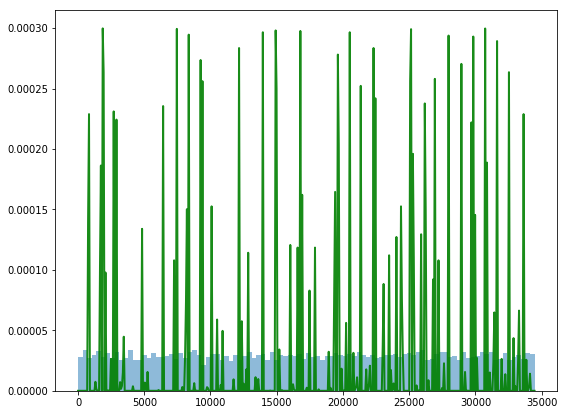

In [21]:
fig, ax2 = plt.subplots(figsize = (9,7))

#Plot histogram
ax2.hist(outliers_list, bins = 100, alpha = 0.5, density = True)
ax2.plot(grid, pdf, alpha = 0.9, color = 'green', linewidth = 2.0)
plt.show()

In [22]:
df = df.drop(np.asarray(outliers_list))

In [23]:
# Take a look at the outcome variable: Loan Status
print(df['Loan Status'].value_counts())

0.0    21437
1.0     4158
Name: Loan Status, dtype: int64


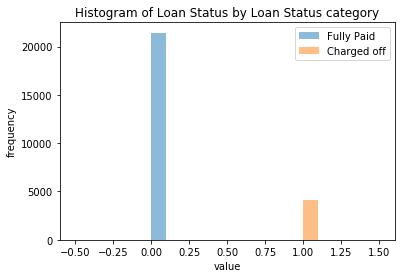

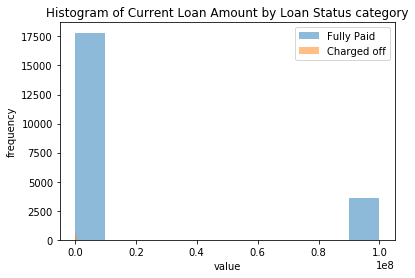

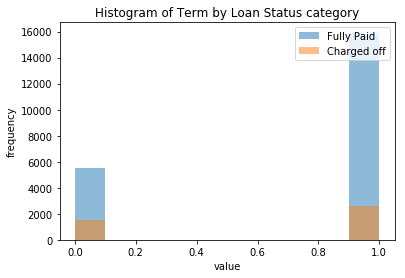

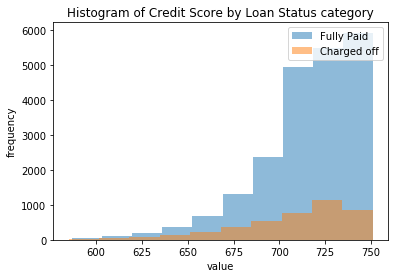

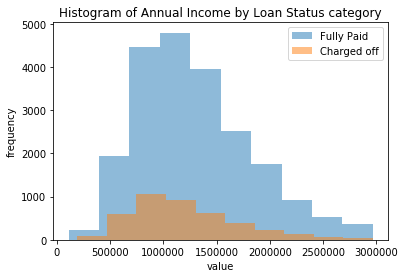

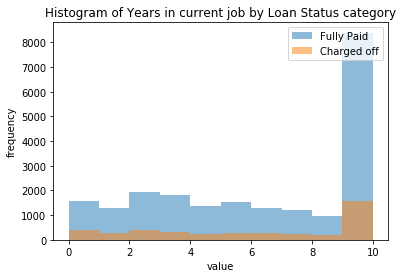

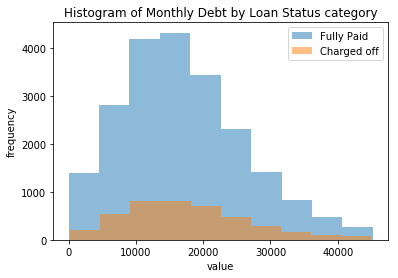

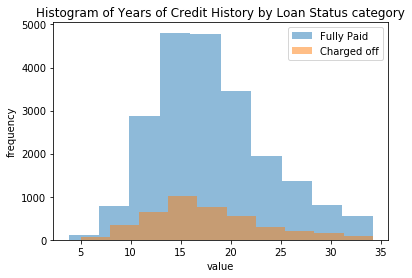

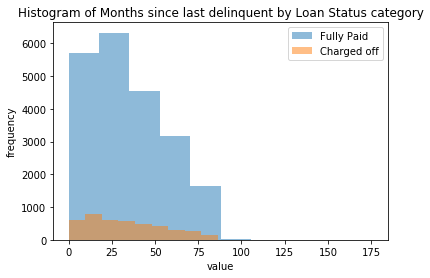

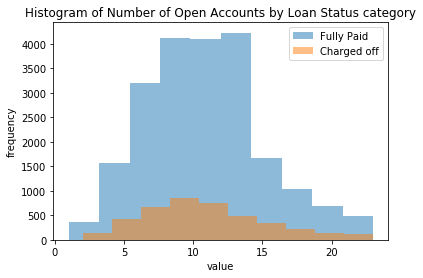

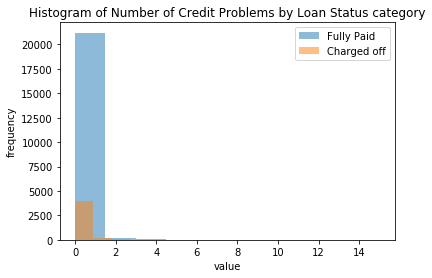

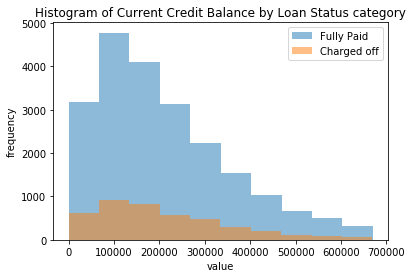

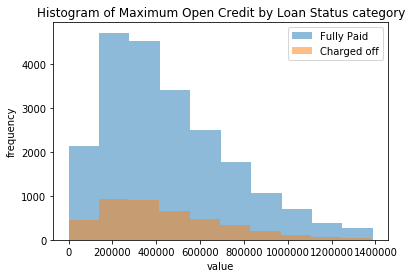

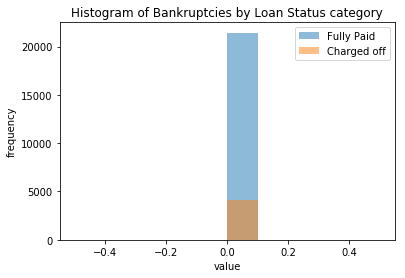

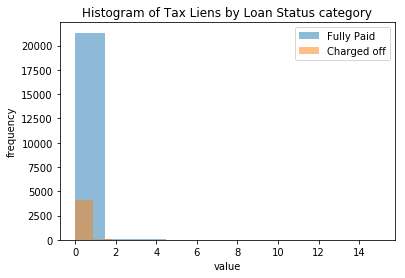

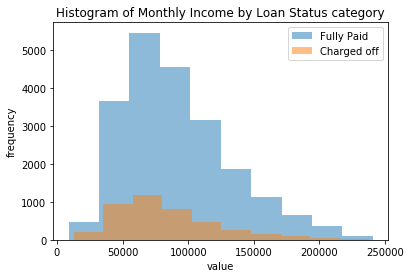

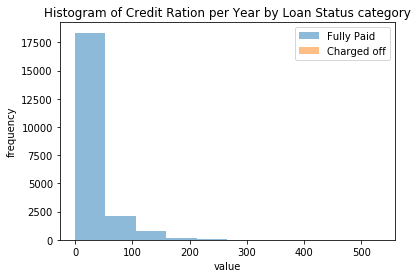

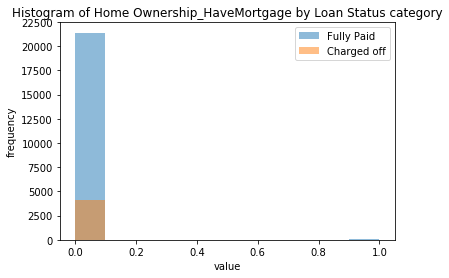

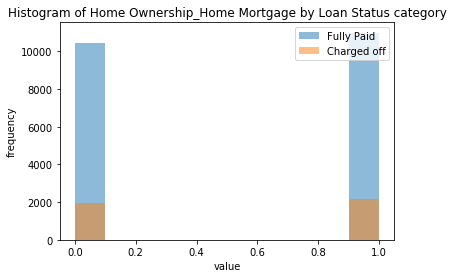

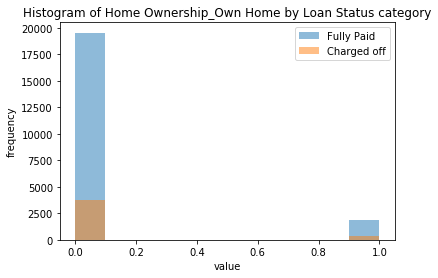

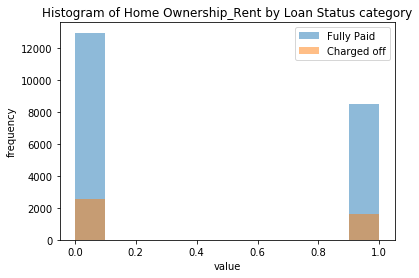

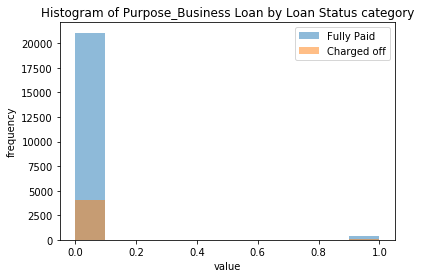

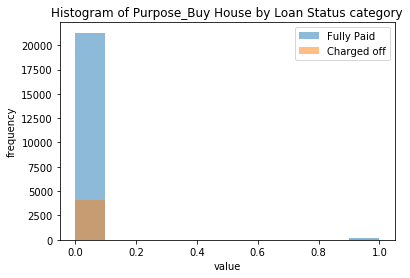

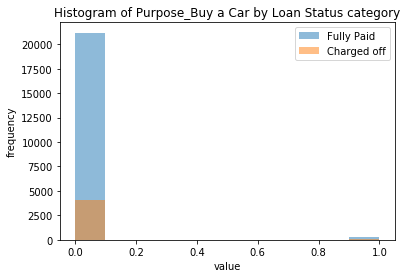

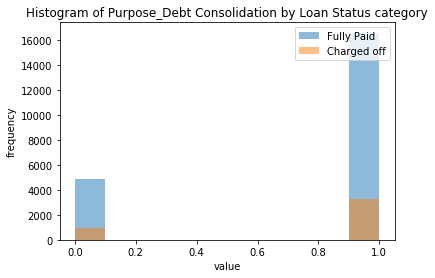

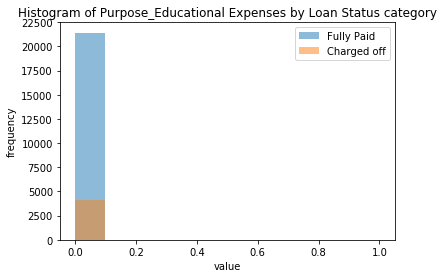

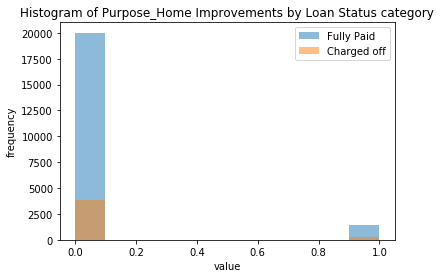

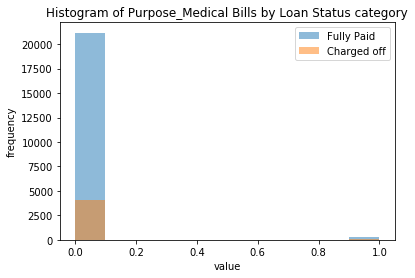

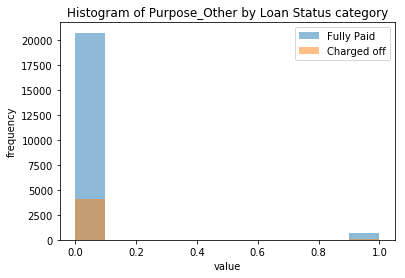

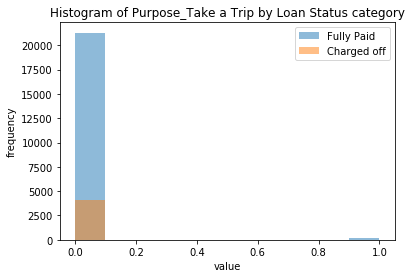

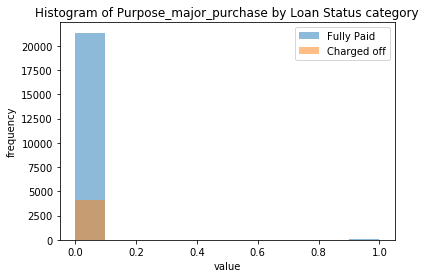

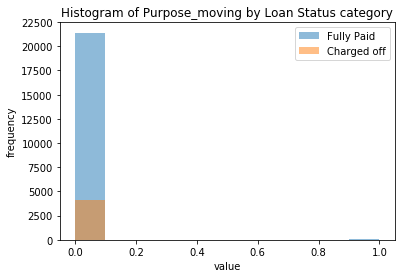

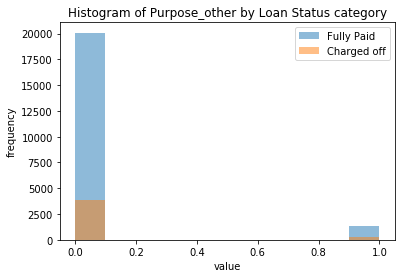

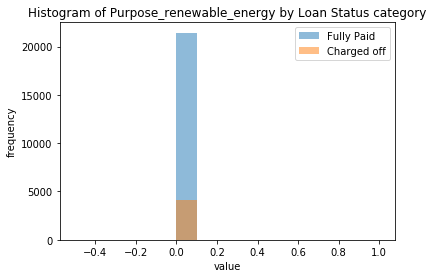

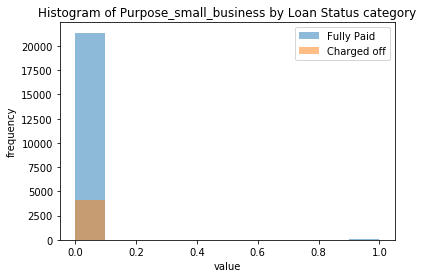

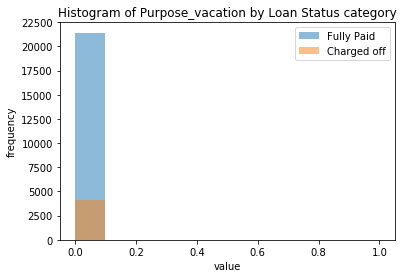

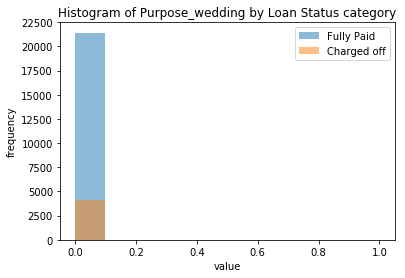

In [28]:
# Distribution of features : Histograms broken up by outcome categories (in this case Loan Status)
def plot_histogram(x,y):
    plt.hist(list(x[y==0]), alpha=0.5, label='Fully Paid')
    plt.hist(list(x[y==1]), alpha=0.5, label='Charged off')
    plt.title('Histogram of {0} by Loan Status category'.format(x.name))
    plt.xlabel("value")
    plt.ylabel("frequency")
    plt.legend(loc='upper right')
    plt.show()
    
for x in df.columns:
    plot_histogram(df[x],df["Loan Status"])

In [29]:
#calculate absolute correlation
corr_abs = abs(df.corr())
corr_abs[['Loan Status']].sort_values(by='Loan Status',ascending=False)

Loan Status
Loan Status                      1.000000
Current Loan Amount              0.178401
Credit Ration per Year           0.158460
Credit Score                     0.106232
Term                             0.095705
Monthly Income                   0.073395
Annual Income                    0.062139
Number of Open Accounts          0.029073
Monthly Debt                     0.026079
Years of Credit History          0.025905
Maximum Open Credit              0.021935
Years in current job             0.019360
Months since last delinquent     0.018157
Tax Liens                        0.015359
Purpose_Other                    0.014655
Purpose_vacation                 0.013503
Number of Credit Problems        0.012323
Home Ownership_Rent              0.011493
Home Ownership_Home Mortgage     0.009227
Purpose_Buy a Car                0.006227
Purpose_Educational Expenses     0.005265
Home Ownership_HaveMortgage      0.004934
Purpose_major_purchase           0.004351
Purpose_Debt Consolidation       0.004082
Purpose_Buy House                0.004078
Purpose_renewable_energy         0.003893
Purpose_Home Improvements        0.003620
Purpose_Medical Bills            0.003254
Purpose_other                    0.003171
Purpose_Take a Trip              0.003095
Home Ownership_Own Home          0.002694
Purpose_small_business           0.002320
Purpose_moving                   0.001804
Current Credit Balance           0.000913
Purpose_Business Loan            0.000192
Purpose_wedding                  0.000110
Bankruptcies                          NaN

In [30]:
corr_abs["Loan Status"].sum(skipna=True)

1.9454058416844229

In [31]:
#save as processed 
df.to_csv(data_folder + "/" + dataset + "_processed__removeoutliers" + file_type)

## PCA Preprocessing

In [39]:
# read original data again
df = pd.read_csv(data_folder + "/" + dataset + "_processed" + file_type)
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34468 entries, 0 to 34467
Data columns (total 37 columns):
Loan Status                     34468 non-null float64
Current Loan Amount             34468 non-null float64
Term                            34468 non-null float64
Credit Score                    34468 non-null float64
Annual Income                   34468 non-null float64
Years in current job            34468 non-null float64
Monthly Debt                    34468 non-null float64
Years of Credit History         34468 non-null float64
Months since last delinquent    34468 non-null float64
Number of Open Accounts         34468 non-null float64
Number of Credit Problems       34468 non-null float64
Current Credit Balance          34468 non-null float64
Maximum Open Credit             34468 non-null float64
Bankruptcies                    34468 non-null float64
Tax Liens                       34468 non-null float64
Monthly Income                  34468 non-null float64
Credit Rati

In [40]:
# Dimensionality Reduction using PCA
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

df_Y = df["Loan Status"]
df_X = df.drop("Loan Status", axis=1)

# Standardizing the features
df_X = StandardScaler().fit_transform(df_X)

In [41]:
pca = PCA(n_components = len(df.columns)-1)
    
X_pca = pca.fit_transform(df_X)
    
ex_variance=np.var(X_pca,axis=0)
ex_variance_ratio = ex_variance/np.sum(ex_variance)
print(ex_variance_ratio)
sum = 0
counter = 0
for var in ex_variance_ratio:
    counter += 1
    sum += var
    if sum > 0.90:
        break


[8.05554794e-02 5.50100880e-02 5.38827184e-02 5.31559258e-02
 5.12000090e-02 4.40970155e-02 3.91062766e-02 3.33292658e-02
 3.23918634e-02 2.98154627e-02 2.92325945e-02 2.87228173e-02
 2.84767755e-02 2.81940468e-02 2.81141979e-02 2.79744065e-02
 2.79564848e-02 2.78822401e-02 2.78505277e-02 2.78085819e-02
 2.77868128e-02 2.77182114e-02 2.75868589e-02 2.75246898e-02
 2.67438938e-02 2.49932865e-02 2.21471943e-02 1.81836560e-02
 1.41253788e-02 1.22990200e-02 1.03278346e-02 3.18261346e-03
 2.62377191e-03 1.58281497e-32 1.64557636e-33 1.06246631e-33]


In [42]:
pca = PCA(n_components = counter)
    
X_pca = pd.DataFrame(pca.fit_transform(df))
    
X_pca.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34468 entries, 0 to 34467
Data columns (total 26 columns):
0     34468 non-null float64
1     34468 non-null float64
2     34468 non-null float64
3     34468 non-null float64
4     34468 non-null float64
5     34468 non-null float64
6     34468 non-null float64
7     34468 non-null float64
8     34468 non-null float64
9     34468 non-null float64
10    34468 non-null float64
11    34468 non-null float64
12    34468 non-null float64
13    34468 non-null float64
14    34468 non-null float64
15    34468 non-null float64
16    34468 non-null float64
17    34468 non-null float64
18    34468 non-null float64
19    34468 non-null float64
20    34468 non-null float64
21    34468 non-null float64
22    34468 non-null float64
23    34468 non-null float64
24    34468 non-null float64
25    34468 non-null float64
dtypes: float64(26)
memory usage: 6.8 MB


In [43]:
finalDf = pd.concat([X_pca, df_Y], axis = 1)

In [44]:
#save as processed 
finalDf.to_csv(data_folder + "/" + dataset + "_processed__PCA" + file_type)

## Feature Generation

In [17]:
from sklearn.preprocessing import StandardScaler

# read original data again and prepare for feature generation
df = pd.read_csv(data_folder + "/" + dataset + "_processed" + file_type)
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]
df["index"] = df.index

target = df["Loan Status"]

df = df.drop("Loan Status", axis=1)

standard_scaler = StandardScaler()
df = pd.DataFrame(standard_scaler.fit_transform(df), columns=df.columns)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34468 entries, 0 to 34467
Data columns (total 37 columns):
Current Loan Amount             34468 non-null float64
Term                            34468 non-null float64
Credit Score                    34468 non-null float64
Annual Income                   34468 non-null float64
Years in current job            34468 non-null float64
Monthly Debt                    34468 non-null float64
Years of Credit History         34468 non-null float64
Months since last delinquent    34468 non-null float64
Number of Open Accounts         34468 non-null float64
Number of Credit Problems       34468 non-null float64
Current Credit Balance          34468 non-null float64
Maximum Open Credit             34468 non-null float64
Bankruptcies                    34468 non-null float64
Tax Liens                       34468 non-null float64
Monthly Income                  34468 non-null float64
Credit Ration per Year          34468 non-null float64
Home Owners

/home/debian/.local/lib/python3.5/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/home/debian/.local/lib/python3.5/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [18]:
import featuretools as ft

df = df.loc[:,~df.columns.duplicated()]

es = ft.EntitySet("values_first")
from featuretools import variable_types as vtypes

es.entity_from_dataframe(entity_id="values_first",
                         dataframe=df, index="index")

Entityset: values_first
  Entities:
    values_first [Rows: 34468, Columns: 37]
  Relationships:
    No relationships

In [19]:
primitives = ft.list_primitives()

orig_cols = df.columns
trans_primitives = primitives[primitives['type'] == 'transform']["name"].values
print(ft.primitives.list_primitives())

#select some
trans_primitives = ["multiply_numeric","add_numeric", "divide_numeric", "subtract_numeric", 'modulo_by_feature', 'divide_by_feature', 'scalar_subtract_numeric_feature']

                               name         type  \
0                               std  aggregation   
1                               any  aggregation   
2                              last  aggregation   
3                            median  aggregation   
4                               min  aggregation   
5                              mean  aggregation   
6                     n_most_common  aggregation   
7                        num_unique  aggregation   
8                              skew  aggregation   
9                               sum  aggregation   
10                     percent_true  aggregation   
11                            count  aggregation   
12                 time_since_first  aggregation   
13                              max  aggregation   
14                 avg_time_between  aggregation   
15                              all  aggregation   
16                             mode  aggregation   
17                            trend  aggregation   
18          

In [20]:
# DFS with specified primitives
feature_matrix, features = ft.dfs(entityset = es, target_entity = 'values_first',
                       trans_primitives = trans_primitives,
                       where_primitives = [], seed_features = [],
                       n_jobs = 1, verbose = 1,
                       max_depth = 1, features_only=False)  #set max_depth = 1


Built 3294 features
Elapsed: 00:57 | Remaining: 00:00 | Progress: 100%|██████████| Calculated: 11/11 chunks


In [21]:
fm_encoded, features_encoded = ft.encode_features(feature_matrix,
                                                  features)
fm_encoded.info()

<class 'pandas.core.frame.DataFrame'>
Float64Index: 34468 entries, -1.732000557316968 to 1.732000557316968
Columns: 3294 entries, Purpose_renewable_energy to Home Ownership_Own Home * Purpose_vacation
dtypes: float64(3294)
memory usage: 866.5 MB


In [22]:
for col in fm_encoded.columns:
    if fm_encoded[col].dtype != np.float64:
        fm_encoded[col] = fm_encoded[col].astype(np.float64)

In [26]:
fm_encoded['Loan Status'] = target.values
corr_abs = abs(fm_encoded.corr())
corr_abs[['Loan Status']].sort_values(by='Loan Status',ascending=False)

Loan Status
Loan Status                                            1.000000
Credit Score + Current Loan Amount                     0.187293
Current Loan Amount + Term                             0.184766
1 / Current Loan Amount                                0.178832
Current Loan Amount / Purpose_renewable_energy         0.177501
0 - Current Loan Amount                                0.177478
Current Loan Amount                                    0.177478
Current Loan Amount / Purpose_wedding                  0.177349
Current Loan Amount / Purpose_Educational Expenses     0.177324
Current Loan Amount / Purpose_major_purchase           0.177324
Current Loan Amount / Purpose_moving                   0.177260
Current Loan Amount / Purpose_vacation                 0.177250
Current Loan Amount / Home Ownership_HaveMortgage      0.177237
Current Loan Amount / Purpose_small_business           0.177158
Current Loan Amount / Purpose_Take a Trip              0.177154
Current Loan Amount / Purpose_Buy House                0.176785
Current Loan Amount / Purpose_Medical Bills            0.176501
Current Loan Amount / Purpose_Buy a Car                0.176377
1 % Current Loan Amount                                0.176148
Current Loan Amount / Purpose_Business Loan            0.175831
Current Loan Amount / Purpose_Other                    0.175124
Current Loan Amount / Tax Liens                        0.174859
Credit Ration per Year + Credit Score                  0.174029
Current Loan Amount / Purpose_other                    0.172063
Credit Ration per Year + Current Loan Amount           0.171725
Current Loan Amount + Monthly Income                   0.171559
Current Loan Amount / Purpose_Home Improvements        0.170638
Credit Ration per Year + Term                          0.168553
Current Loan Amount / Home Ownership_Own Home          0.168071
Credit Ration per Year + Monthly Income                0.166729
...                                                         ...
Purpose_Debt Consolidation * Purpose_wedding           0.000057
Home Ownership_Own Home / Purpose_Medical Bills        0.000056
Home Ownership_Own Home / Purpose_renewable_energy     0.000055
Purpose_moving * Years of Credit History               0.000053
Number of Credit Problems - Purpose_vacation           0.000044
Home Ownership_Own Home                                0.000039
0 - Home Ownership_Own Home                            0.000039
1 / Home Ownership_Own Home                            0.000039
1 % Home Ownership_Own Home                            0.000039
Home Ownership_Rent + Purpose_Debt Consolidation       0.000035
Purpose_Business Loan - Purpose_Medical Bills          0.000033
Bankruptcies - Home Ownership_Own Home                 0.000030
Home Ownership_Rent - Purpose_renewable_energy         0.000029
Maximum Open Credit * Purpose_small_business           0.000029
Purpose_Home Improvements + Purpose_Take a Trip        0.000026
Bankruptcies + Home Ownership_Own Home                 0.000025
Home Ownership_Own Home / Home Ownership_HaveMo...     0.000025
Home Ownership_HaveMortgage - Home Ownership_Ho...     0.000023
Bankruptcies / Purpose_renewable_energy                0.000023
Purpose_Educational Expenses / Home Ownership_Rent     0.000022
Bankruptcies / Purpose_Buy a Car                       0.000021
Home Ownership_Own Home / Purpose_vacation             0.000021
Bankruptcies / Purpose_major_purchase                  0.000018
Current Credit Balance / Number of Open Accounts       0.000017
Purpose_Debt Consolidation + Purpose_renewable_...     0.000007
Current Loan Amount * Home Ownership_Rent              0.000006
Home Ownership_Own Home / Purpose_moving               0.000006
0 - Bankruptcies                                       0.000004
Bankruptcies                                           0.000004
Annual Income * Home Ownership_Rent                    0.000003

[3295 rows x 1 columns]

In [27]:
from sklearn.feature_selection import SelectKBest, f_classif

#Such a large set of features may cause over fitting  and also slow computing
#Use feature selection  to select the most importatnt features

fm_encoded = fm_encoded.drop("Loan Status", axis=1)

select = SelectKBest(f_classif, k=15)
selected_features = select.fit(fm_encoded, target.values)
indices_selected = selected_features.get_support(indices=True)
colnames_selected = [fm_encoded.columns[i] for i in indices_selected]

FT = fm_encoded[colnames_selected]

In [28]:
FT = FT.reset_index(drop=True).merge(target.reset_index(drop=True), left_index=True, right_index=True)

In [29]:
#save as processed 
FT.to_csv(data_folder + "/" + dataset + "_processed__FTs" + file_type)

## PolynomialFeatures

In [30]:
from sklearn.preprocessing import StandardScaler

# read original data again and prepare for feature generation
df = pd.read_csv(data_folder + "/" + dataset + "_processed" + file_type)
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]
df["index"] = df.index

target = df["Loan Status"]

df = df.drop("Loan Status", axis=1)

standard_scaler = StandardScaler()
df = pd.DataFrame(standard_scaler.fit_transform(df), columns=df.columns)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34468 entries, 0 to 34467
Data columns (total 37 columns):
Current Loan Amount             34468 non-null float64
Term                            34468 non-null float64
Credit Score                    34468 non-null float64
Annual Income                   34468 non-null float64
Years in current job            34468 non-null float64
Monthly Debt                    34468 non-null float64
Years of Credit History         34468 non-null float64
Months since last delinquent    34468 non-null float64
Number of Open Accounts         34468 non-null float64
Number of Credit Problems       34468 non-null float64
Current Credit Balance          34468 non-null float64
Maximum Open Credit             34468 non-null float64
Bankruptcies                    34468 non-null float64
Tax Liens                       34468 non-null float64
Monthly Income                  34468 non-null float64
Credit Ration per Year          34468 non-null float64
Home Owners

/home/debian/.local/lib/python3.5/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/home/debian/.local/lib/python3.5/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [31]:
from itertools import combinations 
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(2)
poly_main = poly.fit_transform(df)
poly_main_names = poly.get_feature_names(df.columns)

X2 = pd.DataFrame(data=poly_main, columns=poly_main_names)

#The interactions amongst dummy variables belongiing to the same categorical feature are always zero
#Therefore, we have to remove those empty interaction terms

noint_indices = [i for i, x in enumerate(list((X2 == 0).all())) if x]
X2 = X2.drop(X2.columns[noint_indices], axis=1)

In [32]:
X2['Loan Status'] = target.values

In [33]:
#absolute correlation matrix sorted with descending order
corr_abs = abs(X2.corr())
corr_abs[['Loan Status']].sort_values(by='Loan Status',ascending=False)

Loan Status
Loan Status                                            1.000000
Current Loan Amount^2                                  0.177766
Current Loan Amount                                    0.177478
Credit Ration per Year                                 0.155048
Current Loan Amount Credit Ration per Year             0.148107
Credit Score                                           0.104242
Monthly Income Credit Ration per Year                  0.094639
Term                                                   0.093268
Term^2                                                 0.093268
Annual Income Credit Ration per Year                   0.090496
Credit Ration per Year^2                               0.089803
Credit Score^2                                         0.081716
Term Credit Score                                      0.071811
Monthly Income                                         0.066952
Annual Income                                          0.059726
Monthly Debt Credit Ration per Year                    0.044708
Current Credit Balance Credit Ration per Year          0.035542
Years of Credit History                                0.028970
Number of Open Accounts                                0.022189
Current Loan Amount Monthly Income                     0.020818
Years of Credit History Credit Ration per Year         0.020396
Current Credit Balance Purpose_Home Improvements       0.018821
Current Loan Amount Annual Income                      0.018737
Years in current job                                   0.018086
Years in current job Credit Ration per Year            0.018075
Credit Score Monthly Debt                              0.016961
Annual Income Years of Credit History                  0.016866
Months since last delinquent                           0.016368
Current Loan Amount Credit Score                       0.016303
Monthly Income^2                                       0.015960
...                                                         ...
Credit Ration per Year Home Ownership_Own Home         0.000296
Months since last delinquent Purpose_Buy House         0.000274
Purpose_Buy House Purpose_moving                       0.000270
Monthly Income Home Ownership_Rent                     0.000242
Purpose_Medical Bills Purpose_small_business           0.000240
Current Loan Amount Purpose_Buy House                  0.000210
Bankruptcies Purpose_Buy a Car                         0.000208
Months since last delinquent Purpose_Business Loan     0.000161
Home Ownership_HaveMortgage Purpose_Other              0.000152
Purpose_wedding                                        0.000141
Purpose_wedding^2                                      0.000141
Years in current job Purpose_wedding                   0.000114
Annual Income Home Ownership_HaveMortgage              0.000114
Home Ownership_Home Mortgage Purpose_renewable_...     0.000114
Purpose_moving Purpose_small_business                  0.000113
Purpose_Business Loan Purpose_Home Improvements        0.000104
Purpose_Home Improvements Purpose_Medical Bills        0.000087
Monthly Debt Purpose_Educational Expenses              0.000086
Monthly Debt Purpose_moving                            0.000085
Purpose_Debt Consolidation Purpose_wedding             0.000057
Years of Credit History Purpose_moving                 0.000053
Home Ownership_Own Home                                0.000039
Home Ownership_Own Home^2                              0.000039
Purpose_Business Loan index                            0.000038
Maximum Open Credit Purpose_small_business             0.000029
Purpose_renewable_energy index                         0.000016
Current Loan Amount Home Ownership_Rent                0.000006
Bankruptcies                                           0.000004
Annual Income Home Ownership_Rent                      0.000003
1                                                           NaN

[742 rows x 1 columns]

In [34]:
X2 = X2.drop('Loan Status',1)

In [39]:
from sklearn.feature_selection import SelectKBest, f_classif

#Such a large set of features may cause over fitting  and also slow computing
#Use feature selection  to select the most importatnt features

X2 = X2.loc[:, (X2 != X2.iloc[0]).any()] 

select = SelectKBest(f_classif, k=15)
selected_features = select.fit(X2, target.values)
indices_selected = selected_features.get_support(indices=True)
colnames_selected = [X2.columns[i] for i in indices_selected]

X_train_selected = X2[colnames_selected]


In [40]:
X_train_selected.columns

Index(['Current Loan Amount', 'Term', 'Credit Score', 'Annual Income',
       'Monthly Income', 'Credit Ration per Year', 'Current Loan Amount^2',
       'Current Loan Amount Credit Ration per Year', 'Term^2',
       'Term Credit Score', 'Credit Score^2',
       'Annual Income Credit Ration per Year',
       'Monthly Debt Credit Ration per Year',
       'Monthly Income Credit Ration per Year', 'Credit Ration per Year^2'],
      dtype='object')

In [41]:
X_train_selected = X_train_selected.reset_index(drop=True).merge(target.reset_index(drop=True), left_index=True, right_index=True)

In [42]:
X_train_selected.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34468 entries, 0 to 34467
Data columns (total 16 columns):
Current Loan Amount                           34468 non-null float64
Term                                          34468 non-null float64
Credit Score                                  34468 non-null float64
Annual Income                                 34468 non-null float64
Monthly Income                                34468 non-null float64
Credit Ration per Year                        34468 non-null float64
Current Loan Amount^2                         34468 non-null float64
Current Loan Amount Credit Ration per Year    34468 non-null float64
Term^2                                        34468 non-null float64
Term Credit Score                             34468 non-null float64
Credit Score^2                                34468 non-null float64
Annual Income Credit Ration per Year          34468 non-null float64
Monthly Debt Credit Ration per Year           34468 non-null fl

In [43]:
X_train_selected.head(20)

Current Loan Amount      Term  Credit Score  Annual Income  \
0              2.451202  0.630163      0.967239       0.822521   
1             -0.410738  0.630163      0.577974      -0.306791   
2             -0.401242  0.630163     -1.262187       1.175229   
3              2.451202  0.630163      0.507199      -0.812935   
4              2.451202  0.630163      0.931851      -0.746580   
5             -0.410265  0.630163      0.471811      -0.835996   
6             -0.397873 -1.586890      0.330260       0.380664   
7             -0.407885 -1.586890     -0.943697      -0.361677   
8             -0.403632 -1.586890     -0.908310       0.273615   
9              2.451202  0.630163      1.144178       0.302819   
10            -0.404099  0.630163      0.153322      -0.015421   
11            -0.397234 -1.586890     -1.120636       0.027813   
12            -0.408039 -1.586890     -1.191411       0.800710   
13            -0.413260  0.630163      0.330260      -0.003358   
14            -0.408721  0.630163      0.825688      -0.490292   
15            -0.406249 -1.586890     -2.182267      -0.247501   
16             2.451202 -1.586890      0.577974       1.121776   
17            -0.411927  0.630163      0.790301       0.467028   
18            -0.413226  0.630163      1.179565       0.854224   
19            -0.411974  0.630163      0.259485       0.163698   

    Monthly Income  Credit Ration per Year  Current Loan Amount^2  \
0         0.752430                0.938445               6.008393   
1        -0.215201               -0.358468               0.168706   
2         1.282929               -0.357577               0.160995   
3        -0.778224                3.703330               6.008393   
4        -0.702416                3.380762               6.008393   
5        -0.836356               -0.353993               0.168318   
6         0.435716               -0.353182               0.158303   
7        -0.257590               -0.355677               0.166370   
8         0.347161               -0.355957               0.162919   
9         0.328332                1.297282               6.008393   
10        0.069503               -0.354835               0.163296   
11        0.093858               -0.350421               0.157795   
12        0.512673               -0.359712               0.166496   
13        0.010907               -0.361237               0.170784   
14       -0.488391               -0.355555               0.167053   
15       -0.071022               -0.355033               0.165038   
16        0.999679                0.794377               6.008393   
17        0.378416               -0.361117               0.169684   
18        1.059578               -0.362127               0.170755   
19        0.019209               -0.360679               0.169723   

    Current Loan Amount Credit Ration per Year    Term^2  Term Credit Score  \
0                                     2.300319  0.397106           0.609519   
1                                     0.147236  0.397106           0.364218   
2                                     0.143475  0.397106          -0.795384   
3                                     9.077612  0.397106           0.319618   
4                                     8.286933  0.397106           0.587219   
5                                     0.145231  0.397106           0.297318   
6                                     0.140521  2.518220          -0.524087   
7                                     0.145075  2.518220           1.497544   
8                                     0.143676  2.518220           1.441387   
9                                     3.179901  0.397106           0.721019   
10                                    0.143389  0.397106           0.096618   
11                                    0.139199  2.518220           1.778326   
12                                    0.146777  2.518220           1.890638   
13                                    0.149285  0.397106     

In [44]:
#save as processed 
X_train_selected.to_csv(data_folder + "/" + dataset + "_processed__polynomial" + file_type)